In [5]:
import os
import re
import json
import logging
import unicodedata
import random
from collections import defaultdict, Counter

import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import timm
from transformers import GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers.modeling_outputs import CausalLMOutputWithCrossAttentions
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)

# =============================================================================
# Utility functions
# =============================================================================

def count_labels(data, target_classes, cfg):
    class_counts = defaultdict(int)
    data_by_class = defaultdict(list)
    for entry in tqdm(data.values(), desc="Counting dataset"):
        lbl = entry.get('class_label', '').lower()
        if lbl in target_classes and os.path.exists(entry['file_path']):
            class_counts[lbl] += 1
            data_by_class[lbl].append(entry)
    return class_counts, data_by_class

def prepare_abnormal_normal_data(data, cfg):
    random.seed(42)
    abnormal = ['ra', 'oa', 'gout']
    normal = ['normal']
    class_counts, data_by_class = count_labels(data, abnormal + normal, cfg)
    combined = {
        'abnormal': sum((data_by_class[c] for c in abnormal), []),
        'normal': data_by_class['normal']
    }
    combined_counts = {
        'abnormal': sum(class_counts[c] for c in abnormal),
        'normal': class_counts['normal']
    }
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(combined.values(), []), combined_counts, combined_counts
    min_count = min(combined_counts.values())
    balanced, final_counts = [], {}
    for lbl, items in combined.items():
        sampled = random.sample(items, min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    if cfg.DATASET.AUGMENT:
        balanced *= 2
    return balanced, combined_counts, final_counts

def prepare_data(data, target_classes, cfg, is_binary=False):
    random.seed(42)
    if len(target_classes) == 2 and 'abnormal' in target_classes and 'normal' in target_classes:
        logging.info("Using abnormal-vs-normal logic")
        return prepare_abnormal_normal_data(data, cfg)
    class_counts, data_by_class = count_labels(data, target_classes, cfg)
    logging.info(f"Original class distribution: {class_counts}")
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(data_by_class.values(), []), class_counts, class_counts
    min_count = min(class_counts.values())
    balanced, final_counts = [], {}
    for lbl in target_classes:
        sampled = random.sample(data_by_class[lbl], min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    logging.info(f"Balanced class distribution: {final_counts}")
    if cfg.DATASET.AUGMENT:
        balanced *= 2
    return balanced, class_counts, final_counts

# =============================================================================
# Transforms
# =============================================================================

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

patch_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

# =============================================================================
# Dataset
# =============================================================================

class FinalSamplesDataset(Dataset):
    def __init__(self, cfg, image_transform=train_transform, patch_transform=patch_transform):
        self.cfg = cfg
        self.image_transform = image_transform
        self.patch_transform = patch_transform

        self.target_classes = cfg.DATASET.TARGET_CLASSES
        if isinstance(self.target_classes, str):
            self.target_classes = self.target_classes.split(",")

        self.is_binary = len(self.target_classes) == 2
        self.abnormal_classify = self.is_binary and 'abnormal' in self.target_classes
        self.abnormal_mapping = (
            {'ra': 'abnormal', 'oa': 'abnormal', 'gout': 'abnormal', 'normal': 'normal'}
            if self.abnormal_classify else None
        )

        with open(cfg.DATASET.JSON, 'r') as f:
            raw_list = json.load(f)

        filtered = []
        for item in raw_list:
            merged = item.get('merged_image_path', '')
            fp = item.get('file_paths', [])
            if isinstance(fp, str):
                fp = [fp]
            paths = [merged] + fp
            if any(os.path.exists(p) for p in paths):
                filtered.append((merged, fp, item))

        self.data = {}
        for i, (merged, fp, item) in enumerate(filtered):
            cls = item.get('class', 'unknown').lower()
            if self.abnormal_mapping:
                cls = self.abnormal_mapping.get(cls, cls)
            self.data[i] = {
                'file_path': merged,
                'left_right_file_path': fp,
                'class_label': cls,
                'diagnosis': item.get('diagnosis', ''),
                'keypoints': item.get('keypoints', {})
            }

        if self.is_binary:
            balanced, _, _ = prepare_data(self.data, self.target_classes, cfg, True)
            self.data = {i: e for i, e in enumerate(balanced)}

        self.eos_token = None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        e = self.data[idx]
        img = Image.open(e['file_path']).convert('RGB')
        img = self.image_transform(img)

        patches = self._gen_patches(e['left_right_file_path'], e['keypoints'])
        pt = [self.patch_transform(Image.fromarray(p)) for p in patches]
        patches_tensor = torch.stack(pt, 0) if pt else torch.zeros(34, 3, 112, 112)

        raw   = e.get('diagnosis', '')
        clean = self._clean_report(raw)
        tok   = tokenizer(clean, truncation=True, max_length=512, return_tensors='pt')

        return {
            'full_img': img,
            'patches': patches_tensor,
            'raw_report': raw,
            'cleaned_report': clean,
            'input_ids': tok['input_ids'].squeeze(0),
            'attention_mask': tok['attention_mask'].squeeze(0)
        }

    def _gen_patches(self, paths, kps_dict, crop_size=(200, 300), patch_size=(112, 112)):
        def extract(arr, side_kps):
            lst = []
            pts = side_kps[0]['keypoints']
            for i in range(17):
                x, y, s = int(pts[3*i]), int(pts[3*i+1]), pts[3*i+2]
                if s > 0:
                    x0 = max(x - crop_size[0]//2, 0)
                    y0 = max(y - crop_size[1]//2, 0)
                    x1 = min(x + crop_size[0]//2, arr.shape[1])
                    y1 = min(y + crop_size[1]//2, arr.shape[0])
                    c = arr[y0:y1, x0:x1]
                    if c.size:
                        lst.append(cv2.resize(c, patch_size))
            return lst

        def pad17(lst):
            black = np.zeros((patch_size[1], patch_size[0], 3), np.uint8)
            while len(lst) < 17:
                lst.append(black)
            return lst[:17]

        left, right = [], []
        if len(paths) == 1:
            pth = paths[0]
            if not pth or not os.path.exists(pth):
                return pad17([]) + pad17([])
            img_arr = cv2.imread(pth)
            if img_arr is None:
                return pad17([]) + pad17([])
            arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
            if kps_dict.get('left'): left = extract(arr, kps_dict['left'])
            if kps_dict.get('right'): right = extract(arr, kps_dict['right'])
        else:
            for side, pth in zip(['left', 'right'], paths):
                if pth and os.path.exists(pth):
                    img_arr = cv2.imread(pth)
                    if img_arr is not None:
                        arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
                        if kps_dict.get(side):
                            lst = extract(arr, kps_dict[side])
                            if side == 'left': left = lst
                            else: right = lst

        if left and not right:
            right = [cv2.flip(p, 1) for p in left]
        if right and not left:
            left = [cv2.flip(p, 1) for p in right]
        if not left and not right:
            return pad17([]) + pad17([])

        return pad17(left) + pad17(right)

    def _clean_report(self, text):
        text = unicodedata.normalize('NFKC', text or '')
        text = re.sub(r'(?m)^-+\s*$', '', text)
        text = re.sub(r'[^\x00-\x7F]+', ' ', text)
        text = re.sub(r'([.!?]){2,}', r'\1', text)
        text = re.sub(r'\[\s*finding\s*\]', '[FINDING]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*conclusion\s*\]', '[CONCLUSION]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*diagnosis\s*\]', '[DIAGNOSIS]', text, flags=re.IGNORECASE)
        parts = re.split(r'\[\s*recommend(?:ation)?\s*\]', text, flags=re.IGNORECASE)
        text = parts[0]
        fm = re.search(r'\[FINDING\](.*?)(?=\[|$)', text, flags=re.IGNORECASE | re.DOTALL)
        cm = re.search(r'\[CONCLUSION\](.*?)(?=\[|$)', text, flags=re.IGNORECASE | re.DOTALL)
        if fm and cm and fm.group(1).strip().lower() == cm.group(1).strip().lower():
            text = re.sub(r'\[CONCLUSION\].*?(?=\[|$)', '', text, flags=re.IGNORECASE | re.DOTALL)
        text = re.sub(r'\[\s*(FINDING|CONCLUSION|DIAGNOSIS)\s*\]', '', text, flags=re.IGNORECASE)
        text = text.replace('_x000D_', ' ')
        text = re.sub(r'\s+', ' ', text).strip()
        if text and not text.endswith(self.eos_token):
            text += ' ' + self.eos_token
        return text

# =============================================================================
# Collate function
# =============================================================================

def collate_fn(batch):
    imgs = torch.stack([b['full_img'] for b in batch])
    pts  = [b['patches'] for b in batch]
    max_p = max(p.shape[0] for p in pts)
    pads = []
    for p in pts:
        if p.shape[0] < max_p:
            pad = torch.zeros((max_p - p.shape[0], *p.shape[1:]))
            p = torch.cat([p, pad], dim=0)
        pads.append(p)
    patches = torch.stack(pads, 0)

    ids   = [b['input_ids'] for b in batch]
    masks = [b['attention_mask'] for b in batch]
    ids   = nn.utils.rnn.pad_sequence(ids,   batch_first=True, padding_value=tokenizer.pad_token_id)
    masks = nn.utils.rnn.pad_sequence(masks, batch_first=True, padding_value=0)

    return {
        'full_imgs':      imgs,
        'patches':        patches,
        'input_ids':      ids,
        'attention_mask': masks,
        'raw_reports':    [b['raw_report']    for b in batch],
        'cleaned_reports':[b['cleaned_report'] for b in batch]
    }

# =============================================================================
# MultiModalModel with multi-layer fusion
# =============================================================================

class MultiModalModel(nn.Module):
    def __init__(self, gpt2_model_name='gpt2', inject_layers=(3,6,9)):
        super().__init__()
        self.global_encoder = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
        self.global_encoder.reset_classifier(0)
        self.global_proj    = nn.Linear(self.global_encoder.num_features, 768)

        self.patch_encoder = timm.create_model('resnet50', pretrained=True)
        self.patch_encoder.fc = nn.Identity()
        self.patch_proj    = nn.Linear(self.patch_encoder.num_features, 768)

        config = GPT2Config.from_pretrained(gpt2_model_name)
        config.add_cross_attention = True
        self.decoder = GPT2LMHeadModel.from_pretrained(gpt2_model_name, config=config)

        self.inject_layers = set(inject_layers)
        self.multihead_vis = nn.MultiheadAttention(embed_dim=768, num_heads=8, batch_first=True)

    def _pool(self, feats):
        return feats.mean(dim=[2,3]) if feats.ndim > 2 else feats

    def forward(self, imgs, patches, input_ids, attention_mask, decoder_labels=None):
        B = imgs.size(0)
        # global image
        g = self.global_encoder(imgs)
        g = self.global_proj(g).unsqueeze(1)
        # patches
        B,N,C,H,W = patches.shape
        p = patches.view(B*N, C,H,W)
        pf = (self.patch_encoder.forward_features(p)
              if hasattr(self.patch_encoder, 'forward_features')
              else self.patch_encoder(p))
        pf = self._pool(pf)
        pf = self.patch_proj(pf).view(B, N, -1)
        # fuse
        vis = torch.cat([g, pf], dim=1)
        fused, _ = self.multihead_vis(vis, vis, vis)
        fused = fused.contiguous()
        # token embeddings
        inputs_embeds = self.decoder.transformer.wte(input_ids)
        pos_ids = torch.arange(input_ids.size(1), device=imgs.device)
        pos_embeds = self.decoder.transformer.wpe(pos_ids).unsqueeze(0)
        hidden = (inputs_embeds + pos_embeds).contiguous()
        hidden = self.decoder.transformer.drop(hidden)
        # masks
        ext_attn_mask = self.decoder.get_extended_attention_mask(attention_mask, input_ids.shape, imgs.device)
        enc_attn_mask = torch.ones(B, fused.size(1), device=imgs.device)
        # blocks
        for i, block in enumerate(self.decoder.transformer.h):
            ln1 = block.ln_1(hidden)
            attn_out, _ = block.attn(ln1, attention_mask=ext_attn_mask)
            hidden = hidden + attn_out
            if i in self.inject_layers:
                ln_cross = block.ln_cross_attn(hidden)
                cross_out, _ = block.crossattention(ln_cross,
                                                    encoder_hidden_states=fused,
                                                    encoder_attention_mask=enc_attn_mask)
                hidden = hidden + cross_out
            ln2 = block.ln_2(hidden)
            hidden = hidden + block.mlp(ln2)
        hidden = self.decoder.transformer.ln_f(hidden)
        logits = self.decoder.lm_head(hidden)
        loss = None
        if decoder_labels is not None:
            shift_logits = logits[..., :-1, :].contiguous()
            shift_labels = decoder_labels[..., 1:].contiguous()
            loss = nn.CrossEntropyLoss(ignore_index=self.decoder.config.pad_token_id)(
                shift_logits.view(-1, shift_logits.size(-1)),
                shift_labels.view(-1)
            )
        return CausalLMOutputWithCrossAttentions(
            loss=loss, logits=logits, past_key_values=None,
            decoder_hidden_states=None, decoder_attentions=None,
            cross_attentions=None, encoder_last_hidden_state=fused
        )

# =============================================================================
# Training / Eval / Plot
# =============================================================================

def train_epoch(model, loader, optimizer, scaler, device):
    model.train()
    total = 0.0
    for b in tqdm(loader, desc="Training", leave=False):
        imgs, pts = b['full_imgs'].to(device), b['patches'].to(device)
        ids, msk = b['input_ids'].to(device), b['attention_mask'].to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            loss = out.loss
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total += loss.item()
    return total / len(loader)

def evaluate(model, loader, device):
    model.eval()
    total = 0.0
    gens, gts = [], []
    stm = SentenceTransformer('all-MiniLM-L6-v2', device=device)
    for b in tqdm(loader, desc="Evaluating", leave=False):
        imgs, pts = b['full_imgs'].to(device), b['patches'].to(device)
        ids, msk = b['input_ids'].to(device), b['attention_mask'].to(device)
        with torch.no_grad():
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            total += out.loss.item()
            prompt = ids[:, :1]
            gen_ids = model.decoder.generate(
                input_ids=prompt,
                encoder_hidden_states=out.encoder_last_hidden_state,
                attention_mask=torch.ones_like(prompt),
                max_length=100, do_sample=True,
                top_k=50, top_p=0.95,
                temperature=0.7, repetition_penalty=1.2,
                eos_token_id=tokenizer.eos_token_id,
                pad_token_id=tokenizer.eos_token_id
            )
            gens += [tokenizer.decode(g, skip_special_tokens=True) for g in gen_ids]
            gts  += [tokenizer.decode(i, skip_special_tokens=True) for i in ids]
    loss = total / len(loader)
    e1 = stm.encode(gens, convert_to_tensor=True)
    e2 = stm.encode(gts,  convert_to_tensor=True)
    sim = nn.functional.cosine_similarity(e1, e2).mean().item()
    return loss, sim

def plot_metrics(tr, va, sm):
    epochs = range(1, len(tr)+1)
    plt.figure(figsize=(12,5))
    plt.plot(epochs, tr, label="Train Loss")
    plt.plot(epochs, va, label="Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
    plt.twinx()
    plt.plot(epochs, sm, label="Sim"); plt.ylabel("Similarity"); plt.legend(loc='lower right')
    plt.tight_layout(); plt.show()

# =============================================================================
# MAIN
# =============================================================================

if __name__ == "__main__":
    class Cfg: pass
    cfg = Cfg()
    cfg.DATASET = Cfg()
    cfg.DATASET.JSON = 'final_samples_both_only_fixed.json'
    cfg.DATASET.TARGET_CLASSES = ['ra','oa','gout','normal','uncertain','ref.prev']
    cfg.DATASET.BALANCE = False
    cfg.DATASET.AUGMENT = False

    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    tokenizer.pad_token = tokenizer.eos_token
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    dataset = FinalSamplesDataset(cfg)
    dataset.eos_token = tokenizer.eos_token
    dist = Counter(e['class_label'] for e in dataset.data.values())
    print("Class dist:", dist)

    n = len(dataset)
    n_train = int(0.8*n); n_val = int(0.1*n); n_test = n - n_train - n_val
    train_ds, val_ds, test_ds = random_split(dataset, [n_train,n_val,n_test])
    train_loader = DataLoader(train_ds, batch_size=4, shuffle=True,  collate_fn=collate_fn)
    val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False, collate_fn=collate_fn)
    test_loader  = DataLoader(test_ds,  batch_size=4, shuffle=False, collate_fn=collate_fn)

    model = MultiModalModel(inject_layers=(3,6,9)).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=5e-5)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
    scaler = torch.cuda.amp.GradScaler()

    train_losses, val_losses, sems = [], [], []
    for epoch in range(1, 2):
        print(f"\nEpoch {epoch}/10")
        tl = train_epoch(model, train_loader, optimizer, scaler, device)
        vl, vs = evaluate(model, val_loader, device)
        train_losses.append(tl); val_losses.append(vl); sems.append(vs)
        print(f" Train Loss: {tl:.4f} | Val Loss: {vl:.4f} | Val Sim: {vs:.4f}")
        scheduler.step()

    plot_metrics(train_losses, val_losses, sems)

    test_loss, test_sim = evaluate(model, test_loader, device)
    print(f"\nTEST Loss: {test_loss:.4f} | TEST Sim: {test_sim:.4f}")

    for idx in random.sample(range(len(test_ds)), min(5, len(test_ds))):
        ex = test_ds[idx]
        raw, clean = ex['raw_report'], ex['cleaned_report']
        fi, pa = ex['full_img'].unsqueeze(0).to(device), ex['patches'].unsqueeze(0).to(device)
        prompt = ex['input_ids'][:1].unsqueeze(0).to(device)
        with torch.no_grad():
            out = model(fi, pa, prompt, torch.ones_like(prompt))
            gen_ids = model.decoder.generate(
                input_ids=prompt,
                encoder_hidden_states=out.encoder_last_hidden_state,
                attention_mask=torch.ones_like(prompt),
                max_length=120, do_sample=True,
                top_k=40, top_p=0.95,
                temperature=0.5, repetition_penalty=1.3,
                eos_token_id=tokenizer.eos_token_id,
                pad_token_id=tokenizer.eos_token_id
            )
            gen = tokenizer.decode(gen_ids[0], skip_special_tokens=True)
        print(f"\n--- Example {idx} ---")
        print("Raw:    ", raw)
        print("Clean:  ", clean)
        print("Gen:    ", gen)


Using device: cuda
Class dist: Counter({'normal': 748, 'uncertain': 620, 'oa': 573, 'gout': 267, 'ra': 115, 'ref.prev': 60, 'oa, ra': 8, 'combination of oa, ra': 3})


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/swin_base_patch4_window7_224.ms_in22k_ft_in1k)
INFO:timm.models._hub:[timm/swin_base_patch4_window7_224.ms_in22k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/resnet50.a1_in1k)
INFO:timm.models._hub:[timm/resnet50.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossatten


Epoch 1/10


Training:   0%|          | 0/479 [00:00<?, ?it/s]/tmp/ipykernel_18839/1250774560.py:377: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


IndexError: too many indices for tensor of dimension 2

In [3]:
import os
import re
import json
import logging
import unicodedata
import random
from collections import defaultdict, Counter

import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import timm
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)

# =============================================================================
# Utility functions
# =============================================================================

def count_labels(data, target_classes, cfg):
    class_counts = defaultdict(int)
    data_by_class = defaultdict(list)
    for entry in tqdm(data.values(), desc="Counting dataset"):
        lbl = entry.get('class_label', '').lower()
        if lbl in target_classes and os.path.exists(entry['file_path']):
            class_counts[lbl] += 1
            data_by_class[lbl].append(entry)
    return class_counts, data_by_class

def prepare_abnormal_normal_data(data, cfg):
    random.seed(42)
    abnormal = ['ra', 'oa', 'gout']
    normal = ['normal']
    class_counts, data_by_class = count_labels(data, abnormal + normal, cfg)
    combined = {
        'abnormal': sum((data_by_class[c] for c in abnormal), []),
        'normal': data_by_class['normal']
    }
    combined_counts = {
        'abnormal': sum(class_counts[c] for c in abnormal),
        'normal': class_counts['normal']
    }
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(combined.values(), []), combined_counts, combined_counts
    min_count = min(combined_counts.values())
    balanced = []
    final_counts = {}
    for lbl, items in combined.items():
        sampled = random.sample(items, min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    if cfg.DATASET.AUGMENT:
        balanced *= 2
    return balanced, combined_counts, final_counts

def prepare_data(data, target_classes, cfg, is_binary=False):
    random.seed(42)
    if len(target_classes) == 2 and 'abnormal' in target_classes and 'normal' in target_classes:
        logging.info("Using abnormal-vs-normal logic")
        return prepare_abnormal_normal_data(data, cfg)
    class_counts, data_by_class = count_labels(data, target_classes, cfg)
    logging.info(f"Original class distribution: {class_counts}")
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(data_by_class.values(), []), class_counts, class_counts
    min_count = min(class_counts.values())
    balanced, final_counts = [], {}
    for lbl in target_classes:
        sampled = random.sample(data_by_class[lbl], min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    logging.info(f"Balanced class distribution: {final_counts}")
    if cfg.DATASET.AUGMENT:
        balanced *= 2
    return balanced, class_counts, final_counts

# =============================================================================
# Transforms
# =============================================================================

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

patch_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

# =============================================================================
# Dataset
# =============================================================================

class FinalSamplesDataset(Dataset):
    def __init__(self, cfg, image_transform=train_transform, patch_transform=patch_transform):
        self.cfg = cfg
        self.image_transform = image_transform
        self.patch_transform = patch_transform

        self.target_classes = cfg.DATASET.TARGET_CLASSES
        if isinstance(self.target_classes, str):
            self.target_classes = self.target_classes.split(",")

        self.is_binary = len(self.target_classes) == 2
        self.abnormal_classify = self.is_binary and 'abnormal' in self.target_classes
        self.abnormal_mapping = (
            {'ra': 'abnormal', 'oa': 'abnormal', 'gout': 'abnormal', 'normal': 'normal'}
            if self.abnormal_classify else None
        )

        with open(cfg.DATASET.JSON, 'r') as f:
            raw_list = json.load(f)

        filtered = []
        for item in raw_list:
            merged = item.get('merged_image_path', '')
            fp = item.get('file_paths', [])
            if isinstance(fp, str):
                fp = [fp]
            paths = [merged] + fp
            if any(os.path.exists(p) for p in paths):
                filtered.append((merged, fp, item))

        self.data = {}
        for i, (merged, fp, item) in enumerate(filtered):
            cls = item.get('class', 'unknown').lower()
            if self.abnormal_mapping:
                cls = self.abnormal_mapping.get(cls, cls)
            self.data[i] = {
                'file_path': merged,
                'left_right_file_path': fp,
                'class_label': cls,
                'diagnosis': item.get('diagnosis', ''),
                'keypoints': item.get('keypoints', {})
            }

        if self.is_binary:
            balanced, _, _ = prepare_data(self.data, self.target_classes, cfg, True)
            self.data = {i: e for i, e in enumerate(balanced)}

        self.eos_token = None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        e = self.data[idx]
        img = Image.open(e['file_path']).convert('RGB')
        img = self.image_transform(img)

        patches = self._gen_patches(e['left_right_file_path'], e['keypoints'])
        pt = [self.patch_transform(Image.fromarray(p)) for p in patches]
        patches_tensor = torch.stack(pt, 0) if pt else torch.zeros(34, 3, 112, 112)

        raw = e.get('diagnosis', '')
        clean = self._clean_report(raw)
        tok = tokenizer(clean, truncation=True, max_length=512, return_tensors='pt')

        return {
            'full_img': img,
            'patches': patches_tensor,
            'raw_report': raw,
            'cleaned_report': clean,
            'input_ids': tok['input_ids'].squeeze(0),
            'attention_mask': tok['attention_mask'].squeeze(0)
        }

    def _gen_patches(self, paths, kps_dict, crop_size=(200, 300), patch_size=(112, 112)):
        def extract(arr, side_kps):
            lst = []
            pts = side_kps[0]['keypoints']
            for i in range(17):
                x, y, s = int(pts[3*i]), int(pts[3*i+1]), pts[3*i+2]
                if s > 0:
                    x0 = max(x - crop_size[0]//2, 0)
                    y0 = max(y - crop_size[1]//2, 0)
                    x1 = min(x + crop_size[0]//2, arr.shape[1])
                    y1 = min(y + crop_size[1]//2, arr.shape[0])
                    c = arr[y0:y1, x0:x1]
                    if c.size:
                        lst.append(cv2.resize(c, patch_size))
            return lst

        def pad17(lst):
            black = np.zeros((patch_size[1], patch_size[0], 3), np.uint8)
            while len(lst) < 17:
                lst.append(black)
            return lst[:17]

        left, right = [], []
        if len(paths) == 1:
            pth = paths[0]
            if not pth or not os.path.exists(pth):
                return pad17([]) + pad17([])
            img_arr = cv2.imread(pth)
            if img_arr is None:
                return pad17([]) + pad17([])
            arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
            if kps_dict.get('left'): left = extract(arr, kps_dict['left'])
            if kps_dict.get('right'): right = extract(arr, kps_dict['right'])
        else:
            for side, pth in zip(['left', 'right'], paths):
                if pth and os.path.exists(pth):
                    img_arr = cv2.imread(pth)
                    if img_arr is not None:
                        arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
                        if kps_dict.get(side):
                            lst = extract(arr, kps_dict[side])
                            if side == 'left': left = lst
                            else: right = lst

        if left and not right:
            right = [cv2.flip(p, 1) for p in left]
        if right and not left:
            left = [cv2.flip(p, 1) for p in right]
        if not left and not right:
            return pad17([]) + pad17([])

        return pad17(left) + pad17(right)

    def _clean_report(self, text):
        text = unicodedata.normalize('NFKC', text or '')
        text = re.sub(r'(?m)^-+\s*$', '', text)
        text = re.sub(r'[^\x00-\x7F]+', ' ', text)
        text = re.sub(r'([.!?]){2,}', r'\1', text)
        text = re.sub(r'\[\s*finding\s*\]', '[FINDING]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*conclusion\s*\]', '[CONCLUSION]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*diagnosis\s*\]', '[DIAGNOSIS]', text, flags=re.IGNORECASE)
        parts = re.split(r'\[\s*recommend(?:ation)?\s*\]', text, flags=re.IGNORECASE)
        text = parts[0]
        fm = re.search(r'\[FINDING\](.*?)(?=\[|$)', text, flags=re.IGNORECASE | re.DOTALL)
        cm = re.search(r'\[CONCLUSION\](.*?)(?=\[|$)', text, flags=re.IGNORECASE | re.DOTALL)
        if fm and cm and fm.group(1).strip().lower() == cm.group(1).strip().lower():
            text = re.sub(r'\[CONCLUSION\].*?(?=\[|$)', '', text, flags=re.IGNORECASE | re.DOTALL)
        text = re.sub(r'\[\s*(FINDING|CONCLUSION|DIAGNOSIS)\s*\]', '', text, flags=re.IGNORECASE)
        text = text.replace('_x000D_', ' ')
        text = re.sub(r'\s+', ' ', text).strip()
        if text and not text.endswith(self.eos_token):
            text += ' ' + self.eos_token
        return text

# =============================================================================
# Collate function
# =============================================================================
def collate_fn(batch):
    imgs = torch.stack([b['full_img'] for b in batch])
    pts = [b['patches'] for b in batch]
    max_p = max(p.shape[0] for p in pts)
    pads = []
    for p in pts:
        if p.shape[0] < max_p:
            pad = torch.zeros((max_p - p.shape[0], *p.shape[1:]))
            p = torch.cat([p, pad], dim=0)
        pads.append(p)
    patches = torch.stack(pads, 0)

    ids = [b['input_ids'] for b in batch]
    masks = [b['attention_mask'] for b in batch]
    ids = nn.utils.rnn.pad_sequence(ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    masks = nn.utils.rnn.pad_sequence(masks, batch_first=True, padding_value=0)

    return {
        'full_imgs': imgs,
        'patches': patches,
        'input_ids': ids,
        'attention_mask': masks,
        'raw_reports': [b['raw_report'] for b in batch],
        'cleaned_reports': [b['cleaned_report'] for b in batch]
    }

# =============================================================================
# Model
# =============================================================================
class MultiModalModel(nn.Module):
    def __init__(self, gpt2_model_name='gpt2'):
        super().__init__()
        self.global_encoder = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
        self.global_encoder.reset_classifier(0)
        self.global_proj = nn.Linear(self.global_encoder.num_features, 768)

        self.patch_encoder = timm.create_model('resnet50', pretrained=True)
        self.patch_encoder.fc = nn.Identity()
        self.patch_proj = nn.Linear(self.patch_encoder.num_features, 768)

        self.attn = nn.MultiheadAttention(embed_dim=768, num_heads=8, batch_first=True)
        self.norm = nn.LayerNorm(768)

        self.decoder = GPT2LMHeadModel.from_pretrained(gpt2_model_name, add_cross_attention=True)

    def _pool(self, feats):
        return feats.mean(dim=[2, 3]) if feats.ndim > 2 else feats

    def forward(self, imgs, patches, input_ids, attention_mask, decoder_labels=None):
        g = self.global_encoder(imgs)
        g = self.global_proj(g).unsqueeze(1)

        B, N, C, H, W = patches.shape
        p = patches.view(B * N, C, H, W)
        pf = (self.patch_encoder.forward_features(p)
              if hasattr(self.patch_encoder, 'forward_features')
              else self.patch_encoder(p))
        pf = self._pool(pf)
        pf = self.patch_proj(pf)
        pf = pf.view(B, N, 768)

        cat = torch.cat([g, pf], dim=1)
        comb, _ = self.attn(cat, cat, cat)
        comb = self.norm(comb)

        return self.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=comb,
            labels=decoder_labels
        )

# =============================================================================
# Train / Eval helpers
# =============================================================================

def train_epoch(model, loader, optimizer, scaler, device):
    model.train()
    total_loss = 0.0
    for b in tqdm(loader, desc="Training", leave=False):
        imgs = b['full_imgs'].to(device)
        pts = b['patches'].to(device)
        ids = b['input_ids'].to(device)
        msk = b['attention_mask'].to(device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            loss = out.loss
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.0
    all_gen, all_gt = [], []

    for b in tqdm(loader, desc="Evaluating", leave=False):
        imgs = b['full_imgs'].to(device)
        pts = b['patches'].to(device)
        ids = b['input_ids'].to(device)
        msk = b['attention_mask'].to(device)

        with torch.no_grad():
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            total_loss += out.loss.item()

            prompt = ids[:, :1]
            g = model.global_encoder(imgs)
            g = model.global_proj(g).unsqueeze(1)

            B, N, C, H, W = pts.shape
            p = pts.view(B * N, C, H, W)
            pf = model.patch_encoder(p)
            pf = model._pool(pf)
            pf = model.patch_proj(pf)
            pf = pf.view(B, N, 768)

            cat = torch.cat([g, pf], dim=1)
            comb, _ = model.attn(cat, cat, cat)
            comb = model.norm(comb)

            gen_ids = model.decoder.generate(
                input_ids=prompt,
                encoder_hidden_states=comb,
                attention_mask=torch.ones_like(prompt),
                max_length=100,
                do_sample=True,
                top_k=50,
                top_p=0.95,
                temperature=0.7,
                repetition_penalty=1.2,
                eos_token_id=tokenizer.eos_token_id,
                pad_token_id=tokenizer.eos_token_id
            )

            gen_txt = [tokenizer.decode(g_, skip_special_tokens=True) for g_ in gen_ids]
            gt_txt = [tokenizer.decode(i_, skip_special_tokens=True) for i_ in ids]
            all_gen.extend(gen_txt)
            all_gt.extend(gt_txt)

    return total_loss / len(loader), all_gen, all_gt

def compute_semantic_similarity(gen, gt):
    stm = SentenceTransformer('all-MiniLM-L6-v2')
    e1 = stm.encode(gen, convert_to_tensor=True)
    e2 = stm.encode(gt, convert_to_tensor=True)
    return nn.functional.cosine_similarity(e1, e2).mean().item()

def plot_metrics(train_losses, val_losses, sems):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, sems, label="Semantic Similarity", color='green')
    plt.xlabel("Epoch")
    plt.ylabel("Similarity")
    plt.legend()

    plt.tight_layout()
    plt.show()

# =============================================================================
# MAIN
# =============================================================================

class Cfg: pass
cfg = Cfg()
cfg.DATASET = Cfg()
cfg.DATASET.JSON = 'final_samples_both_only_fixed.json'
cfg.DATASET.USE_RAW = True
cfg.DATASET.USE_PATCH = True
cfg.DATASET.REPORT = True
cfg.DATASET.TARGET_CLASSES = ['ra', 'oa', 'gout', 'normal', 'uncertain', 'ref.prev']
cfg.DATASET.BALANCE = False
cfg.DATASET.AUGMENT = False

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

dataset = FinalSamplesDataset(cfg)
dataset.eos_token = tokenizer.eos_token

import os
import random
from PIL import Image

# 1. Create output directory
out_dir = "Image_and_Patches_Samples"
os.makedirs(out_dir, exist_ok=True)

# 2. Pick one random sample from the dataset’s internal data dict
sample_idx = random.choice(list(dataset.data.keys()))
entry = dataset.data[sample_idx]

# 3. Load and save the raw (merged) image
raw_path = entry['file_path']
raw_img = Image.open(raw_path).convert('RGB')
raw_basename = os.path.splitext(os.path.basename(raw_path))[0]
raw_save_path = os.path.join(out_dir, f"{raw_basename}_raw.jpg")
raw_img.save(raw_save_path)
print(f"Saved raw image to: {raw_save_path}")

# 4. Generate patches using the same logic as in FinalSamplesDataset._gen_patches
#    Note: _gen_patches expects (paths_list, keypoints_dict)
patch_arrays = dataset._gen_patches(
    entry['left_right_file_path'],
    entry['keypoints']
)

# 5. Save each patch
for i, patch_arr in enumerate(patch_arrays):
    # patch_arr is a NumPy array in RGB format
    patch_img = Image.fromarray(patch_arr)
    patch_save_path = os.path.join(out_dir, f"{raw_basename}_patch_{i:02d}.jpg")
    patch_img.save(patch_save_path)
print(f"Saved {len(patch_arrays)} patches to: {out_dir}")


dist = Counter(e['class_label'] for e in dataset.data.values())
print("\nDataset class distribution:")
for cls, cnt in dist.items():
    print(f"  {cls}: {cnt}")

n = len(dataset)
n_train = int(0.8 * n)
n_val = int(0.1 * n)
n_test = n - n_train - n_val

train_ds, val_ds, test_ds = random_split(dataset, [n_train, n_val, n_test])

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_ds, batch_size=4, shuffle=False, collate_fn=collate_fn)

model = MultiModalModel().to(device)
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
scaler = torch.cuda.amp.GradScaler()

num_epochs = 1
train_losses, val_losses, sems = [], [], []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    train_loss = train_epoch(model, train_loader, optimizer, scaler, device)
    val_loss, gen_txt, gt_txt = evaluate(model, val_loader, device)
    sem = compute_semantic_similarity(gen_txt, gt_txt)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    sems.append(sem)

    print(f"  Train Loss          : {train_loss:.4f}")
    print(f"  Validation Loss     : {val_loss:.4f}")
    print(f"  Semantic Similarity : {sem:.4f}")
    scheduler.step()

plot_metrics(train_losses, val_losses, sems)

test_loss, test_gen, test_gt = evaluate(model, test_loader, device)
test_sem = compute_semantic_similarity(test_gen, test_gt)

print("\n========== TEST RESULTS ==========")
print(f"Test Loss              : {test_loss:.4f}")
print(f"Test Semantic Sim     : {test_sem:.4f}")

print("\n===== RANDOM TEST EXAMPLES =====")
for idx in random.sample(range(len(test_ds)), min(10, len(test_ds))):
    ex = test_ds[idx]
    raw = ex['raw_report']
    clean = ex['cleaned_report']
    fi = ex['full_img'].unsqueeze(0).to(device)
    pa = ex['patches'].unsqueeze(0).to(device)
    prompt = ex['input_ids'][:1].unsqueeze(0).to(device)

    g = model.global_encoder(fi)
    g = model.global_proj(g).unsqueeze(1)
    B, N, C, H, W = pa.shape
    p = pa.view(B * N, C, H, W)
    pf = model.patch_encoder(p)
    pf = model._pool(pf)
    pf = model.patch_proj(pf)
    pf = pf.view(B, N, 768)

    cat = torch.cat([g, pf], dim=1)
    comb, _ = model.attn(cat, cat, cat)
    comb = model.norm(comb)

    gen_ids = model.decoder.generate(
        input_ids=prompt,
        encoder_hidden_states=comb,
        attention_mask=torch.ones_like(prompt),
        max_length=120,
        do_sample=True,
        top_k=40,
        top_p=0.95,
        temperature=0.5,
        repetition_penalty=1.3,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id
    )

    gen = tokenizer.decode(gen_ids[0], skip_special_tokens=True)

    print(f"\n--- Example {idx} ---")
    print(f"Raw Report       : \n{raw}")
    print(f"Cleaned Report   : \n{clean}")
    print(f"Generated Report : \n{gen}")


Using device: cuda
Saved raw image to: Image_and_Patches_Samples/1.2.392.200046.100.2.1.200325.81405.20120807153110.1.1.1.1_raw.jpg
Saved 34 patches to: Image_and_Patches_Samples

Dataset class distribution:
  oa: 573
  ra: 115
  uncertain: 620
  oa, ra: 8
  normal: 748
  gout: 267
  combination of oa, ra: 3
  ref.prev: 60


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/swin_base_patch4_window7_224.ms_in22k_ft_in1k)
INFO:timm.models._hub:[timm/swin_base_patch4_window7_224.ms_in22k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/resnet50.a1_in1k)
INFO:timm.models._hub:[timm/resnet50.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossatten


Epoch 1/1


Training:   0%|          | 0/479 [00:00<?, ?it/s]/tmp/ipykernel_20518/245397032.py:345: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


KeyboardInterrupt: 

## With Bounding Box

In [ ]:
import os
import re
import json
import logging
import unicodedata
import random
from collections import defaultdict, Counter

import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image, ImageDraw
from torchvision import transforms
from tqdm import tqdm
import timm
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)

# =============================================================================
# Utility functions
# =============================================================================

def count_labels(data, target_classes, cfg):
    class_counts = defaultdict(int)
    data_by_class = defaultdict(list)
    for entry in tqdm(data.values(), desc="Counting dataset"):
        lbl = entry.get('class_label', '').lower()
        if lbl in target_classes and os.path.exists(entry['file_path']):
            class_counts[lbl] += 1
            data_by_class[lbl].append(entry)
    return class_counts, data_by_class

def prepare_abnormal_normal_data(data, cfg):
    random.seed(42)
    abnormal = ['ra', 'oa', 'gout']
    normal = ['normal']
    class_counts, data_by_class = count_labels(data, abnormal + normal, cfg)
    combined = {
        'abnormal': sum((data_by_class[c] for c in abnormal), []),
        'normal': data_by_class['normal']
    }
    combined_counts = {
        'abnormal': sum(class_counts[c] for c in abnormal),
        'normal': class_counts['normal']
    }
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(combined.values(), []), combined_counts, combined_counts
    min_count = min(combined_counts.values())
    balanced = []
    final_counts = {}
    for lbl, items in combined.items():
        sampled = random.sample(items, min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    if cfg.DATASET.AUGMENT:
        balanced *= 2
    return balanced, combined_counts, final_counts

def prepare_data(data, target_classes, cfg, is_binary=False):
    random.seed(42)
    if len(target_classes) == 2 and 'abnormal' in target_classes and 'normal' in target_classes:
        logging.info("Using abnormal-vs-normal logic")
        return prepare_abnormal_normal_data(data, cfg)
    class_counts, data_by_class = count_labels(data, target_classes, cfg)
    logging.info(f"Original class distribution: {class_counts}")
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(data_by_class.values(), []), class_counts, class_counts
    min_count = min(class_counts.values())
    balanced, final_counts = [], {}
    for lbl in target_classes:
        sampled = random.sample(data_by_class[lbl], min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    logging.info(f"Balanced class distribution: {final_counts}")
    if cfg.DATASET.AUGMENT:
        balanced *= 2
    return balanced, class_counts, final_counts

# =============================================================================
# Transforms
# =============================================================================

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

patch_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

# =============================================================================
# Dataset
# =============================================================================

class FinalSamplesDataset(Dataset):
    def __init__(self, cfg, image_transform=train_transform, patch_transform=patch_transform):
        self.cfg            = cfg
        self.image_transform = image_transform
        self.patch_transform = patch_transform

        self.target_classes   = cfg.DATASET.TARGET_CLASSES
        if isinstance(self.target_classes, str):
            self.target_classes = self.target_classes.split(",")
        self.is_binary        = len(self.target_classes) == 2
        self.abnormal_classify= self.is_binary and 'abnormal' in self.target_classes
        self.abnormal_mapping = (
            {'ra':'abnormal','oa':'abnormal','gout':'abnormal','normal':'normal'}
            if self.abnormal_classify else None
        )

        with open(cfg.DATASET.JSON, 'r') as f:
            raw_list = json.load(f)

        filtered = []
        for item in raw_list:
            merged = item.get('merged_image_path','')
            fp     = item.get('file_paths',[])
            if isinstance(fp, str): fp = [fp]
            paths = [merged] + fp
            if any(os.path.exists(p) for p in paths):
                filtered.append((merged, fp, item))

        self.data = {}
        for i, (merged, fp, item) in enumerate(filtered):
            cls = item.get('class','unknown').lower()
            if self.abnormal_mapping:
                cls = self.abnormal_mapping.get(cls, cls)
            self.data[i] = {
                'file_path': merged,
                'left_right_file_path': fp,
                'class_label': cls,
                'diagnosis': item.get('diagnosis',''),
                'keypoints': item.get('keypoints',{})
            }

        if self.is_binary:
            balanced, _, _ = prepare_data(self.data, self.target_classes, cfg, True)
            self.data = {i:e for i,e in enumerate(balanced)}

        self.eos_token = None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        e = self.data[idx]
        img = Image.open(e['file_path']).convert('RGB')
        img = self.image_transform(img)

        patches = self._gen_patches(e['left_right_file_path'], e['keypoints'])
        pt = [self.patch_transform(Image.fromarray(p)) for p in patches]
        patches_tensor = torch.stack(pt,0) if pt else torch.zeros(34,3,112,112)

        raw   = e.get('diagnosis','')
        clean = self._clean_report(raw)
        tok   = tokenizer(clean, truncation=True, max_length=512, return_tensors='pt')

        return {
            'full_img': img,
            'patches': patches_tensor,
            'raw_report': raw,
            'cleaned_report': clean,
            'input_ids': tok['input_ids'].squeeze(0),
            'attention_mask': tok['attention_mask'].squeeze(0)
        }

    def _gen_patches(self, paths, kps_dict, crop_size=(200,300), patch_size=(112,112)):
        def extract(arr, side_kps):
            lst = []
            pts = side_kps[0]['keypoints']
            for i in range(17):
                x,y,s = int(pts[3*i]), int(pts[3*i+1]), pts[3*i+2]
                if s>0:
                    x0 = max(x - crop_size[0]//2, 0)
                    y0 = max(y - crop_size[1]//2, 0)
                    x1 = min(x + crop_size[0]//2, arr.shape[1])
                    y1 = min(y + crop_size[1]//2, arr.shape[0])
                    c = arr[y0:y1, x0:x1]
                    if c.size:
                        lst.append(cv2.resize(c, patch_size))
            return lst

        def pad17(lst):
            black = np.zeros((patch_size[1],patch_size[0],3),np.uint8)
            while len(lst)<17:
                lst.append(black)
            return lst[:17]

        left, right = [], []
        # one merged image
        if len(paths)==1:
            pth = paths[0]
            if pth and os.path.exists(pth):
                arr = cv2.cvtColor(cv2.imread(pth), cv2.COLOR_BGR2RGB)
                if kps_dict.get('left'):  left  = extract(arr, kps_dict['left'])
                if kps_dict.get('right'): right = extract(arr, kps_dict['right'])
        else:
            # separate left/right files
            for side,pth in zip(['left','right'], paths):
                if pth and os.path.exists(pth):
                    arr = cv2.cvtColor(cv2.imread(pth), cv2.COLOR_BGR2RGB)
                    if kps_dict.get(side):
                        lst = extract(arr, kps_dict[side])
                        (left  if side=='left' else right).extend(lst)

        # mirror if only one side present
        if left and not right:
            right = [cv2.flip(p,1) for p in left]
        if right and not left:
            left  = [cv2.flip(p,1) for p in right]
        if not left and not right:
            return pad17([])+pad17([])

        return pad17(left)+pad17(right)

    def _clean_report(self, text):
        text = unicodedata.normalize('NFKC', text or '')
        text = re.sub(r'(?m)^-+\s*$','', text)
        text = re.sub(r'[^\x00-\x7F]+',' ', text)
        text = re.sub(r'([.!?]){2,}', r'\1', text)
        # normalize section tags & strip recommendations
        text = re.sub(r'\[\s*finding\s*\]', '[FINDING]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*conclusion\s*\]', '[CONCLUSION]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*diagnosis\s*\]', '[DIAGNOSIS]', text, flags=re.IGNORECASE)
        parts = re.split(r'\[\s*recommend(?:ation)?\s*\]', text, flags=re.IGNORECASE)
        text = parts[0]
        fm = re.search(r'\[FINDING\](.*?)(?=\[|$)', text, flags=re.IGNORECASE|re.DOTALL)
        cm = re.search(r'\[CONCLUSION\](.*?)(?=\[|$)', text, flags=re.IGNORECASE|re.DOTALL)
        if fm and cm and fm.group(1).strip().lower()==cm.group(1).strip().lower():
            text = re.sub(r'\[CONCLUSION\].*?(?=\[|$)', '', text, flags=re.IGNORECASE|re.DOTALL)
        text = re.sub(r'\[\s*(FINDING|CONCLUSION|DIAGNOSIS)\s*\]','', text, flags=re.IGNORECASE)
        text = text.replace('_x000D_',' ')
        text = re.sub(r'\s+',' ', text).strip()
        if text and not text.endswith(self.eos_token):
            text += ' ' + self.eos_token
        return text

# =============================================================================
# Collate function
# =============================================================================

def collate_fn(batch):
    imgs = torch.stack([b['full_img'] for b in batch])
    pts  = [b['patches'] for b in batch]
    max_p = max(p.shape[0] for p in pts)
    pads = []
    for p in pts:
        if p.shape[0] < max_p:
            pad = torch.zeros((max_p-p.shape[0], *p.shape[1:]))
            p = torch.cat([p, pad], dim=0)
        pads.append(p)
    patches = torch.stack(pads,0)

    ids   = [b['input_ids'] for b in batch]
    masks = [b['attention_mask'] for b in batch]
    ids   = nn.utils.rnn.pad_sequence(ids, batch_first=True,
                                       padding_value=tokenizer.pad_token_id)
    masks = nn.utils.rnn.pad_sequence(masks, batch_first=True, padding_value=0)

    return {
        'full_imgs'       : imgs,
        'patches'         : patches,
        'input_ids'       : ids,
        'attention_mask'  : masks,
        'raw_reports'     : [b['raw_report'] for b in batch],
        'cleaned_reports' : [b['cleaned_report'] for b in batch]
    }

# =============================================================================
# Model Definition (unchanged)
# =============================================================================

class MultiModalModel(nn.Module):
    def __init__(self, gpt2_model_name='gpt2'):
        super().__init__()
        self.global_encoder = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
        self.global_encoder.reset_classifier(0)
        self.global_proj    = nn.Linear(self.global_encoder.num_features, 768)

        self.patch_encoder  = timm.create_model('resnet50', pretrained=True)
        self.patch_encoder.fc = nn.Identity()
        self.patch_proj     = nn.Linear(self.patch_encoder.num_features, 768)

        self.attn = nn.MultiheadAttention(embed_dim=768, num_heads=8, batch_first=True)
        self.norm = nn.LayerNorm(768)

        self.decoder = GPT2LMHeadModel.from_pretrained(gpt2_model_name, add_cross_attention=True)

    def _pool(self, feats):
        return feats.mean(dim=[2,3]) if feats.ndim>2 else feats

    def forward(self, imgs, patches, input_ids, attention_mask, decoder_labels=None):
        g = self.global_encoder(imgs)
        g = self.global_proj(g).unsqueeze(1)

        B,N,C,H,W = patches.shape
        p = patches.view(B*N, C, H, W)
        pf = (self.patch_encoder.forward_features(p)
              if hasattr(self.patch_encoder, 'forward_features')
              else self.patch_encoder(p))
        pf = self._pool(pf)
        pf = self.patch_proj(pf)
        pf = pf.view(B,N,768)

        cat, _ = self.attn(torch.cat([g,pf],1),
                           torch.cat([g,pf],1),
                           torch.cat([g,pf],1))
        cat = self.norm(cat)

        return self.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=cat,
            labels=decoder_labels
        )

# =============================================================================
# Bounding‐Box Drawing Helper
# =============================================================================


def draw_and_save_bboxes(img_path, keypoints_dict, out_path,
                         crop_size=(200,300), color=(255,0,0), thickness=2):
    """
    Draw the left‐side keypoint boxes on the left half of the merged image,
    and the right‐side on the right half.
    """
    # Load merged image
    merged_bgr = cv2.imread(img_path)
    if merged_bgr is None:
        raise FileNotFoundError(f"Could not load {img_path}")
    merged_rgb = cv2.cvtColor(merged_bgr, cv2.COLOR_BGR2RGB)
    H, W, _ = merged_rgb.shape
    half_w = W // 2

    pil = Image.fromarray(merged_rgb)
    draw = ImageDraw.Draw(pil)

    def extract_boxes(kps, x_offset, width_limit):
        boxes = []
        pts = kps[0]['keypoints']
        for i in range(17):
            x, y, s = int(pts[3*i]), int(pts[3*i+1]), pts[3*i+2]
            if s > 0:
                x0 = max(x - crop_size[0]//2, 0) + x_offset
                y0 = max(y - crop_size[1]//2, 0)
                x1 = min(x + crop_size[0]//2, width_limit) + x_offset
                y1 = min(y + crop_size[1]//2, H)
                boxes.append((x0, y0, x1, y1))
        return boxes

    all_boxes = []
    # Left foot boxes on left half
    if keypoints_dict.get('left'):
        all_boxes += extract_boxes(keypoints_dict['left'], x_offset=0, width_limit=half_w)
    # Right foot boxes on right half
    if keypoints_dict.get('right'):
        all_boxes += extract_boxes(keypoints_dict['right'], x_offset=half_w, width_limit=half_w)

    # Draw and save
    for x0, y0, x1, y1 in all_boxes:
        draw.rectangle([x0, y0, x1, y1], outline=color, width=thickness)

    pil.save(out_path)
    print(f"Annotated image saved to: {out_path}")


# =============================================================================
# Train / Eval Helpers (unchanged)
# =============================================================================

def train_epoch(model, loader, optimizer, scaler, device):
    model.train()
    total_loss = 0.0
    for b in tqdm(loader, desc="Training", leave=False):
        imgs = b['full_imgs'].to(device)
        pts  = b['patches'].to(device)
        ids  = b['input_ids'].to(device)
        msk  = b['attention_mask'].to(device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            loss = out.loss
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.0
    all_gen, all_gt = [], []
    for b in tqdm(loader, desc="Evaluating", leave=False):
        imgs = b['full_imgs'].to(device)
        pts  = b['patches'].to(device)
        ids  = b['input_ids'].to(device)
        msk  = b['attention_mask'].to(device)
        with torch.no_grad():
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            total_loss += out.loss.item()

            # generation
            prompt = ids[:,:1]
            g = model.global_encoder(imgs)
            g = model.global_proj(g).unsqueeze(1)
            B,N,C,H,W = pts.shape
            p = pts.view(B*N,C,H,W)
            pf = model.patch_encoder(p)
            pf = model._pool(pf)
            pf = model.patch_proj(pf).view(B,N,768)
            cat, _ = model.attn(torch.cat([g,pf],1),
                                torch.cat([g,pf],1),
                                torch.cat([g,pf],1))
            cat = model.norm(cat)
            gen_ids = model.decoder.generate(
                input_ids=prompt,
                encoder_hidden_states=cat,
                attention_mask=torch.ones_like(prompt),
                max_length=100,
                do_sample=True,
                top_k=50,
                top_p=0.95,
                temperature=0.7,
                repetition_penalty=1.2,
                eos_token_id=tokenizer.eos_token_id,
                pad_token_id=tokenizer.eos_token_id
            )
            gen_txt = [tokenizer.decode(g_, skip_special_tokens=True) for g_ in gen_ids]
            gt_txt  = [tokenizer.decode(i_, skip_special_tokens=True) for i_ in ids]
            all_gen.extend(gen_txt)
            all_gt.extend(gt_txt)
    return total_loss / len(loader), all_gen, all_gt

def compute_semantic_similarity(gen, gt):
    stm = SentenceTransformer('all-MiniLM-L6-v2')
    e1  = stm.encode(gen, convert_to_tensor=True)
    e2  = stm.encode(gt, convert_to_tensor=True)
    return nn.functional.cosine_similarity(e1, e2).mean().item()

def plot_metrics(train_losses, val_losses, sems):
    epochs = range(1, len(train_losses)+1)
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses,   label="Validation Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, sems, label="Semantic Similarity")
    plt.xlabel("Epoch"); plt.ylabel("Similarity"); plt.legend()

    plt.tight_layout()
    plt.show()

# =============================================================================
# MAIN
# =============================================================================

class Cfg: pass
cfg = Cfg()
cfg.DATASET = Cfg()
cfg.DATASET.JSON           = 'final_samples_both_only_fixed.json'
cfg.DATASET.USE_RAW        = True
cfg.DATASET.USE_PATCH      = True
cfg.DATASET.REPORT         = True
cfg.DATASET.TARGET_CLASSES = ['ra','oa','gout','normal','uncertain','ref.prev']
cfg.DATASET.BALANCE        = False
cfg.DATASET.AUGMENT        = False

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Prepare dataset
dataset = FinalSamplesDataset(cfg)
dataset.eos_token = tokenizer.eos_token

# Create output dir
out_dir = "Image_and_Patches_Samples1"
os.makedirs(out_dir, exist_ok=True)

# Pick random sample
sample_idx = random.choice(list(dataset.data.keys()))
entry      = dataset.data[sample_idx]
raw_path   = entry['file_path']
raw_img    = Image.open(raw_path).convert('RGB')
raw_basename = os.path.splitext(os.path.basename(raw_path))[0]

# Save raw image
raw_save_path = os.path.join(out_dir, f"{raw_basename}_raw.jpg")
raw_img.save(raw_save_path)
print(f"Saved raw image to: {raw_save_path}")

# Draw & save annotated
# After saving raw image:
annotated_path = os.path.join(out_dir, f"{raw_basename}_annotated.jpg")
draw_and_save_bboxes(
    img_path=raw_save_path,            # the merged image you just saved
    keypoints_dict=entry['keypoints'], # from your dataset entry
    out_path=annotated_path
)


# Generate & save patches
patch_arrays = dataset._gen_patches(entry['left_right_file_path'], entry['keypoints'])
for i, patch_arr in enumerate(patch_arrays):
    patch_img = Image.fromarray(patch_arr)
    patch_save_path = os.path.join(out_dir, f"{raw_basename}_patch_{i:02d}.jpg")
    patch_img.save(patch_save_path)
print(f"Saved {len(patch_arrays)} patches to: {out_dir}")

# Print distribution
dist = Counter(e['class_label'] for e in dataset.data.values())
print("\nDataset class distribution:")
for cls, cnt in dist.items():
    print(f"  {cls}: {cnt}")

# Split & loaders
n = len(dataset)
n_train = int(0.8*n)
n_val   = int(0.1*n)
n_test  = n - n_train - n_val
train_ds, val_ds, test_ds = random_split(dataset, [n_train,n_val,n_test])
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True,  collate_fn=collate_fn)
val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds,  batch_size=4, shuffle=False, collate_fn=collate_fn)

# Model, optimizer, etc.
model     = MultiModalModel().to(device)
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
scaler    = torch.cuda.amp.GradScaler()

# Train one epoch (example)
num_epochs = 1
train_losses, val_losses, sems = [], [], []
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    tl = train_epoch(model, train_loader, optimizer, scaler, device)
    vl, gen_txt, gt_txt = evaluate(model, val_loader, device)
    sem = compute_semantic_similarity(gen_txt, gt_txt)
    train_losses.append(tl); val_losses.append(vl); sems.append(sem)
    print(f"  Train Loss          : {tl:.4f}")
    print(f"  Validation Loss     : {vl:.4f}")
    print(f"  Semantic Similarity : {sem:.4f}")
    scheduler.step()

plot_metrics(train_losses, val_losses, sems)

# Final test evaluation
test_loss, test_gen, test_gt = evaluate(model, test_loader, device)
test_sem = compute_semantic_similarity(test_gen, test_gt)
print("\n========== TEST RESULTS ==========")
print(f"Test Loss          : {test_loss:.4f}")
print(f"Test Semantic Sim  : {test_sem:.4f}")

# Show some random test examples
print("\n===== RANDOM TEST EXAMPLES =====")
for idx in random.sample(range(len(test_ds)), min(10, len(test_ds))):
    ex = test_ds[idx]
    raw   = ex['raw_report']
    clean = ex['cleaned_report']
    fi    = ex['full_img'].unsqueeze(0).to(device)
    pa    = ex['patches'].unsqueeze(0).to(device)
    prompt= ex['input_ids'][:1].unsqueeze(0).to(device)

    # re‐encode & generate
    g = model.global_encoder(fi)
    g = model.global_proj(g).unsqueeze(1)
    B,N,C,H,W = pa.shape
    p = pa.view(B*N, C, H, W)
    pf = model.patch_encoder(p)
    pf = model._pool(pf)
    pf = model.patch_proj(pf).view(B,N,768)
    cat,_ = model.attn(torch.cat([g,pf],1),
                       torch.cat([g,pf],1),
                       torch.cat([g,pf],1))
    cat = model.norm(cat)

    gen_ids = model.decoder.generate(
        input_ids=prompt,
        encoder_hidden_states=cat,
        attention_mask=torch.ones_like(prompt),
        max_length=120,
        do_sample=True,
        top_k=40,
        top_p=0.95,
        temperature=0.5,
        repetition_penalty=1.3,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id
    )
    gen = tokenizer.decode(gen_ids[0], skip_special_tokens=True)

    print(f"\n--- Example {idx} ---")
    print("Raw Report       :\n", raw)
    print("Cleaned Report   :\n", clean)
    print("Generated Report :\n", gen)


Using device: cuda
Saved raw image to: Image_and_Patches_Samples3/1.2.276.0.7230010.3.1.4.67515890.9420.1652762406.165468_raw.jpg


ValueError: x1 must be greater than or equal to x0

In [4]:
import os
import re
import json
import logging
import unicodedata
import random
from collections import defaultdict, Counter

import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image, ImageDraw
from torchvision import transforms
from tqdm import tqdm
import timm
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)

# =============================================================================
# Utility functions
# =============================================================================

def count_labels(data, target_classes, cfg):
    class_counts = defaultdict(int)
    data_by_class = defaultdict(list)
    for entry in tqdm(data.values(), desc="Counting dataset"):
        lbl = entry.get('class_label', '').lower()
        if lbl in target_classes and os.path.exists(entry['file_path']):
            class_counts[lbl] += 1
            data_by_class[lbl].append(entry)
    return class_counts, data_by_class

def prepare_abnormal_normal_data(data, cfg):
    random.seed(42)
    abnormal = ['ra', 'oa', 'gout']
    normal = ['normal']
    class_counts, data_by_class = count_labels(data, abnormal + normal, cfg)
    combined = {
        'abnormal': sum((data_by_class[c] for c in abnormal), []),
        'normal': data_by_class['normal']
    }
    combined_counts = {
        'abnormal': sum(class_counts[c] for c in abnormal),
        'normal': class_counts['normal']
    }
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(combined.values(), []), combined_counts, combined_counts
    min_count = min(combined_counts.values())
    balanced = []
    final_counts = {}
    for lbl, items in combined.items():
        sampled = random.sample(items, min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    if cfg.DATASET.AUGMENT:
        balanced *= 2
    return balanced, combined_counts, final_counts

def prepare_data(data, target_classes, cfg, is_binary=False):
    random.seed(42)
    if len(target_classes) == 2 and 'abnormal' in target_classes and 'normal' in target_classes:
        logging.info("Using abnormal-vs-normal logic")
        return prepare_abnormal_normal_data(data, cfg)
    class_counts, data_by_class = count_labels(data, target_classes, cfg)
    logging.info(f"Original class distribution: {class_counts}")
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(data_by_class.values(), []), class_counts, class_counts
    min_count = min(class_counts.values())
    balanced, final_counts = [], {}
    for lbl in target_classes:
        sampled = random.sample(data_by_class[lbl], min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    logging.info(f"Balanced class distribution: {final_counts}")
    if cfg.DATASET.AUGMENT:
        balanced *= 2
    return balanced, class_counts, final_counts

# =============================================================================
# Transforms
# =============================================================================

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

patch_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

# =============================================================================
# Dataset
# =============================================================================

class FinalSamplesDataset(Dataset):
    def __init__(self, cfg, image_transform=train_transform, patch_transform=patch_transform):
        self.cfg            = cfg
        self.image_transform = image_transform
        self.patch_transform = patch_transform

        self.target_classes   = cfg.DATASET.TARGET_CLASSES
        if isinstance(self.target_classes, str):
            self.target_classes = self.target_classes.split(",")
        self.is_binary        = len(self.target_classes) == 2
        self.abnormal_classify= self.is_binary and 'abnormal' in self.target_classes
        self.abnormal_mapping = (
            {'ra':'abnormal','oa':'abnormal','gout':'abnormal','normal':'normal'}
            if self.abnormal_classify else None
        )

        with open(cfg.DATASET.JSON, 'r') as f:
            raw_list = json.load(f)

        filtered = []
        for item in raw_list:
            merged = item.get('merged_image_path','')
            fp     = item.get('file_paths',[])
            if isinstance(fp, str): fp = [fp]
            paths = [merged] + fp
            if any(os.path.exists(p) for p in paths):
                filtered.append((merged, fp, item))

        self.data = {}
        for i, (merged, fp, item) in enumerate(filtered):
            cls = item.get('class','unknown').lower()
            if self.abnormal_mapping:
                cls = self.abnormal_mapping.get(cls, cls)
            self.data[i] = {
                'file_path': merged,
                'left_right_file_path': fp,
                'class_label': cls,
                'diagnosis': item.get('diagnosis',''),
                'keypoints': item.get('keypoints',{}),
                'patient_id': item.get('patient_id', 'unknown')
            }

        if self.is_binary:
            balanced, _, _ = prepare_data(self.data, self.target_classes, cfg, True)
            self.data = {i:e for i,e in enumerate(balanced)}

        self.eos_token = None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        e = self.data[idx]
        img = Image.open(e['file_path']).convert('RGB')
        img = self.image_transform(img)

        patches = self._gen_patches(e['left_right_file_path'], e['keypoints'])
        pt = [self.patch_transform(Image.fromarray(p)) for p in patches]
        patches_tensor = torch.stack(pt,0) if pt else torch.zeros(34,3,112,112)

        raw   = e.get('diagnosis','')
        clean = self._clean_report(raw)
        tok   = tokenizer(clean, truncation=True, max_length=512, return_tensors='pt')

        return {
            'full_img': img,
            'patches': patches_tensor,
            'raw_report': raw,
            'cleaned_report': clean,
            'input_ids': tok['input_ids'].squeeze(0),
            'attention_mask': tok['attention_mask'].squeeze(0)
        }

    def _gen_patches(self, paths, kps_dict, crop_size=(200,300), patch_size=(112,112)):
        def extract(arr, side_kps):
            lst = []
            pts = side_kps[0]['keypoints']
            for i in range(17):
                x,y,s = int(pts[3*i]), int(pts[3*i+1]), pts[3*i+2]
                if s>0:
                    x0 = max(x - crop_size[0]//2, 0)
                    y0 = max(y - crop_size[1]//2, 0)
                    x1 = min(x + crop_size[0]//2, arr.shape[1])
                    y1 = min(y + crop_size[1]//2, arr.shape[0])
                    c = arr[y0:y1, x0:x1]
                    if c.size:
                        lst.append(cv2.resize(c, patch_size))
            return lst

        def pad17(lst):
            black = np.zeros((patch_size[1],patch_size[0],3),np.uint8)
            while len(lst)<17:
                lst.append(black)
            return lst[:17]

        left, right = [], []
        # one merged image
        if len(paths)==1:
            pth = paths[0]
            if pth and os.path.exists(pth):
                arr = cv2.cvtColor(cv2.imread(pth), cv2.COLOR_BGR2RGB)
                if kps_dict.get('left'):  left  = extract(arr, kps_dict['left'])
                if kps_dict.get('right'): right = extract(arr, kps_dict['right'])
        else:
            # separate left/right files
            for side,pth in zip(['left','right'], paths):
                if pth and os.path.exists(pth):
                    arr = cv2.cvtColor(cv2.imread(pth), cv2.COLOR_BGR2RGB)
                    if kps_dict.get(side):
                        lst = extract(arr, kps_dict[side])
                        (left  if side=='left' else right).extend(lst)

        # mirror if only one side present
        if left and not right:
            right = [cv2.flip(p,1) for p in left]
        if right and not left:
            left  = [cv2.flip(p,1) for p in right]
        if not left and not right:
            return pad17([])+pad17([])

        return pad17(left)+pad17(right)

    def _clean_report(self, text):
        text = unicodedata.normalize('NFKC', text or '')
        text = re.sub(r'(?m)^-+\s*$','', text)
        text = re.sub(r'[^\x00-\x7F]+',' ', text)
        text = re.sub(r'([.!?]){2,}', r'\1', text)
        # normalize section tags & strip recommendations
        text = re.sub(r'\[\s*finding\s*\]', '[FINDING]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*conclusion\s*\]', '[CONCLUSION]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*diagnosis\s*\]', '[DIAGNOSIS]', text, flags=re.IGNORECASE)
        parts = re.split(r'\[\s*recommend(?:ation)?\s*\]', text, flags=re.IGNORECASE)
        text = parts[0]
        fm = re.search(r'\[FINDING\](.*?)(?=\[|$)', text, flags=re.IGNORECASE|re.DOTALL)
        cm = re.search(r'\[CONCLUSION\](.*?)(?=\[|$)', text, flags=re.IGNORECASE|re.DOTALL)
        if fm and cm and fm.group(1).strip().lower()==cm.group(1).strip().lower():
            text = re.sub(r'\[CONCLUSION\].*?(?=\[|$)', '', text, flags=re.IGNORECASE|re.DOTALL)
        text = re.sub(r'\[\s*(FINDING|CONCLUSION|DIAGNOSIS)\s*\]','', text, flags=re.IGNORECASE)
        text = text.replace('_x000D_',' ')
        text = re.sub(r'\s+',' ', text).strip()
        if text and not text.endswith(self.eos_token):
            text += ' ' + self.eos_token
        return text

# =============================================================================
# Collate function
# =============================================================================

def collate_fn(batch):
    imgs = torch.stack([b['full_img'] for b in batch])
    pts  = [b['patches'] for b in batch]
    max_p = max(p.shape[0] for p in pts)
    pads = []
    for p in pts:
        if p.shape[0] < max_p:
            pad = torch.zeros((max_p-p.shape[0], *p.shape[1:]))
            p = torch.cat([p, pad], dim=0)
        pads.append(p)
    patches = torch.stack(pads,0)

    ids   = [b['input_ids'] for b in batch]
    masks = [b['attention_mask'] for b in batch]
    ids   = nn.utils.rnn.pad_sequence(ids, batch_first=True,
                                       padding_value=tokenizer.pad_token_id)
    masks = nn.utils.rnn.pad_sequence(masks, batch_first=True, padding_value=0)

    return {
        'full_imgs'       : imgs,
        'patches'         : patches,
        'input_ids'       : ids,
        'attention_mask'  : masks,
        'raw_reports'     : [b['raw_report'] for b in batch],
        'cleaned_reports' : [b['cleaned_report'] for b in batch]
    }

# =============================================================================
# Model Definition (unchanged)
# =============================================================================

class MultiModalModel(nn.Module):
    def __init__(self, gpt2_model_name='gpt2'):
        super().__init__()
        self.global_encoder = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
        self.global_encoder.reset_classifier(0)
        self.global_proj    = nn.Linear(self.global_encoder.num_features, 768)

        self.patch_encoder  = timm.create_model('resnet50', pretrained=True)
        self.patch_encoder.fc = nn.Identity()
        self.patch_proj     = nn.Linear(self.patch_encoder.num_features, 768)

        self.attn = nn.MultiheadAttention(embed_dim=768, num_heads=8, batch_first=True)
        self.norm = nn.LayerNorm(768)

        self.decoder = GPT2LMHeadModel.from_pretrained(gpt2_model_name, add_cross_attention=True)

    def _pool(self, feats):
        return feats.mean(dim=[2,3]) if feats.ndim>2 else feats

    def forward(self, imgs, patches, input_ids, attention_mask, decoder_labels=None):
        g = self.global_encoder(imgs)
        g = self.global_proj(g).unsqueeze(1)

        B,N,C,H,W = patches.shape
        p = patches.view(B*N, C, H, W)
        pf = (self.patch_encoder.forward_features(p)
              if hasattr(self.patch_encoder, 'forward_features')
              else self.patch_encoder(p))
        pf = self._pool(pf)
        pf = self.patch_proj(pf)
        pf = pf.view(B,N,768)

        cat, _ = self.attn(torch.cat([g,pf],1),
                           torch.cat([g,pf],1),
                           torch.cat([g,pf],1))
        cat = self.norm(cat)

        return self.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=cat,
            labels=decoder_labels
        )

# =============================================================================
# Bounding‐Box Drawing Helper
# =============================================================================


def draw_and_save_bboxes(img_path, keypoints_dict, out_path,
                         crop_size=(200,300), color=(255,0,0), thickness=2):
    """
    Draw every keypoint‐centered box on the merged image,
    using the absolute x,y coords in keypoints_dict.
    """
    # Load merged image
    merged = cv2.imread(img_path)
    if merged is None:
        raise FileNotFoundError(f"Could not load {img_path}")
    merged = cv2.cvtColor(merged, cv2.COLOR_BGR2RGB)
    H, W, _ = merged.shape

    pil  = Image.fromarray(merged)
    draw = ImageDraw.Draw(pil)

    boxes = []
    # loop both sides
    for side in ['left','right']:
        entries = keypoints_dict.get(side, [])
        for entry in entries:
            pts = entry['keypoints']
            # there are 17 keypoints, each (x,y,s)
            for i in range(17):
                x = int(pts[3*i])
                y = int(pts[3*i+1])
                s = pts[3*i+2]
                if s > 0:
                    x0 = max(x - crop_size[0]//2, 0)
                    y0 = max(y - crop_size[1]//2, 0)
                    x1 = min(x + crop_size[0]//2, W)
                    y1 = min(y + crop_size[1]//2, H)
                    boxes.append((x0, y0, x1, y1))

    # sanitize: drop degenerate
    clean = []
    for x0,y0,x1,y1 in boxes:
        xa, xb = sorted((x0,x1))
        ya, yb = sorted((y0,y1))
        if xb>xa and yb>ya:
            clean.append((xa,ya,xb,yb))

    # draw them
    for x0,y0,x1,y1 in clean:
        draw.rectangle([x0,y0,x1,y1], outline=color, width=thickness)

    pil.save(out_path)
    print(f"Annotated image saved to: {out_path}")





# =============================================================================
# Train / Eval Helpers (unchanged)
# =============================================================================

def train_epoch(model, loader, optimizer, scaler, device):
    model.train()
    total_loss = 0.0
    for b in tqdm(loader, desc="Training", leave=False):
        imgs = b['full_imgs'].to(device)
        pts  = b['patches'].to(device)
        ids  = b['input_ids'].to(device)
        msk  = b['attention_mask'].to(device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            loss = out.loss
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.0
    all_gen, all_gt = [], []
    for b in tqdm(loader, desc="Evaluating", leave=False):
        imgs = b['full_imgs'].to(device)
        pts  = b['patches'].to(device)
        ids  = b['input_ids'].to(device)
        msk  = b['attention_mask'].to(device)
        with torch.no_grad():
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            total_loss += out.loss.item()

            # generation
            prompt = ids[:,:1]
            g = model.global_encoder(imgs)
            g = model.global_proj(g).unsqueeze(1)
            B,N,C,H,W = pts.shape
            p = pts.view(B*N,C,H,W)
            pf = model.patch_encoder(p)
            pf = model._pool(pf)
            pf = model.patch_proj(pf).view(B,N,768)
            cat, _ = model.attn(torch.cat([g,pf],1),
                                torch.cat([g,pf],1),
                                torch.cat([g,pf],1))
            cat = model.norm(cat)
            gen_ids = model.decoder.generate(
                input_ids=prompt,
                encoder_hidden_states=cat,
                attention_mask=torch.ones_like(prompt),
                max_length=100,
                do_sample=True,
                top_k=50,
                top_p=0.95,
                temperature=0.7,
                repetition_penalty=1.2,
                eos_token_id=tokenizer.eos_token_id,
                pad_token_id=tokenizer.eos_token_id
            )
            gen_txt = [tokenizer.decode(g_, skip_special_tokens=True) for g_ in gen_ids]
            gt_txt  = [tokenizer.decode(i_, skip_special_tokens=True) for i_ in ids]
            all_gen.extend(gen_txt)
            all_gt.extend(gt_txt)
    return total_loss / len(loader), all_gen, all_gt

def compute_semantic_similarity(gen, gt):
    stm = SentenceTransformer('all-MiniLM-L6-v2')
    e1  = stm.encode(gen, convert_to_tensor=True)
    e2  = stm.encode(gt, convert_to_tensor=True)
    return nn.functional.cosine_similarity(e1, e2).mean().item()

def plot_metrics(train_losses, val_losses, sems):
    epochs = range(1, len(train_losses)+1)
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses,   label="Validation Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, sems, label="Semantic Similarity")
    plt.xlabel("Epoch"); plt.ylabel("Similarity"); plt.legend()

    plt.tight_layout()
    plt.show()

# =============================================================================
# MAIN
# =============================================================================

class Cfg: pass
cfg = Cfg()
cfg.DATASET = Cfg()
cfg.DATASET.JSON           = 'final_samples_both_only_fixed.json'
cfg.DATASET.USE_RAW        = True
cfg.DATASET.USE_PATCH      = True
cfg.DATASET.REPORT         = True
cfg.DATASET.TARGET_CLASSES = ['ra','oa','gout','normal','uncertain','ref.prev']
cfg.DATASET.BALANCE        = False
cfg.DATASET.AUGMENT        = False

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Prepare dataset
dataset = FinalSamplesDataset(cfg)
dataset.eos_token = tokenizer.eos_token

# Create output dir
out_dir = "Image_and_Patches_Samples2"
os.makedirs(out_dir, exist_ok=True)

# Pick the fixed sample by filename
target_basename = "1.2.392.200046.100.2.1.200325.81405.20120807153110.1.1.1.1.jpg"
sample_idx = next(
    idx for idx, e in dataset.data.items()
    if os.path.basename(e['file_path']) == target_basename
)
entry = dataset.data[sample_idx]

# Print patient ID
print("Patient ID:", entry.get('patient_id', 'unknown'))



raw_path   = entry['file_path']
raw_img    = Image.open(raw_path).convert('RGB')
raw_basename = os.path.splitext(os.path.basename(raw_path))[0]

# Save raw image
raw_save_path = os.path.join(out_dir, f"{raw_basename}_raw.jpg")
raw_img.save(raw_save_path)
print(f"Saved raw image to: {raw_save_path}")

# Draw & save annotated
# After saving raw image:
annotated_path = os.path.join(out_dir, f"{raw_basename}_annotated.jpg")
''' 
draw_and_save_bboxes(
    img_path=raw_save_path,            # the merged image you just saved
    keypoints_dict=entry['keypoints'], # from your dataset entry
    out_path=annotated_path
)
'''
draw_and_save_bboxes(
    img_path=raw_path,                 # use the original merged image
    keypoints_dict=entry['keypoints'],
    out_path=annotated_path
)


# Generate & save patches
patch_arrays = dataset._gen_patches(entry['left_right_file_path'], entry['keypoints'])
for i, patch_arr in enumerate(patch_arrays):
    patch_img = Image.fromarray(patch_arr)
    patch_save_path = os.path.join(out_dir, f"{raw_basename}_patch_{i:02d}.jpg")
    patch_img.save(patch_save_path)
print(f"Saved {len(patch_arrays)} patches to: {out_dir}")

# Print distribution
dist = Counter(e['class_label'] for e in dataset.data.values())
print("\nDataset class distribution:")
for cls, cnt in dist.items():
    print(f"  {cls}: {cnt}")

# Split & loaders
n = len(dataset)
n_train = int(0.8*n)
n_val   = int(0.1*n)
n_test  = n - n_train - n_val
train_ds, val_ds, test_ds = random_split(dataset, [n_train,n_val,n_test])
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True,  collate_fn=collate_fn)
val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds,  batch_size=4, shuffle=False, collate_fn=collate_fn)

# Model, optimizer, etc.
model     = MultiModalModel().to(device)
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
scaler    = torch.cuda.amp.GradScaler()

# Train one epoch (example)
num_epochs = 1
train_losses, val_losses, sems = [], [], []
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    tl = train_epoch(model, train_loader, optimizer, scaler, device)
    vl, gen_txt, gt_txt = evaluate(model, val_loader, device)
    sem = compute_semantic_similarity(gen_txt, gt_txt)
    train_losses.append(tl); val_losses.append(vl); sems.append(sem)
    print(f"  Train Loss          : {tl:.4f}")
    print(f"  Validation Loss     : {vl:.4f}")
    print(f"  Semantic Similarity : {sem:.4f}")
    scheduler.step()

plot_metrics(train_losses, val_losses, sems)

# Final test evaluation
test_loss, test_gen, test_gt = evaluate(model, test_loader, device)
test_sem = compute_semantic_similarity(test_gen, test_gt)
print("\n========== TEST RESULTS ==========")
print(f"Test Loss          : {test_loss:.4f}")
print(f"Test Semantic Sim  : {test_sem:.4f}")

# Show some random test examples
print("\n===== RANDOM TEST EXAMPLES =====")
for idx in random.sample(range(len(test_ds)), min(10, len(test_ds))):
    ex = test_ds[idx]
    raw   = ex['raw_report']
    clean = ex['cleaned_report']
    fi    = ex['full_img'].unsqueeze(0).to(device)
    pa    = ex['patches'].unsqueeze(0).to(device)
    prompt= ex['input_ids'][:1].unsqueeze(0).to(device)

    # re‐encode & generate
    g = model.global_encoder(fi)
    g = model.global_proj(g).unsqueeze(1)
    B,N,C,H,W = pa.shape
    p = pa.view(B*N, C, H, W)
    pf = model.patch_encoder(p)
    pf = model._pool(pf)
    pf = model.patch_proj(pf).view(B,N,768)
    cat,_ = model.attn(torch.cat([g,pf],1),
                       torch.cat([g,pf],1),
                       torch.cat([g,pf],1))
    cat = model.norm(cat)

    gen_ids = model.decoder.generate(
        input_ids=prompt,
        encoder_hidden_states=cat,
        attention_mask=torch.ones_like(prompt),
        max_length=120,
        do_sample=True,
        top_k=40,
        top_p=0.95,
        temperature=0.5,
        repetition_penalty=1.3,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id
    )
    gen = tokenizer.decode(gen_ids[0], skip_special_tokens=True)

    print(f"\n--- Example {idx} ---")
    print("Raw Report       :\n", raw)
    print("Cleaned Report   :\n", clean)
    print("Generated Report :\n", gen)


Using device: cuda
Patient ID: CAUOLD_CAUHGOUT0151_20120801195902_CR
Saved raw image to: Image_and_Patches_Samples2/1.2.392.200046.100.2.1.200325.81405.20120807153110.1.1.1.1_raw.jpg
Annotated image saved to: Image_and_Patches_Samples2/1.2.392.200046.100.2.1.200325.81405.20120807153110.1.1.1.1_annotated.jpg
Saved 34 patches to: Image_and_Patches_Samples2

Dataset class distribution:
  oa: 573
  ra: 115
  uncertain: 620
  oa, ra: 8
  normal: 748
  gout: 267
  combination of oa, ra: 3
  ref.prev: 60


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/swin_base_patch4_window7_224.ms_in22k_ft_in1k)
INFO:timm.models._hub:[timm/swin_base_patch4_window7_224.ms_in22k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/resnet50.a1_in1k)
INFO:timm.models._hub:[timm/resnet50.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossatten

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 23.53 GiB of which 14.62 MiB is free. Process 2980 has 390.70 MiB memory in use. Process 44858 has 13.63 GiB memory in use. Including non-PyTorch memory, this process has 9.36 GiB memory in use. Of the allocated memory 8.59 GiB is allocated by PyTorch, and 307.06 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Using device: cuda

Dataset class distribution:
  oa: 573
  ra: 115
  uncertain: 620
  oa, ra: 8
  normal: 748
  gout: 267
  combination of oa, ra: 3
  ref.prev: 60

Number of training samples:   1915
Number of validation samples: 239
Number of test samples:       240
Total samples:                2394



INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/swin_base_patch4_window7_224.ms_in22k_ft_in1k)
INFO:timm.models._hub:[timm/swin_base_patch4_window7_224.ms_in22k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/resnet50.a1_in1k)
INFO:timm.models._hub:[timm/resnet50.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossatten


Epoch 1/5


Training:   0%|          | 0/479 [00:00<?, ?it/s]/tmp/ipykernel_28588/2015509001.py:347: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.3916
  Validation Loss     : 0.9149
  Semantic Similarity : 0.5727

Epoch 2/5


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.8510
  Validation Loss     : 0.7991
  Semantic Similarity : 0.5726

Epoch 3/5


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.7393
  Validation Loss     : 0.7376
  Semantic Similarity : 0.6567

Epoch 4/5


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.6744
  Validation Loss     : 0.7056
  Semantic Similarity : 0.6747

Epoch 5/5


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.6216
  Validation Loss     : 0.6834
  Semantic Similarity : 0.6158


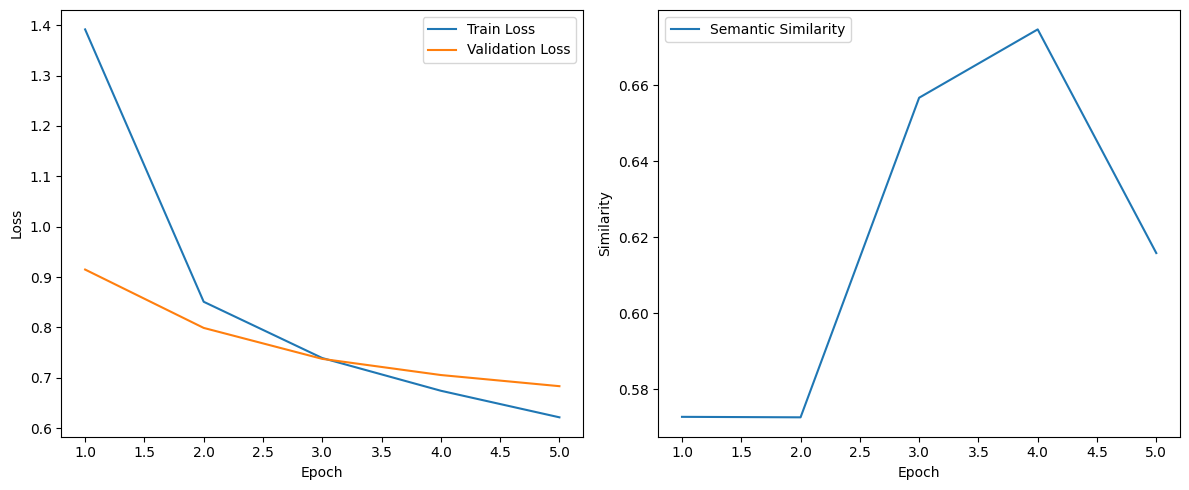

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]


========== TEST RESULTS ==========
Test Loss          : 0.7833
Test Semantic Sim  : 0.5709

===== RANDOM TEST EXAMPLES =====

--- Example 63 ---
Raw Report       : 
[ Finding ]_x000D_
both accessory navicular bone, type II_x000D_
degenerative change, both feet._x000D_
[ Conclusion ]_x000D_
both accessory navicular bone, type II_x000D_
degenerative change, both feet._x000D_
[ Recommend ]_x000D_

Cleaned Report   : 
both accessory navicular bone, type II degenerative change, both feet. <|endoftext|>
Generated Report : 
both hallux valgus. 

--- Example 41 ---
Raw Report       : 
[FINDING       ]_x000D_diffuse osteopenia
degenerative change_x000D__x000D_[CONCLUSION    ]_x000D_diffuse osteopenia
degenerative change_x000D__x000D_[RECOMMENDATION]_x000D_-
Cleaned Report   : 
diffuse osteopenia degenerative change <|endoftext|>
Generated Report : 
diffuse osteopenia degenerative change 

--- Example 51 ---
Raw Report       : 
[ Finding ]_x000D_
osteopenia._x000D_
degenerative change._x000D_
o

In [2]:
import os
import re
import json
import logging
import unicodedata
import random
from collections import defaultdict, Counter

import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import timm
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)

# =============================================================================
# Utility functions
# =============================================================================

def count_labels(data, target_classes, cfg):
    class_counts = defaultdict(int)
    data_by_class = defaultdict(list)
    for entry in tqdm(data.values(), desc="Counting dataset"):
        lbl = entry.get('class_label', '').lower()
        if lbl in target_classes and os.path.exists(entry['file_path']):
            class_counts[lbl] += 1
            data_by_class[lbl].append(entry)
    return class_counts, data_by_class

def prepare_abnormal_normal_data(data, cfg):
    random.seed(42)
    abnormal = ['ra', 'oa', 'gout']
    normal = ['normal']
    class_counts, data_by_class = count_labels(data, abnormal + normal, cfg)
    combined = {
        'abnormal': sum((data_by_class[c] for c in abnormal), []),
        'normal': data_by_class['normal']
    }
    combined_counts = {
        'abnormal': sum(class_counts[c] for c in abnormal),
        'normal': class_counts['normal']
    }
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(combined.values(), []), combined_counts, combined_counts
    min_count = min(combined_counts.values())
    balanced = []
    final_counts = {}
    for lbl, items in combined.items():
        sampled = random.sample(items, min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    if cfg.DATASET.AUGMENT:
        balanced *= 2
    return balanced, combined_counts, final_counts

def prepare_data(data, target_classes, cfg, is_binary=False):
    random.seed(42)
    if len(target_classes) == 2 and 'abnormal' in target_classes and 'normal' in target_classes:
        logging.info("Using abnormal-vs-normal logic")
        return prepare_abnormal_normal_data(data, cfg)
    class_counts, data_by_class = count_labels(data, target_classes, cfg)
    logging.info(f"Original class distribution: {class_counts}")
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(data_by_class.values(), []), class_counts, class_counts
    min_count = min(class_counts.values())
    balanced, final_counts = [], {}
    for lbl in target_classes:
        sampled = random.sample(data_by_class[lbl], min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    logging.info(f"Balanced class distribution: {final_counts}")
    if cfg.DATASET.AUGMENT:
        balanced *= 2
    return balanced, class_counts, final_counts

# =============================================================================
# Transforms
# =============================================================================

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

patch_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

# =============================================================================
# Dataset
# =============================================================================

class FinalSamplesDataset(Dataset):
    def __init__(self, cfg, image_transform=train_transform, patch_transform=patch_transform):
        self.cfg = cfg
        self.image_transform = image_transform
        self.patch_transform = patch_transform

        self.target_classes = cfg.DATASET.TARGET_CLASSES
        if isinstance(self.target_classes, str):
            self.target_classes = self.target_classes.split(",")

        self.is_binary = len(self.target_classes) == 2
        self.abnormal_classify = self.is_binary and 'abnormal' in self.target_classes
        self.abnormal_mapping = (
            {'ra': 'abnormal', 'oa': 'abnormal', 'gout': 'abnormal', 'normal': 'normal'}
            if self.abnormal_classify else None
        )

        with open(cfg.DATASET.JSON, 'r') as f:
            raw_list = json.load(f)

        filtered = []
        for item in raw_list:
            merged = item.get('merged_image_path', '')
            fp = item.get('file_paths', [])
            if isinstance(fp, str):
                fp = [fp]
            paths = [merged] + fp
            if any(os.path.exists(p) for p in paths):
                filtered.append((merged, fp, item))

        self.data = {}
        for i, (merged, fp, item) in enumerate(filtered):
            cls = item.get('class', 'unknown').lower()
            if self.abnormal_mapping:
                cls = self.abnormal_mapping.get(cls, cls)
            self.data[i] = {
                'file_path': merged,
                'left_right_file_path': fp,
                'class_label': cls,
                'diagnosis': item.get('diagnosis', ''),
                'keypoints': item.get('keypoints', {})
            }

        if self.is_binary:
            balanced, _, _ = prepare_data(self.data, self.target_classes, cfg, True)
            self.data = {i: e for i, e in enumerate(balanced)}

        self.eos_token = None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        e = self.data[idx]
        img = Image.open(e['file_path']).convert('RGB')
        img = self.image_transform(img)

        patches = self._gen_patches(e['left_right_file_path'], e['keypoints'])
        pt = [self.patch_transform(Image.fromarray(p)) for p in patches]
        patches_tensor = torch.stack(pt, 0) if pt else torch.zeros(34, 3, 112, 112)

        raw = e.get('diagnosis', '')
        clean = self._clean_report(raw)
        tok = tokenizer(clean, truncation=True, max_length=512, return_tensors='pt')

        return {
            'full_img': img,
            'patches': patches_tensor,
            'raw_report': raw,
            'cleaned_report': clean,
            'input_ids': tok['input_ids'].squeeze(0),
            'attention_mask': tok['attention_mask'].squeeze(0)
        }

    def _gen_patches(self, paths, kps_dict, crop_size=(200, 300), patch_size=(112, 112)):
        def extract(arr, side_kps):
            lst = []
            pts = side_kps[0]['keypoints']
            for i in range(17):
                x, y, s = int(pts[3*i]), int(pts[3*i+1]), pts[3*i+2]
                if s > 0:
                    x0 = max(x - crop_size[0]//2, 0)
                    y0 = max(y - crop_size[1]//2, 0)
                    x1 = min(x + crop_size[0]//2, arr.shape[1])
                    y1 = min(y + crop_size[1]//2, arr.shape[0])
                    c = arr[y0:y1, x0:x1]
                    if c.size:
                        lst.append(cv2.resize(c, patch_size))
            return lst

        def pad17(lst):
            black = np.zeros((patch_size[1], patch_size[0], 3), np.uint8)
            while len(lst) < 17:
                lst.append(black)
            return lst[:17]

        left, right = [], []
        if len(paths) == 1:
            pth = paths[0]
            if not pth or not os.path.exists(pth):
                return pad17([]) + pad17([])
            img_arr = cv2.imread(pth)
            if img_arr is None:
                return pad17([]) + pad17([])
            arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
            if kps_dict.get('left'): left = extract(arr, kps_dict['left'])
            if kps_dict.get('right'): right = extract(arr, kps_dict['right'])
        else:
            for side, pth in zip(['left', 'right'], paths):
                if pth and os.path.exists(pth):
                    img_arr = cv2.imread(pth)
                    if img_arr is not None:
                        arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
                        if kps_dict.get(side):
                            lst = extract(arr, kps_dict[side])
                            if side == 'left': left = lst
                            else: right = lst

        if left and not right:
            right = [cv2.flip(p, 1) for p in left]
        if right and not left:
            left = [cv2.flip(p, 1) for p in right]
        if not left and not right:
            return pad17([]) + pad17([])

        return pad17(left) + pad17(right)

    def _clean_report(self, text):
        text = unicodedata.normalize('NFKC', text or '')
        text = re.sub(r'(?m)^-+\s*$', '', text)
        text = re.sub(r'[^\x00-\x7F]+', ' ', text)
        text = re.sub(r'([.!?]){2,}', r'\1', text)
        text = re.sub(r'\[\s*finding\s*\]', '[FINDING]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*conclusion\s*\]', '[CONCLUSION]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*diagnosis\s*\]', '[DIAGNOSIS]', text, flags=re.IGNORECASE)
        parts = re.split(r'\[\s*recommend(?:ation)?\s*\]', text, flags=re.IGNORECASE)
        text = parts[0]
        fm = re.search(r'\[FINDING\](.*?)(?=\[|$)', text, flags=re.IGNORECASE | re.DOTALL)
        cm = re.search(r'\[CONCLUSION\](.*?)(?=\[|$)', text, flags=re.IGNORECASE | re.DOTALL)
        if fm and cm and fm.group(1).strip().lower() == cm.group(1).strip().lower():
            text = re.sub(r'\[CONCLUSION\].*?(?=\[|$)', '', text, flags=re.IGNORECASE | re.DOTALL)
        text = re.sub(r'\[\s*(FINDING|CONCLUSION|DIAGNOSIS)\s*\]', '', text, flags=re.IGNORECASE)
        text = text.replace('_x000D_', ' ')
        text = re.sub(r'\s+', ' ', text).strip()
        if text and not text.endswith(self.eos_token):
            text += ' ' + self.eos_token
        return text

# =============================================================================
# Collate function
# =============================================================================

def collate_fn(batch):
    imgs = torch.stack([b['full_img'] for b in batch])
    pts = [b['patches'] for b in batch]
    max_p = max(p.shape[0] for p in pts)
    pads = []
    for p in pts:
        if p.shape[0] < max_p:
            pad = torch.zeros((max_p - p.shape[0], *p.shape[1:]))
            p = torch.cat([p, pad], dim=0)
        pads.append(p)
    patches = torch.stack(pads, 0)

    ids = [b['input_ids'] for b in batch]
    masks = [b['attention_mask'] for b in batch]
    ids = nn.utils.rnn.pad_sequence(ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    masks = nn.utils.rnn.pad_sequence(masks, batch_first=True, padding_value=0)

    return {
        'full_imgs': imgs,
        'patches': patches,
        'input_ids': ids,
        'attention_mask': masks,
        'raw_reports': [b['raw_report'] for b in batch],
        'cleaned_reports': [b['cleaned_report'] for b in batch]
    }

# =============================================================================
# Model
# =============================================================================

class MultiModalModel(nn.Module):
    def __init__(self, gpt2_model_name='gpt2'):
        super().__init__()
        self.global_encoder = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
        self.global_encoder.reset_classifier(0)
        self.global_proj = nn.Linear(self.global_encoder.num_features, 768)

        self.patch_encoder = timm.create_model('resnet50', pretrained=True)
        self.patch_encoder.fc = nn.Identity()
        self.patch_proj = nn.Linear(self.patch_encoder.num_features, 768)

        self.attn = nn.MultiheadAttention(embed_dim=768, num_heads=8, batch_first=True)
        self.norm = nn.LayerNorm(768)

        self.decoder = GPT2LMHeadModel.from_pretrained(gpt2_model_name, add_cross_attention=True)

    def _pool(self, feats):
        return feats.mean(dim=[2, 3]) if feats.ndim > 2 else feats

    def forward(self, imgs, patches, input_ids, attention_mask, decoder_labels=None):
        g = self.global_encoder(imgs)
        g = self.global_proj(g).unsqueeze(1)

        B, N, C, H, W = patches.shape
        p = patches.view(B * N, C, H, W)
        pf = (self.patch_encoder.forward_features(p)
              if hasattr(self.patch_encoder, 'forward_features')
              else self.patch_encoder(p))
        pf = self._pool(pf)
        pf = self.patch_proj(pf)
        pf = pf.view(B, N, 768)

        cat = torch.cat([g, pf], dim=1)
        comb, _ = self.attn(cat, cat, cat)
        comb = self.norm(comb)

        return self.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=comb,
            labels=decoder_labels
        )

# =============================================================================
# Train / Eval helpers
# =============================================================================

def train_epoch(model, loader, optimizer, scaler, device):
    model.train()
    total_loss = 0.0
    for b in tqdm(loader, desc="Training", leave=False):
        imgs = b['full_imgs'].to(device)
        pts = b['patches'].to(device)
        ids = b['input_ids'].to(device)
        msk = b['attention_mask'].to(device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            loss = out.loss
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.0
    all_gen, all_gt = [], []

    for b in tqdm(loader, desc="Evaluating", leave=False):
        imgs = b['full_imgs'].to(device)
        pts = b['patches'].to(device)
        ids = b['input_ids'].to(device)
        msk = b['attention_mask'].to(device)

        with torch.no_grad():
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            total_loss += out.loss.item()

            prompt = ids[:, :1]
            g = model.global_encoder(imgs)
            g = model.global_proj(g).unsqueeze(1)

            B, N, C, H, W = pts.shape
            p = pts.view(B * N, C, H, W)
            pf = model.patch_encoder(p)
            pf = model._pool(pf)
            pf = model.patch_proj(pf)
            pf = pf.view(B, N, 768)

            cat = torch.cat([g, pf], dim=1)
            comb, _ = model.attn(cat, cat, cat)
            comb = model.norm(comb)
            gen_ids = model.decoder.generate(
                input_ids=prompt,
                encoder_hidden_states=comb,
                attention_mask=torch.ones_like(prompt),
                max_length=100,
                num_beams=5,              # use beam search
                early_stopping=True,
                no_repeat_ngram_size=3,   # avoid trivial repeats
                eos_token_id=tokenizer.eos_token_id,
                pad_token_id=tokenizer.eos_token_id
           )


            gen_txt = [tokenizer.decode(g_, skip_special_tokens=True) for g_ in gen_ids]
            gt_txt = [tokenizer.decode(i_, skip_special_tokens=True) for i_ in ids]
            all_gen.extend(gen_txt)
            all_gt.extend(gt_txt)

    return total_loss / len(loader), all_gen, all_gt

def compute_semantic_similarity(gen, gt):
    stm = SentenceTransformer('all-MiniLM-L6-v2')
    e1 = stm.encode(gen, convert_to_tensor=True)
    e2 = stm.encode(gt, convert_to_tensor=True)
    return nn.functional.cosine_similarity(e1, e2).mean().item()

def plot_metrics(train_losses, val_losses, sems):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, sems, label="Semantic Similarity")
    plt.xlabel("Epoch")
    plt.ylabel("Similarity")
    plt.legend()

    plt.tight_layout()
    plt.show()

# =============================================================================
# MAIN
# =============================================================================

class Cfg: pass
cfg = Cfg()
cfg.DATASET = Cfg()
cfg.DATASET.JSON = 'final_samples_both_only_v2.json'
cfg.DATASET.USE_RAW = True
cfg.DATASET.USE_PATCH = True
cfg.DATASET.REPORT = True
cfg.DATASET.TARGET_CLASSES = ['ra', 'oa', 'gout', 'normal', 'uncertain', 'ref.prev']
cfg.DATASET.BALANCE = False
cfg.DATASET.AUGMENT = False

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

dataset = FinalSamplesDataset(cfg)
dataset.eos_token = tokenizer.eos_token

dist = Counter(e['class_label'] for e in dataset.data.values())
print("\nDataset class distribution:")
for cls, cnt in dist.items():
    print(f"  {cls}: {cnt}")

# split into train / val / test
n = len(dataset)
n_train = int(0.8 * n)
n_val = int(0.1 * n)
n_test = n - n_train - n_val

train_ds, val_ds, test_ds = random_split(dataset, [n_train, n_val, n_test])

# print sample counts
print(f"\nNumber of training samples:   {len(train_ds)}")
print(f"Number of validation samples: {len(val_ds)}")
print(f"Number of test samples:       {len(test_ds)}")
print(f"Total samples:                {len(train_ds) + len(val_ds) + len(test_ds)}\n")

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_ds, batch_size=4, shuffle=False, collate_fn=collate_fn)

model = MultiModalModel().to(device)
optimizer = optim.AdamW(model.parameters(), lr=3e-5, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
scaler = torch.cuda.amp.GradScaler()

num_epochs = 5
train_losses, val_losses, sems = [], [], []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    train_loss = train_epoch(model, train_loader, optimizer, scaler, device)
    val_loss, gen_txt, gt_txt = evaluate(model, val_loader, device)
    sem = compute_semantic_similarity(gen_txt, gt_txt)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    sems.append(sem)

    print(f"  Train Loss          : {train_loss:.4f}")
    print(f"  Validation Loss     : {val_loss:.4f}")
    print(f"  Semantic Similarity : {sem:.4f}")
    scheduler.step()

plot_metrics(train_losses, val_losses, sems)

test_loss, test_gen, test_gt = evaluate(model, test_loader, device)
test_sem = compute_semantic_similarity(test_gen, test_gt)

print("\n========== TEST RESULTS ==========")
print(f"Test Loss          : {test_loss:.4f}")
print(f"Test Semantic Sim  : {test_sem:.4f}")

print("\n===== RANDOM TEST EXAMPLES =====")
for idx in random.sample(range(len(test_ds)), min(10, len(test_ds))):
    ex = test_ds[idx]
    raw = ex['raw_report']
    clean = ex['cleaned_report']
    fi = ex['full_img'].unsqueeze(0).to(device)
    pa = ex['patches'].unsqueeze(0).to(device)
    prompt = ex['input_ids'][:1].unsqueeze(0).to(device)

    g = model.global_encoder(fi)
    g = model.global_proj(g).unsqueeze(1)
    B, N, C, H, W = pa.shape
    p = pa.view(B * N, C, H, W)
    pf = model.patch_encoder(p)
    pf = model._pool(pf)
    pf = model.patch_proj(pf)
    pf = pf.view(B, N, 768)

    cat = torch.cat([g, pf], dim=1)
    comb, _ = model.attn(cat, cat, cat)
    comb = model.norm(comb)

    gen_ids = model.decoder.generate(
        input_ids=prompt,
        encoder_hidden_states=comb,
        attention_mask=torch.ones_like(prompt),
        max_length=120,
        num_beams=5,
        early_stopping=True,
        no_repeat_ngram_size=3,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id
    )

    gen = tokenizer.decode(gen_ids[0], skip_special_tokens=True)

    print(f"\n--- Example {idx} ---")
    print(f"Raw Report       : \n{raw}")
    print(f"Cleaned Report   : \n{clean}")
    print(f"Generated Report : \n{gen}")




2025-05-06 12:27:59.393971: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-06 12:27:59.400715: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746559679.408429   29687 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746559679.410798   29687 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746559679.416927   29687 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Using device: cuda

Dataset class distribution:
  oa: 573
  ra: 115
  uncertain: 620
  oa, ra: 8
  normal: 748
  gout: 267
  combination of oa, ra: 3
  ref.prev: 60

Number of training samples:   1915
Number of validation samples: 239
Number of test samples:       240
Total samples:                2394



INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/swin_base_patch4_window7_224.ms_in22k_ft_in1k)
INFO:timm.models._hub:[timm/swin_base_patch4_window7_224.ms_in22k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/resnet50.a1_in1k)
INFO:timm.models._hub:[timm/resnet50.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossatten


Epoch 1/5


Training:   0%|          | 0/479 [00:00<?, ?it/s]/tmp/ipykernel_29687/2799820574.py:347: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluating:  98%|█████████▊| 59/60 [00:15<00:00,  3.73it/s]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.4324
  Validation Loss     : 0.9134
  Semantic Similarity : 0.4142

Epoch 2/5


Evaluating:  98%|█████████▊| 59/60 [00:17<00:00,  3.37it/s]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.8570
  Validation Loss     : 0.7999
  Semantic Similarity : 0.4006

Epoch 3/5


Evaluating:  98%|█████████▊| 59/60 [00:17<00:00,  3.36it/s]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.7441
  Validation Loss     : 0.7501
  Semantic Similarity : 0.3891

Epoch 4/5


Evaluating:  98%|█████████▊| 59/60 [00:17<00:00,  3.30it/s]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.6683
  Validation Loss     : 0.7221
  Semantic Similarity : 0.3977

Epoch 5/5


Evaluating:  98%|█████████▊| 59/60 [00:16<00:00,  3.40it/s]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.6232
  Validation Loss     : 0.6983
  Semantic Similarity : 0.3572


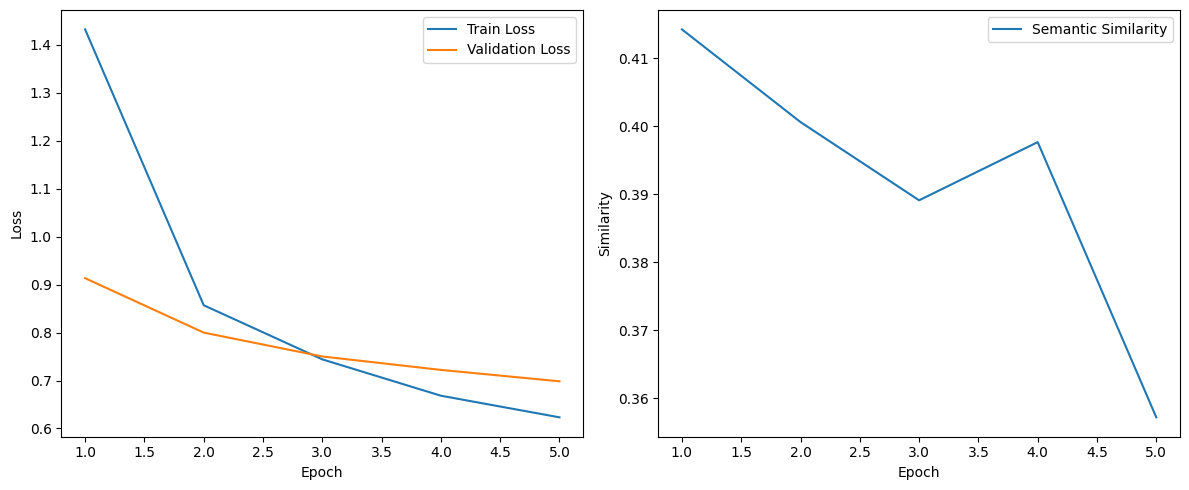

Evaluating:  98%|█████████▊| 59/60 [00:16<00:00,  3.58it/s]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]


========== TEST RESULTS ==========
Test Loss          : 0.6372
Test Semantic Sim  : 0.3645

===== RANDOM TEST EXAMPLES =====

--- Example 47 ---
Raw Report       :
[ Finding ]_x000D_
_x000D_
_x000D_
[ Diagnosis ]_x000D_
probable fracture with callus formation in right 2nd metatarsal shaft._x000D_
no change of other findings since last study._x000D_
[ Recommend ]_x000D_

Cleaned Report   :
probable fracture with callus formation in right 2nd metatarsal shaft. no change of other findings since last study. <|endoftext|>
Generated Report :
 bony abnormality. 

--- Example 70 ---
Raw Report       :
[FINDING       ]_x000D_-_x000D__x000D_[CONCLUSION    ]_x000D_soft tissue swelling around Rt 1st IP joint 
accessory navicular bone with erosions at Rt 
-> r/o gout involvement 

mild degenerative change_x000D__x000D_[RECOMMENDATION]_x000D_-
Cleaned Report   :
- soft tissue swelling around Rt 1st IP joint accessory navicular bone with erosions at Rt -> r/o gout involvement mild degenerative chang

In [1]:
import os
import re
import json
import logging
import unicodedata
import random
from collections import defaultdict, Counter

import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import timm
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)

# =============================================================================
# Utility functions
# =============================================================================

def count_labels(data, target_classes, cfg):
    class_counts = defaultdict(int)
    data_by_class = defaultdict(list)
    for entry in tqdm(data.values(), desc="Counting dataset"):
        lbl = entry.get('class_label', '').lower()
        if lbl in target_classes and os.path.exists(entry['file_path']):
            class_counts[lbl] += 1
            data_by_class[lbl].append(entry)
    return class_counts, data_by_class

def prepare_abnormal_normal_data(data, cfg):
    random.seed(42)
    abnormal = ['ra', 'oa', 'gout']
    normal = ['normal']
    class_counts, data_by_class = count_labels(data, abnormal + normal, cfg)
    combined = {
        'abnormal': sum((data_by_class[c] for c in abnormal), []),
        'normal': data_by_class['normal']
    }
    combined_counts = {
        'abnormal': sum(class_counts[c] for c in abnormal),
        'normal': class_counts['normal']
    }
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(combined.values(), []), combined_counts, combined_counts
    min_count = min(combined_counts.values())
    balanced = []
    final_counts = {}
    for lbl, items in combined.items():
        sampled = random.sample(items, min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    if cfg.DATASET.AUGMENT:
        balanced *= 2
    return balanced, combined_counts, final_counts

def prepare_data(data, target_classes, cfg, is_binary=False):
    random.seed(42)
    if len(target_classes) == 2 and 'abnormal' in target_classes and 'normal' in target_classes:
        logging.info("Using abnormal-vs-normal logic")
        return prepare_abnormal_normal_data(data, cfg)
    class_counts, data_by_class = count_labels(data, target_classes, cfg)
    logging.info(f"Original class distribution: {class_counts}")
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(data_by_class.values(), []), class_counts, class_counts
    min_count = min(class_counts.values())
    balanced, final_counts = [], {}
    for lbl in target_classes:
        sampled = random.sample(data_by_class[lbl], min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    logging.info(f"Balanced class distribution: {final_counts}")
    if cfg.DATASET.AUGMENT:
        balanced *= 2
    return balanced, class_counts, final_counts

# =============================================================================
# Transforms
# =============================================================================

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

patch_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

# =============================================================================
# Dataset
# =============================================================================

class FinalSamplesDataset(Dataset):
    def __init__(self, cfg, image_transform=train_transform, patch_transform=patch_transform):
        self.cfg = cfg
        self.image_transform = image_transform
        self.patch_transform = patch_transform

        self.target_classes = cfg.DATASET.TARGET_CLASSES
        if isinstance(self.target_classes, str):
            self.target_classes = self.target_classes.split(",")

        self.is_binary = len(self.target_classes) == 2
        self.abnormal_classify = self.is_binary and 'abnormal' in self.target_classes
        self.abnormal_mapping = (
            {'ra': 'abnormal', 'oa': 'abnormal', 'gout': 'abnormal', 'normal': 'normal'}
            if self.abnormal_classify else None
        )

        with open(cfg.DATASET.JSON, 'r') as f:
            raw_list = json.load(f)

        filtered = []
        for item in raw_list:
            merged = item.get('merged_image_path', '')
            fp = item.get('file_paths', [])
            if isinstance(fp, str):
                fp = [fp]
            paths = [merged] + fp
            if any(os.path.exists(p) for p in paths):
                filtered.append((merged, fp, item))

        self.data = {}
        for i, (merged, fp, item) in enumerate(filtered):
            cls = item.get('class', 'unknown').lower()
            if self.abnormal_mapping:
                cls = self.abnormal_mapping.get(cls, cls)
            self.data[i] = {
                'file_path': merged,
                'left_right_file_path': fp,
                'class_label': cls,
                'diagnosis': item.get('diagnosis', ''),
                'keypoints': item.get('keypoints', {})
            }

        if self.is_binary:
            balanced, _, _ = prepare_data(self.data, self.target_classes, cfg, True)
            self.data = {i: e for i, e in enumerate(balanced)}

        self.eos_token = None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        e = self.data[idx]
        img = Image.open(e['file_path']).convert('RGB')
        img = self.image_transform(img)

        patches = self._gen_patches(e['left_right_file_path'], e['keypoints'])
        pt = [self.patch_transform(Image.fromarray(p)) for p in patches]
        patches_tensor = torch.stack(pt, 0) if pt else torch.zeros(34, 3, 112, 112)

        raw = e.get('diagnosis', '')
        clean = self._clean_report(raw)
        tok = tokenizer(clean, truncation=True, max_length=512, return_tensors='pt')

        return {
            'full_img': img,
            'patches': patches_tensor,
            'raw_report': raw,
            'cleaned_report': clean,
            'input_ids': tok['input_ids'].squeeze(0),
            'attention_mask': tok['attention_mask'].squeeze(0)
        }

    def _gen_patches(self, paths, kps_dict, crop_size=(200, 300), patch_size=(112, 112)):
        def extract(arr, side_kps):
            lst = []
            pts = side_kps[0]['keypoints']
            for i in range(17):
                x, y, s = int(pts[3*i]), int(pts[3*i+1]), pts[3*i+2]
                if s > 0:
                    x0 = max(x - crop_size[0]//2, 0)
                    y0 = max(y - crop_size[1]//2, 0)
                    x1 = min(x + crop_size[0]//2, arr.shape[1])
                    y1 = min(y + crop_size[1]//2, arr.shape[0])
                    c = arr[y0:y1, x0:x1]
                    if c.size:
                        lst.append(cv2.resize(c, patch_size))
            return lst

        def pad17(lst):
            black = np.zeros((patch_size[1], patch_size[0], 3), np.uint8)
            while len(lst) < 17:
                lst.append(black)
            return lst[:17]

        left, right = [], []
        if len(paths) == 1:
            pth = paths[0]
            if not pth or not os.path.exists(pth):
                return pad17([]) + pad17([])
            img_arr = cv2.imread(pth)
            if img_arr is None:
                return pad17([]) + pad17([])
            arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
            if kps_dict.get('left'): left = extract(arr, kps_dict['left'])
            if kps_dict.get('right'): right = extract(arr, kps_dict['right'])
        else:
            for side, pth in zip(['left', 'right'], paths):
                if pth and os.path.exists(pth):
                    img_arr = cv2.imread(pth)
                    if img_arr is not None:
                        arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
                        if kps_dict.get(side):
                            lst = extract(arr, kps_dict[side])
                            if side == 'left': left = lst
                            else: right = lst

        if left and not right:
            right = [cv2.flip(p, 1) for p in left]
        if right and not left:
            left = [cv2.flip(p, 1) for p in right]
        if not left and not right:
            return pad17([]) + pad17([])

        return pad17(left) + pad17(right)

    def _clean_report(self, text):
        text = unicodedata.normalize('NFKC', text or '')
        text = re.sub(r'(?m)^-+\s*$', '', text)
        text = re.sub(r'[^\x00-\x7F]+', ' ', text)
        text = re.sub(r'([.!?]){2,}', r'\1', text)
        text = re.sub(r'\[\s*finding\s*\]', '[FINDING]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*conclusion\s*\]', '[CONCLUSION]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*diagnosis\s*\]', '[DIAGNOSIS]', text, flags=re.IGNORECASE)
        parts = re.split(r'\[\s*recommend(?:ation)?\s*\]', text, flags=re.IGNORECASE)
        text = parts[0]
        fm = re.search(r'\[FINDING\](.*?)(?=\[|$)', text, flags=re.IGNORECASE | re.DOTALL)
        cm = re.search(r'\[CONCLUSION\](.*?)(?=\[|$)', text, flags=re.IGNORECASE | re.DOTALL)
        if fm and cm and fm.group(1).strip().lower() == cm.group(1).strip().lower():
            text = re.sub(r'\[CONCLUSION\].*?(?=\[|$)', '', text, flags=re.IGNORECASE | re.DOTALL)
        text = re.sub(r'\[\s*(FINDING|CONCLUSION|DIAGNOSIS)\s*\]', '', text, flags=re.IGNORECASE)
        text = text.replace('_x000D_', ' ')
        text = re.sub(r'\s+', ' ', text).strip()
        if text and not text.endswith(self.eos_token):
            text += ' ' + self.eos_token
        return text

# =============================================================================
# Collate function
# =============================================================================

def collate_fn(batch):
    imgs = torch.stack([b['full_img'] for b in batch])
    pts = [b['patches'] for b in batch]
    max_p = max(p.shape[0] for p in pts)
    pads = []
    for p in pts:
        if p.shape[0] < max_p:
            pad = torch.zeros((max_p - p.shape[0], *p.shape[1:]))
            p = torch.cat([p, pad], dim=0)
        pads.append(p)
    patches = torch.stack(pads, 0)

    ids = [b['input_ids'] for b in batch]
    masks = [b['attention_mask'] for b in batch]
    ids = nn.utils.rnn.pad_sequence(ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    masks = nn.utils.rnn.pad_sequence(masks, batch_first=True, padding_value=0)

    return {
        'full_imgs': imgs,
        'patches': patches,
        'input_ids': ids,
        'attention_mask': masks,
        'raw_reports': [b['raw_report'] for b in batch],
        'cleaned_reports': [b['cleaned_report'] for b in batch]
    }

# =============================================================================
# Model
# =============================================================================

class MultiModalModel(nn.Module):
    def __init__(self, gpt2_model_name='gpt2'):
        super().__init__()
        self.global_encoder = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
        self.global_encoder.reset_classifier(0)
        self.global_proj = nn.Linear(self.global_encoder.num_features, 768)

        self.patch_encoder = timm.create_model('resnet50', pretrained=True)
        self.patch_encoder.fc = nn.Identity()
        self.patch_proj = nn.Linear(self.patch_encoder.num_features, 768)

        self.attn = nn.MultiheadAttention(embed_dim=768, num_heads=8, batch_first=True)
        self.norm = nn.LayerNorm(768)

        self.decoder = GPT2LMHeadModel.from_pretrained(gpt2_model_name, add_cross_attention=True)

    def _pool(self, feats):
        return feats.mean(dim=[2, 3]) if feats.ndim > 2 else feats

    def forward(self, imgs, patches, input_ids, attention_mask, decoder_labels=None):
        g = self.global_encoder(imgs)
        g = self.global_proj(g).unsqueeze(1)

        B, N, C, H, W = patches.shape
        p = patches.view(B * N, C, H, W)
        pf = (self.patch_encoder.forward_features(p)
              if hasattr(self.patch_encoder, 'forward_features')
              else self.patch_encoder(p))
        pf = self._pool(pf)
        pf = self.patch_proj(pf)
        pf = pf.view(B, N, 768)

        cat = torch.cat([g, pf], dim=1)
        comb, _ = self.attn(cat, cat, cat)
        comb = self.norm(comb)

        return self.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=comb,
            labels=decoder_labels
        )

# =============================================================================
# Train / Eval helpers
# =============================================================================

def train_epoch(model, loader, optimizer, scaler, device):
    model.train()
    total_loss = 0.0
    for b in tqdm(loader, desc="Training", leave=False):
        imgs = b['full_imgs'].to(device)
        pts = b['patches'].to(device)
        ids = b['input_ids'].to(device)
        msk = b['attention_mask'].to(device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            loss = out.loss
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.0
    all_gen, all_gt = [], []

    for b in tqdm(loader, desc="Evaluating", leave=False):
        imgs = b['full_imgs'].to(device)
        pts = b['patches'].to(device)
        ids = b['input_ids'].to(device)
        msk = b['attention_mask'].to(device)

        with torch.no_grad():
            # compute loss against ground truth
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            total_loss += out.loss.item()

            # build an empty "start" prompt (just the eos_token) for generation
            B = imgs.size(0)
            start_token = tokenizer.eos_token_id
            prompt = torch.full((B, 1), start_token, dtype=torch.long, device=device)

            # re-encode for cross-attention
            g = model.global_encoder(imgs)
            g = model.global_proj(g).unsqueeze(1)
            p = pts.view(B * pts.size(1), pts.size(2), pts.size(3), pts.size(4))
            pf = model._pool(model.patch_encoder(p))
            pf = model.patch_proj(pf).view(B, pts.size(1), 768)
            cat = torch.cat([g, pf], dim=1)
            comb, _ = model.attn(cat, cat, cat)
            comb = model.norm(comb)

            # generate without any reference tokens
            gen_ids = model.decoder.generate(
                input_ids=prompt,
                encoder_hidden_states=comb,
                attention_mask=torch.ones_like(prompt),
                max_length=100,
                num_beams=5,
                early_stopping=True,
                no_repeat_ngram_size=3,
                eos_token_id=start_token,
                pad_token_id=start_token
            )

            gen_txt = [tokenizer.decode(g_, skip_special_tokens=True) for g_ in gen_ids]
            gt_txt = [tokenizer.decode(i_, skip_special_tokens=True) for i_ in ids]
            all_gen.extend(gen_txt)
            all_gt.extend(gt_txt)

    return total_loss / len(loader), all_gen, all_gt

def compute_semantic_similarity(gen, gt):
    stm = SentenceTransformer('all-MiniLM-L6-v2')
    e1 = stm.encode(gen, convert_to_tensor=True)
    e2 = stm.encode(gt, convert_to_tensor=True)
    return nn.functional.cosine_similarity(e1, e2).mean().item()

def plot_metrics(train_losses, val_losses, sems):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, sems, label="Semantic Similarity")
    plt.xlabel("Epoch")
    plt.ylabel("Similarity")
    plt.legend()

    plt.tight_layout()
    plt.show()

# =============================================================================
# MAIN
# =============================================================================

class Cfg: pass
cfg = Cfg()
cfg.DATASET = Cfg()
cfg.DATASET.JSON = 'final_samples_both_only_v2.json'
cfg.DATASET.USE_RAW = True
cfg.DATASET.USE_PATCH = True
cfg.DATASET.REPORT = True
cfg.DATASET.TARGET_CLASSES = ['ra', 'oa', 'gout', 'normal', 'uncertain', 'ref.prev']
cfg.DATASET.BALANCE = False
cfg.DATASET.AUGMENT = False

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

dataset = FinalSamplesDataset(cfg)
dataset.eos_token = tokenizer.eos_token

dist = Counter(e['class_label'] for e in dataset.data.values())
print("\nDataset class distribution:")
for cls, cnt in dist.items():
    print(f"  {cls}: {cnt}")

# split into train / val / test
n = len(dataset)
n_train = int(0.8 * n)
n_val = int(0.1 * n)
n_test = n - n_train - n_val

train_ds, val_ds, test_ds = random_split(dataset, [n_train, n_val, n_test])

print(f"\nNumber of training samples:   {len(train_ds)}")
print(f"Number of validation samples: {len(val_ds)}")
print(f"Number of test samples:       {len(test_ds)}")
print(f"Total samples:                {len(train_ds)+len(val_ds)+len(test_ds)}\n")

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds,  batch_size=4, shuffle=False, collate_fn=collate_fn)

model     = MultiModalModel().to(device)
optimizer = optim.AdamW(model.parameters(), lr=3e-5, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
scaler    = torch.cuda.amp.GradScaler()

num_epochs = 5
train_losses, val_losses, sems = [], [], []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train_loss = train_epoch(model, train_loader, optimizer, scaler, device)
    val_loss, gen_txt, gt_txt = evaluate(model, val_loader, device)
    sem = compute_semantic_similarity(gen_txt, gt_txt)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    sems.append(sem)

    print(f"  Train Loss          : {train_loss:.4f}")
    print(f"  Validation Loss     : {val_loss:.4f}")
    print(f"  Semantic Similarity : {sem:.4f}")
    scheduler.step()

plot_metrics(train_losses, val_losses, sems)

# final test—again only the eos token as prompt
test_loss, test_gen, test_gt = evaluate(model, test_loader, device)
test_sem = compute_semantic_similarity(test_gen, test_gt)

print("\n========== TEST RESULTS ==========")
print(f"Test Loss          : {test_loss:.4f}")
print(f"Test Semantic Sim  : {test_sem:.4f}")

print("\n===== RANDOM TEST EXAMPLES =====")
for idx in random.sample(range(len(test_ds)), min(10, len(test_ds))):
    ex = test_ds[idx]
    raw   = ex['raw_report']
    clean = ex['cleaned_report']
    fi    = ex['full_img'].unsqueeze(0).to(device)
    pa    = ex['patches'].unsqueeze(0).to(device)

    # only a single eos token as decoder prompt
    prompt = torch.tensor([[tokenizer.eos_token_id]], dtype=torch.long, device=device)

    # encode image + patches
    g = model.global_encoder(fi)
    g = model.global_proj(g).unsqueeze(1)
    B, N, C, H, W = pa.shape
    p = pa.view(B * N, C, H, W)
    pf = model.patch_encoder(p)
    pf = model._pool(pf)
    pf = model.patch_proj(pf).view(B, N, 768)

    cat, _ = model.attn(torch.cat([g, pf], dim=1),
                        torch.cat([g, pf], dim=1),
                        torch.cat([g, pf], dim=1))
    comb = model.norm(cat)

    gen_ids = model.decoder.generate(
        input_ids=prompt,
        encoder_hidden_states=comb,
        attention_mask=torch.ones_like(prompt),
        max_length=120,
        num_beams=5,
        early_stopping=True,
        no_repeat_ngram_size=3,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id
    )
    gen = tokenizer.decode(gen_ids[0], skip_special_tokens=True)

    print(f"\n--- Example {idx} ---")
    print(f"Raw Report       :\n{raw}")
    print(f"Cleaned Report   :\n{clean}")
    print(f"Generated Report :\n{gen}")


In [ ]:
import os
import re
import json
import logging
import unicodedata
import random
from collections import defaultdict, Counter

import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import timm
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)

# =============================================================================
# Utility functions
# =============================================================================

def count_labels(data, target_classes, cfg):
    class_counts = defaultdict(int)
    data_by_class = defaultdict(list)
    for entry in tqdm(data.values(), desc="Counting dataset"):
        lbl = entry.get('class_label', '').lower()
        if lbl in target_classes and os.path.exists(entry['file_path']):
            class_counts[lbl] += 1
            data_by_class[lbl].append(entry)
    return class_counts, data_by_class

def prepare_abnormal_normal_data(data, cfg):
    random.seed(42)
    abnormal = ['ra', 'oa', 'gout']
    normal = ['normal']
    class_counts, data_by_class = count_labels(data, abnormal + normal, cfg)
    combined = {
        'abnormal': sum((data_by_class[c] for c in abnormal), []),
        'normal': data_by_class['normal']
    }
    combined_counts = {
        'abnormal': sum(class_counts[c] for c in abnormal),
        'normal': class_counts['normal']
    }
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(combined.values(), []), combined_counts, combined_counts
    min_count = min(combined_counts.values())
    balanced = []
    final_counts = {}
    for lbl, items in combined.items():
        sampled = random.sample(items, min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    if cfg.DATASET.AUGMENT:
        balanced *= 2
    return balanced, combined_counts, final_counts

def prepare_data(data, target_classes, cfg, is_binary=False):
    random.seed(42)
    if len(target_classes) == 2 and 'abnormal' in target_classes and 'normal' in target_classes:
        logging.info("Using abnormal-vs-normal logic")
        return prepare_abnormal_normal_data(data, cfg)
    class_counts, data_by_class = count_labels(data, target_classes, cfg)
    logging.info(f"Original class distribution: {class_counts}")
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(data_by_class.values(), []), class_counts, class_counts
    min_count = min(class_counts.values())
    balanced, final_counts = [], {}
    for lbl in target_classes:
        sampled = random.sample(data_by_class[lbl], min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    logging.info(f"Balanced class distribution: {final_counts}")
    if cfg.DATASET.AUGMENT:
        balanced *= 2
    return balanced, class_counts, final_counts

# =============================================================================
# Transforms
# =============================================================================

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

patch_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

# =============================================================================
# Dataset
# =============================================================================

class FinalSamplesDataset(Dataset):
    def __init__(self, cfg, image_transform=train_transform, patch_transform=patch_transform):
        self.cfg = cfg
        self.image_transform = image_transform
        self.patch_transform = patch_transform

        self.target_classes = cfg.DATASET.TARGET_CLASSES
        if isinstance(self.target_classes, str):
            self.target_classes = self.target_classes.split(",")

        self.is_binary = len(self.target_classes) == 2
        self.abnormal_classify = self.is_binary and 'abnormal' in self.target_classes
        self.abnormal_mapping = (
            {'ra': 'abnormal', 'oa': 'abnormal', 'gout': 'abnormal', 'normal': 'normal'}
            if self.abnormal_classify else None
        )

        with open(cfg.DATASET.JSON, 'r') as f:
            raw_list = json.load(f)

        filtered = []
        for item in raw_list:
            merged = item.get('merged_image_path', '')
            fp = item.get('file_paths', [])
            if isinstance(fp, str):
                fp = [fp]
            paths = [merged] + fp
            if any(os.path.exists(p) for p in paths):
                filtered.append((merged, fp, item))

        self.data = {}
        for i, (merged, fp, item) in enumerate(filtered):
            cls = item.get('class', 'unknown').lower()
            if self.abnormal_mapping:
                cls = self.abnormal_mapping.get(cls, cls)
            self.data[i] = {
                'file_path': merged,
                'left_right_file_path': fp,
                'class_label': cls,
                'diagnosis': item.get('diagnosis', ''),
                'keypoints': item.get('keypoints', {})
            }

        if self.is_binary:
            balanced, _, _ = prepare_data(self.data, self.target_classes, cfg, True)
            self.data = {i: e for i, e in enumerate(balanced)}

        self.eos_token = None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        e = self.data[idx]
        img = Image.open(e['file_path']).convert('RGB')
        img = self.image_transform(img)

        patches = self._gen_patches(e['left_right_file_path'], e['keypoints'])
        pt = [self.patch_transform(Image.fromarray(p)) for p in patches]
        patches_tensor = torch.stack(pt, 0) if pt else torch.zeros(34, 3, 112, 112)

        raw = e.get('diagnosis', '')
        clean = self._clean_report(raw)
        tok = tokenizer(clean, truncation=True, max_length=512, return_tensors='pt')

        return {
            'full_img': img,
            'patches': patches_tensor,
            'raw_report': raw,
            'cleaned_report': clean,
            'input_ids': tok['input_ids'].squeeze(0),
            'attention_mask': tok['attention_mask'].squeeze(0)
        }

    def _gen_patches(self, paths, kps_dict, crop_size=(200, 300), patch_size=(112, 112)):
        def extract(arr, side_kps):
            lst = []
            pts = side_kps[0]['keypoints']
            for i in range(17):
                x, y, s = int(pts[3*i]), int(pts[3*i+1]), pts[3*i+2]
                if s > 0:
                    x0 = max(x - crop_size[0]//2, 0)
                    y0 = max(y - crop_size[1]//2, 0)
                    x1 = min(x + crop_size[0]//2, arr.shape[1])
                    y1 = min(y + crop_size[1]//2, arr.shape[0])
                    c = arr[y0:y1, x0:x1]
                    if c.size:
                        lst.append(cv2.resize(c, patch_size))
            return lst

        def pad17(lst):
            black = np.zeros((patch_size[1], patch_size[0], 3), np.uint8)
            while len(lst) < 17:
                lst.append(black)
            return lst[:17]

        left, right = [], []
        if len(paths) == 1:
            pth = paths[0]
            if not pth or not os.path.exists(pth):
                return pad17([]) + pad17([])
            img_arr = cv2.imread(pth)
            if img_arr is None:
                return pad17([]) + pad17([])
            arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
            if kps_dict.get('left'): left = extract(arr, kps_dict['left'])
            if kps_dict.get('right'): right = extract(arr, kps_dict['right'])
        else:
            for side, pth in zip(['left', 'right'], paths):
                if pth and os.path.exists(pth):
                    img_arr = cv2.imread(pth)
                    if img_arr is not None:
                        arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
                        if kps_dict.get(side):
                            lst = extract(arr, kps_dict[side])
                            if side == 'left': left = lst
                            else: right = lst

        if left and not right:
            right = [cv2.flip(p, 1) for p in left]
        if right and not left:
            left = [cv2.flip(p, 1) for p in right]
        if not left and not right:
            return pad17([]) + pad17([])

        return pad17(left) + pad17(right)

    def _clean_report(self, text):
        text = unicodedata.normalize('NFKC', text or '')
        text = re.sub(r'(?m)^-+\s*$', '', text)
        text = re.sub(r'[^\x00-\x7F]+', ' ', text)
        text = re.sub(r'([.!?]){2,}', r'\1', text)
        text = re.sub(r'\[\s*finding\s*\]', '[FINDING]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*conclusion\s*\]', '[CONCLUSION]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*diagnosis\s*\]', '[DIAGNOSIS]', text, flags=re.IGNORECASE)
        parts = re.split(r'\[\s*recommend(?:ation)?\s*\]', text, flags=re.IGNORECASE)
        text = parts[0]
        fm = re.search(r'\[FINDING\](.*?)(?=\[|$)', text, flags=re.IGNORECASE | re.DOTALL)
        cm = re.search(r'\[CONCLUSION\](.*?)(?=\[|$)', text, flags=re.IGNORECASE | re.DOTALL)
        if fm and cm and fm.group(1).strip().lower() == cm.group(1).strip().lower():
            text = re.sub(r'\[CONCLUSION\].*?(?=\[|$)', '', text, flags=re.IGNORECASE | re.DOTALL)
        text = re.sub(r'\[\s*(FINDING|CONCLUSION|DIAGNOSIS)\s*\]', '', text, flags=re.IGNORECASE)
        text = text.replace('_x000D_', ' ')
        text = re.sub(r'\s+', ' ', text).strip()
        if text and not text.endswith(self.eos_token):
            text += ' ' + self.eos_token
        return text

# =============================================================================
# Collate function
# =============================================================================

def collate_fn(batch):
    imgs = torch.stack([b['full_img'] for b in batch])
    pts = [b['patches'] for b in batch]
    max_p = max(p.shape[0] for p in pts)
    pads = []
    for p in pts:
        if p.shape[0] < max_p:
            pad = torch.zeros((max_p - p.shape[0], *p.shape[1:]))
            p = torch.cat([p, pad], dim=0)
        pads.append(p)
    patches = torch.stack(pads, 0)

    ids   = [b['input_ids'] for b in batch]
    masks = [b['attention_mask'] for b in batch]
    ids   = nn.utils.rnn.pad_sequence(ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    masks = nn.utils.rnn.pad_sequence(masks, batch_first=True, padding_value=0)

    return {
        'full_imgs': imgs,
        'patches':   patches,
        'input_ids': ids,
        'attention_mask': masks,
        'raw_reports':     [b['raw_report'] for b in batch],
        'cleaned_reports': [b['cleaned_report'] for b in batch]
    }

# =============================================================================
# Model
# =============================================================================

class MultiModalModel(nn.Module):
    def __init__(self, gpt2_model_name='gpt2'):
        super().__init__()
        # global image encoder (Swin Transformer)
        self.global_encoder = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
        self.global_encoder.reset_classifier(0)
        self.global_proj = nn.Linear(self.global_encoder.num_features, 768)

        # patch encoder (ResNet50)
        self.patch_encoder = timm.create_model('resnet50', pretrained=True)
        self.patch_encoder.fc = nn.Identity()
        self.patch_proj = nn.Linear(self.patch_encoder.num_features, 768)

        # cross-attention & layer norm
        self.attn = nn.MultiheadAttention(embed_dim=768, num_heads=8, batch_first=True)
        self.norm = nn.LayerNorm(768)

        # GPT-2 decoder with cross-attention
        self.decoder = GPT2LMHeadModel.from_pretrained(gpt2_model_name, add_cross_attention=True)

    def _pool(self, feats):
        # spatial average pooling if needed
        return feats.mean(dim=[2, 3]) if feats.ndim > 2 else feats

    def forward(self, imgs, patches, input_ids, attention_mask, decoder_labels=None):
        # global encoding
        g = self.global_encoder(imgs)                 # (B, feat)
        g = self.global_proj(g).unsqueeze(1)          # (B, 1, 768)

        # patch encoding
        B, N, C, H, W = patches.shape
        p = patches.view(B * N, C, H, W)
        pf = (self.patch_encoder.forward_features(p)
              if hasattr(self.patch_encoder, 'forward_features')
              else self.patch_encoder(p))
        pf = self._pool(pf)                           # (B*N, feat)
        pf = self.patch_proj(pf)                      # (B*N, 768)
        pf = pf.view(B, N, 768)                       # (B, N, 768)

        # cross-attention input
        cat, _ = self.attn(
            torch.cat([g, pf], dim=1),
            torch.cat([g, pf], dim=1),
            torch.cat([g, pf], dim=1)
        )
        cat = self.norm(cat)

        # decode
        return self.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=cat,
            labels=decoder_labels
        )

# =============================================================================
# Train / Eval helpers
# =============================================================================

def train_epoch(model, loader, optimizer, scaler, device):
    model.train()
    total_loss = 0.0
    for b in tqdm(loader, desc="Training", leave=False):
        imgs = b['full_imgs'].to(device)
        pts  = b['patches'].to(device)
        ids  = b['input_ids'].to(device)
        msk  = b['attention_mask'].to(device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            loss = out.loss
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.0
    all_gen, all_gt = [], []

    for b in tqdm(loader, desc="Evaluating", leave=False):
        imgs = b['full_imgs'].to(device)
        pts  = b['patches'].to(device)
        ids  = b['input_ids'].to(device)
        msk  = b['attention_mask'].to(device)

        # 1) compute teacher-forced loss
        with torch.no_grad():
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            total_loss += out.loss.item()

        # 2) prepare a pure start token for generation
        B = imgs.size(0)
        bos = torch.full((B, 1), tokenizer.eos_token_id, dtype=torch.long, device=device)
        bos_mask = torch.ones_like(bos)

        # 3) re-encode image features & generate
        with torch.no_grad():
            g = model.global_encoder(imgs)
            g = model.global_proj(g).unsqueeze(1)

            B, N, C, H, W = pts.shape
            p = pts.view(B * N, C, H, W)
            pf = (model.patch_encoder.forward_features(p)
                  if hasattr(model.patch_encoder, 'forward_features')
                  else model.patch_encoder(p))
            pf = model._pool(pf)
            pf = model.patch_proj(pf).view(B, N, 768)

            cat, _ = model.attn(
                torch.cat([g, pf], dim=1),
                torch.cat([g, pf], dim=1),
                torch.cat([g, pf], dim=1)
            )
            cat = model.norm(cat)

            gen_ids = model.decoder.generate(
                input_ids=bos,
                attention_mask=bos_mask,
                encoder_hidden_states=cat,
                max_length=100,
                do_sample=True,
                top_k=50,
                top_p=0.95,
                temperature=0.7,
                repetition_penalty=1.2,
                eos_token_id=tokenizer.eos_token_id,
                pad_token_id=tokenizer.eos_token_id
            )

        # decode texts
        gen_txt = [tokenizer.decode(g_, skip_special_tokens=True) for g_ in gen_ids]
        gt_txt  = [tokenizer.decode(i_, skip_special_tokens=True) for i_ in ids]
        all_gen.extend(gen_txt)
        all_gt.extend(gt_txt)

    return total_loss / len(loader), all_gen, all_gt

def compute_semantic_similarity(gen, gt):
    stm = SentenceTransformer('all-MiniLM-L6-v2')
    e1 = stm.encode(gen, convert_to_tensor=True)
    e2 = stm.encode(gt, convert_to_tensor=True)
    return nn.functional.cosine_similarity(e1, e2).mean().item()

def plot_metrics(train_losses, val_losses, sems):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses,   label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, sems, label="Semantic Similarity")
    plt.xlabel("Epoch")
    plt.ylabel("Similarity")
    plt.legend()

    plt.tight_layout()
    plt.show()

# =============================================================================
# MAIN
# =============================================================================

if __name__ == "__main__":
    # config
    class Cfg: pass
    cfg = Cfg()
    cfg.DATASET = Cfg()
    cfg.DATASET.JSON           = 'final_samples_both_only_v2.json'
    cfg.DATASET.USE_RAW        = True
    cfg.DATASET.USE_PATCH      = True
    cfg.DATASET.REPORT         = True
    cfg.DATASET.TARGET_CLASSES = ['ra','oa','gout','normal','uncertain','ref.prev']
    cfg.DATASET.BALANCE        = False
    cfg.DATASET.AUGMENT        = False

    # tokenizer & device
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    tokenizer.pad_token = tokenizer.eos_token
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    # prepare dataset
    dataset = FinalSamplesDataset(cfg)
    dataset.eos_token = tokenizer.eos_token

    dist = Counter(e['class_label'] for e in dataset.data.values())
    print("\nDataset class distribution:")
    for cls, cnt in dist.items():
        print(f"  {cls}: {cnt}")

    # train/val/test split
    n = len(dataset)
    n_train = int(0.8 * n)
    n_val   = int(0.1 * n)
    n_test  = n - n_train - n_val

    train_ds, val_ds, test_ds = random_split(dataset, [n_train, n_val, n_test])
    print(f"\n# train: {len(train_ds)}, # val: {len(val_ds)}, # test: {len(test_ds)}")

    train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, collate_fn=collate_fn)
    val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False, collate_fn=collate_fn)
    test_loader  = DataLoader(test_ds,  batch_size=4, shuffle=False, collate_fn=collate_fn)

    # model, optimizer, scheduler, scaler
    model = MultiModalModel().to(device)
    optimizer = optim.AdamW(model.parameters(), lr=5e-5)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
    scaler = torch.cuda.amp.GradScaler()

    # training loop
    num_epochs = 10
    train_losses, val_losses, sems = [], [], []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        train_loss = train_epoch(model, train_loader, optimizer, scaler, device)
        val_loss, gen_txt, gt_txt = evaluate(model, val_loader, device)
        sem = compute_semantic_similarity(gen_txt, gt_txt)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        sems.append(sem)

        print(f"  Train Loss          : {train_loss:.4f}")
        print(f"  Validation Loss     : {val_loss:.4f}")
        print(f"  Semantic Similarity : {sem:.4f}")

        scheduler.step()

    # plot training metrics
    plot_metrics(train_losses, val_losses, sems)

    # final evaluation on test set
    test_loss, test_gen, test_gt = evaluate(model, test_loader, device)
    test_sem = compute_semantic_similarity(test_gen, test_gt)

    print("\n========== TEST RESULTS ==========")
    print(f"Test Loss          : {test_loss:.4f}")
    print(f"Test Semantic Sim  : {test_sem:.4f}")

    # random examples
    print("\n===== RANDOM TEST EXAMPLES =====")
    for idx in random.sample(range(len(test_ds)), min(10, len(test_ds))):
        ex = test_ds[idx]
        raw   = ex['raw_report']
        clean = ex['cleaned_report']

        fi = ex['full_img'].unsqueeze(0).to(device)
        pa = ex['patches'].unsqueeze(0).to(device)

        # re-encode features
        g = model.global_encoder(fi)
        g = model.global_proj(g).unsqueeze(1)
        B, N, C, H, W = pa.shape
        p = pa.view(B * N, C, H, W)
        pf = (model.patch_encoder.forward_features(p)
              if hasattr(model.patch_encoder, 'forward_features')
              else model.patch_encoder(p))
        pf = model._pool(pf)
        pf = model.patch_proj(pf).view(B, N, 768)

        cat, _ = model.attn(
            torch.cat([g, pf], dim=1),
            torch.cat([g, pf], dim=1),
            torch.cat([g, pf], dim=1)
        )
        cat = model.norm(cat)

        # pure start token
        bos = torch.full((1, 1), tokenizer.eos_token_id, dtype=torch.long, device=device)
        bos_mask = torch.ones_like(bos)

        gen_ids = model.decoder.generate(
            input_ids=bos,
            attention_mask=bos_mask,
            encoder_hidden_states=cat,
            max_length=120,
            do_sample=True,
            top_k=40,
            top_p=0.95,
            temperature=0.5,
            repetition_penalty=1.3,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.eos_token_id
        )
        gen = tokenizer.decode(gen_ids[0], skip_special_tokens=True)

        print(f"\n--- Example {idx} ---")
        print(f"Raw Report       :\n{raw}")
        print(f"Cleaned Report   :\n{clean}")
        print(f"Generated Report :\n{gen}")


Using device: cuda

Dataset class distribution:
  oa: 573
  ra: 115
  uncertain: 620
  oa, ra: 8
  normal: 748
  gout: 267
  combination of oa, ra: 3
  ref.prev: 60
# train=1915, val=239, test=240


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/swin_base_patch4_window7_224.ms_in22k_ft_in1k)
INFO:timm.models._hub:[timm/swin_base_patch4_window7_224.ms_in22k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/resnet50.a1_in1k)
INFO:timm.models._hub:[timm/resnet50.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossatten


Epoch 1/1


Training:   0%|          | 0/479 [00:00<?, ?it/s]/tmp/ipykernel_29687/799046983.py:351: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluating:  98%|█████████▊| 59/60 [00:33<00:00,  1.74it/s]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.3109
  Validation Loss     : 0.8524
  Semantic Similarity : 0.4177


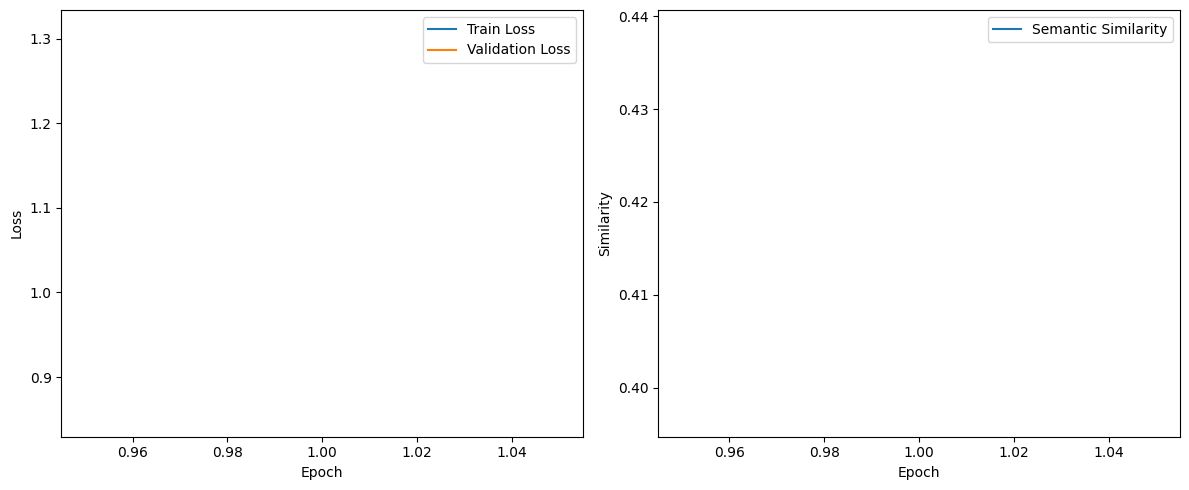

Evaluating:  98%|█████████▊| 59/60 [00:33<00:00,  1.78it/s]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]


========== TEST RESULTS ==========
Test Loss          : 0.9046
Test Semantic Sim  : 0.4283

===== RANDOM TEST EXAMPLES =====

--- Example 118 ---
Raw Report       :
[ Finding ]_x000D_
both accessory navicular bone, type II with OA_x000D_
Lt. navicular bone, step off_x000D_
  --> R/O fracture._x000D_
_x000D_
[ Conclusion ]_x000D_
both accessory navicular bone, type II with OA_x000D_
Lt. navicular bone, step off_x000D_
  --> R/O fracture._x000D_
_x000D_
[ Recommend ]_x000D_

Cleaned Report   :
both accessory navicular bone, type II with OA Lt. navicular bone, step off --> R/O fracture. <|endoftext|>
Generated Report :
 1st MTP joint, OA. ------------------------- No significant bony abnormality since last study . no definite correlation with RA involvement in both knee joints and foot (Et.) R/O gout arthritis -> possible accessory navicular bone erosion or degenerative change of left ankle type II Lt toe soft tissue swelling --> rheumatoid osteopenia hallux valgus , right 5th MT head - 

In [ ]:
import os
import re
import json
import logging
import unicodedata
import random
from collections import defaultdict, Counter

import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import timm
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)

# =============================================================================
# Utility functions
# =============================================================================

def count_labels(data, target_classes, cfg):
    class_counts = defaultdict(int)
    data_by_class = defaultdict(list)
    for entry in tqdm(data.values(), desc="Counting dataset"):
        lbl = entry.get('class_label', '').lower()
        if lbl in target_classes and os.path.exists(entry['file_path']):
            class_counts[lbl] += 1
            data_by_class[lbl].append(entry)
    return class_counts, data_by_class

def prepare_abnormal_normal_data(data, cfg):
    random.seed(42)
    abnormal = ['ra', 'oa', 'gout']
    normal = ['normal']
    class_counts, data_by_class = count_labels(data, abnormal + normal, cfg)
    combined = {
        'abnormal': sum((data_by_class[c] for c in abnormal), []),
        'normal': data_by_class['normal']
    }
    combined_counts = {
        'abnormal': sum(class_counts[c] for c in abnormal),
        'normal': class_counts['normal']
    }
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(combined.values(), []), combined_counts, combined_counts
    min_count = min(combined_counts.values())
    balanced = []
    final_counts = {}
    for lbl, items in combined.items():
        sampled = random.sample(items, min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    if cfg.DATASET.AUGMENT:
        balanced *= 2
    return balanced, combined_counts, final_counts

def prepare_data(data, target_classes, cfg, is_binary=False):
    random.seed(42)
    if len(target_classes) == 2 and 'abnormal' in target_classes and 'normal' in target_classes:
        logging.info("Using abnormal-vs-normal logic")
        return prepare_abnormal_normal_data(data, cfg)
    class_counts, data_by_class = count_labels(data, target_classes, cfg)
    logging.info(f"Original class distribution: {class_counts}")
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(data_by_class.values(), []), class_counts, class_counts
    min_count = min(class_counts.values())
    balanced, final_counts = [], {}
    for lbl in target_classes:
        sampled = random.sample(data_by_class[lbl], min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    logging.info(f"Balanced class distribution: {final_counts}")
    if cfg.DATASET.AUGMENT:
        balanced *= 2
    return balanced, class_counts, final_counts

# =============================================================================
# Transforms
# =============================================================================

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

patch_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

# =============================================================================
# Dataset
# =============================================================================

class FinalSamplesDataset(Dataset):
    def __init__(self, cfg, image_transform=train_transform, patch_transform=patch_transform):
        self.cfg = cfg
        self.image_transform = image_transform
        self.patch_transform = patch_transform

        self.target_classes = cfg.DATASET.TARGET_CLASSES
        if isinstance(self.target_classes, str):
            self.target_classes = self.target_classes.split(",")

        self.is_binary = len(self.target_classes) == 2
        self.abnormal_classify = self.is_binary and 'abnormal' in self.target_classes
        self.abnormal_mapping = (
            {'ra': 'abnormal', 'oa': 'abnormal', 'gout': 'abnormal', 'normal': 'normal'}
            if self.abnormal_classify else None
        )

        with open(cfg.DATASET.JSON, 'r') as f:
            raw_list = json.load(f)

        filtered = []
        for item in raw_list:
            merged = item.get('merged_image_path', '')
            fp = item.get('file_paths', [])
            if isinstance(fp, str):
                fp = [fp]
            paths = [merged] + fp
            if any(os.path.exists(p) for p in paths):
                filtered.append((merged, fp, item))

        self.data = {}
        for i, (merged, fp, item) in enumerate(filtered):
            cls = item.get('class', 'unknown').lower()
            if self.abnormal_mapping:
                cls = self.abnormal_mapping.get(cls, cls)
            self.data[i] = {
                'file_path': merged,
                'left_right_file_path': fp,
                'class_label': cls,
                'diagnosis': item.get('diagnosis', ''),
                'keypoints': item.get('keypoints', {})
            }

        if self.is_binary:
            balanced, _, _ = prepare_data(self.data, self.target_classes, cfg, True)
            self.data = {i: e for i, e in enumerate(balanced)}

        self.eos_token = None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        e = self.data[idx]
        img = Image.open(e['file_path']).convert('RGB')
        img = self.image_transform(img)

        patches = self._gen_patches(e['left_right_file_path'], e['keypoints'])
        pt = [self.patch_transform(Image.fromarray(p)) for p in patches]
        patches_tensor = torch.stack(pt, 0) if pt else torch.zeros(34, 3, 112, 112)

        raw = e.get('diagnosis', '')
        clean = self._clean_report(raw)
        tok = tokenizer(clean, truncation=True, max_length=512, return_tensors='pt')

        return {
            'full_img': img,
            'patches': patches_tensor,
            'raw_report': raw,
            'cleaned_report': clean,
            'input_ids': tok['input_ids'].squeeze(0),
            'attention_mask': tok['attention_mask'].squeeze(0)
        }

    def _gen_patches(self, paths, kps_dict, crop_size=(200, 300), patch_size=(112, 112)):
        def extract(arr, side_kps):
            lst = []
            pts = side_kps[0]['keypoints']
            for i in range(17):
                x, y, s = int(pts[3*i]), int(pts[3*i+1]), pts[3*i+2]
                if s > 0:
                    x0 = max(x - crop_size[0]//2, 0)
                    y0 = max(y - crop_size[1]//2, 0)
                    x1 = min(x + crop_size[0]//2, arr.shape[1])
                    y1 = min(y + crop_size[1]//2, arr.shape[0])
                    c = arr[y0:y1, x0:x1]
                    if c.size:
                        lst.append(cv2.resize(c, patch_size))
            return lst

        def pad17(lst):
            black = np.zeros((patch_size[1], patch_size[0], 3), np.uint8)
            while len(lst) < 17:
                lst.append(black)
            return lst[:17]

        left, right = [], []
        if len(paths) == 1:
            pth = paths[0]
            if not pth or not os.path.exists(pth):
                return pad17([]) + pad17([])
            img_arr = cv2.imread(pth)
            if img_arr is None:
                return pad17([]) + pad17([])
            arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
            if kps_dict.get('left'): left = extract(arr, kps_dict['left'])
            if kps_dict.get('right'): right = extract(arr, kps_dict['right'])
        else:
            for side, pth in zip(['left', 'right'], paths):
                if pth and os.path.exists(pth):
                    img_arr = cv2.imread(pth)
                    if img_arr is not None:
                        arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
                        if kps_dict.get(side):
                            lst = extract(arr, kps_dict[side])
                            if side == 'left': left = lst
                            else: right = lst

        if left and not right:
            right = [cv2.flip(p, 1) for p in left]
        if right and not left:
            left = [cv2.flip(p, 1) for p in right]
        if not left and not right:
            return pad17([]) + pad17([])

        return pad17(left) + pad17(right)

    def _clean_report(self, text):
        # 1) normalize
        text = unicodedata.normalize('NFKC', text or '')

        # 2) replace Windows line‐break markers early, so that “---- _x000D_” turns into “----  ”
        text = text.replace('_x000D_', ' ')

        # 3) remove any lines that consist only of dashes + spaces
        text = re.sub(r'(?m)^\s*-+\s*$', '', text)

        # 4) strip out non-ASCII
        text = re.sub(r'[^\x00-\x7F]+', ' ', text)

        # 5) collapse repeated punctuation
        text = re.sub(r'([.!?]){2,}', r'\1', text)

        # 6) normalize your section tags
        text = re.sub(r'\[\s*finding\s*\]', '[FINDING]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*conclusion\s*\]', '[CONCLUSION]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*diagnosis\s*\]', '[DIAGNOSIS]', text, flags=re.IGNORECASE)

        # 7) drop everything after “[Recommend]”
        parts = re.split(r'\[\s*recommend(?:ation)?\s*\]', text, flags=re.IGNORECASE)
        text = parts[0]

        # 8) if FINDING == CONCLUSION, drop the duplicated block
        fm = re.search(r'\[FINDING\](.*?)(?=\[|$)', text, flags=re.IGNORECASE|re.DOTALL)
        cm = re.search(r'\[CONCLUSION\](.*?)(?=\[|$)', text, flags=re.IGNORECASE|re.DOTALL)
        if fm and cm and fm.group(1).strip().lower() == cm.group(1).strip().lower():
            text = re.sub(r'\[CONCLUSION\].*?(?=\[|$)', '', text, flags=re.IGNORECASE|re.DOTALL)

        # 9) strip out the remaining tag markers
        text = re.sub(r'\[\s*(FINDING|CONCLUSION|DIAGNOSIS)\s*\]', '', text, flags=re.IGNORECASE)

        # 10) collapse all whitespace
        text = re.sub(r'\s+', ' ', text).strip()

        # 11) **new**: remove any leading dashes that survived (e.g. "---- …")
        text = re.sub(r'^-+\s*', '', text)

        # 12) append EOS
        if text and not text.endswith(self.eos_token):
            text += ' ' + self.eos_token

        return text


# =============================================================================
# Collate function
# =============================================================================

def collate_fn(batch):
    imgs = torch.stack([b['full_img'] for b in batch])
    pts = [b['patches'] for b in batch]
    max_p = max(p.shape[0] for p in pts)
    pads = []
    for p in pts:
        if p.shape[0] < max_p:
            pad = torch.zeros((max_p - p.shape[0], *p.shape[1:]))
            p = torch.cat([p, pad], dim=0)
        pads.append(p)
    patches = torch.stack(pads, 0)

    ids   = [b['input_ids'] for b in batch]
    masks = [b['attention_mask'] for b in batch]
    ids   = nn.utils.rnn.pad_sequence(ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    masks = nn.utils.rnn.pad_sequence(masks, batch_first=True, padding_value=0)

    return {
        'full_imgs':       imgs,
        'patches':         patches,
        'input_ids':       ids,
        'attention_mask':  masks,
        'raw_reports':     [b['raw_report'] for b in batch],
        'cleaned_reports': [b['cleaned_report'] for b in batch]
    }

# =============================================================================
# Model
# =============================================================================

class MultiModalModel(nn.Module):
    def __init__(self, gpt2_model_name='gpt2'):
        super().__init__()
        self.global_encoder = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
        self.global_encoder.reset_classifier(0)
        self.global_proj = nn.Linear(self.global_encoder.num_features, 768)

        self.patch_encoder = timm.create_model('resnet50', pretrained=True)
        self.patch_encoder.fc = nn.Identity()
        self.patch_proj = nn.Linear(self.patch_encoder.num_features, 768)

        self.attn = nn.MultiheadAttention(embed_dim=768, num_heads=8, batch_first=True)
        self.norm = nn.LayerNorm(768)

        self.decoder = GPT2LMHeadModel.from_pretrained(gpt2_model_name, add_cross_attention=True)

    def _pool(self, feats):
        return feats.mean(dim=[2,3]) if feats.ndim>2 else feats

    def forward(self, imgs, patches, input_ids, attention_mask, decoder_labels=None):
        # global
        g = self.global_encoder(imgs)
        g = self.global_proj(g).unsqueeze(1)

        # patches
        B, N, C, H, W = patches.shape
        p = patches.view(B*N, C, H, W)
        pf = (self.patch_encoder.forward_features(p)
              if hasattr(self.patch_encoder, 'forward_features')
              else self.patch_encoder(p))
        pf = self._pool(pf)
        pf = self.patch_proj(pf).view(B, N, 768)

        # cross-attention
        cat, _ = self.attn(torch.cat([g,pf], dim=1),
                           torch.cat([g,pf], dim=1),
                           torch.cat([g,pf], dim=1))
        cat = self.norm(cat)

        # decode
        return self.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=cat,
            labels=decoder_labels
        )

# =============================================================================
# Train / Eval helpers
# =============================================================================

def train_epoch(model, loader, optimizer, scaler, device):
    model.train()
    total_loss = 0.0
    for b in tqdm(loader, desc="Training", leave=False):
        imgs = b['full_imgs'].to(device)
        pts  = b['patches'].to(device)
        ids  = b['input_ids'].to(device)
        msk  = b['attention_mask'].to(device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            loss = out.loss
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.0
    all_gen, all_gt = [], []

    for b in tqdm(loader, desc="Evaluating", leave=False):
        imgs = b['full_imgs'].to(device)
        pts  = b['patches'].to(device)
        ids  = b['input_ids'].to(device)
        msk  = b['attention_mask'].to(device)

        # compute loss with teacher forcing
        with torch.no_grad():
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            total_loss += out.loss.item()

        # prepare pure BOS tokens
        B = imgs.size(0)
        bos = torch.full((B, 1), tokenizer.eos_token_id, dtype=torch.long, device=device)
        bos_mask = torch.ones_like(bos)

        # re-encode image features & generate
        with torch.no_grad():
            g = model.global_encoder(imgs)
            g = model.global_proj(g).unsqueeze(1)

            B, N, C, H, W = pts.shape
            p = pts.view(B*N, C, H, W)
            pf = (model.patch_encoder.forward_features(p)
                  if hasattr(model.patch_encoder, 'forward_features')
                  else model.patch_encoder(p))
            pf = model._pool(pf)
            pf = model.patch_proj(pf).view(B, N, 768)

            cat, _ = model.attn(torch.cat([g,pf], dim=1),
                                torch.cat([g,pf], dim=1),
                                torch.cat([g,pf], dim=1))
            cat = model.norm(cat)

            gen_ids = model.decoder.generate(
                input_ids=bos,
                attention_mask=bos_mask,
                encoder_hidden_states=cat,
                max_length=100,
                do_sample=True,
                top_k=50,
                top_p=0.95,
                temperature=0.7,
                repetition_penalty=1.2,
                eos_token_id=tokenizer.eos_token_id,
                pad_token_id=tokenizer.eos_token_id
            )

        gen_txt = [tokenizer.decode(g_, skip_special_tokens=True) for g_ in gen_ids]
        gt_txt  = [tokenizer.decode(i_, skip_special_tokens=True) for i_ in ids]
        all_gen.extend(gen_txt)
        all_gt.extend(gt_txt)

    return total_loss / len(loader), all_gen, all_gt

def compute_semantic_similarity(gen, gt):
    stm = SentenceTransformer('all-MiniLM-L6-v2')
    e1 = stm.encode(gen, convert_to_tensor=True)
    e2 = stm.encode(gt, convert_to_tensor=True)
    return nn.functional.cosine_similarity(e1, e2).mean().item()

def plot_metrics(train_losses, val_losses, sems):
    epochs = range(1, len(train_losses)+1)
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses,   label="Validation Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, sems, label="Semantic Similarity")
    plt.xlabel("Epoch"); plt.ylabel("Similarity"); plt.legend()

    plt.tight_layout()
    plt.show()

# =============================================================================
# MAIN
# =============================================================================

class Cfg: pass
cfg = Cfg()
cfg.DATASET = Cfg()
cfg.DATASET.JSON           = 'final_samples_both_only_v2.json'
cfg.DATASET.USE_RAW        = True
cfg.DATASET.USE_PATCH      = True
cfg.DATASET.REPORT         = True
cfg.DATASET.TARGET_CLASSES = ['ra','oa','gout','normal','uncertain','ref.prev']
cfg.DATASET.BALANCE        = False
cfg.DATASET.AUGMENT        = False

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

dataset = FinalSamplesDataset(cfg)
dataset.eos_token = tokenizer.eos_token

dist = Counter(e['class_label'] for e in dataset.data.values())
print("\nDataset class distribution:")
for cls, cnt in dist.items():
    print(f"  {cls}: {cnt}")

n       = len(dataset)
n_train = int(0.8 * n)
n_val   = int(0.1 * n)
n_test  = n - n_train - n_val

train_ds, val_ds, test_ds = random_split(dataset, [n_train, n_val, n_test])
print(f"# train={len(train_ds)}, val={len(val_ds)}, test={len(test_ds)}")

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True,  collate_fn=collate_fn)
val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds,  batch_size=4, shuffle=False, collate_fn=collate_fn)

model     = MultiModalModel().to(device)
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
scaler    = torch.cuda.amp.GradScaler()

num_epochs = 1
train_losses, val_losses, sems = [], [], []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train_loss = train_epoch(model, train_loader, optimizer, scaler, device)
    val_loss, gen_txt, gt_txt = evaluate(model, val_loader, device)
    sem = compute_semantic_similarity(gen_txt, gt_txt)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    sems.append(sem)

    print(f"  Train Loss          : {train_loss:.4f}")
    print(f"  Validation Loss     : {val_loss:.4f}")
    print(f"  Semantic Similarity : {sem:.4f}")
    scheduler.step()

plot_metrics(train_losses, val_losses, sems)

test_loss, test_gen, test_gt = evaluate(model, test_loader, device)
test_sem = compute_semantic_similarity(test_gen, test_gt)

print("\n========== TEST RESULTS ==========")
print(f"Test Loss          : {test_loss:.4f}")
print(f"Test Semantic Sim  : {test_sem:.4f}")

print("\n===== RANDOM TEST EXAMPLES =====")
for idx in random.sample(range(len(test_ds)), min(10, len(test_ds))):
    ex = test_ds[idx]
    raw   = ex['raw_report']
    clean = ex['cleaned_report']

    fi = ex['full_img'].unsqueeze(0).to(device)
    pa = ex['patches'].unsqueeze(0).to(device)

    # re-encode image features
    g = model.global_encoder(fi)
    g = model.global_proj(g).unsqueeze(1)
    B, N, C, H, W = pa.shape
    p = pa.view(B*N, C, H, W)
    pf = (model.patch_encoder.forward_features(p)
          if hasattr(model.patch_encoder, 'forward_features')
          else model.patch_encoder(p))
    pf = model._pool(pf)
    pf = model.patch_proj(pf).view(B, N, 768)

    cat, _ = model.attn(torch.cat([g,pf], dim=1),
                        torch.cat([g,pf], dim=1),
                        torch.cat([g,pf], dim=1))
    cat = model.norm(cat)

    # pure BOS token
    bos = torch.full((1, 1), tokenizer.eos_token_id, dtype=torch.long, device=device)
    bos_mask = torch.ones_like(bos)

    gen_ids = model.decoder.generate(
        input_ids=bos,
        attention_mask=bos_mask,
        encoder_hidden_states=cat,
        max_length=120,
        do_sample=True,
        top_k=40,
        top_p=0.95,
        temperature=0.5,
        repetition_penalty=1.3,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id
    )
    gen = tokenizer.decode(gen_ids[0], skip_special_tokens=True)

    print(f"\n--- Example {idx} ---")
    print(f"Raw Report       :\n{raw}")
    print(f"Cleaned Report   :\n{clean}")
    print(f"Generated Report :\n{gen}")


Using device: cuda

Dataset class distribution:
  oa: 573
  ra: 115
  uncertain: 620
  oa, ra: 8
  normal: 748
  gout: 267
  combination of oa, ra: 3
  ref.prev: 60
# train=1915, val=239, test=240


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/swin_base_patch4_window7_224.ms_in22k_ft_in1k)
INFO:timm.models._hub:[timm/swin_base_patch4_window7_224.ms_in22k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/resnet50.a1_in1k)
INFO:timm.models._hub:[timm/resnet50.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossatten


Epoch 1/1


Training:   0%|          | 0/479 [00:00<?, ?it/s]/tmp/ipykernel_29687/890416701.py:354: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluating:  98%|█████████▊| 59/60 [00:34<00:00,  1.75it/s]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.3263
  Validation Loss     : 0.7924
  Semantic Similarity : 0.3890


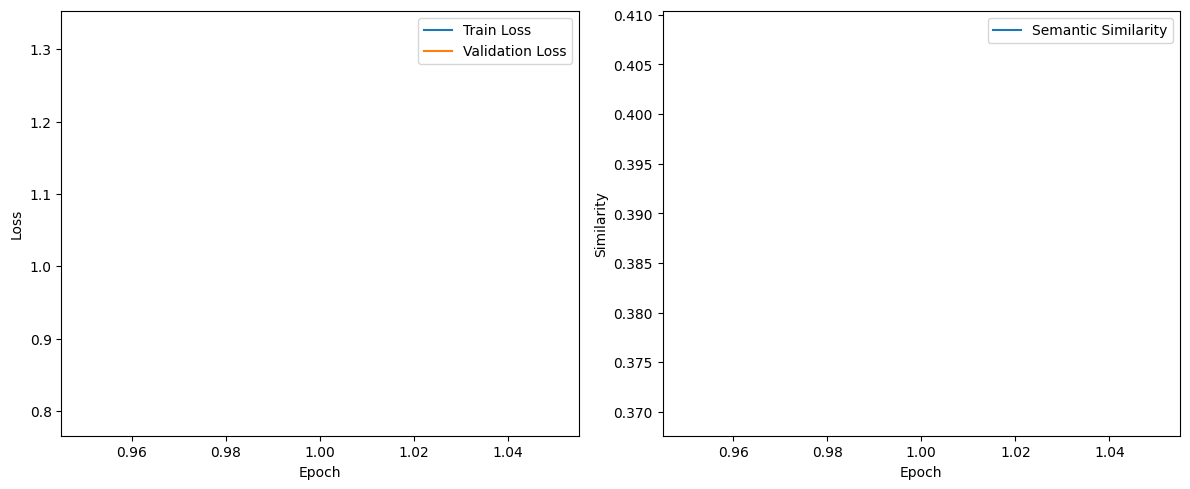

Evaluating:  98%|█████████▊| 59/60 [00:34<00:00,  1.73it/s]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]


========== TEST RESULTS ==========
Test Loss          : 0.8191
Test Semantic Sim  : 0.3918

===== RANDOM TEST EXAMPLES =====

--- Example 235 ---
Raw Report       :
[ Finding ]_x000D_
_x000D_
[ Conclusion ]_x000D_
Degenerative changes._x000D_
[ Recommend ]_x000D_

Cleaned Report   :
Degenerative changes. <|endoftext|>
Generated Report :
 1st MTP joint soft tissue swelling, Rt. ___________________ r/o gout arthritis at Lt 5th MT head and feet sinde last study in both calcaneus medial aspect of right foot -> RA involvement with os trigonum osteophyte --> TMT interlacar bone type II post-opaque lesion on radiographs (open space) tophi erosions state degenerative change hallux valgare pes planis lateral malleolius naviculocuneiform coalition Hallophalangere flat toe vs knee joints erosion condition

--- Example 209 ---
Raw Report       :
[FINDING       ]_x000D_OA, both feet._x000D__x000D_[CONCLUSION    ]_x000D_OA, both feet._x000D__x000D_[RECOMMENDATION]_x000D_-
Cleaned Report   :
OA, bot

In [4]:
import os
import re
import json
import logging
import unicodedata
import random
from collections import defaultdict, Counter

import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import timm
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)

# =============================================================================
# Utility functions
# =============================================================================

def count_labels(data, target_classes, cfg):
    class_counts = defaultdict(int)
    data_by_class = defaultdict(list)
    for entry in tqdm(data.values(), desc="Counting dataset"):
        lbl = entry.get('class_label', '').lower()
        if lbl in target_classes and os.path.exists(entry['file_path']):
            class_counts[lbl] += 1
            data_by_class[lbl].append(entry)
    return class_counts, data_by_class

def prepare_abnormal_normal_data(data, cfg):
    random.seed(42)
    abnormal = ['ra', 'oa', 'gout']
    normal = ['normal']
    class_counts, data_by_class = count_labels(data, abnormal + normal, cfg)
    combined = {
        'abnormal': sum((data_by_class[c] for c in abnormal), []),
        'normal': data_by_class['normal']
    }
    combined_counts = {
        'abnormal': sum(class_counts[c] for c in abnormal),
        'normal': class_counts['normal']
    }
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(combined.values(), []), combined_counts, combined_counts
    min_count = min(combined_counts.values())
    balanced = []
    final_counts = {}
    for lbl, items in combined.items():
        sampled = random.sample(items, min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    if cfg.DATASET.AUGMENT:
        balanced *= 2
    return balanced, combined_counts, final_counts

def prepare_data(data, target_classes, cfg, is_binary=False):
    random.seed(42)
    if len(target_classes) == 2 and 'abnormal' in target_classes and 'normal' in target_classes:
        logging.info("Using abnormal-vs-normal logic")
        return prepare_abnormal_normal_data(data, cfg)
    class_counts, data_by_class = count_labels(data, target_classes, cfg)
    logging.info(f"Original class distribution: {class_counts}")
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(data_by_class.values(), []), class_counts, class_counts
    min_count = min(class_counts.values())
    balanced, final_counts = [], {}
    for lbl in target_classes:
        sampled = random.sample(data_by_class[lbl], min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    logging.info(f"Balanced class distribution: {final_counts}")
    if cfg.DATASET.AUGMENT:
        balanced *= 2
    return balanced, class_counts, final_counts

# =============================================================================
# Transforms
# =============================================================================

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

patch_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

# =============================================================================
# Dataset
# =============================================================================

class FinalSamplesDataset(Dataset):
    def __init__(self, cfg, image_transform=train_transform, patch_transform=patch_transform):
        self.cfg = cfg
        self.image_transform = image_transform
        self.patch_transform = patch_transform

        self.target_classes = cfg.DATASET.TARGET_CLASSES
        if isinstance(self.target_classes, str):
            self.target_classes = self.target_classes.split(",")

        self.is_binary = len(self.target_classes) == 2
        self.abnormal_classify = self.is_binary and 'abnormal' in self.target_classes
        self.abnormal_mapping = (
            {'ra': 'abnormal', 'oa': 'abnormal', 'gout': 'abnormal', 'normal': 'normal'}
            if self.abnormal_classify else None
        )

        with open(cfg.DATASET.JSON, 'r') as f:
            raw_list = json.load(f)

        filtered = []
        for item in raw_list:
            merged = item.get('merged_image_path', '')
            fp = item.get('file_paths', [])
            if isinstance(fp, str):
                fp = [fp]
            paths = [merged] + fp
            if any(os.path.exists(p) for p in paths):
                filtered.append((merged, fp, item))

        self.data = {}
        for i, (merged, fp, item) in enumerate(filtered):
            cls = item.get('class', 'unknown').lower()
            if self.abnormal_mapping:
                cls = self.abnormal_mapping.get(cls, cls)
            self.data[i] = {
                'file_path': merged,
                'left_right_file_path': fp,
                'class_label': cls,
                'diagnosis': item.get('diagnosis', ''),
                'keypoints': item.get('keypoints', {})
            }

        if self.is_binary:
            balanced, _, _ = prepare_data(self.data, self.target_classes, cfg, True)
            self.data = {i: e for i, e in enumerate(balanced)}

        self.eos_token = None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        e = self.data[idx]
        img = Image.open(e['file_path']).convert('RGB')
        img = self.image_transform(img)

        patches = self._gen_patches(e['left_right_file_path'], e['keypoints'])
        pt = [self.patch_transform(Image.fromarray(p)) for p in patches]
        patches_tensor = torch.stack(pt, 0) if pt else torch.zeros(34, 3, 112, 112)

        raw = e.get('diagnosis', '')
        clean = self._clean_report(raw)
        tok = tokenizer(clean, truncation=True, max_length=512, return_tensors='pt')

        return {
            'full_img':       img,
            'patches':        patches_tensor,
            'raw_report':     raw,
            'cleaned_report': clean,
            'input_ids':      tok['input_ids'].squeeze(0),
            'attention_mask': tok['attention_mask'].squeeze(0)
        }

    def _gen_patches(self, paths, kps_dict, crop_size=(200, 300), patch_size=(112, 112)):
        def extract(arr, side_kps):
            lst = []
            pts = side_kps[0]['keypoints']
            for i in range(17):
                x, y, s = int(pts[3*i]), int(pts[3*i+1]), pts[3*i+2]
                if s > 0:
                    x0 = max(x - crop_size[0]//2, 0)
                    y0 = max(y - crop_size[1]//2, 0)
                    x1 = min(x + crop_size[0]//2, arr.shape[1])
                    y1 = min(y + crop_size[1]//2, arr.shape[0])
                    c = arr[y0:y1, x0:x1]
                    if c.size:
                        lst.append(cv2.resize(c, patch_size))
            return lst

        def pad17(lst):
            black = np.zeros((patch_size[1], patch_size[0], 3), np.uint8)
            while len(lst) < 17:
                lst.append(black)
            return lst[:17]

        left, right = [], []
        if len(paths) == 1:
            pth = paths[0]
            if not pth or not os.path.exists(pth):
                return pad17([]) + pad17([])
            img_arr = cv2.imread(pth)
            if img_arr is None:
                return pad17([]) + pad17([])
            arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
            if kps_dict.get('left'):  left  = extract(arr, kps_dict['left'])
            if kps_dict.get('right'): right = extract(arr, kps_dict['right'])
        else:
            for side, pth in zip(['left', 'right'], paths):
                if pth and os.path.exists(pth):
                    img_arr = cv2.imread(pth)
                    if img_arr is not None:
                        arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
                        if kps_dict.get(side):
                            lst = extract(arr, kps_dict[side])
                            if side == 'left':  left  = lst
                            else:               right = lst

        if left and not right:
            right = [cv2.flip(p, 1) for p in left]
        if right and not left:
            left  = [cv2.flip(p, 1) for p in right]
        if not left and not right:
            return pad17([]) + pad17([])

        return pad17(left) + pad17(right)

    def _clean_report(self, text):
        text = unicodedata.normalize('NFKC', text or '')
        text = text.replace('_x000D_', ' ')
        text = re.sub(r'(?m)^\s*-+\s*$', '', text)
        text = re.sub(r'[^\x00-\x7F]+', ' ', text)
        text = re.sub(r'([.!?]){2,}', r'\1', text)
        text = re.sub(r'\[\s*finding\s*\]', '[FINDING]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*conclusion\s*\]', '[CONCLUSION]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*diagnosis\s*\]', '[DIAGNOSIS]', text, flags=re.IGNORECASE)
        parts = re.split(r'\[\s*recommend(?:ation)?\s*\]', text, flags=re.IGNORECASE)
        text = parts[0]
        fm = re.search(r'\[FINDING\](.*?)(?=\[|$)', text, flags=re.IGNORECASE|re.DOTALL)
        cm = re.search(r'\[CONCLUSION\](.*?)(?=\[|$)', text, flags=re.IGNORECASE|re.DOTALL)
        if fm and cm and fm.group(1).strip().lower() == cm.group(1).strip().lower():
            text = re.sub(r'\[CONCLUSION\].*?(?=\[|$)', '', text, flags=re.IGNORECASE|re.DOTALL)
        text = re.sub(r'\[\s*(FINDING|CONCLUSION|DIAGNOSIS)\s*\]', '', text, flags=re.IGNORECASE)
        text = re.sub(r'\s+', ' ', text).strip()
        text = re.sub(r'^-+\s*', '', text)
        if text and not text.endswith(self.eos_token):
            text += ' ' + self.eos_token
        return text

# =============================================================================
# Collate function (with .long() casts)
# =============================================================================

def collate_fn(batch):
    imgs = torch.stack([b['full_img'] for b in batch])
    pts  = [b['patches'] for b in batch]
    max_p = max(p.shape[0] for p in pts)
    pads = []
    for p in pts:
        if p.shape[0] < max_p:
            pad = torch.zeros((max_p - p.shape[0], *p.shape[1:]))
            p = torch.cat([p, pad], dim=0)
        pads.append(p)
    patches = torch.stack(pads, 0)

    ids   = [b['input_ids'] for b in batch]
    masks = [b['attention_mask'] for b in batch]
    ids   = nn.utils.rnn.pad_sequence(ids,   batch_first=True, padding_value=tokenizer.pad_token_id).long()
    masks = nn.utils.rnn.pad_sequence(masks, batch_first=True, padding_value=0).long()

    return {
        'full_imgs':       imgs,
        'patches':         patches,
        'input_ids':       ids,
        'attention_mask':  masks,
        'raw_reports':     [b['raw_report'] for b in batch],
        'cleaned_reports': [b['cleaned_report'] for b in batch]
    }

# =============================================================================
# Model
# =============================================================================

class MultiModalModel(nn.Module):
    def __init__(self, gpt2_model_name='gpt2'):
        super().__init__()
        self.global_encoder = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
        self.global_encoder.reset_classifier(0)
        self.global_proj = nn.Linear(self.global_encoder.num_features, 768)

        self.patch_encoder = timm.create_model('resnet50', pretrained=True)
        self.patch_encoder.fc = nn.Identity()
        self.patch_proj = nn.Linear(self.patch_encoder.num_features, 768)

        self.attn = nn.MultiheadAttention(embed_dim=768, num_heads=8, batch_first=True)
        self.norm = nn.LayerNorm(768)

        self.decoder = GPT2LMHeadModel.from_pretrained(gpt2_model_name, add_cross_attention=True)

    def _pool(self, feats):
        return feats.mean(dim=[2,3]) if feats.ndim>2 else feats

    def forward(self, imgs, patches, input_ids, attention_mask, decoder_labels=None):
        # encode global image
        g = self.global_encoder(imgs)
        g = self.global_proj(g).unsqueeze(1)

        # encode patches
        B, N, C, H, W = patches.shape
        p = patches.view(B*N, C, H, W)
        pf = (self.patch_encoder.forward_features(p)
              if hasattr(self.patch_encoder, 'forward_features')
              else self.patch_encoder(p))
        pf = self._pool(pf)
        pf = self.patch_proj(pf).view(B, N, 768)

        # cross-attention
        cat, _ = self.attn(
            torch.cat([g, pf], dim=1),
            torch.cat([g, pf], dim=1),
            torch.cat([g, pf], dim=1)
        )
        cat = self.norm(cat)

        # decode
        return self.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=cat,
            labels=decoder_labels
        )

# =============================================================================
# Train / Eval helpers (with .long() casts)
# =============================================================================

def train_epoch(model, loader, optimizer, scaler, device):
    model.train()
    total_loss = 0.0
    for b in tqdm(loader, desc="Training", leave=False):
        imgs = b['full_imgs'].to(device)
        pts  = b['patches'].to(device)
        ids  = b['input_ids'].long().to(device)
        msk  = b['attention_mask'].long().to(device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            loss = out.loss
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.0
    all_gen, all_gt = [], []
    for b in tqdm(loader, desc="Evaluating", leave=False):
        imgs = b['full_imgs'].to(device)
        pts  = b['patches'].to(device)
        ids  = b['input_ids'].long().to(device)
        msk  = b['attention_mask'].long().to(device)

        # teacher-forced loss
        with torch.no_grad():
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            total_loss += out.loss.item()

        # prepare pure BOS
        B = imgs.size(0)
        bos = torch.full((B, 1), tokenizer.eos_token_id, dtype=torch.long, device=device)
        bos_mask = torch.ones_like(bos)

        # generate
        with torch.no_grad():
            g = model.global_encoder(imgs)
            g = model.global_proj(g).unsqueeze(1)

            B, N, C, H, W = pts.shape
            p = pts.view(B*N, C, H, W)
            pf = (model.patch_encoder.forward_features(p)
                  if hasattr(model.patch_encoder, 'forward_features')
                  else model.patch_encoder(p))
            pf = model._pool(pf)
            pf = model.patch_proj(pf).view(B, N, 768)

            cat, _ = model.attn(
                torch.cat([g, pf], dim=1),
                torch.cat([g, pf], dim=1),
                torch.cat([g, pf], dim=1)
            )
            cat = model.norm(cat)

            gen_ids = model.decoder.generate(
                input_ids=bos,
                attention_mask=bos_mask,
                encoder_hidden_states=cat,
                max_length=100,
                do_sample=True,
                top_k=50,
                top_p=0.95,
                temperature=0.7,
                repetition_penalty=1.2,
                eos_token_id=tokenizer.eos_token_id,
                pad_token_id=tokenizer.eos_token_id
            )

        gen_txt = [tokenizer.decode(g_, skip_special_tokens=True) for g_ in gen_ids]
        gt_txt  = [tokenizer.decode(i_, skip_special_tokens=True) for i_ in ids]
        all_gen.extend(gen_txt)
        all_gt.extend(gt_txt)

    return total_loss / len(loader), all_gen, all_gt

def compute_semantic_similarity(gen, gt):
    stm = SentenceTransformer('all-MiniLM-L6-v2')
    e1 = stm.encode(gen, convert_to_tensor=True)
    e2 = stm.encode(gt, convert_to_tensor=True)
    return nn.functional.cosine_similarity(e1, e2).mean().item()

def plot_metrics(train_losses, val_losses, sems):
    epochs = range(1, len(train_losses)+1)
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses,   label="Validation Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, sems, label="Semantic Similarity")
    plt.xlabel("Epoch"); plt.ylabel("Similarity"); plt.legend()

    plt.tight_layout()
    plt.show()

# =============================================================================
# MAIN (with early stopping)
# =============================================================================

if __name__ == "__main__":
    # config
    class Cfg: pass
    cfg = Cfg()
    cfg.DATASET = Cfg()
    cfg.DATASET.JSON           = 'final_samples_both_only_v2.json'
    cfg.DATASET.USE_RAW        = True
    cfg.DATASET.USE_PATCH      = True
    cfg.DATASET.REPORT         = True
    cfg.DATASET.TARGET_CLASSES = ['ra','oa','gout','normal','uncertain','ref.prev']
    cfg.DATASET.BALANCE        = False
    cfg.DATASET.AUGMENT        = False

    # tokenizer & device
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    tokenizer.pad_token = tokenizer.eos_token
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    # prepare dataset
    dataset = FinalSamplesDataset(cfg)
    dataset.eos_token = tokenizer.eos_token

    dist = Counter(e['class_label'] for e in dataset.data.values())
    print("\nDataset class distribution:")
    for cls, cnt in dist.items():
        print(f"  {cls}: {cnt}")

    # train/val/test split
    n       = len(dataset)
    n_train = int(0.8 * n)
    n_val   = int(0.1 * n)
    n_test  = n - n_train - n_val

    train_ds, val_ds, test_ds = random_split(dataset, [n_train, n_val, n_test])
    print(f"# train={len(train_ds)}, val={len(val_ds)}, test={len(test_ds)}")

    train_loader = DataLoader(train_ds, batch_size=4, shuffle=True,  collate_fn=collate_fn)
    val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False, collate_fn=collate_fn)
    test_loader  = DataLoader(test_ds,  batch_size=4, shuffle=False, collate_fn=collate_fn)

    # model, optimizer, scheduler, scaler
    model     = MultiModalModel().to(device)
    optimizer = optim.AdamW(model.parameters(), lr=5e-5)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
    scaler    = torch.cuda.amp.GradScaler()

    # early stopping params
    patience          = 3
    best_val_loss     = float('inf')
    epochs_no_improve = 0

    # training loop
    num_epochs = 1
    train_losses, val_losses, sems = [], [], []

    for epoch in range(1, num_epochs+1):
        print(f"\nEpoch {epoch}/{num_epochs}")
        train_loss = train_epoch(model, train_loader, optimizer, scaler, device)
        val_loss, gen_txt, gt_txt = evaluate(model, val_loader, device)
        sem = compute_semantic_similarity(gen_txt, gt_txt)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        sems.append(sem)

        print(f"  Train Loss          : {train_loss:.4f}")
        print(f"  Validation Loss     : {val_loss:.4f}")
        print(f"  Semantic Similarity : {sem:.4f}")

        scheduler.step()

        if val_loss < best_val_loss:
            best_val_loss     = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"No improvement for {patience} epochs. Early stopping.")
                break

    # load best model
    #model.load_state_dict(torch.load('best_model.pt', map_location=device))

    # plot metrics
    plot_metrics(train_losses, val_losses, sems)

    # final test eval
    test_loss, test_gen, test_gt = evaluate(model, test_loader, device)
    test_sem = compute_semantic_similarity(test_gen, test_gt)

    print("\n========== TEST RESULTS ==========")
    print(f"Test Loss          : {test_loss:.4f}")
    print(f"Test Semantic Sim  : {test_sem:.4f}")

    # random examples
    print("\n===== RANDOM TEST EXAMPLES =====")
    for idx in random.sample(range(len(test_ds)), min(10, len(test_ds))):
        ex = test_ds[idx]
        raw   = ex['raw_report']
        clean = ex['cleaned_report']

        fi = ex['full_img'].unsqueeze(0).to(device)
        pa = ex['patches'].unsqueeze(0).to(device)

        # re-encode features
        g = model.global_encoder(fi)
        g = model.global_proj(g).unsqueeze(1)
        B, N, C, H, W = pa.shape
        p = pa.view(B*N, C, H, W)
        pf = (model.patch_encoder.forward_features(p)
              if hasattr(model.patch_encoder, 'forward_features')
              else model.patch_encoder(p))
        pf = model._pool(pf)
        pf = model.patch_proj(pf).view(B, N, 768)

        cat, _ = model.attn(
            torch.cat([g, pf], dim=1),
            torch.cat([g, pf], dim=1),
            torch.cat([g, pf], dim=1)
        )
        cat = model.norm(cat)

        # pure BOS token
        bos = torch.full((1, 1), tokenizer.eos_token_id, dtype=torch.long, device=device)
        bos_mask = torch.ones_like(bos)

        gen_ids = model.decoder.generate(
            input_ids=bos,
            attention_mask=bos_mask,
            encoder_hidden_states=cat,
            max_length=120,
            do_sample=True,
            top_k=40,
            top_p=0.95,
            temperature=0.5,
            repetition_penalty=1.3,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.eos_token_id
        )
        gen = tokenizer.decode(gen_ids[0], skip_special_tokens=True)

        print(f"\n--- Example {idx} ---")
        print(f"Raw Report       :\n{raw}")
        print(f"Cleaned Report   :\n{clean}")
        print(f"Generated Report :\n{gen}")


In [6]:
import os
import re
import json
import logging
import unicodedata
import random
from collections import defaultdict, Counter

import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import timm
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)

# =============================================================================
# Utility functions
# =============================================================================

def count_labels(data, target_classes, cfg):
    class_counts = defaultdict(int)
    data_by_class = defaultdict(list)
    for entry in tqdm(data.values(), desc="Counting dataset"):
        lbl = entry.get('class_label', '').lower()
        if lbl in target_classes and os.path.exists(entry['file_path']):
            class_counts[lbl] += 1
            data_by_class[lbl].append(entry)
    return class_counts, data_by_class

def prepare_abnormal_normal_data(data, cfg):
    random.seed(42)
    abnormal = ['ra', 'oa', 'gout']
    normal = ['normal']
    class_counts, data_by_class = count_labels(data, abnormal + normal, cfg)
    combined = {
        'abnormal': sum((data_by_class[c] for c in abnormal), []),
        'normal': data_by_class['normal']
    }
    combined_counts = {
        'abnormal': sum(class_counts[c] for c in abnormal),
        'normal': class_counts['normal']
    }
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(combined.values(), []), combined_counts, combined_counts
    min_count = min(combined_counts.values())
    balanced, final_counts = [], {}
    for lbl, items in combined.items():
        sampled = random.sample(items, min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    if cfg.DATASET.AUGMENT:
        balanced *= 2
    return balanced, combined_counts, final_counts

def prepare_data(data, target_classes, cfg, is_binary=False):
    random.seed(42)
    if is_binary and set(target_classes) == {'abnormal','normal'}:
        logging.info("Using abnormal-vs-normal logic")
        return prepare_abnormal_normal_data(data, cfg)
    class_counts, data_by_class = count_labels(data, target_classes, cfg)
    logging.info(f"Original class distribution: {class_counts}")
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(data_by_class.values(), []), class_counts, class_counts
    min_count = min(class_counts.values())
    balanced, final_counts = [], {}
    for lbl in target_classes:
        sampled = random.sample(data_by_class[lbl], min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    if cfg.DATASET.AUGMENT:
        balanced *= 2
    logging.info(f"Balanced class distribution: {final_counts}")
    return balanced, class_counts, final_counts

# =============================================================================
# Transforms
# =============================================================================

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

patch_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

# =============================================================================
# Dataset
# =============================================================================

class FinalSamplesDataset(Dataset):
    def __init__(self, cfg, image_transform=train_transform, patch_transform=patch_transform):
        self.cfg = cfg
        self.image_transform = image_transform
        self.patch_transform = patch_transform

        self.target_classes = cfg.DATASET.TARGET_CLASSES
        if isinstance(self.target_classes, str):
            self.target_classes = self.target_classes.split(',')
        self.is_binary = len(self.target_classes) == 2 and 'abnormal' in self.target_classes and 'normal' in self.target_classes
        if self.is_binary:
            self.abnormal_mapping = {'ra':'abnormal','oa':'abnormal','gout':'abnormal','normal':'normal'}
        else:
            self.abnormal_mapping = None

        with open(cfg.DATASET.JSON, 'r') as f:
            raw_list = json.load(f)

        filtered = []
        for item in raw_list:
            merged = item.get('merged_image_path','')
            fp = item.get('file_paths',[])
            if isinstance(fp, str): fp = [fp]
            paths = [merged] + fp
            if any(os.path.exists(p) for p in paths):
                filtered.append((merged,fp,item))

        self.data = {}
        for i,(merged,fp,item) in enumerate(filtered):
            cls = item.get('class','unknown').lower()
            if self.abnormal_mapping:
                cls = self.abnormal_mapping.get(cls,cls)
            self.data[i] = {
                'file_path': merged,
                'left_right_file_path': fp,
                'class_label': cls,
                'diagnosis': item.get('diagnosis',''),
                'keypoints': item.get('keypoints',{})
            }

        if self.is_binary:
            balanced,_,_ = prepare_data(self.data, ['abnormal','normal'], cfg, True)
            self.data = {i:e for i,e in enumerate(balanced)}
        self.eos_token = None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        e = self.data[idx]
        img = Image.open(e['file_path']).convert('RGB')
        img = self.image_transform(img)

        patches = self._gen_patches(e['left_right_file_path'],e['keypoints'])
        pt = [self.patch_transform(Image.fromarray(p)) for p in patches]
        patches_tensor = torch.stack(pt,0) if pt else torch.zeros(34,3,112,112)

        raw = e['diagnosis']
        clean = self._clean_report(raw)
        tok = tokenizer(clean, truncation=True, max_length=512, return_tensors='pt')

        return {
            'full_img': img,
            'patches': patches_tensor,
            'raw_report': raw,
            'cleaned_report': clean,
            'input_ids': tok['input_ids'].squeeze(0),
            'attention_mask': tok['attention_mask'].squeeze(0)
        }

    def _gen_patches(self, paths, kps_dict, crop_size=(200,300), patch_size=(112,112)):
        def extract(arr, side_kps):
            lst=[]
            pts=side_kps[0]['keypoints']
            for i in range(17):
                x,y,s = int(pts[3*i]), int(pts[3*i+1]), pts[3*i+2]
                if s>0:
                    x0,y0 = max(x-crop_size[0]//2,0), max(y-crop_size[1]//2,0)
                    x1,y1 = min(x+crop_size[0]//2,arr.shape[1]), min(y+crop_size[1]//2,arr.shape[0])
                    c = arr[y0:y1,x0:x1]
                    if c.size: lst.append(cv2.resize(c,patch_size))
            return lst

        def pad17(lst):
            black=np.zeros((patch_size[1],patch_size[0],3),np.uint8)
            while len(lst)<17: lst.append(black)
            return lst[:17]

        left,right=[],[]
        if len(paths)==1:
            p=paths[0]
            if not p or not os.path.exists(p): return pad17([])+pad17([])
            arr=cv2.cvtColor(cv2.imread(p),cv2.COLOR_BGR2RGB) if cv2.imread(p) is not None else None
            if arr is None: return pad17([])+pad17([])
            if kps_dict.get('left'): left=extract(arr,kps_dict['left'])
            if kps_dict.get('right'): right=extract(arr,kps_dict['right'])
        else:
            for side,p in zip(['left','right'],paths):
                if p and os.path.exists(p):
                    img=cv2.imread(p)
                    if img is None: continue
                    arr=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                    if kps_dict.get(side):
                        lst=extract(arr,kps_dict[side])
                        if side=='left': left=lst
                        else: right=lst
        if left and not right: right=[cv2.flip(p,1) for p in left]
        if right and not left: left=[cv2.flip(p,1) for p in right]
        if not left and not right: return pad17([])+pad17([])
        return pad17(left)+pad17(right)

    def _clean_report(self, text):
        text=unicodedata.normalize('NFKC',text or '')
        text=text.replace('_x000D_',' ')
        text=re.sub(r'(?m)^\s*-+\s*$','',text)
        text=re.sub(r'[^\x00-\x7F]+',' ',text)
        text=re.sub(r'([.!?]){2,}',r'\1',text)
        for tag in ['finding','conclusion','diagnosis']:
            text=re.sub(rf'\[\s*{tag}\s*\]',f'[{tag.upper()}]',text,flags=re.IGNORECASE)
        text=re.split(r'\[\s*recommend(?:ation)?\s*\]',text,flags=re.IGNORECASE)[0]
        fm=re.search(r'\[FINDING\](.*?)(?=\[|$)',text,flags=re.IGNORECASE|re.DOTALL)
        cm=re.search(r'\[CONCLUSION\](.*?)(?=\[|$)',text,flags=re.IGNORECASE|re.DOTALL)
        if fm and cm and fm.group(1).strip().lower()==cm.group(1).strip().lower():
            text=re.sub(r'\[CONCLUSION\].*?(?=\[|$)','',text,flags=re.IGNORECASE|re.DOTALL)
        text=re.sub(r'\[\s*(FINDING|CONCLUSION|DIAGNOSIS)\s*\]','',text,flags=re.IGNORECASE)
        text=re.sub(r'\s+',' ',text).strip()
        text=re.sub(r'^-+\s*','',text)
        if text and not text.endswith(self.eos_token):
            text+=' '+self.eos_token
        return text

# =============================================================================
# Collate fn
# =============================================================================

def collate_fn(batch):
    imgs=torch.stack([b['full_img'] for b in batch])
    pts=[b['patches'] for b in batch]
    max_p=max(p.shape[0] for p in pts)
    pads=[]
    for p in pts:
        if p.shape[0]<max_p:
            pad=torch.zeros((max_p-p.shape[0],*p.shape[1:]))
            p=torch.cat([p,pad],dim=0)
        pads.append(p)
    patches=torch.stack(pads,0)

    ids=[b['input_ids'] for b in batch]
    masks=[b['attention_mask'] for b in batch]
    ids=nn.utils.rnn.pad_sequence(ids,batch_first=True,padding_value=tokenizer.pad_token_id).long()
    masks=nn.utils.rnn.pad_sequence(masks,batch_first=True,padding_value=0).long()

    return {'full_imgs':imgs,
            'patches':patches,
            'input_ids':ids,
            'attention_mask':masks,
            'raw_reports':[b['raw_report'] for b in batch],
            'cleaned_reports':[b['cleaned_report'] for b in batch]}

# =============================================================================
# Model
# =============================================================================

class MultiModalModel(nn.Module):
    def __init__(self,gpt2_model_name='gpt2'):
        super().__init__()
        self.global_encoder=timm.create_model('swin_base_patch4_window7_224',pretrained=True)
        self.global_encoder.reset_classifier(0)
        self.global_proj=nn.Linear(self.global_encoder.num_features,768)

        self.patch_encoder=timm.create_model('resnet50',pretrained=True)
        self.patch_encoder.fc=nn.Identity()
        self.patch_proj=nn.Linear(self.patch_encoder.num_features,768)

        self.attn=nn.MultiheadAttention(embed_dim=768,num_heads=8,batch_first=True)
        self.norm=nn.LayerNorm(768)
        self.decoder=GPT2LMHeadModel.from_pretrained(gpt2_model_name,add_cross_attention=True)

    def _pool(self,feats):
        return feats.mean(dim=[2,3]) if feats.ndim>2 else feats

    def forward(self,imgs,patches,input_ids,attention_mask,decoder_labels=None):
        g=self.global_encoder(imgs)
        g=self.global_proj(g).unsqueeze(1)

        B,N,C,H,W=patches.shape
        p=patches.view(B*N,C,H,W)
        pf=(self.patch_encoder.forward_features(p)
            if hasattr(self.patch_encoder,'forward_features')
            else self.patch_encoder(p))
        pf=self._pool(pf)
        pf=self.patch_proj(pf).view(B,N,768)

        cat,_=self.attn(torch.cat([g,pf],dim=1),
                       torch.cat([g,pf],dim=1),
                       torch.cat([g,pf],dim=1))
        cat=self.norm(cat)

        return self.decoder(input_ids=input_ids,
                            attention_mask=attention_mask,
                            encoder_hidden_states=cat,
                            labels=decoder_labels)

# =============================================================================
# Train/Eval
# =============================================================================

def train_epoch(model,loader,optimizer,scaler,device):
    model.train()
    total=0.0
    for b in tqdm(loader,desc="Training",leave=False):
        imgs=b['full_imgs'].to(device)
        pts=b['patches'].to(device)
        ids=b['input_ids'].to(device).long()
        msk=b['attention_mask'].to(device).long()

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            out=model(imgs,pts,ids,msk,decoder_labels=ids)
            loss=out.loss
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total+=loss.item()
    return total/len(loader)

def evaluate(model,loader,device):
    model.eval()
    total=0.0
    all_gen,all_gt=[],[]
    for b in tqdm(loader,desc="Evaluating",leave=False):
        imgs=b['full_imgs'].to(device)
        pts=b['patches'].to(device)
        ids=b['input_ids'].to(device).long()
        msk=b['attention_mask'].to(device).long()

        with torch.no_grad():
            out=model(imgs,pts,ids,msk,decoder_labels=ids)
            total+=out.loss.item()

        # --- start generation with BOS ----
        B,N,C,H,W=pts.shape
        bos=torch.full((B,1),tokenizer.bos_token_id,dtype=torch.long,device=device)
        bos_mask=torch.ones_like(bos)

        with torch.no_grad():
            g=model.global_encoder(imgs)
            g=model.global_proj(g).unsqueeze(1)
            p=pts.view(B*N,C,H,W)
            pf=(model.patch_encoder.forward_features(p)
                if hasattr(model.patch_encoder,'forward_features')
                else model.patch_encoder(p))
            pf=model._pool(pf)
            pf=model.patch_proj(pf).view(B,N,768)
            cat,_=model.attn(torch.cat([g,pf],dim=1),
                             torch.cat([g,pf],dim=1),
                             torch.cat([g,pf],dim=1))
            cat=model.norm(cat)

            gen_ids=model.decoder.generate(
                input_ids=bos,
                attention_mask=bos_mask,
                encoder_hidden_states=cat,
                max_length=100,
                do_sample=True,
                top_k=50,
                top_p=0.95,
                temperature=0.7,
                repetition_penalty=1.2,
                eos_token_id=tokenizer.eos_token_id,
                pad_token_id=tokenizer.pad_token_id
            )

        gen_txt=[tokenizer.decode(g_,skip_special_tokens=True) for g_ in gen_ids]
        gt_txt=[tokenizer.decode(i_,skip_special_tokens=True) for i_ in ids]
        all_gen+=gen_txt
        all_gt+=gt_txt

    return total/len(loader), all_gen, all_gt

def compute_semantic_similarity(gen,gt):
    stm=SentenceTransformer('all-MiniLM-L6-v2')
    e1=stm.encode(gen,convert_to_tensor=True)
    e2=stm.encode(gt,convert_to_tensor=True)
    return nn.functional.cosine_similarity(e1,e2).mean().item()

def plot_metrics(train_losses,val_losses,sems):
    epochs=range(1,len(train_losses)+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs,train_losses,label="Train Loss")
    plt.plot(epochs,val_losses,label="Val Loss")
    plt.xlabel("Epoch");plt.ylabel("Loss");plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs,sems,label="Semantic Sim")
    plt.xlabel("Epoch");plt.ylabel("Sim");plt.legend()
    plt.tight_layout();plt.show()

# =============================================================================
# MAIN
# =============================================================================

if __name__=="__main__":
    # config
    class Cfg: pass
    cfg=Cfg();cfg.DATASET=Cfg()
    cfg.DATASET.JSON='final_samples_both_only_v2.json'
    cfg.DATASET.USE_RAW=True;cfg.DATASET.USE_PATCH=True
    cfg.DATASET.REPORT=True
    cfg.DATASET.TARGET_CLASSES=['ra','oa','gout','normal','uncertain','ref.prev']
    cfg.DATASET.BALANCE=False;cfg.DATASET.AUGMENT=False

    tokenizer=GPT2Tokenizer.from_pretrained('gpt2')
    tokenizer.pad_token=tokenizer.eos_token
    tokenizer.bos_token=tokenizer.eos_token  # define BOS
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Device:",device)

    dataset=FinalSamplesDataset(cfg)
    dataset.eos_token=tokenizer.eos_token
    dist=Counter(e['class_label'] for e in dataset.data.values())
    print("Class distribution:",dist)

    n=len(dataset)
    n_train=int(0.8*n);n_val=int(0.1*n);n_test=n-n_train-n_val
    train_ds,val_ds,test_ds=random_split(dataset,[n_train,n_val,n_test])
    train_loader=DataLoader(train_ds,batch_size=4,shuffle=True,collate_fn=collate_fn)
    val_loader=DataLoader(val_ds,batch_size=4,shuffle=False,collate_fn=collate_fn)
    test_loader=DataLoader(test_ds,batch_size=4,shuffle=False,collate_fn=collate_fn)

    model=MultiModalModel().to(device)
    optimizer=optim.AdamW(model.parameters(),lr=5e-5)
    scheduler=optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=10,T_mult=2)
    scaler=torch.cuda.amp.GradScaler()

    patience=3;best_val_loss=float('inf');epochs_no_improve=0
    num_epochs=10;train_losses=[];val_losses=[];sems=[]

    for epoch in range(1,num_epochs+1):
        print(f"\nEpoch {epoch}/{num_epochs}")
        train_loss=train_epoch(model,train_loader,optimizer,scaler,device)
        val_loss,gen_txt,gt_txt=evaluate(model,val_loader,device)
        sem=compute_semantic_similarity(gen_txt,gt_txt)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        sems.append(sem)
        print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Sem: {sem:.4f}")

        scheduler.step()
        if val_loss<best_val_loss:
            best_val_loss=val_loss;epochs_no_improve=0
            torch.save(model.state_dict(),'best_model.pt')
        else:
            epochs_no_improve+=1
            if epochs_no_improve>=patience:
                print("Early stopping.")
                break

    #model.load_state_dict(torch.load('best_model.pt',map_location=device))
    plot_metrics(train_losses,val_losses,sems)

    test_loss,test_gen,test_gt=evaluate(model,test_loader,device)
    test_sem=compute_semantic_similarity(test_gen,test_gt)
    print(f"\nTest Loss: {test_loss:.4f}, Test Sem: {test_sem:.4f}")

    print("\nRandom Examples:")
    for idx in random.sample(range(len(test_ds)),min(10,len(test_ds))):
        ex=test_ds[idx]
        raw,clean=ex['raw_report'],ex['cleaned_report']
        fi=ex['full_img'].unsqueeze(0).to(device)
        pa=ex['patches'].unsqueeze(0).to(device)

        # re-encode
        g=model.global_encoder(fi);g=model.global_proj(g).unsqueeze(1)
        B,N,C,H,W=pa.shape
        p=pa.view(B*N,C,H,W)
        pf=(model.patch_encoder.forward_features(p)
            if hasattr(model.patch_encoder,'forward_features')
            else model.patch_encoder(p))
        pf=model._pool(pf)
        pf=model.patch_proj(pf).view(B,N,768)
        cat,_=model.attn(torch.cat([g,pf],dim=1),
                         torch.cat([g,pf],dim=1),
                         torch.cat([g,pf],dim=1))
        cat=model.norm(cat)

        bos=torch.full((1,1),tokenizer.bos_token_id,dtype=torch.long,device=device)
        bos_mask=torch.ones_like(bos)
        gen_ids=model.decoder.generate(
            input_ids=bos,
            attention_mask=bos_mask,
            encoder_hidden_states=cat,
            max_length=120,
            do_sample=True,
            top_k=40,
            top_p=0.95,
            temperature=0.5,
            repetition_penalty=1.3,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id
        )
        gen=tokenizer.decode(gen_ids[0],skip_special_tokens=True)
        print(f"\n---Example {idx}---")
        print("Raw:",raw)
        print("Clean:",clean)
        print("Gen:",gen)


Device: cuda
Class distribution: Counter({'normal': 748, 'uncertain': 620, 'oa': 573, 'gout': 267, 'ra': 115, 'ref.prev': 60, 'oa, ra': 8, 'combination of oa, ra': 3})


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/swin_base_patch4_window7_224.ms_in22k_ft_in1k)
INFO:timm.models._hub:[timm/swin_base_patch4_window7_224.ms_in22k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/resnet50.a1_in1k)
INFO:timm.models._hub:[timm/resnet50.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossatten


Epoch 1/10


Training:   0%|          | 0/479 [00:00<?, ?it/s]/tmp/ipykernel_29687/3315090905.py:324: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluating:  98%|█████████▊| 59/60 [00:36<00:00,  1.69it/s]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 1.3151, Val Loss: 0.8494, Sem: 0.3538

Epoch 2/10


Evaluating:  98%|█████████▊| 59/60 [00:20<00:00,  3.05it/s]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.8055, Val Loss: 0.7506, Sem: 0.3083

Epoch 3/10


Evaluating:  98%|█████████▊| 59/60 [00:21<00:00,  2.84it/s]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.6831, Val Loss: 0.7015, Sem: 0.2712

Epoch 4/10


Evaluating:  98%|█████████▊| 59/60 [00:20<00:00,  3.09it/s]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.6087, Val Loss: 0.6831, Sem: 0.2794

Epoch 5/10


KeyboardInterrupt: 

In [11]:
#!/usr/bin/env python3
import json
import random
from pathlib import Path
from collections import defaultdict, Counter

import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import timm
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from sentence_transformers import SentenceTransformer

# =============================================================================
# Configuration
# =============================================================================
class Cfg: pass

cfg = Cfg()

# Dataset settings
cfg.DATASET = Cfg()
cfg.DATASET.JSON            = 'final_samples_both_only_v2.json'
cfg.DATASET.TARGET_CLASSES  = ['ra','oa','gout','normal','uncertain','ref.prev']
cfg.DATASET.BINARY          = False    # map ra/oa/gout → abnormal if True
cfg.DATASET.BALANCE         = False
cfg.DATASET.AUGMENT         = False
cfg.DATASET.USE_RAW         = True
cfg.DATASET.USE_PATCH       = True

# Training settings
cfg.TRAIN = Cfg()
cfg.TRAIN.BATCH_SIZE        = 4
cfg.TRAIN.EPOCHS            = 5
cfg.TRAIN.LR                = 5e-5
cfg.TRAIN.PATIENCE          = 3
cfg.TRAIN.SCHEDULER         = Cfg()
cfg.TRAIN.SCHEDULER.TYPE    = 'CosineWarmRestarts'
cfg.TRAIN.SCHEDULER.T_0     = 10
cfg.TRAIN.SCHEDULER.T_MULT  = 2

# Model settings
cfg.MODEL = Cfg()
cfg.MODEL.VISION_BACKBONE   = 'swin_base_patch4_window7_224'
cfg.MODEL.PATCH_BACKBONE    = 'resnet50'
cfg.MODEL.TEXT_BACKBONE     = 'gpt2'
cfg.MODEL.EMBED_DIM         = 768
cfg.MODEL.NUM_HEADS         = 8

# =============================================================================
# Global tokenizer
# =============================================================================
tokenizer = GPT2Tokenizer.from_pretrained(cfg.MODEL.TEXT_BACKBONE)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.bos_token = tokenizer.eos_token

# =============================================================================
# Utility functions
# =============================================================================
def count_labels(samples, target_classes):
    counts = Counter()
    by_class = defaultdict(list)
    for s in samples:
        lbl = s['class_label']
        if lbl in target_classes:
            counts[lbl] += 1
            by_class[lbl].append(s)
    return counts, by_class

def prepare_data(samples, target_classes, balance=False, augment=False, seed=42):
    random.seed(seed)
    counts, by_class = count_labels(samples, target_classes)
    print(f"Original distribution: {counts}")

    if balance:
        min_ct = min(counts[c] for c in target_classes)
        balanced = []
        for c in target_classes:
            balanced += random.sample(by_class[c], min_ct)
        samples = balanced
        counts = Counter({c: min_ct for c in target_classes})
        print(f"Balanced to {min_ct} per class")
    if augment:
        samples = samples * 2
        print("Doubled samples (augmentation)")
    return samples, counts

def clean_report(text, eos_token):
    txt = text or ""
    txt = txt.replace('_x000D_', ' ')
    txt = ' '.join(txt.split())
    txt = ''.join(ch for ch in txt if ord(ch) < 128)
    if txt and not txt.endswith(eos_token):
        txt += eos_token
    return txt

def gen_patches(image_paths, keypoints, crop_size=(200,300), patch_size=(112,112)):
    def extract(arr, kps_list):
        if not kps_list:
            return []
        out = []
        pts = kps_list[0].get('keypoints', [])
        for i in range(17):
            try:
                x, y, s = int(pts[3*i]), int(pts[3*i+1]), pts[3*i+2]
            except (IndexError, TypeError):
                break
            if s > 0:
                x0 = max(x - crop_size[0]//2, 0)
                y0 = max(y - crop_size[1]//2, 0)
                x1 = min(x + crop_size[0]//2, arr.shape[1])
                y1 = min(y + crop_size[1]//2, arr.shape[0])
                crop = arr[y0:y1, x0:x1]
                if crop.size:
                    out.append(cv2.resize(crop, patch_size))
        return out

    def pad17(lst):
        black = np.zeros((*patch_size, 3), dtype=np.uint8)
        while len(lst) < 17:
            lst.append(black)
        return lst[:17]

    left, right = [], []
    if len(image_paths) == 1:
        p = image_paths[0]
        if p.exists():
            img = cv2.imread(str(p))
            if img is not None:
                arr = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                left  = extract(arr, keypoints.get('left', []))
                right = extract(arr, keypoints.get('right', []))
    else:
        for side, p in zip(['left','right'], image_paths):
            if p.exists():
                img = cv2.imread(str(p))
                if img is None:
                    continue
                arr = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                patches = extract(arr, keypoints.get(side, []))
                if side == 'left':
                    left = patches
                else:
                    right = patches

    if left and not right:
        right = [cv2.flip(x, 1) for x in left]
    if right and not left:
        left = [cv2.flip(x, 1) for x in right]
    if not left and not right:
        return np.zeros((34, *patch_size, 3), dtype=np.uint8)

    all_p = pad17(left) + pad17(right)
    return np.stack(all_p, axis=0)

# =============================================================================
# Dataset
# =============================================================================
class RadiologyDataset(Dataset):
    def __init__(self, cfg, tokenizer, image_tf, patch_tf):
        self.tokenizer = tokenizer
        self.eos = tokenizer.eos_token
        self.image_tf = image_tf
        self.patch_tf = patch_tf

        raw = json.loads(Path(cfg.DATASET.JSON).read_text())
        samples = []
        for item in raw:
            paths = [Path(item.get('merged_image_path',''))] + [
                Path(p) for p in (item.get('file_paths') or [])]
            paths = [p for p in paths if p.exists()]
            if not paths:
                continue

            cls = item.get('class','').lower()
            if cfg.DATASET.BINARY:
                cls = 'abnormal' if cls in ('ra','oa','gout') else 'normal'
            if cls not in cfg.DATASET.TARGET_CLASSES:
                continue

            samples.append({
                'image_paths': paths,
                'class_label': cls,
                'diagnosis':   item.get('diagnosis',''),
                'keypoints':   item.get('keypoints',{})
            })

        self.samples, self.class_counts = prepare_data(
            samples,
            cfg.DATASET.TARGET_CLASSES,
            balance=cfg.DATASET.BALANCE,
            augment=cfg.DATASET.AUGMENT
        )
        print(f"Dataset initialized with {len(self.samples)} samples")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        s = self.samples[idx]
        img = Image.open(s['image_paths'][0]).convert('RGB')
        img = self.image_tf(img)

        raw_patches = gen_patches(s['image_paths'], s['keypoints'])
        pt_list = [self.patch_tf(Image.fromarray(p)) for p in raw_patches]
        patches = torch.stack(pt_list, 0)

        clean = clean_report(s['diagnosis'], self.eos)
        tok = self.tokenizer(
            clean, truncation=True, max_length=512, return_tensors='pt'
        )

        return {
            'full_img':      img,
            'patches':       patches,
            'input_ids':     tok.input_ids.squeeze(0),
            'attention_mask':tok.attention_mask.squeeze(0),
            'raw':           s['diagnosis'],
            'clean':         clean
        }

# =============================================================================
# Collate function
# =============================================================================
def collate_fn(batch):
    imgs = torch.stack([b['full_img'] for b in batch])
    pts  = [b['patches'] for b in batch]
    max_p = max(p.shape[0] for p in pts)
    pads = []
    for p in pts:
        if p.shape[0] < max_p:
            pad = torch.zeros((max_p - p.shape[0], *p.shape[1:]))
            p = torch.cat([p, pad], dim=0)
        pads.append(p)
    patches = torch.stack(pads, 0)

    ids   = [b['input_ids'] for b in batch]
    masks = [b['attention_mask'] for b in batch]
    ids   = nn.utils.rnn.pad_sequence(ids, batch_first=True,
                                      padding_value=tokenizer.pad_token_id)
    masks = nn.utils.rnn.pad_sequence(masks, batch_first=True,
                                      padding_value=0)

    return {
        'full_imgs':      imgs,
        'patches':        patches,
        'input_ids':      ids,
        'attention_mask': masks,
        'raw_reports':    [b['raw']   for b in batch],
        'clean_reports':  [b['clean'] for b in batch],
    }

# =============================================================================
# Model
# =============================================================================
class MultiModalModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        D = cfg.MODEL.EMBED_DIM

        self.global_encoder = timm.create_model(
            cfg.MODEL.VISION_BACKBONE, pretrained=True)
        self.global_encoder.reset_classifier(0)
        self.global_proj = nn.Linear(
            self.global_encoder.num_features, D)

        self.patch_encoder = timm.create_model(
            cfg.MODEL.PATCH_BACKBONE, pretrained=True)
        self.patch_encoder.fc = nn.Identity()
        self.patch_proj = nn.Linear(
            self.patch_encoder.num_features, D)

        self.attn = nn.MultiheadAttention(
            embed_dim=D, num_heads=cfg.MODEL.NUM_HEADS,
            batch_first=True)
        self.norm = nn.LayerNorm(D)

        self.decoder = GPT2LMHeadModel.from_pretrained(
            cfg.MODEL.TEXT_BACKBONE, add_cross_attention=True)

    def forward(self, imgs, patches, input_ids, attention_mask, labels=None):
        # Global features
        g = self.global_encoder(imgs)
        g = self.global_proj(g).unsqueeze(1)  # (B,1,D)

        # Patch features
        B, N, C, H, W = patches.shape
        p = patches.view(B*N, C, H, W)
        feats = (self.patch_encoder.forward_features(p)
                 if hasattr(self.patch_encoder, 'forward_features')
                 else self.patch_encoder(p))
        feats = feats.mean(dim=[2,3])
        p = self.patch_proj(feats).view(B, N, -1)

        # Cross-attention
        cat, _ = self.attn(torch.cat([g,p],1),
                           torch.cat([g,p],1),
                           torch.cat([g,p],1))
        cat = self.norm(cat)

        return self.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=cat,
            labels=labels
        )

# =============================================================================
# Training & Evaluation
# =============================================================================
def train_epoch(model, loader, optimizer, scaler, device):
    model.train()
    total_loss = 0
    for b in tqdm(loader, desc="Training"):
        imgs = b['full_imgs'].to(device)
        pts  = b['patches'].to(device)
        ids  = b['input_ids'].to(device)
        msk  = b['attention_mask'].to(device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            out = model(imgs, pts, ids, msk, labels=ids)
        scaler.scale(out.loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += out.loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    total_loss, gens, gts = 0, [], []
    stm = SentenceTransformer('all-MiniLM-L6-v2')
    with torch.no_grad():
        for b in tqdm(loader, desc="Evaluating"):
            imgs = b['full_imgs'].to(device)
            pts  = b['patches'].to(device)
            ids  = b['input_ids'].to(device)
            msk  = b['attention_mask'].to(device)

            # Compute loss
            out = model(imgs, pts, ids, msk, labels=ids)
            total_loss += out.loss.item()

            # Prepare encoder states separately for generation
            B = imgs.size(0)
            g = model.global_encoder(imgs)
            g = model.global_proj(g).unsqueeze(1)

            # Patch features + projection
            p = pts.view(B*pts.size(1), *pts.shape[2:])
            pf = (model.patch_encoder.forward_features(p)
                  if hasattr(model.patch_encoder,'forward_features')
                  else model.patch_encoder(p))
            pf = pf.mean(dim=[2,3])
            pf = model.patch_proj(pf).view(B, pts.size(1), -1)

            cat, _ = model.attn(torch.cat([g,pf],1),
                                torch.cat([g,pf],1),
                                torch.cat([g,pf],1))
            cat = model.norm(cat)

            # Generate
            bos   = torch.full((B,1), tokenizer.bos_token_id, device=device)
            bos_m = torch.ones_like(bos)
            gen = model.decoder.generate(
                input_ids=bos,
                attention_mask=bos_m,
                encoder_hidden_states=cat,
                max_length=100,
                do_sample=True,
                top_k=50,
                top_p=0.9,
                temperature=0.7,
                eos_token_id=tokenizer.eos_token_id,
                pad_token_id=tokenizer.pad_token_id
            )
            gens += [tokenizer.decode(x, skip_special_tokens=True) for x in gen]
            gts  += [tokenizer.decode(x, skip_special_tokens=True) for x in ids]

    e1 = stm.encode(gens, convert_to_tensor=True)
    e2 = stm.encode(gts,  convert_to_tensor=True)
    sem = nn.functional.cosine_similarity(e1, e2).mean().item()
    return total_loss / len(loader), sem

# =============================================================================
# Main
# =============================================================================
if __name__ == "__main__":
    # Transforms
    mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
    img_tf = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
    pch_tf = transforms.Compose([
        transforms.Resize((112,112)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    # Dataset & loaders
    ds = RadiologyDataset(cfg, tokenizer, img_tf, pch_tf)
    n = len(ds)
    n_train = int(0.8 * n)
    n_val   = int(0.1 * n)
    n_test  = n - n_train - n_val
    train_ds, val_ds, test_ds = random_split(
        ds, [n_train, n_val, n_test],
        generator=torch.Generator().manual_seed(42)
    )
    train_loader = DataLoader(
        train_ds, batch_size=cfg.TRAIN.BATCH_SIZE,
        shuffle=True, collate_fn=collate_fn
    )
    val_loader = DataLoader(
        val_ds, batch_size=cfg.TRAIN.BATCH_SIZE,
        shuffle=False, collate_fn=collate_fn
    )
    test_loader = DataLoader(
        test_ds, batch_size=cfg.TRAIN.BATCH_SIZE,
        shuffle=False, collate_fn=collate_fn
    )

    # Model, optimizer, scheduler, scaler
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    model = MultiModalModel(cfg).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=cfg.TRAIN.LR)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer,
        T_0=cfg.TRAIN.SCHEDULER.T_0,
        T_mult=cfg.TRAIN.SCHEDULER.T_MULT
    )
    scaler = torch.cuda.amp.GradScaler()

    best_val, no_imp = float('inf'), 0
    for epoch in range(1, cfg.TRAIN.EPOCHS + 1):
        print(f"Epoch {epoch}/{cfg.TRAIN.EPOCHS}")
        tr_loss = train_epoch(model, train_loader, optimizer, scaler, device)
        val_loss, val_sem = evaluate(model, val_loader, device)
        print(f"TrainLoss={tr_loss:.4f} | ValLoss={val_loss:.4f} | ValSem={val_sem:.4f}")

        scheduler.step()
        if val_loss < best_val:
            best_val, no_imp = val_loss, 0
            torch.save(model.state_dict(), "test_best_model.pt")
            print("Saved test_best_model.pt")
        else:
            no_imp += 1
            if no_imp >= cfg.TRAIN.PATIENCE:
                print("Early stopping.")
                break

    # Final test
    model.load_state_dict(torch.load("test_best_model.pt", map_location=device))
    test_loss, test_sem = evaluate(model, test_loader, device)
    print(f"TestLoss={test_loss:.4f} | TestSem={test_sem:.4f}")


Original distribution: Counter({'normal': 748, 'uncertain': 620, 'oa': 573, 'gout': 267, 'ra': 115, 'ref.prev': 60})
Dataset initialized with 2383 samples
Using device: cuda


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/swin_base_patch4_window7_224.ms_in22k_ft_in1k)
INFO:timm.models._hub:[timm/swin_base_patch4_window7_224.ms_in22k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/resnet50.a1_in1k)
INFO:timm.models._hub:[timm/resnet50.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossatten

Epoch 1/5


Training:   0%|          | 0/477 [00:00<?, ?it/s]/tmp/ipykernel_29687/121159203.py:327: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 477/477 [02:23<00:00,  3.31it/s]
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2
Evaluating: 100%|██████████| 60/60 [00:24<00:00,  2.48it/s]


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

TrainLoss=0.8801 | ValLoss=0.5529 | ValSem=0.4841
Saved test_best_model.pt
Epoch 2/5


Training: 100%|██████████| 477/477 [02:24<00:00,  3.31it/s]
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2
Evaluating: 100%|██████████| 60/60 [00:24<00:00,  2.42it/s]


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

TrainLoss=0.5220 | ValLoss=0.4986 | ValSem=0.4713
Saved test_best_model.pt
Epoch 3/5


Training: 100%|██████████| 477/477 [02:25<00:00,  3.28it/s]
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2
Evaluating: 100%|██████████| 60/60 [00:23<00:00,  2.59it/s]


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

TrainLoss=0.4575 | ValLoss=0.4745 | ValSem=0.4737
Saved test_best_model.pt
Epoch 4/5


Training: 100%|██████████| 477/477 [02:23<00:00,  3.33it/s]
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2
Evaluating: 100%|██████████| 60/60 [00:22<00:00,  2.63it/s]


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

TrainLoss=0.4557 | ValLoss=0.4737 | ValSem=0.4145
Saved test_best_model.pt
Epoch 5/5


Training: 100%|██████████| 477/477 [02:22<00:00,  3.35it/s]
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2
Evaluating: 100%|██████████| 60/60 [00:21<00:00,  2.76it/s]


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

TrainLoss=0.3761 | ValLoss=0.4626 | ValSem=0.4520


/tmp/ipykernel_29687/121159203.py:462: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("test_best_model.pt", map_location=device))
INFO:senten

Saved test_best_model.pt


INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2
Evaluating: 100%|██████████| 60/60 [00:22<00:00,  2.69it/s]


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

TestLoss=0.4482 | TestSem=0.4618


In [12]:
for idx in random.sample(range(len(test_ds)), min(10, len(test_ds))):
    ex = test_ds[idx]
    raw   = ex['raw']
    clean = ex['clean']

    img = ex['full_img'].unsqueeze(0).to(device)
    pts = ex['patches'].unsqueeze(0).to(device)
    with torch.no_grad():
        g = model.global_encoder(img)
        g = model.global_proj(g).unsqueeze(1)

        B, N, C, H, W = pts.shape
        p = pts.view(B*N, C, H, W)
        pf = (model.patch_encoder.forward_features(p)
                if hasattr(model.patch_encoder,'forward_features')
                else model.patch_encoder(p))
        pf = pf.mean(dim=[2,3])
        pf = model.patch_proj(pf).view(B, N, -1)

        cat, _ = model.attn(torch.cat([g,pf],1),
                            torch.cat([g,pf],1),
                            torch.cat([g,pf],1))
        cat = model.norm(cat)

        bos   = torch.full((B,1), tokenizer.bos_token_id, device=device)
        bos_m = torch.ones_like(bos)
        gen_ids = model.decoder.generate(
            input_ids=bos,
            attention_mask=bos_m,
            encoder_hidden_states=cat,
            max_length=100,
            do_sample=True,
            top_k=50,
            top_p=0.9,
            temperature=0.7,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id
        )
    gen = tokenizer.decode(gen_ids[0], skip_special_tokens=True)

    print(f"\n--- Example {idx} ---")
    print(f"Raw Report       : \n{raw}")
    print(f"Cleaned Report   : \n{clean}")
    print(f"Generated Report : \n{gen}")


--- Example 163 ---
Raw Report       : 
[ Finding ]_x000D_
degenerative change._x000D_
[ Conclusion ]_x000D_
degenerative change._x000D_
[ Recommend ]_x000D_

Cleaned Report   : 
[ Finding ] degenerative change. [ Conclusion ] degenerative change. [ Recommend ]<|endoftext|>
Generated Report : 
 Finding ] No bony abnormality [ Diagnosis ] No bony abnormality [ Recommend ]

--- Example 28 ---
Raw Report       : 
[ Finding ]_x000D_
diffuse osteopenia _x000D_
mild degenerative change_x000D_
[ Conclusion ]_x000D_
diffuse osteopenia _x000D_
mild degenerative change_x000D_
[ Recommend ]_x000D_

Cleaned Report   : 
[ Finding ] diffuse osteopenia mild degenerative change [ Conclusion ] diffuse osteopenia mild degenerative change [ Recommend ]<|endoftext|>
Generated Report : 
 Finding ] no significant bony lesion on radiographs. [ Conclusion ] no significant bony lesion on radiographs. [ Recommend ]

--- Example 6 ---
Raw Report       : 
[ Finding ]_x000D_
both wrist, R/O RA_x000D_
[ Conclusion

## New

Using device: cuda

Dataset class distribution:
  oa: 573
  ra: 115
  uncertain: 620
  oa, ra: 8
  normal: 748
  gout: 267
  combination of oa, ra: 3
  ref.prev: 60


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/swin_base_patch4_window7_224.ms_in22k_ft_in1k)
INFO:timm.models._hub:[timm/swin_base_patch4_window7_224.ms_in22k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/resnet50.a1_in1k)
INFO:timm.models._hub:[timm/resnet50.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossatten


Epoch 1/1


Training:   0%|          | 0/479 [00:00<?, ?it/s]/tmp/ipykernel_56903/3693856814.py:358: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluating:  98%|█████████▊| 59/60 [00:33<00:00,  1.76it/s]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.4140
  Validation Loss     : 0.8932
  Semantic Similarity : 0.4220


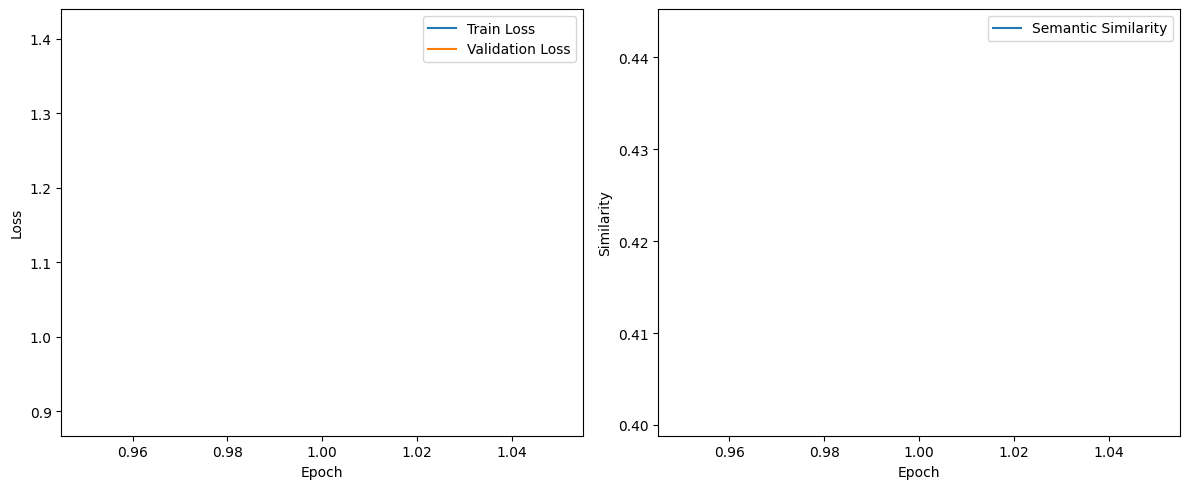

Evaluating:  98%|█████████▊| 59/60 [00:33<00:00,  1.78it/s]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]


========== TEST RESULTS ==========
Test Loss              : 0.9283
Test Semantic Sim     : 0.4356

===== RANDOM TEST EXAMPLES =====

--- Example 173 ---
Raw Report       : 
[ Finding ]_x000D_
Osteoporosis in both foot bones._x000D_
[ Diagnosis ]_x000D_
_x000D_
[ Recommend ]_x000D_

Cleaned Report   : 
Osteoporosis in both foot bones.
Generated Report : 
no bony lesion. no abnormality, interval change or fracture with bone erosions at Rt 1st MTP joint -> r/o gout arthritis degenerative changes --> RA involvement otherwise subchondral cystic formation of both calcaneus and phalanx in left lateral malleolar area (mild type II) old os trigonum diffuse osteopenia mild erosion on radiographs suggested to be proximal metatarsal head rather than talocalcarpetoid coalition Lt 5th MT base suspicious periarticular ossification likely hallux val

--- Example 189 ---
Raw Report       : 
[ Finding ]_x000D_
gout, both feet and ankles, probable both knees._x000D_
[ Conclusion ]_x000D_
gout, both feet

In [8]:
import os
import re
import json
import logging
import unicodedata
import random
from collections import defaultdict, Counter

import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import timm
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)

# =============================================================================
# Utility functions
# =============================================================================

def count_labels(data, target_classes, cfg):
    class_counts = defaultdict(int)
    data_by_class = defaultdict(list)
    for entry in tqdm(data.values(), desc="Counting dataset"):
        lbl = entry.get('class_label', '').lower()
        if lbl in target_classes and os.path.exists(entry['file_path']):
            class_counts[lbl] += 1
            data_by_class[lbl].append(entry)
    return class_counts, data_by_class

def prepare_abnormal_normal_data(data, cfg):
    random.seed(42)
    abnormal = ['ra', 'oa', 'gout']
    normal = ['normal']
    class_counts, data_by_class = count_labels(data, abnormal + normal, cfg)
    combined = {
        'abnormal': sum((data_by_class[c] for c in abnormal), []),
        'normal': data_by_class['normal']
    }
    combined_counts = {
        'abnormal': sum(class_counts[c] for c in abnormal),
        'normal': class_counts['normal']
    }
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(combined.values(), []), combined_counts, combined_counts
    min_count = min(combined_counts.values())
    balanced = []
    final_counts = {}
    for lbl, items in combined.items():
        sampled = random.sample(items, min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    if cfg.DATASET.AUGMENT:
        balanced *= 2
    return balanced, combined_counts, final_counts

def prepare_data(data, target_classes, cfg, is_binary=False):
    random.seed(42)
    if len(target_classes) == 2 and 'abnormal' in target_classes and 'normal' in target_classes:
        logging.info("Using abnormal-vs-normal logic")
        return prepare_abnormal_normal_data(data, cfg)
    class_counts, data_by_class = count_labels(data, target_classes, cfg)
    logging.info(f"Original class distribution: {class_counts}")
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(data_by_class.values(), []), class_counts, class_counts
    min_count = min(class_counts.values())
    balanced, final_counts = [], {}
    for lbl in target_classes:
        sampled = random.sample(data_by_class[lbl], min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    logging.info(f"Balanced class distribution: {final_counts}")
    if cfg.DATASET.AUGMENT:
        balanced *= 2
    return balanced, class_counts, final_counts

# =============================================================================
# Transforms
# =============================================================================

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

patch_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

# =============================================================================
# Dataset
# =============================================================================

class FinalSamplesDataset(Dataset):
    def __init__(self, cfg, tokenizer, image_transform=train_transform, patch_transform=patch_transform):
        self.cfg = cfg
        self.tokenizer = tokenizer
        self.image_transform = image_transform
        self.patch_transform = patch_transform

        # Set EOS/BOS tokens before any cleaning happens
        self.bos_token_id = tokenizer.eos_token_id
        self.eos_token_id = tokenizer.eos_token_id
        self.eos_token = tokenizer.eos_token  # string

        self.target_classes = cfg.DATASET.TARGET_CLASSES
        if isinstance(self.target_classes, str):
            self.target_classes = self.target_classes.split(",")

        self.is_binary = len(self.target_classes) == 2
        self.abnormal_classify = self.is_binary and 'abnormal' in self.target_classes
        self.abnormal_mapping = (
            {'ra': 'abnormal', 'oa': 'abnormal', 'gout': 'abnormal', 'normal': 'normal'}
            if self.abnormal_classify else None
        )

        with open(cfg.DATASET.JSON, 'r') as f:
            raw_list = json.load(f)

        filtered = []
        for item in raw_list:
            merged = item.get('merged_image_path', '')
            fp = item.get('file_paths', [])
            if isinstance(fp, str):
                fp = [fp]
            paths = [merged] + fp
            if any(os.path.exists(p) for p in paths):
                filtered.append((merged, fp, item))

        self.data = {}
        for i, (merged, fp, item) in enumerate(filtered):
            cls = item.get('class', 'unknown').lower()
            if self.abnormal_mapping:
                cls = self.abnormal_mapping.get(cls, cls)
            self.data[i] = {
                'file_path': merged,
                'left_right_file_path': fp,
                'class_label': cls,
                'diagnosis': item.get('diagnosis', ''),
                'keypoints': item.get('keypoints', {})
            }

        # If binary, balance here
        if self.is_binary:
            balanced, _, _ = prepare_data(self.data, self.target_classes, cfg, True)
            self.data = {i: e for i, e in enumerate(balanced)}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        e = self.data[idx]
        img = Image.open(e['file_path']).convert('RGB')
        img = self.image_transform(img)

        patches = self._gen_patches(e['left_right_file_path'], e['keypoints'])
        pt = [self.patch_transform(Image.fromarray(p)) for p in patches]
        patches_tensor = torch.stack(pt, 0) if pt else torch.zeros(34, 3, 112, 112)

        raw = e.get('diagnosis', '')
        clean = self._clean_report(raw)

        # TOKENIZATION: no leaking of tokens, build full seq with BOS/EOS
        token_ids = self.tokenizer.encode(
            clean,
            truncation=True,
            max_length=self.tokenizer.model_max_length - 2,
            add_special_tokens=False
        )
        full_ids = [self.bos_token_id] + token_ids + [self.eos_token_id]
        input_ids = torch.tensor(full_ids, dtype=torch.long)
        attention_mask = torch.ones_like(input_ids)

        return {
            'full_img': img,
            'patches': patches_tensor,
            'raw_report': raw,
            'cleaned_report': clean,
            'input_ids': input_ids,
            'attention_mask': attention_mask
        }

    def _gen_patches(self, paths, kps_dict, crop_size=(200, 300), patch_size=(112, 112)):
        def extract(arr, side_kps):
            lst = []
            pts = side_kps[0]['keypoints']
            for i in range(17):
                x, y, s = int(pts[3*i]), int(pts[3*i+1]), pts[3*i+2]
                if s > 0:
                    x0 = max(x - crop_size[0]//2, 0)
                    y0 = max(y - crop_size[1]//2, 0)
                    x1 = min(x + crop_size[0]//2, arr.shape[1])
                    y1 = min(y + crop_size[1]//2, arr.shape[0])
                    c = arr[y0:y1, x0:x1]
                    if c.size:
                        lst.append(cv2.resize(c, patch_size))
            return lst

        def pad17(lst):
            black = np.zeros((patch_size[1], patch_size[0], 3), np.uint8)
            while len(lst) < 17:
                lst.append(black)
            return lst[:17]

        left, right = [], []
        if len(paths) == 1:
            pth = paths[0]
            if not pth or not os.path.exists(pth):
                return pad17([]) + pad17([])
            img_arr = cv2.imread(pth)
            if img_arr is None:
                return pad17([]) + pad17([])
            arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
            if kps_dict.get('left'): left = extract(arr, kps_dict['left'])
            if kps_dict.get('right'): right = extract(arr, kps_dict['right'])
        else:
            for side, pth in zip(['left', 'right'], paths):
                if pth and os.path.exists(pth):
                    img_arr = cv2.imread(pth)
                    if img_arr is not None:
                        arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
                        if kps_dict.get(side):
                            lst = extract(arr, kps_dict[side])
                            if side == 'left': left = lst
                            else: right = lst

        if left and not right:
            right = [cv2.flip(p, 1) for p in left]
        if right and not left:
            left = [cv2.flip(p, 1) for p in right]
        if not left and not right:
            return pad17([]) + pad17([])

        return pad17(left) + pad17(right)

    def _clean_report(self, text):
        text = unicodedata.normalize('NFKC', text or '')
        text = re.sub(r'(?m)^-+\s*$', '', text)
        text = re.sub(r'[^\x00-\x7F]+', ' ', text)
        text = re.sub(r'([.!?]){2,}', r'\1', text)
        text = re.sub(r'\[\s*finding\s*\]', '[FINDING]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*conclusion\s*\]', '[CONCLUSION]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*diagnosis\s*\]', '[DIAGNOSIS]', text, flags=re.IGNORECASE)
        parts = re.split(r'\[\s*recommend(?:ation)?\s*\]', text, flags=re.IGNORECASE)
        text = parts[0]
        fm = re.search(r'\[FINDING\](.*?)(?=\[|$)', text, flags=re.IGNORECASE | re.DOTALL)
        cm = re.search(r'\[CONCLUSION\](.*?)(?=\[|$)', text, flags=re.IGNORECASE | re.DOTALL)
        if fm and cm and fm.group(1).strip().lower() == cm.group(1).strip().lower():
            text = re.sub(r'\[CONCLUSION\].*?(?=\[|$)', '', text, flags=re.IGNORECASE | re.DOTALL)
        text = re.sub(r'\[\s*(FINDING|CONCLUSION|DIAGNOSIS)\s*\]', '', text, flags=re.IGNORECASE)
        text = text.replace('_x000D_', ' ')
        text = re.sub(r'\s+', ' ', text).strip()
        return text  # EOS will be added in tokenization

# =============================================================================
# Collate function
# =============================================================================
def collate_fn(batch):
    imgs = torch.stack([b['full_img'] for b in batch])
    pts = [b['patches'] for b in batch]
    max_p = max(p.shape[0] for p in pts)
    pads = []
    for p in pts:
        if p.shape[0] < max_p:
            pad = torch.zeros((max_p - p.shape[0], *p.shape[1:]))
            p = torch.cat([p, pad], dim=0)
        pads.append(p)
    patches = torch.stack(pads, 0)

    ids = [b['input_ids'] for b in batch]
    masks = [b['attention_mask'] for b in batch]
    ids = nn.utils.rnn.pad_sequence(ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    masks = nn.utils.rnn.pad_sequence(masks, batch_first=True, padding_value=0)

    return {
        'full_imgs': imgs,
        'patches': patches,
        'input_ids': ids,
        'attention_mask': masks,
        'raw_reports': [b['raw_report'] for b in batch],
        'cleaned_reports': [b['cleaned_report'] for b in batch]
    }

# =============================================================================
# Model
# =============================================================================
class MultiModalModel(nn.Module):
    def __init__(self, gpt2_model_name='gpt2'):
        super().__init__()
        self.global_encoder = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
        self.global_encoder.reset_classifier(0)
        self.global_proj = nn.Linear(self.global_encoder.num_features, 768)

        self.patch_encoder = timm.create_model('resnet50', pretrained=True)
        self.patch_encoder.fc = nn.Identity()
        self.patch_proj = nn.Linear(self.patch_encoder.num_features, 768)

        self.attn = nn.MultiheadAttention(embed_dim=768, num_heads=8, batch_first=True)
        self.norm = nn.LayerNorm(768)

        self.decoder = GPT2LMHeadModel.from_pretrained(gpt2_model_name, add_cross_attention=True)

    def _pool(self, feats):
        return feats.mean(dim=[2, 3]) if feats.ndim > 2 else feats

    def forward(self, imgs, patches, input_ids, attention_mask, decoder_labels=None):
        g = self.global_encoder(imgs)
        g = self.global_proj(g).unsqueeze(1)

        B, N, C, H, W = patches.shape
        p = patches.view(B * N, C, H, W)
        pf = (self.patch_encoder.forward_features(p)
              if hasattr(self.patch_encoder, 'forward_features')
              else self.patch_encoder(p))
        pf = self._pool(pf)
        pf = self.patch_proj(pf)
        pf = pf.view(B, N, 768)

        cat = torch.cat([g, pf], dim=1)
        comb, _ = self.attn(cat, cat, cat)
        comb = self.norm(comb)

        return self.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=comb,
            labels=decoder_labels
        )

# =============================================================================
# Train / Eval helpers
# =============================================================================

def train_epoch(model, loader, optimizer, scaler, device):
    model.train()
    total_loss = 0.0
    for b in tqdm(loader, desc="Training", leave=False):
        imgs = b['full_imgs'].to(device)
        pts = b['patches'].to(device)
        ids = b['input_ids'].to(device)
        msk = b['attention_mask'].to(device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            loss = out.loss
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.0
    all_gen, all_gt = [], []

    for b in tqdm(loader, desc="Evaluating", leave=False):
        imgs = b['full_imgs'].to(device)
        pts = b['patches'].to(device)
        ids = b['input_ids'].to(device)
        msk = b['attention_mask'].to(device)

        with torch.no_grad():
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            total_loss += out.loss.item()

            # START ONLY FROM BOS
            B = ids.size(0)
            prompt = torch.full((B, 1), tokenizer.eos_token_id,
                                dtype=ids.dtype, device=device)

            # build encoder_hidden_states
            g = model.global_encoder(imgs)
            g = model.global_proj(g).unsqueeze(1)
            B, N, C, H, W = pts.shape
            p = pts.view(B * N, C, H, W)
            pf = model.patch_encoder(p)
            pf = model._pool(pf)
            pf = model.patch_proj(pf)
            pf = pf.view(B, N, 768)

            cat = torch.cat([g, pf], dim=1)
            comb, _ = model.attn(cat, cat, cat)
            comb = model.norm(comb)

            gen_ids = model.decoder.generate(
                input_ids=prompt,
                encoder_hidden_states=comb,
                attention_mask=torch.ones_like(prompt),
                max_length=100,
                do_sample=True,
                top_k=50,
                top_p=0.95,
                temperature=0.7,
                repetition_penalty=1.2,
                eos_token_id=tokenizer.eos_token_id,
                pad_token_id=tokenizer.eos_token_id
            )

            gen_txt = [tokenizer.decode(g_, skip_special_tokens=True) for g_ in gen_ids]
            gt_txt = [tokenizer.decode(i_, skip_special_tokens=True) for i_ in ids]
            all_gen.extend(gen_txt)
            all_gt.extend(gt_txt)

    return total_loss / len(loader), all_gen, all_gt

def compute_semantic_similarity(gen, gt):
    stm = SentenceTransformer('all-MiniLM-L6-v2')
    e1 = stm.encode(gen, convert_to_tensor=True)
    e2 = stm.encode(gt, convert_to_tensor=True)
    return nn.functional.cosine_similarity(e1, e2).mean().item()

def plot_metrics(train_losses, val_losses, sems):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, sems, label="Semantic Similarity")
    plt.xlabel("Epoch")
    plt.ylabel("Similarity")
    plt.legend()

    plt.tight_layout()
    plt.show()

# =============================================================================
# MAIN
# =============================================================================

class Cfg: pass
cfg = Cfg()
cfg.DATASET = Cfg()
cfg.DATASET.JSON = 'final_samples_both_only_v2.json'
cfg.DATASET.USE_RAW = True
cfg.DATASET.USE_PATCH = True
cfg.DATASET.REPORT = True
cfg.DATASET.TARGET_CLASSES = ['ra', 'oa', 'gout', 'normal', 'uncertain', 'ref.prev']
cfg.DATASET.BALANCE = False
cfg.DATASET.AUGMENT = False

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

dataset = FinalSamplesDataset(cfg, tokenizer)

dist = Counter(e['class_label'] for e in dataset.data.values())
print("\nDataset class distribution:")
for cls, cnt in dist.items():
    print(f"  {cls}: {cnt}")

n = len(dataset)
n_train = int(0.8 * n)
n_val = int(0.1 * n)
n_test = n - n_train - n_val

train_ds, val_ds, test_ds = random_split(dataset, [n_train, n_val, n_test])

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_ds, batch_size=4, shuffle=False, collate_fn=collate_fn)

model = MultiModalModel().to(device)
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
scaler = torch.cuda.amp.GradScaler()

num_epochs = 1
train_losses, val_losses, sems = [], [], []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    train_loss = train_epoch(model, train_loader, optimizer, scaler, device)
    val_loss, gen_txt, gt_txt = evaluate(model, val_loader, device)
    sem = compute_semantic_similarity(gen_txt, gt_txt)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    sems.append(sem)

    print(f"  Train Loss          : {train_loss:.4f}")
    print(f"  Validation Loss     : {val_loss:.4f}")
    print(f"  Semantic Similarity : {sem:.4f}")
    scheduler.step()

plot_metrics(train_losses, val_losses, sems)

test_loss, test_gen, test_gt = evaluate(model, test_loader, device)
test_sem = compute_semantic_similarity(test_gen, test_gt)

print("\n========== TEST RESULTS ==========")
print(f"Test Loss              : {test_loss:.4f}")
print(f"Test Semantic Sim     : {test_sem:.4f}")

print("\n===== RANDOM TEST EXAMPLES =====")
for idx in random.sample(range(len(test_ds)), min(10, len(test_ds))):
    ex = test_ds[idx]
    raw = ex['raw_report']
    clean = ex['cleaned_report']
    fi = ex['full_img'].unsqueeze(0).to(device)
    pa = ex['patches'].unsqueeze(0).to(device)
    prompt = torch.full((1, 1), tokenizer.eos_token_id, dtype=torch.long, device=device)

    g = model.global_encoder(fi)
    g = model.global_proj(g).unsqueeze(1)
    B, N, C, H, W = pa.shape
    p = pa.view(B * N, C, H, W)
    pf = model.patch_encoder(p)
    pf = model._pool(pf)
    pf = model.patch_proj(pf)
    pf = pf.view(B, N, 768)

    cat = torch.cat([g, pf], dim=1)
    comb, _ = model.attn(cat, cat, cat)
    comb = model.norm(comb)

    gen_ids = model.decoder.generate(
        input_ids=prompt,
        encoder_hidden_states=comb,
        attention_mask=torch.ones_like(prompt),
        max_length=120,
        do_sample=True,
        top_k=40,
        top_p=0.95,
        temperature=0.5,
        repetition_penalty=1.3,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id
    )

    gen = tokenizer.decode(gen_ids[0], skip_special_tokens=True)

    print(f"\n--- Example {idx} ---")
    print(f"Raw Report       : \n{raw}")
    print(f"Cleaned Report   : \n{clean}")
    print(f"Generated Report : \n{gen}")


Using device: cuda

Dataset class distribution:
  oa: 573
  ra: 115
  uncertain: 620
  oa, ra: 8
  normal: 748
  gout: 267
  combination of oa, ra: 3
  ref.prev: 60


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/swin_base_patch4_window7_224.ms_in22k_ft_in1k)
INFO:timm.models._hub:[timm/swin_base_patch4_window7_224.ms_in22k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/resnet50.a1_in1k)
INFO:timm.models._hub:[timm/resnet50.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossatten


Epoch 1/5


Training:   0%|          | 0/479 [00:00<?, ?it/s]/tmp/ipykernel_56903/554444045.py:357: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluating:  98%|█████████▊| 59/60 [00:33<00:00,  1.80it/s]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.4043
  Validation Loss     : 0.9345
  Semantic Similarity : 0.4250

Epoch 2/5


Evaluating:  98%|█████████▊| 59/60 [00:33<00:00,  1.81it/s]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.9084
  Validation Loss     : 0.8253
  Semantic Similarity : 0.4250

Epoch 3/5


Evaluating:  98%|█████████▊| 59/60 [00:33<00:00,  1.80it/s]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.7952
  Validation Loss     : 0.7916
  Semantic Similarity : 0.4360

Epoch 4/5


Evaluating:  98%|█████████▊| 59/60 [00:33<00:00,  1.80it/s]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.7141
  Validation Loss     : 0.7831
  Semantic Similarity : 0.4310

Epoch 5/5


Evaluating:  98%|█████████▊| 59/60 [00:33<00:00,  1.81it/s]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.6607
  Validation Loss     : 0.7613
  Semantic Similarity : 0.4321


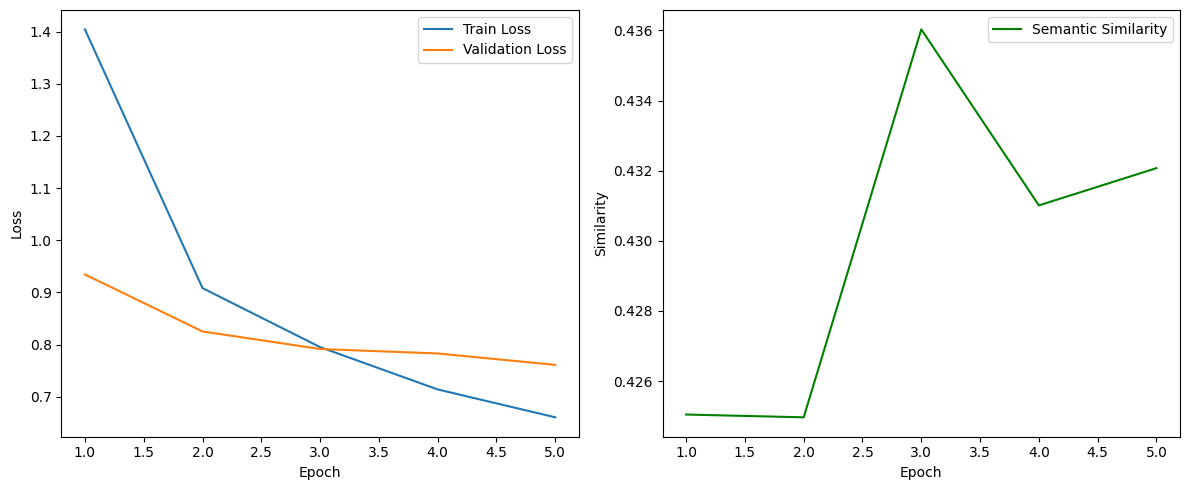

Evaluating:  98%|█████████▊| 59/60 [00:32<00:00,  1.79it/s]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]


========== TEST RESULTS ==========
Test Loss              : 0.7589
Test Semantic Sim     : 0.4253

===== RANDOM TEST EXAMPLES =====

--- Example 139 ---
Raw Report       : 
[ Finding ]_x000D_
no significant bony abnormality_x000D_
[ Conclusion ]_x000D_
no significant bony abnormality_x000D_
[ Recommend ]_x000D_

Cleaned Report   : 
no significant bony abnormality
Generated Report : 
 no significant bony lesion on radiographs. both ankle OA with suspicious erosion at Rt 1st MTP joint -> RA involvement, more likely mild degenerative change of right foot and left talonavicular bone head area in medial portion or posterior aspect rather than lateral malleolus tendon insertion site --> gout arthritis suggested (R/O tophi) rec> clinical correlation vs probable old fracture(sue osteopenia). otherwise minimal ossification deposition over righ 5th MT base island adjacent territory subchondral cysts (+/-4rd MC shaft),

--- Example 107 ---
Raw Report       : 
[ Finding ]_x000D_
_x000D_
[ Diagnos

In [10]:
import os
import re
import json
import logging
import unicodedata
import random
from collections import defaultdict, Counter

import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import timm
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)

# =============================================================================
# Utility functions
# =============================================================================

def count_labels(data, target_classes, cfg):
    class_counts = defaultdict(int)
    data_by_class = defaultdict(list)
    for entry in tqdm(data.values(), desc="Counting dataset"):
        lbl = entry.get('class_label', '').lower()
        if lbl in target_classes and os.path.exists(entry['file_path']):
            class_counts[lbl] += 1
            data_by_class[lbl].append(entry)
    return class_counts, data_by_class

def prepare_abnormal_normal_data(data, cfg):
    random.seed(42)
    abnormal = ['ra', 'oa', 'gout']
    normal = ['normal']
    class_counts, data_by_class = count_labels(data, abnormal + normal, cfg)
    combined = {
        'abnormal': sum((data_by_class[c] for c in abnormal), []),
        'normal': data_by_class['normal']
    }
    combined_counts = {
        'abnormal': sum(class_counts[c] for c in abnormal),
        'normal': class_counts['normal']
    }
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(combined.values(), []), combined_counts, combined_counts
    min_count = min(combined_counts.values())
    balanced = []
    final_counts = {}
    for lbl, items in combined.items():
        sampled = random.sample(items, min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    if cfg.DATASET.AUGMENT:
        balanced *= 2
    return balanced, combined_counts, final_counts

def prepare_data(data, target_classes, cfg, is_binary=False):
    random.seed(42)
    if len(target_classes) == 2 and 'abnormal' in target_classes and 'normal' in target_classes:
        logging.info("Using abnormal-vs-normal logic")
        return prepare_abnormal_normal_data(data, cfg)
    class_counts, data_by_class = count_labels(data, target_classes, cfg)
    logging.info(f"Original class distribution: {class_counts}")
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(data_by_class.values(), []), class_counts, class_counts
    min_count = min(class_counts.values())
    balanced, final_counts = [], {}
    for lbl in target_classes:
        sampled = random.sample(data_by_class[lbl], min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    logging.info(f"Balanced class distribution: {final_counts}")
    if cfg.DATASET.AUGMENT:
        balanced *= 2
    return balanced, class_counts, final_counts

# =============================================================================
# Transforms
# =============================================================================

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

patch_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

# =============================================================================
# Dataset
# =============================================================================

class FinalSamplesDataset(Dataset):
    def __init__(self, cfg, image_transform=train_transform, patch_transform=patch_transform):
        self.cfg = cfg
        self.image_transform = image_transform
        self.patch_transform = patch_transform

        self.target_classes = cfg.DATASET.TARGET_CLASSES
        if isinstance(self.target_classes, str):
            self.target_classes = self.target_classes.split(",")

        self.is_binary = len(self.target_classes) == 2
        self.abnormal_classify = self.is_binary and 'abnormal' in self.target_classes
        self.abnormal_mapping = (
            {'ra': 'abnormal', 'oa': 'abnormal', 'gout': 'abnormal', 'normal': 'normal'}
            if self.abnormal_classify else None
        )

        with open(cfg.DATASET.JSON, 'r') as f:
            raw_list = json.load(f)

        filtered = []
        for item in raw_list:
            merged = item.get('merged_image_path', '')
            fp = item.get('file_paths', [])
            if isinstance(fp, str):
                fp = [fp]
            paths = [merged] + fp
            if any(os.path.exists(p) for p in paths):
                filtered.append((merged, fp, item))

        self.data = {}
        for i, (merged, fp, item) in enumerate(filtered):
            cls = item.get('class', 'unknown').lower()
            if self.abnormal_mapping:
                cls = self.abnormal_mapping.get(cls, cls)
            self.data[i] = {
                'file_path': merged,
                'left_right_file_path': fp,
                'class_label': cls,
                'diagnosis': item.get('diagnosis', ''),
                'keypoints': item.get('keypoints', {})
            }

        if self.is_binary:
            balanced, _, _ = prepare_data(self.data, self.target_classes, cfg, True)
            self.data = {i: e for i, e in enumerate(balanced)}

        self.tokenizer = None
        self.eos_token = None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        e = self.data[idx]
        img = Image.open(e['file_path']).convert('RGB')
        img = self.image_transform(img)

        patches = self._gen_patches(e['left_right_file_path'], e['keypoints'])
        pt = [self.patch_transform(Image.fromarray(p)) for p in patches]
        patches_tensor = torch.stack(pt, 0) if pt else torch.zeros(34, 3, 112, 112)

        raw = e.get('diagnosis', '')
        clean = self._clean_report(raw)
        
        # Add BOS token to the beginning of the report
        input_text = f"{self.tokenizer.bos_token} {clean}"
        
        # Tokenize with truncation and ensuring EOS token at end
        tok = self.tokenizer(input_text, truncation=True, max_length=511, return_tensors='pt')
        
        # Add EOS token if not already present
        if tok['input_ids'][0][-1] != self.tokenizer.eos_token_id:
            input_ids = torch.cat([tok['input_ids'], torch.tensor([[self.tokenizer.eos_token_id]])], dim=1)
            attention_mask = torch.cat([tok['attention_mask'], torch.tensor([[1]])], dim=1)
        else:
            input_ids = tok['input_ids']
            attention_mask = tok['attention_mask']

        return {
            'full_img': img,
            'patches': patches_tensor,
            'raw_report': raw,
            'cleaned_report': clean,
            'input_ids': input_ids.squeeze(0),
            'attention_mask': attention_mask.squeeze(0)
        }

    def _gen_patches(self, paths, kps_dict, crop_size=(200, 300), patch_size=(112, 112)):
        def extract(arr, side_kps):
            lst = []
            pts = side_kps[0]['keypoints']
            for i in range(17):
                x, y, s = int(pts[3*i]), int(pts[3*i+1]), pts[3*i+2]
                if s > 0:
                    x0 = max(x - crop_size[0]//2, 0)
                    y0 = max(y - crop_size[1]//2, 0)
                    x1 = min(x + crop_size[0]//2, arr.shape[1])
                    y1 = min(y + crop_size[1]//2, arr.shape[0])
                    c = arr[y0:y1, x0:x1]
                    if c.size:
                        lst.append(cv2.resize(c, patch_size))
            return lst

        def pad17(lst):
            black = np.zeros((patch_size[1], patch_size[0], 3), np.uint8)
            while len(lst) < 17:
                lst.append(black)
            return lst[:17]

        left, right = [], []
        if len(paths) == 1:
            pth = paths[0]
            if not pth or not os.path.exists(pth):
                return pad17([]) + pad17([])
            img_arr = cv2.imread(pth)
            if img_arr is None:
                return pad17([]) + pad17([])
            arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
            if kps_dict.get('left'): left = extract(arr, kps_dict['left'])
            if kps_dict.get('right'): right = extract(arr, kps_dict['right'])
        else:
            for side, pth in zip(['left', 'right'], paths):
                if pth and os.path.exists(pth):
                    img_arr = cv2.imread(pth)
                    if img_arr is not None:
                        arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
                        if kps_dict.get(side):
                            lst = extract(arr, kps_dict[side])
                            if side == 'left': left = lst
                            else: right = lst

        if left and not right:
            right = [cv2.flip(p, 1) for p in left]
        if right and not left:
            left = [cv2.flip(p, 1) for p in right]
        if not left and not right:
            return pad17([]) + pad17([])

        return pad17(left) + pad17(right)

    def _clean_report(self, text):
        text = unicodedata.normalize('NFKC', text or '')
        text = re.sub(r'(?m)^-+\s*$', '', text)
        text = re.sub(r'[^\x00-\x7F]+', ' ', text)
        text = re.sub(r'([.!?]){2,}', r'\1', text)
        text = re.sub(r'\[\s*finding\s*\]', '[FINDING]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*conclusion\s*\]', '[CONCLUSION]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*diagnosis\s*\]', '[DIAGNOSIS]', text, flags=re.IGNORECASE)
        parts = re.split(r'\[\s*recommend(?:ation)?\s*\]', text, flags=re.IGNORECASE)
        text = parts[0]
        fm = re.search(r'\[FINDING\](.*?)(?=\[|$)', text, flags=re.IGNORECASE | re.DOTALL)
        cm = re.search(r'\[CONCLUSION\](.*?)(?=\[|$)', text, flags=re.IGNORECASE | re.DOTALL)
        if fm and cm and fm.group(1).strip().lower() == cm.group(1).strip().lower():
            text = re.sub(r'\[CONCLUSION\].*?(?=\[|$)', '', text, flags=re.IGNORECASE | re.DOTALL)
        text = re.sub(r'\[\s*(FINDING|CONCLUSION|DIAGNOSIS)\s*\]', '', text, flags=re.IGNORECASE)
        text = text.replace('_x000D_', ' ')
        text = re.sub(r'\s+', ' ', text).strip()
        return text

# =============================================================================
# Collate function
# =============================================================================
def collate_fn(batch):
    imgs = torch.stack([b['full_img'] for b in batch])
    pts = [b['patches'] for b in batch]
    max_p = max(p.shape[0] for p in pts)
    pads = []
    for p in pts:
        if p.shape[0] < max_p:
            pad = torch.zeros((max_p - p.shape[0], *p.shape[1:]))
            p = torch.cat([p, pad], dim=0)
        pads.append(p)
    patches = torch.stack(pads, 0)

    ids = [b['input_ids'] for b in batch]
    masks = [b['attention_mask'] for b in batch]
    ids = nn.utils.rnn.pad_sequence(ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    masks = nn.utils.rnn.pad_sequence(masks, batch_first=True, padding_value=0)

    return {
        'full_imgs': imgs,
        'patches': patches,
        'input_ids': ids,
        'attention_mask': masks,
        'raw_reports': [b['raw_report'] for b in batch],
        'cleaned_reports': [b['cleaned_report'] for b in batch]
    }

# =============================================================================
# Model
# =============================================================================
class MultiModalModel(nn.Module):
    def __init__(self, gpt2_model_name='gpt2'):
        super().__init__()
        self.global_encoder = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
        self.global_encoder.reset_classifier(0)
        self.global_proj = nn.Linear(self.global_encoder.num_features, 768)

        self.patch_encoder = timm.create_model('resnet50', pretrained=True)
        self.patch_encoder.fc = nn.Identity()
        self.patch_proj = nn.Linear(self.patch_encoder.num_features, 768)

        self.attn = nn.MultiheadAttention(embed_dim=768, num_heads=8, batch_first=True)
        self.norm = nn.LayerNorm(768)

        self.decoder = GPT2LMHeadModel.from_pretrained(gpt2_model_name, add_cross_attention=True)

    def _pool(self, feats):
        return feats.mean(dim=[2, 3]) if feats.ndim > 2 else feats

    def forward(self, imgs, patches, input_ids, attention_mask, decoder_labels=None):
        g = self.global_encoder(imgs)
        g = self.global_proj(g).unsqueeze(1)

        B, N, C, H, W = patches.shape
        p = patches.view(B * N, C, H, W)
        pf = (self.patch_encoder.forward_features(p)
              if hasattr(self.patch_encoder, 'forward_features')
              else self.patch_encoder(p))
        pf = self._pool(pf)
        pf = self.patch_proj(pf)
        pf = pf.view(B, N, 768)

        cat = torch.cat([g, pf], dim=1)
        comb, _ = self.attn(cat, cat, cat)
        comb = self.norm(comb)

        return self.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=comb,
            labels=decoder_labels
        )

# =============================================================================
# Train / Eval helpers
# =============================================================================

def train_epoch(model, loader, optimizer, scaler, device):
    model.train()
    total_loss = 0.0
    for b in tqdm(loader, desc="Training", leave=False):
        imgs = b['full_imgs'].to(device)
        pts = b['patches'].to(device)
        ids = b['input_ids'].to(device)
        msk = b['attention_mask'].to(device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            loss = out.loss
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.0
    all_gen, all_gt = [], []

    for b in tqdm(loader, desc="Evaluating", leave=False):
        imgs = b['full_imgs'].to(device)
        pts = b['patches'].to(device)
        ids = b['input_ids'].to(device)
        msk = b['attention_mask'].to(device)

        with torch.no_grad():
            # Calculate loss using full ground truth
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            total_loss += out.loss.item()

            # For generation, use only BOS token as input
            bos_tokens = torch.tensor([[tokenizer.bos_token_id]] * imgs.size(0), device=device)

            g = model.global_encoder(imgs)
            g = model.global_proj(g).unsqueeze(1)

            B, N, C, H, W = pts.shape
            p = pts.view(B * N, C, H, W)
            pf = model.patch_encoder(p)
            pf = model._pool(pf)
            pf = model.patch_proj(pf)
            pf = pf.view(B, N, 768)

            cat = torch.cat([g, pf], dim=1)
            comb, _ = model.attn(cat, cat, cat)
            comb = model.norm(comb)

            gen_ids = model.decoder.generate(
                input_ids=bos_tokens,
                encoder_hidden_states=comb,
                attention_mask=torch.ones_like(bos_tokens),
                max_length=100,
                do_sample=True,
                top_k=50,
                top_p=0.95,
                temperature=0.7,
                repetition_penalty=1.2,
                eos_token_id=tokenizer.eos_token_id,
                pad_token_id=tokenizer.eos_token_id
            )

            gen_txt = [tokenizer.decode(g_, skip_special_tokens=True) for g_ in gen_ids]
            gt_txt = [tokenizer.decode(i_, skip_special_tokens=True) for i_ in ids]
            all_gen.extend(gen_txt)
            all_gt.extend(gt_txt)

    return total_loss / len(loader), all_gen, all_gt

def compute_semantic_similarity(gen, gt):
    stm = SentenceTransformer('all-MiniLM-L6-v2')
    e1 = stm.encode(gen, convert_to_tensor=True)
    e2 = stm.encode(gt, convert_to_tensor=True)
    return nn.functional.cosine_similarity(e1, e2).mean().item()

def plot_metrics(train_losses, val_losses, sems):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, sems, label="Semantic Similarity", color='green')
    plt.xlabel("Epoch")
    plt.ylabel("Similarity")
    plt.legend()

    plt.tight_layout()
    plt.show()

# =============================================================================
# MAIN
# =============================================================================

class Cfg: pass
cfg = Cfg()
cfg.DATASET = Cfg()
cfg.DATASET.JSON = 'final_samples_both_only_v2.json'
cfg.DATASET.USE_RAW = True
cfg.DATASET.USE_PATCH = True
cfg.DATASET.REPORT = True
cfg.DATASET.TARGET_CLASSES = ['ra', 'oa', 'gout', 'normal', 'uncertain', 'ref.prev']
cfg.DATASET.BALANCE = False
cfg.DATASET.AUGMENT = False

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

dataset = FinalSamplesDataset(cfg)
dataset.tokenizer = tokenizer
dataset.eos_token = tokenizer.eos_token

dist = Counter(e['class_label'] for e in dataset.data.values())
print("\nDataset class distribution:")
for cls, cnt in dist.items():
    print(f"  {cls}: {cnt}")

n = len(dataset)
n_train = int(0.8 * n)
n_val = int(0.1 * n)
n_test = n - n_train - n_val

train_ds, val_ds, test_ds = random_split(dataset, [n_train, n_val, n_test])

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_ds, batch_size=4, shuffle=False, collate_fn=collate_fn)

model = MultiModalModel().to(device)
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
scaler = torch.cuda.amp.GradScaler()

num_epochs = 5
train_losses, val_losses, sems = [], [], []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    train_loss = train_epoch(model, train_loader, optimizer, scaler, device)
    val_loss, gen_txt, gt_txt = evaluate(model, val_loader, device)
    sem = compute_semantic_similarity(gen_txt, gt_txt)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    sems.append(sem)

    print(f"  Train Loss          : {train_loss:.4f}")
    print(f"  Validation Loss     : {val_loss:.4f}")
    print(f"  Semantic Similarity : {sem:.4f}")
    scheduler.step()

plot_metrics(train_losses, val_losses, sems)

test_loss, test_gen, test_gt = evaluate(model, test_loader, device)
test_sem = compute_semantic_similarity(test_gen, test_gt)

print("\n========== TEST RESULTS ==========")
print(f"Test Loss              : {test_loss:.4f}")
print(f"Test Semantic Sim     : {test_sem:.4f}")

print("\n===== RANDOM TEST EXAMPLES =====")
for idx in random.sample(range(len(test_ds)), min(10, len(test_ds))):
    ex = test_ds[idx]
    raw = ex['raw_report']
    clean = ex['cleaned_report']
    fi = ex['full_img'].unsqueeze(0).to(device)
    pa = ex['patches'].unsqueeze(0).to(device)
    
    # Use only BOS token for generation
    prompt = torch.tensor([[tokenizer.bos_token_id]], device=device)

    g = model.global_encoder(fi)
    g = model.global_proj(g).unsqueeze(1)
    B, N, C, H, W = pa.shape
    p = pa.view(B * N, C, H, W)
    pf = model.patch_encoder(p)
    pf = model._pool(pf)
    pf = model.patch_proj(pf)
    pf = pf.view(B, N, 768)

    cat = torch.cat([g, pf], dim=1)
    comb, _ = model.attn(cat, cat, cat)
    comb = model.norm(comb)

    gen_ids = model.decoder.generate(
        input_ids=prompt,
        encoder_hidden_states=comb,
        attention_mask=torch.ones_like(prompt),
        max_length=120,
        do_sample=True,
        top_k=40,
        top_p=0.95,
        temperature=0.5,
        repetition_penalty=1.3,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id
    )

    gen = tokenizer.decode(gen_ids[0], skip_special_tokens=True)

    print(f"\n--- Example {idx} ---")
    print(f"Raw Report       : \n{raw}")
    print(f"Cleaned Report   : \n{clean}")
    print(f"Generated Report : \n{gen}")


Using device: cuda

Dataset class distribution:
  oa: 573
  ra: 115
  uncertain: 620
  oa, ra: 8
  normal: 748
  gout: 267
  combination of oa, ra: 3
  ref.prev: 60


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/swin_base_patch4_window7_224.ms_in22k_ft_in1k)
INFO:timm.models._hub:[timm/swin_base_patch4_window7_224.ms_in22k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/resnet50.a1_in1k)
INFO:timm.models._hub:[timm/resnet50.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossatten


Epoch 1/5


Training:   0%|          | 0/479 [00:00<?, ?it/s]/tmp/ipykernel_56903/3352693259.py:357: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluating:  98%|█████████▊| 59/60 [00:25<00:00,  2.29it/s]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.3992
  Validation Loss     : 0.8406
  Semantic Similarity : 0.4078

Epoch 2/5


Evaluating:  98%|█████████▊| 59/60 [00:25<00:00,  2.21it/s]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.9141
  Validation Loss     : 0.7609
  Semantic Similarity : 0.4083

Epoch 3/5


Evaluating:  98%|█████████▊| 59/60 [00:25<00:00,  2.28it/s]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.7884
  Validation Loss     : 0.7287
  Semantic Similarity : 0.4097

Epoch 4/5


Evaluating:  98%|█████████▊| 59/60 [00:26<00:00,  2.28it/s]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.7031
  Validation Loss     : 0.7187
  Semantic Similarity : 0.4011

Epoch 5/5


Evaluating:  98%|█████████▊| 59/60 [00:25<00:00,  2.26it/s]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.6491
  Validation Loss     : 0.7134
  Semantic Similarity : 0.4020


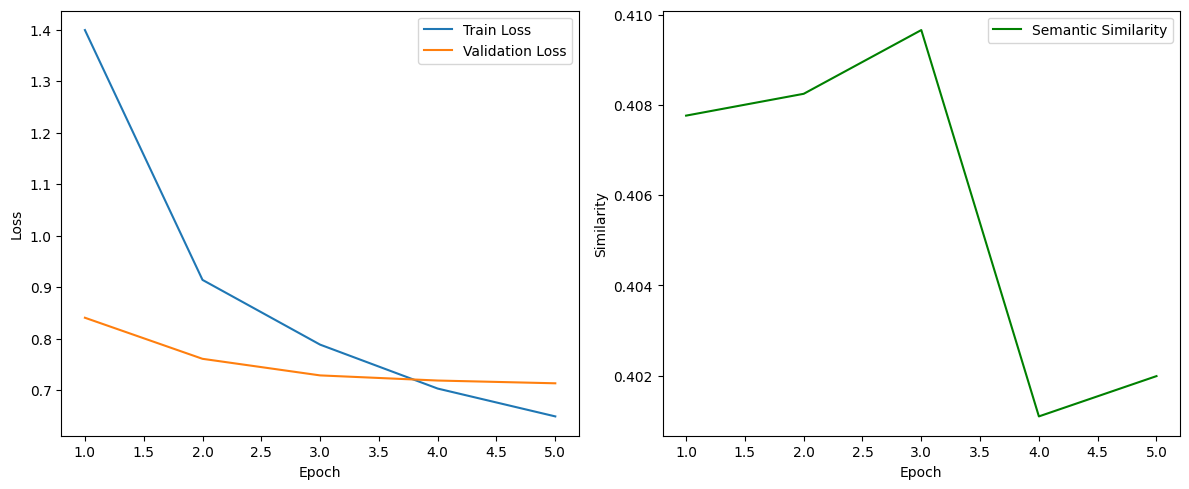

Evaluating:  98%|█████████▊| 59/60 [00:25<00:00,  2.28it/s]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]


========== TEST RESULTS ==========
Test Loss              : 0.7482
Test Semantic Sim     : 0.4262

===== RANDOM TEST EXAMPLES =====

--- Example 212 ---
Raw Report       : 
[ Finding ]_x000D_
_x000D_
[ Diagnosis ]_x000D_
1. Possible S/P fusion operation of left ankle and subtalar joint._x000D_
2. Joint space narrowing in both 1st MTP, right 1st-5th TMT and both midfoot._x000D_
 - With deformity of right navicular bone, right medial and intermediate cuneiform._x000D_
3. Diffuse osteopenia._x000D_
4. Both flat foot._x000D_
_x000D_
[ Recommend ]_x000D_

Cleaned Report   : 
1. Possible S/P fusion operation of left ankle and subtalar joint. 2. Joint space narrowing in both 1st MTP, right 1st-5th TMT and both midfoot. - With deformity of right navicular bone, right medial and intermediate cuneiform. 3. Diffuse osteopenia. 4. Both flat foot.
Generated Report : 
 Rt. ankle joint effusion Lt. knee, gout arthritis both 1st MTP joints and medial hallux valgus degenerative change with suspicious 

In [17]:
import os
import re
import json
import logging
import unicodedata
import random
from collections import defaultdict, Counter

import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import timm
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)

# =============================================================================
# Utility functions
# =============================================================================

def count_labels(data, target_classes, cfg):
    class_counts = defaultdict(int)
    data_by_class = defaultdict(list)
    for entry in tqdm(data.values(), desc="Counting dataset"):
        lbl = entry.get('class_label', '').lower()
        if lbl in target_classes and os.path.exists(entry['file_path']):
            class_counts[lbl] += 1
            data_by_class[lbl].append(entry)
    return class_counts, data_by_class

def prepare_abnormal_normal_data(data, cfg):
    random.seed(42)
    abnormal = ['ra', 'oa', 'gout']
    normal = ['normal']
    class_counts, data_by_class = count_labels(data, abnormal + normal, cfg)
    combined = {
        'abnormal': sum((data_by_class[c] for c in abnormal), []),
        'normal': data_by_class['normal']
    }
    combined_counts = {
        'abnormal': sum(class_counts[c] for c in abnormal),
        'normal': class_counts['normal']
    }
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(combined.values(), []), combined_counts, combined_counts
    min_count = min(combined_counts.values())
    balanced = []
    final_counts = {}
    for lbl, items in combined.items():
        sampled = random.sample(items, min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    if cfg.DATASET.AUGMENT:
        balanced *= 2
    return balanced, combined_counts, final_counts

def prepare_data(data, target_classes, cfg, is_binary=False):
    random.seed(42)
    if len(target_classes) == 2 and 'abnormal' in target_classes and 'normal' in target_classes:
        logging.info("Using abnormal-vs-normal logic")
        return prepare_abnormal_normal_data(data, cfg)
    class_counts, data_by_class = count_labels(data, target_classes, cfg)
    logging.info(f"Original class distribution: {class_counts}")
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(data_by_class.values(), []), class_counts, class_counts
    min_count = min(class_counts.values())
    balanced, final_counts = [], {}
    for lbl in target_classes:
        sampled = random.sample(data_by_class[lbl], min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    logging.info(f"Balanced class distribution: {final_counts}")
    if cfg.DATASET.AUGMENT:
        balanced *= 2
    return balanced, class_counts, final_counts

# =============================================================================
# Transforms
# =============================================================================

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

patch_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

# =============================================================================
# Dataset
# =============================================================================

class FinalSamplesDataset(Dataset):
    def __init__(self, cfg, image_transform=train_transform, patch_transform=patch_transform):
        self.cfg = cfg
        self.image_transform = image_transform
        self.patch_transform = patch_transform

        self.target_classes = cfg.DATASET.TARGET_CLASSES
        if isinstance(self.target_classes, str):
            self.target_classes = self.target_classes.split(",")

        self.is_binary = len(self.target_classes) == 2
        self.abnormal_classify = self.is_binary and 'abnormal' in self.target_classes
        self.abnormal_mapping = (
            {'ra': 'abnormal', 'oa': 'abnormal', 'gout': 'abnormal', 'normal': 'normal'}
            if self.abnormal_classify else None
        )

        with open(cfg.DATASET.JSON, 'r') as f:
            raw_list = json.load(f)

        filtered = []
        for item in raw_list:
            merged = item.get('merged_image_path', '')
            fp = item.get('file_paths', [])
            if isinstance(fp, str):
                fp = [fp]
            paths = [merged] + fp
            if any(os.path.exists(p) for p in paths):
                filtered.append((merged, fp, item))

        self.data = {}
        for i, (merged, fp, item) in enumerate(filtered):
            cls = item.get('class', 'unknown').lower()
            if self.abnormal_mapping:
                cls = self.abnormal_mapping.get(cls, cls)
            self.data[i] = {
                'file_path': merged,
                'left_right_file_path': fp,
                'class_label': cls,
                'diagnosis': item.get('diagnosis', ''),
                'keypoints': item.get('keypoints', {})
            }

        if self.is_binary:
            balanced, _, _ = prepare_data(self.data, self.target_classes, cfg, True)
            self.data = {i: e for i, e in enumerate(balanced)}

        self.tokenizer = None
        self.eos_token = None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        e = self.data[idx]
        img = Image.open(e['file_path']).convert('RGB')
        img = self.image_transform(img)

        patches = self._gen_patches(e['left_right_file_path'], e['keypoints'])
        pt = [self.patch_transform(Image.fromarray(p)) for p in patches]
        patches_tensor = torch.stack(pt, 0) if pt else torch.zeros(34, 3, 112, 112)

        raw = e.get('diagnosis', '')
        clean = self._clean_report(raw)
        
        # Add BOS token to the beginning of the report
        input_text = f"{self.tokenizer.bos_token} {clean}"
        
        # Tokenize with truncation and ensuring EOS token at end
        tok = self.tokenizer(input_text, truncation=True, max_length=511, return_tensors='pt')
        
        # Add EOS token if not already present
        if tok['input_ids'][0][-1] != self.tokenizer.eos_token_id:
            input_ids = torch.cat([tok['input_ids'], torch.tensor([[self.tokenizer.eos_token_id]])], dim=1)
            attention_mask = torch.cat([tok['attention_mask'], torch.tensor([[1]])], dim=1)
        else:
            input_ids = tok['input_ids']
            attention_mask = tok['attention_mask']

        return {
            'full_img': img,
            'patches': patches_tensor,
            'raw_report': raw,
            'cleaned_report': clean,
            'input_ids': input_ids.squeeze(0),
            'attention_mask': attention_mask.squeeze(0)
        }

    def _gen_patches(self, paths, kps_dict, crop_size=(200, 300), patch_size=(112, 112)):
        def extract(arr, side_kps):
            lst = []
            pts = side_kps[0]['keypoints']
            for i in range(17):
                x, y, s = int(pts[3*i]), int(pts[3*i+1]), pts[3*i+2]
                if s > 0:
                    x0 = max(x - crop_size[0]//2, 0)
                    y0 = max(y - crop_size[1]//2, 0)
                    x1 = min(x + crop_size[0]//2, arr.shape[1])
                    y1 = min(y + crop_size[1]//2, arr.shape[0])
                    c = arr[y0:y1, x0:x1]
                    if c.size:
                        lst.append(cv2.resize(c, patch_size))
            return lst

        def pad17(lst):
            black = np.zeros((patch_size[1], patch_size[0], 3), np.uint8)
            while len(lst) < 17:
                lst.append(black)
            return lst[:17]

        left, right = [], []
        if len(paths) == 1:
            pth = paths[0]
            if not pth or not os.path.exists(pth):
                return pad17([]) + pad17([])
            img_arr = cv2.imread(pth)
            if img_arr is None:
                return pad17([]) + pad17([])
            arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
            if kps_dict.get('left'): left = extract(arr, kps_dict['left'])
            if kps_dict.get('right'): right = extract(arr, kps_dict['right'])
        else:
            for side, pth in zip(['left', 'right'], paths):
                if pth and os.path.exists(pth):
                    img_arr = cv2.imread(pth)
                    if img_arr is not None:
                        arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
                        if kps_dict.get(side):
                            lst = extract(arr, kps_dict[side])
                            if side == 'left': left = lst
                            else: right = lst

        if left and not right:
            right = [cv2.flip(p, 1) for p in left]
        if right and not left:
            left = [cv2.flip(p, 1) for p in right]
        if not left and not right:
            return pad17([]) + pad17([])

        return pad17(left) + pad17(right)

    def _clean_report(self, text):
        text = unicodedata.normalize('NFKC', text or '')
        text = re.sub(r'(?m)^-+\s*$', '', text)
        text = re.sub(r'[^\x00-\x7F]+', ' ', text)
        text = re.sub(r'([.!?]){2,}', r'\1', text)
        text = re.sub(r'\[\s*finding\s*\]', '[FINDING]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*conclusion\s*\]', '[CONCLUSION]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*diagnosis\s*\]', '[DIAGNOSIS]', text, flags=re.IGNORECASE)
        parts = re.split(r'\[\s*recommend(?:ation)?\s*\]', text, flags=re.IGNORECASE)
        text = parts[0]
        fm = re.search(r'\[FINDING\](.*?)(?=\[|$)', text, flags=re.IGNORECASE | re.DOTALL)
        cm = re.search(r'\[CONCLUSION\](.*?)(?=\[|$)', text, flags=re.IGNORECASE | re.DOTALL)
        if fm and cm and fm.group(1).strip().lower() == cm.group(1).strip().lower():
            text = re.sub(r'\[CONCLUSION\].*?(?=\[|$)', '', text, flags=re.IGNORECASE | re.DOTALL)
        text = re.sub(r'\[\s*(FINDING|CONCLUSION|DIAGNOSIS)\s*\]', '', text, flags=re.IGNORECASE)
        text = text.replace('_x000D_', ' ')
        text = re.sub(r'\s+', ' ', text).strip()
        return text

# =============================================================================
# Collate function
# =============================================================================
def collate_fn(batch):
    imgs = torch.stack([b['full_img'] for b in batch])
    pts = [b['patches'] for b in batch]
    max_p = max(p.shape[0] for p in pts)
    pads = []
    for p in pts:
        if p.shape[0] < max_p:
            pad = torch.zeros((max_p - p.shape[0], *p.shape[1:]))
            p = torch.cat([p, pad], dim=0)
        pads.append(p)
    patches = torch.stack(pads, 0)

    ids = [b['input_ids'] for b in batch]
    masks = [b['attention_mask'] for b in batch]
    ids = nn.utils.rnn.pad_sequence(ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    masks = nn.utils.rnn.pad_sequence(masks, batch_first=True, padding_value=0)

    return {
        'full_imgs': imgs,
        'patches': patches,
        'input_ids': ids,
        'attention_mask': masks,
        'raw_reports': [b['raw_report'] for b in batch],
        'cleaned_reports': [b['cleaned_report'] for b in batch]
    }

# =============================================================================
# Model
# =============================================================================
class MultiModalModel(nn.Module):
    def __init__(self, gpt2_model_name='gpt2'):
        super().__init__()
        self.global_encoder = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
        self.global_encoder.reset_classifier(0)
        self.global_proj = nn.Linear(self.global_encoder.num_features, 768)

        self.patch_encoder = timm.create_model('resnet50', pretrained=True)
        self.patch_encoder.fc = nn.Identity()
        self.patch_proj = nn.Linear(self.patch_encoder.num_features, 768)

        self.attn = nn.MultiheadAttention(embed_dim=768, num_heads=8, batch_first=True)
        self.norm = nn.LayerNorm(768)

        self.decoder = GPT2LMHeadModel.from_pretrained(gpt2_model_name, add_cross_attention=True)

    def _pool(self, feats):
        return feats.mean(dim=[2, 3]) if feats.ndim > 2 else feats

    def forward(self, imgs, patches, input_ids, attention_mask, decoder_labels=None):
        g = self.global_encoder(imgs)
        g = self.global_proj(g).unsqueeze(1)

        B, N, C, H, W = patches.shape
        p = patches.view(B * N, C, H, W)
        pf = (self.patch_encoder.forward_features(p)
              if hasattr(self.patch_encoder, 'forward_features')
              else self.patch_encoder(p))
        pf = self._pool(pf)
        pf = self.patch_proj(pf)
        pf = pf.view(B, N, 768)

        cat = torch.cat([g, pf], dim=1)
        comb, _ = self.attn(cat, cat, cat)
        comb = self.norm(comb)

        return self.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=comb,
            labels=decoder_labels
        )

# =============================================================================
# Train / Eval helpers
# =============================================================================

def train_epoch(model, loader, optimizer, scaler, device):
    model.train()
    total_loss = 0.0
    for b in tqdm(loader, desc="Training", leave=False):
        imgs = b['full_imgs'].to(device)
        pts = b['patches'].to(device)
        ids = b['input_ids'].to(device)
        msk = b['attention_mask'].to(device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            loss = out.loss
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.0
    all_gen, all_gt = [], []

    for b in tqdm(loader, desc="Evaluating", leave=False):
        imgs = b['full_imgs'].to(device)
        pts = b['patches'].to(device)
        ids = b['input_ids'].to(device)
        msk = b['attention_mask'].to(device)

        with torch.no_grad():
            # Calculate loss using full ground truth
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            total_loss += out.loss.item()

            # For generation, use only BOS token as input
            bos_tokens = torch.tensor([[tokenizer.bos_token_id]] * imgs.size(0), device=device)

            g = model.global_encoder(imgs)
            g = model.global_proj(g).unsqueeze(1)

            B, N, C, H, W = pts.shape
            p = pts.view(B * N, C, H, W)
            pf = model.patch_encoder(p)
            pf = model._pool(pf)
            pf = model.patch_proj(pf)
            pf = pf.view(B, N, 768)

            cat = torch.cat([g, pf], dim=1)
            comb, _ = model.attn(cat, cat, cat)
            comb = model.norm(comb)

            gen_ids = model.decoder.generate(
                input_ids=bos_tokens,
                encoder_hidden_states=comb,
                early_stopping = True,
                attention_mask=torch.ones_like(bos_tokens),
                max_length=60,
                do_sample=True,
                top_k=20,
                top_p=0.85,
                temperature=0.9,
                repetition_penalty=1.8,
                no_repeat_ngram_size=3,
                eos_token_id=tokenizer.eos_token_id,
                pad_token_id=tokenizer.eos_token_id
            )

            gen_txt = [tokenizer.decode(g_, skip_special_tokens=True) for g_ in gen_ids]
            gt_txt = [tokenizer.decode(i_, skip_special_tokens=True) for i_ in ids]
            all_gen.extend(gen_txt)
            all_gt.extend(gt_txt)

    return total_loss / len(loader), all_gen, all_gt

def compute_semantic_similarity(gen, gt):
    stm = SentenceTransformer('all-MiniLM-L6-v2')
    e1 = stm.encode(gen, convert_to_tensor=True)
    e2 = stm.encode(gt, convert_to_tensor=True)
    return nn.functional.cosine_similarity(e1, e2).mean().item()

def plot_metrics(train_losses, val_losses, sems):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, sems, label="Semantic Similarity", color='green')
    plt.xlabel("Epoch")
    plt.ylabel("Similarity")
    plt.legend()

    plt.tight_layout()
    plt.show()

# =============================================================================
# MAIN
# =============================================================================

class Cfg: pass
cfg = Cfg()
cfg.DATASET = Cfg()
cfg.DATASET.JSON = 'final_samples_both_only_v2.json'
cfg.DATASET.USE_RAW = True
cfg.DATASET.USE_PATCH = True
cfg.DATASET.REPORT = True
cfg.DATASET.TARGET_CLASSES = ['ra', 'oa', 'gout', 'normal', 'uncertain', 'ref.prev']
cfg.DATASET.BALANCE = False
cfg.DATASET.AUGMENT = False

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

dataset = FinalSamplesDataset(cfg)
dataset.tokenizer = tokenizer
dataset.eos_token = tokenizer.eos_token

dist = Counter(e['class_label'] for e in dataset.data.values())
print("\nDataset class distribution:")
for cls, cnt in dist.items():
    print(f"  {cls}: {cnt}")

n = len(dataset)
n_train = int(0.8 * n)
n_val = int(0.1 * n)
n_test = n - n_train - n_val

train_ds, val_ds, test_ds = random_split(dataset, [n_train, n_val, n_test])

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_ds, batch_size=4, shuffle=False, collate_fn=collate_fn)

model = MultiModalModel().to(device)
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
scaler = torch.cuda.amp.GradScaler()

num_epochs = 5
train_losses, val_losses, sems = [], [], []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    train_loss = train_epoch(model, train_loader, optimizer, scaler, device)
    val_loss, gen_txt, gt_txt = evaluate(model, val_loader, device)
    sem = compute_semantic_similarity(gen_txt, gt_txt)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    sems.append(sem)

    print(f"  Train Loss          : {train_loss:.4f}")
    print(f"  Validation Loss     : {val_loss:.4f}")
    print(f"  Semantic Similarity : {sem:.4f}")
    scheduler.step()

plot_metrics(train_losses, val_losses, sems)

test_loss, test_gen, test_gt = evaluate(model, test_loader, device)
test_sem = compute_semantic_similarity(test_gen, test_gt)

print("\n========== TEST RESULTS ==========")
print(f"Test Loss              : {test_loss:.4f}")
print(f"Test Semantic Sim     : {test_sem:.4f}")

print("\n===== RANDOM TEST EXAMPLES =====")
for idx in random.sample(range(len(test_ds)), min(10, len(test_ds))):
    ex = test_ds[idx]
    raw = ex['raw_report']
    clean = ex['cleaned_report']
    fi = ex['full_img'].unsqueeze(0).to(device)
    pa = ex['patches'].unsqueeze(0).to(device)
    
    # Use only BOS token for generation
    prompt = torch.tensor([[tokenizer.bos_token_id]], device=device)

    g = model.global_encoder(fi)
    g = model.global_proj(g).unsqueeze(1)
    B, N, C, H, W = pa.shape
    p = pa.view(B * N, C, H, W)
    pf = model.patch_encoder(p)
    pf = model._pool(pf)
    pf = model.patch_proj(pf)
    pf = pf.view(B, N, 768)

    cat = torch.cat([g, pf], dim=1)
    comb, _ = model.attn(cat, cat, cat)
    comb = model.norm(comb)

    gen_ids = model.decoder.generate(
        input_ids=prompt,
        encoder_hidden_states=comb,
        early_stopping = True,
        attention_mask=torch.ones_like(prompt),
        max_length=60,  # Reduce from 120
        do_sample=True,
        top_k=20,  # Reduce from 40
        top_p=0.85,  # More restrictive than 0.95
        temperature=0.9,  # Increase randomness slightly
        repetition_penalty=1.8,  # Increase from 1.3
        no_repeat_ngram_size=3,  # Add this parameter
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id
    )


    gen = tokenizer.decode(gen_ids[0], skip_special_tokens=True)

    print(f"\n--- Example {idx} ---")
    print(f"Raw Report       : \n{raw}")
    print(f"Cleaned Report   : \n{clean}")
    print(f"Generated Report : \n{gen}")


Using device: cuda

Dataset class distribution:
  oa: 573
  ra: 115
  uncertain: 620
  oa, ra: 8
  normal: 748
  gout: 267
  combination of oa, ra: 3
  ref.prev: 60


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/swin_base_patch4_window7_224.ms_in22k_ft_in1k)
INFO:timm.models._hub:[timm/swin_base_patch4_window7_224.ms_in22k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/resnet50.a1_in1k)
INFO:timm.models._hub:[timm/resnet50.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossatten


Epoch 1/5


Evaluating:  98%|█████████▊| 59/60 [00:34<00:00,  1.70it/s]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.4182
  Validation Loss     : 0.8784
  Semantic Similarity : 0.4250

Epoch 2/5


Evaluating:  98%|█████████▊| 59/60 [00:34<00:00,  1.70it/s]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.9029
  Validation Loss     : 0.8048
  Semantic Similarity : 0.4204

Epoch 3/5


Evaluating:  98%|█████████▊| 59/60 [00:34<00:00,  1.69it/s]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.7882
  Validation Loss     : 0.7625
  Semantic Similarity : 0.4198

Epoch 4/5


Evaluating:  98%|█████████▊| 59/60 [00:34<00:00,  1.70it/s]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.7266
  Validation Loss     : 0.7722
  Semantic Similarity : 0.4251

Epoch 5/5


Evaluating:  98%|█████████▊| 59/60 [00:34<00:00,  1.68it/s]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.6542
  Validation Loss     : 0.7714
  Semantic Similarity : 0.4265


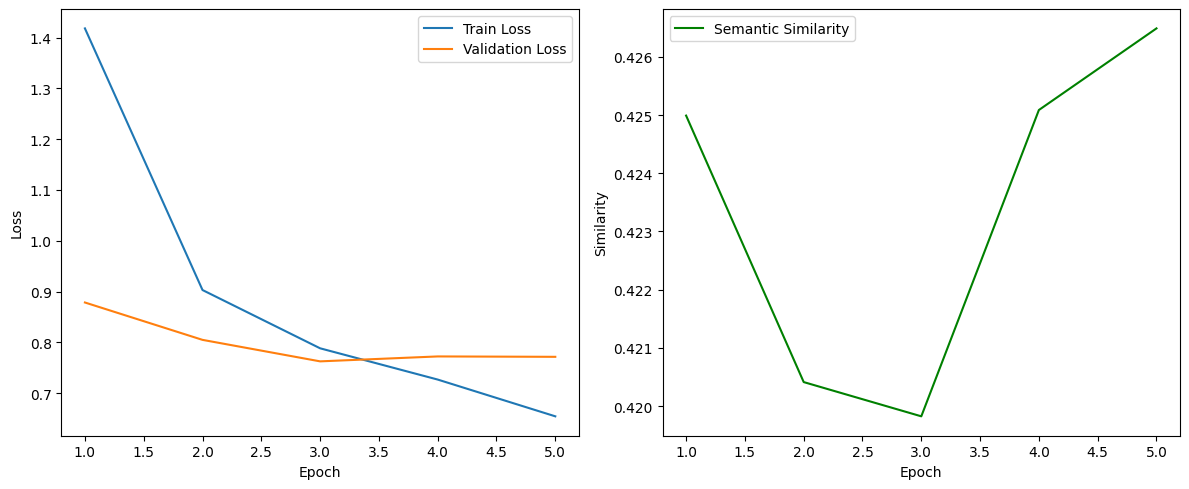

Evaluating:  98%|█████████▊| 59/60 [00:34<00:00,  1.74it/s]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]


========== TEST RESULTS ==========
Test Loss              : 0.7630
Test Semantic Similarity: 0.4386

===== RANDOM TEST EXAMPLES =====

--- Example 97 ---
Raw Report       : 
[ Finding ]_x000D_
both ankle OA._x000D_
[ Conclusion ]_x000D_
both ankle OA._x000D_
[ Recommend ]_x000D_

Cleaned Report   : 
both ankle OA.
Generated Report : 
 no bony lesion. Lt., 1st MTP joint, suspicious erosion --> R/O gout arthritis cannot be excluded as suggested in both foot bones of right talus neck (right>left) and proximal phalanx head(left>.1). possible old fracture with bone fragment on left ankle dorsum or tophi at tibial plafond vs. calcaneous ligament -> rheumatoid osteopenia degenerative change syndrome mild OA pes planu

--- Example 71 ---
Raw Report       : 
[ Finding ]_x000D_
_x000D_
[ Diagnosis ]_x000D_
Suspicious subchondral cyst of both 1st proximal phalangeal bone base._x000D_
[ Recommend ]_x000D_

Cleaned Report   : 
Suspicious subchondral cyst of both 1st proximal phalangeal bone base.


In [20]:
import os
import re
import json
import logging
import unicodedata
import random
from collections import defaultdict, Counter

import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import timm
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)

# =============================================================================
# Utility functions
# =============================================================================

def count_labels(data, target_classes, cfg):
    class_counts = defaultdict(int)
    data_by_class = defaultdict(list)
    for entry in tqdm(data.values(), desc="Counting dataset"):
        lbl = entry.get('class_label', '').lower()
        if lbl in target_classes and os.path.exists(entry['file_path']):
            class_counts[lbl] += 1
            data_by_class[lbl].append(entry)
    return class_counts, data_by_class

def prepare_abnormal_normal_data(data, cfg):
    random.seed(42)
    abnormal = ['ra', 'oa', 'gout']
    normal = ['normal']
    class_counts, data_by_class = count_labels(data, abnormal + normal, cfg)
    combined = {
        'abnormal': sum((data_by_class[c] for c in abnormal), []),
        'normal': data_by_class['normal']
    }
    combined_counts = {
        'abnormal': sum(class_counts[c] for c in abnormal),
        'normal': class_counts['normal']
    }
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(combined.values(), []), combined_counts, combined_counts
    min_count = min(combined_counts.values())
    balanced = []
    final_counts = {}
    for lbl, items in combined.items():
        sampled = random.sample(items, min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    if cfg.DATASET.AUGMENT:
        balanced *= 2
    return balanced, combined_counts, final_counts

def prepare_data(data, target_classes, cfg, is_binary=False):
    random.seed(42)
    if len(target_classes) == 2 and 'abnormal' in target_classes and 'normal' in target_classes:
        logging.info("Using abnormal-vs-normal logic")
        return prepare_abnormal_normal_data(data, cfg)
    class_counts, data_by_class = count_labels(data, target_classes, cfg)
    logging.info(f"Original class distribution: {class_counts}")
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(data_by_class.values(), []), class_counts, class_counts
    min_count = min(class_counts.values())
    balanced, final_counts = [], {}
    for lbl in target_classes:
        sampled = random.sample(data_by_class[lbl], min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    logging.info(f"Balanced class distribution: {final_counts}")
    if cfg.DATASET.AUGMENT:
        balanced *= 2
    return balanced, class_counts, final_counts

# =============================================================================
# Transforms
# =============================================================================

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

patch_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

# =============================================================================
# Dataset
# =============================================================================

class FinalSamplesDataset(Dataset):
    def __init__(self, cfg, image_transform=train_transform, patch_transform=patch_transform):
        self.cfg = cfg
        self.image_transform = image_transform
        self.patch_transform = patch_transform

        self.target_classes = cfg.DATASET.TARGET_CLASSES
        if isinstance(self.target_classes, str):
            self.target_classes = self.target_classes.split(",")

        self.is_binary = len(self.target_classes) == 2
        self.abnormal_classify = self.is_binary and 'abnormal' in self.target_classes
        self.abnormal_mapping = (
            {'ra': 'abnormal', 'oa': 'abnormal', 'gout': 'abnormal', 'normal': 'normal'}
            if self.abnormal_classify else None
        )

        with open(cfg.DATASET.JSON, 'r') as f:
            raw_list = json.load(f)

        filtered = []
        for item in raw_list:
            merged = item.get('merged_image_path', '')
            fp = item.get('file_paths', [])
            if isinstance(fp, str):
                fp = [fp]
            paths = [merged] + fp
            if any(os.path.exists(p) for p in paths):
                filtered.append((merged, fp, item))

        self.data = {}
        for i, (merged, fp, item) in enumerate(filtered):
            cls = item.get('class', 'unknown').lower()
            if self.abnormal_mapping:
                cls = self.abnormal_mapping.get(cls, cls)
            self.data[i] = {
                'file_path': merged,
                'left_right_file_path': fp,
                'class_label': cls,
                'diagnosis': item.get('diagnosis', ''),
                'keypoints': item.get('keypoints', {})
            }

        if self.is_binary:
            balanced, _, _ = prepare_data(self.data, self.target_classes, cfg, True)
            self.data = {i: e for i, e in enumerate(balanced)}

        self.tokenizer = None
        self.eos_token = None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        e = self.data[idx]
        img = Image.open(e['file_path']).convert('RGB')
        img = self.image_transform(img)

        patches = self._gen_patches(e['left_right_file_path'], e['keypoints'])
        pt = [self.patch_transform(Image.fromarray(p)) for p in patches]
        patches_tensor = torch.stack(pt, 0) if pt else torch.zeros(34, 3, 112, 112)

        raw = e.get('diagnosis', '')
        clean = self._clean_report(raw)
        
        # Add BOS token to the beginning of the report
        input_text = f"{self.tokenizer.bos_token} {clean}"
        
        # Tokenize with truncation and ensuring EOS token at end
        tok = self.tokenizer(input_text, truncation=True, max_length=511, return_tensors='pt')
        
        # Add EOS token if not already present
        if tok['input_ids'][0][-1] != self.tokenizer.eos_token_id:
            input_ids = torch.cat([tok['input_ids'], torch.tensor([[self.tokenizer.eos_token_id]])], dim=1)
            attention_mask = torch.cat([tok['attention_mask'], torch.tensor([[1]])], dim=1)
        else:
            input_ids = tok['input_ids']
            attention_mask = tok['attention_mask']

        return {
            'full_img': img,
            'patches': patches_tensor,
            'raw_report': raw,
            'cleaned_report': clean,
            'input_ids': input_ids.squeeze(0),
            'attention_mask': attention_mask.squeeze(0)
        }

    def _gen_patches(self, paths, kps_dict, crop_size=(200, 300), patch_size=(112, 112)):
        def extract(arr, side_kps):
            lst = []
            pts = side_kps[0]['keypoints']
            for i in range(17):
                x, y, s = int(pts[3*i]), int(pts[3*i+1]), pts[3*i+2]
                if s > 0:
                    x0 = max(x - crop_size[0]//2, 0)
                    y0 = max(y - crop_size[1]//2, 0)
                    x1 = min(x + crop_size[0]//2, arr.shape[1])
                    y1 = min(y + crop_size[1]//2, arr.shape[0])
                    c = arr[y0:y1, x0:x1]
                    if c.size:
                        lst.append(cv2.resize(c, patch_size))
            return lst

        def pad17(lst):
            black = np.zeros((patch_size[1], patch_size[0], 3), np.uint8)
            while len(lst) < 17:
                lst.append(black)
            return lst[:17]

        left, right = [], []
        if len(paths) == 1:
            pth = paths[0]
            if not pth or not os.path.exists(pth):
                return pad17([]) + pad17([])
            img_arr = cv2.imread(pth)
            if img_arr is None:
                return pad17([]) + pad17([])
            arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
            if kps_dict.get('left'): left = extract(arr, kps_dict['left'])
            if kps_dict.get('right'): right = extract(arr, kps_dict['right'])
        else:
            for side, pth in zip(['left', 'right'], paths):
                if pth and os.path.exists(pth):
                    img_arr = cv2.imread(pth)
                    if img_arr is not None:
                        arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
                        if kps_dict.get(side):
                            lst = extract(arr, kps_dict[side])
                            if side == 'left': left = lst
                            else: right = lst

        if left and not right:
            right = [cv2.flip(p, 1) for p in left]
        if right and not left:
            left = [cv2.flip(p, 1) for p in right]
        if not left and not right:
            return pad17([]) + pad17([])

        return pad17(left) + pad17(right)

    def _clean_report(self, text):
        text = unicodedata.normalize('NFKC', text or '')
        text = re.sub(r'(?m)^-+\s*$', '', text)
        text = re.sub(r'[^\x00-\x7F]+', ' ', text)
        text = re.sub(r'([.!?]){2,}', r'\1', text)
        text = re.sub(r'\[\s*finding\s*\]', '[FINDING]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*conclusion\s*\]', '[CONCLUSION]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*diagnosis\s*\]', '[DIAGNOSIS]', text, flags=re.IGNORECASE)
        parts = re.split(r'\[\s*recommend(?:ation)?\s*\]', text, flags=re.IGNORECASE)
        text = parts[0]
        fm = re.search(r'\[FINDING\](.*?)(?=\[|$)', text, flags=re.IGNORECASE | re.DOTALL)
        cm = re.search(r'\[CONCLUSION\](.*?)(?=\[|$)', text, flags=re.IGNORECASE | re.DOTALL)
        if fm and cm and fm.group(1).strip().lower() == cm.group(1).strip().lower():
            text = re.sub(r'\[CONCLUSION\].*?(?=\[|$)', '', text, flags=re.IGNORECASE | re.DOTALL)
        text = re.sub(r'\[\s*(FINDING|CONCLUSION|DIAGNOSIS)\s*\]', '', text, flags=re.IGNORECASE)
        text = text.replace('_x000D_', ' ')
        text = re.sub(r'\s+', ' ', text).strip()
        return text

# =============================================================================
# Collate function
# =============================================================================
def collate_fn(batch):
    imgs = torch.stack([b['full_img'] for b in batch])
    pts = [b['patches'] for b in batch]
    max_p = max(p.shape[0] for p in pts)
    pads = []
    for p in pts:
        if p.shape[0] < max_p:
            pad = torch.zeros((max_p - p.shape[0], *p.shape[1:]))
            p = torch.cat([p, pad], dim=0)
        pads.append(p)
    patches = torch.stack(pads, 0)

    ids = [b['input_ids'] for b in batch]
    masks = [b['attention_mask'] for b in batch]
    ids = nn.utils.rnn.pad_sequence(ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    masks = nn.utils.rnn.pad_sequence(masks, batch_first=True, padding_value=0)

    return {
        'full_imgs': imgs,
        'patches': patches,
        'input_ids': ids,
        'attention_mask': masks,
        'raw_reports': [b['raw_report'] for b in batch],
        'cleaned_reports': [b['cleaned_report'] for b in batch]
    }

# =============================================================================
# Model
# =============================================================================
class MultiModalModel(nn.Module):
    def __init__(self, gpt2_model_name='gpt2'):
        super().__init__()
        self.global_encoder = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
        self.global_encoder.reset_classifier(0)
        self.global_proj = nn.Linear(self.global_encoder.num_features, 768)

        self.patch_encoder = timm.create_model('resnet50', pretrained=True)
        self.patch_encoder.fc = nn.Identity()
        self.patch_proj = nn.Linear(self.patch_encoder.num_features, 768)

        self.attn = nn.MultiheadAttention(embed_dim=768, num_heads=8, batch_first=True)
        self.norm = nn.LayerNorm(768)

        self.decoder = GPT2LMHeadModel.from_pretrained(gpt2_model_name, add_cross_attention=True)

    def _pool(self, feats):
        return feats.mean(dim=[2, 3]) if feats.ndim > 2 else feats

    def forward(self, imgs, patches, input_ids, attention_mask, decoder_labels=None):
        g = self.global_encoder(imgs)
        g = self.global_proj(g).unsqueeze(1)

        B, N, C, H, W = patches.shape
        p = patches.view(B * N, C, H, W)
        pf = (self.patch_encoder.forward_features(p)
              if hasattr(self.patch_encoder, 'forward_features')
              else self.patch_encoder(p))
        pf = self._pool(pf)
        pf = self.patch_proj(pf)
        pf = pf.view(B, N, 768)

        cat = torch.cat([g, pf], dim=1)
        comb, _ = self.attn(cat, cat, cat)
        comb = self.norm(comb)

        return self.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=comb,
            labels=decoder_labels
        )

# =============================================================================
# Train / Eval helpers
# =============================================================================

def train_epoch(model, loader, optimizer, scaler, device):
    model.train()
    total_loss = 0.0
    for b in tqdm(loader, desc="Training", leave=False):
        imgs = b['full_imgs'].to(device)
        pts = b['patches'].to(device)
        ids = b['input_ids'].to(device)
        msk = b['attention_mask'].to(device)

        optimizer.zero_grad()
        with torch.amp.autocast(device_type='cuda'):
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            loss = out.loss
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.0
    all_gen, all_gt = [], []
    for b in tqdm(loader, desc="Evaluating", leave=False):
        imgs = b['full_imgs'].to(device)
        pts = b['patches'].to(device)
        ids = b['input_ids'].to(device)
        msk = b['attention_mask'].to(device)

        with torch.no_grad():
            # Calculate loss using full ground truth
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            total_loss += out.loss.item()

            # For generation, use only BOS token as input
            bos_tokens = torch.tensor([[tokenizer.bos_token_id]] * imgs.size(0), device=device)

            g = model.global_encoder(imgs)
            g = model.global_proj(g).unsqueeze(1)

            B, N, C, H, W = pts.shape
            p = pts.view(B * N, C, H, W)
            pf = model.patch_encoder(p)
            pf = model._pool(pf)
            pf = model.patch_proj(pf)
            pf = pf.view(B, N, 768)

            cat = torch.cat([g, pf], dim=1)
            comb, _ = model.attn(cat, cat, cat)
            comb = model.norm(comb)

            gen_ids = model.decoder.generate(
                input_ids=bos_tokens,
                encoder_hidden_states=comb,
                early_stopping=True,
                attention_mask=torch.ones_like(bos_tokens),
                max_length=100,  # Increased from 60
                do_sample=True,
                top_k=40,  # Adjusted from 20
                top_p=0.9,  # Slightly increased from 0.85
                temperature=0.7,  # Reduced from 0.9 for less randomness
                repetition_penalty=1.3,  # Decreased from 1.8
                no_repeat_ngram_size=2,  # Reduced from 3
                eos_token_id=tokenizer.eos_token_id,
                pad_token_id=tokenizer.eos_token_id
            )

            gen_txt = [tokenizer.decode(g_, skip_special_tokens=True) for g_ in gen_ids]
            gt_txt = [tokenizer.decode(i_, skip_special_tokens=True) for i_ in ids]
            all_gen.extend(gen_txt)
            all_gt.extend(gt_txt)

    return total_loss / len(loader), all_gen, all_gt

def compute_semantic_similarity(gen, gt):
    stm = SentenceTransformer('all-MiniLM-L6-v2')
    e1 = stm.encode(gen, convert_to_tensor=True)
    e2 = stm.encode(gt, convert_to_tensor=True)
    return nn.functional.cosine_similarity(e1, e2).mean().item()

def plot_metrics(train_losses, val_losses, sems):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, sems, label="Semantic Similarity", color='green')
    plt.xlabel("Epoch")
    plt.ylabel("Similarity")
    plt.legend()

    plt.tight_layout()
    plt.show()

# =============================================================================
# MAIN
# =============================================================================

class Cfg: pass
cfg = Cfg()
cfg.DATASET = Cfg()
cfg.DATASET.JSON = 'final_samples_both_only_v2.json'
cfg.DATASET.USE_RAW = True
cfg.DATASET.USE_PATCH = True
cfg.DATASET.REPORT = True
cfg.DATASET.TARGET_CLASSES = ['ra', 'oa', 'gout', 'normal', 'uncertain', 'ref.prev']
cfg.DATASET.BALANCE = False
cfg.DATASET.AUGMENT = False

# Initialize and configure tokenizer - FIX: set left padding for decoder model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = 'left'  # Critical fix for GPT-2 decoder model
tokenizer.pad_token = tokenizer.eos_token

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

dataset = FinalSamplesDataset(cfg)
dataset.tokenizer = tokenizer
dataset.eos_token = tokenizer.eos_token

dist = Counter(e['class_label'] for e in dataset.data.values())
print("\nDataset class distribution:")
for cls, cnt in dist.items():
    print(f"  {cls}: {cnt}")

n = len(dataset)
n_train = int(0.8 * n)
n_val = int(0.1 * n)
n_test = n - n_train - n_val

# Create data splits
train_ds, val_ds, test_ds = random_split(dataset, [n_train, n_val, n_test])

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_ds, batch_size=4, shuffle=False, collate_fn=collate_fn)

# Initialize model, optimizer and training utilities
model = MultiModalModel().to(device)
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
scaler = torch.amp.GradScaler()  # Fixed: removed device_type parameter

# Training configuration - increased from 5 to 10 epochs
num_epochs = 5
train_losses, val_losses, sems = [], [], []

# Training loop
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    train_loss = train_epoch(model, train_loader, optimizer, scaler, device)
    val_loss, gen_txt, gt_txt = evaluate(model, val_loader, device)
    sem = compute_semantic_similarity(gen_txt, gt_txt)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    sems.append(sem)

    print(f"  Train Loss          : {train_loss:.4f}")
    print(f"  Validation Loss     : {val_loss:.4f}")
    print(f"  Semantic Similarity : {sem:.4f}")
    scheduler.step()

# Plot training metrics
plot_metrics(train_losses, val_losses, sems)

# Evaluate on test set
test_loss, test_gen, test_gt = evaluate(model, test_loader, device)
test_sem = compute_semantic_similarity(test_gen, test_gt)

print("\n========== TEST RESULTS ==========")
print(f"Test Loss              : {test_loss:.4f}")
print(f"Test Semantic Similarity: {test_sem:.4f}")

# Display random test examples
print("\n===== RANDOM TEST EXAMPLES =====")
for idx in random.sample(range(len(test_ds)), min(10, len(test_ds))):
    ex = test_ds[idx]
    raw = ex['raw_report']
    clean = ex['cleaned_report']
    fi = ex['full_img'].unsqueeze(0).to(device)
    pa = ex['patches'].unsqueeze(0).to(device)
    
    # Use only BOS token for generation
    prompt = torch.tensor([[tokenizer.bos_token_id]], device=device)

    g = model.global_encoder(fi)
    g = model.global_proj(g).unsqueeze(1)
    B, N, C, H, W = pa.shape
    p = pa.view(B * N, C, H, W)
    pf = model.patch_encoder(p)
    pf = model._pool(pf)
    pf = model.patch_proj(pf)
    pf = pf.view(B, N, 768)

    cat = torch.cat([g, pf], dim=1)
    comb, _ = model.attn(cat, cat, cat)
    comb = model.norm(comb)

    # Improved generation parameters for better medical reports
    gen_ids = model.decoder.generate(
        input_ids=prompt,
        encoder_hidden_states=comb,
        early_stopping=True,
        attention_mask=torch.ones_like(prompt),
        max_length=100,         # Increased from 60 for complete reports
        do_sample=True,
        top_k=40,               # Increased from 20 for more vocabulary options
        top_p=0.9,              # Adjusted from 0.85 for better diversity
        temperature=0.7,        # Reduced from 0.9 for more focused generation
        repetition_penalty=1.3, # Reduced from 1.8 to allow necessary medical term repetition
        no_repeat_ngram_size=2, # Reduced from 3 for more natural medical phrasing
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id
    )

    gen = tokenizer.decode(gen_ids[0], skip_special_tokens=True)

    print(f"\n--- Example {idx} ---")
    print(f"Raw Report       : \n{raw}")
    print(f"Cleaned Report   : \n{clean}")
    print(f"Generated Report : \n{gen}")


## Printing Intermediate Shape

In [2]:
import os
import re
import json
import random
import unicodedata 
from collections import defaultdict, Counter

import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import timm
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

# =============================================================================
# Utility functions
# =============================================================================

def count_labels(data, target_classes, cfg):
    class_counts = defaultdict(int)
    data_by_class = defaultdict(list)
    for entry in tqdm(data.values(), desc="Counting dataset"):
        lbl = entry.get('class_label', '').lower()
        if lbl in target_classes and os.path.exists(entry['file_path']):
            class_counts[lbl] += 1
            data_by_class[lbl].append(entry)
    return class_counts, data_by_class

def prepare_abnormal_normal_data(data, cfg):
    random.seed(42)
    abnormal = ['ra', 'oa', 'gout']
    normal = ['normal']
    class_counts, data_by_class = count_labels(data, abnormal + normal, cfg)
    combined = {
        'abnormal': sum((data_by_class[c] for c in abnormal), []),
        'normal': data_by_class['normal']
    }
    combined_counts = {
        'abnormal': sum(class_counts[c] for c in abnormal),
        'normal': class_counts['normal']
    }
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(combined.values(), []), combined_counts, combined_counts
    min_count = min(combined_counts.values())
    balanced = []
    final_counts = {}
    for lbl, items in combined.items():
        sampled = random.sample(items, min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    if cfg.DATASET.AUGMENT:
        balanced *= 2
    return balanced, combined_counts, final_counts

def prepare_data(data, target_classes, cfg, is_binary=False):
    random.seed(42)
    if len(target_classes) == 2 and 'abnormal' in target_classes and 'normal' in target_classes:
        print("Using abnormal-vs-normal logic")
        return prepare_abnormal_normal_data(data, cfg)
    class_counts, data_by_class = count_labels(data, target_classes, cfg)
    print(f"Original class distribution: {class_counts}")
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(data_by_class.values(), []), class_counts, class_counts
    min_count = min(class_counts.values())
    balanced, final_counts = [], {}
    for lbl in target_classes:
        sampled = random.sample(data_by_class[lbl], min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    print(f"Balanced class distribution: {final_counts}")
    if cfg.DATASET.AUGMENT:
        balanced *= 2
    return balanced, class_counts, final_counts

# =============================================================================
# Transforms
# =============================================================================

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

patch_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

# =============================================================================
# Dataset
# =============================================================================

class FinalSamplesDataset(Dataset):
    def __init__(self, cfg, image_transform=train_transform, patch_transform=patch_transform):
        self.cfg = cfg
        self.image_transform = image_transform
        self.patch_transform = patch_transform

        self.target_classes = cfg.DATASET.TARGET_CLASSES
        if isinstance(self.target_classes, str):
            self.target_classes = self.target_classes.split(",")

        self.is_binary = len(self.target_classes) == 2
        self.abnormal_classify = self.is_binary and 'abnormal' in self.target_classes
        self.abnormal_mapping = (
            {'ra': 'abnormal', 'oa': 'abnormal', 'gout': 'abnormal', 'normal': 'normal'}
            if self.abnormal_classify else None
        )

        with open(cfg.DATASET.JSON, 'r') as f:
            raw_list = json.load(f)

        filtered = []
        for item in raw_list:
            merged = item.get('merged_image_path', '')
            fp = item.get('file_paths', [])
            if isinstance(fp, str):
                fp = [fp]
            paths = [merged] + fp
            if any(os.path.exists(p) for p in paths):
                filtered.append((merged, fp, item))

        self.data = {}
        for i, (merged, fp, item) in enumerate(filtered):
            cls = item.get('class', 'unknown').lower()
            if self.abnormal_mapping:
                cls = self.abnormal_mapping.get(cls, cls)
            self.data[i] = {
                'file_path': merged,
                'left_right_file_path': fp,
                'class_label': cls,
                'diagnosis': item.get('diagnosis', ''),
                'keypoints': item.get('keypoints', {})
            }

        if self.is_binary:
            balanced, _, _ = prepare_data(self.data, self.target_classes, cfg, True)
            self.data = {i: e for i, e in enumerate(balanced)}

        self.tokenizer = None
        self.eos_token = None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        e = self.data[idx]
        img = Image.open(e['file_path']).convert('RGB')
        img = self.image_transform(img)
        print(f"[Dataset] full_img shape: {img.shape}")  # ‼️ SHAPE

        patches = self._gen_patches(e['left_right_file_path'], e['keypoints'])
        pt = [self.patch_transform(Image.fromarray(p)) for p in patches]
        patches_tensor = torch.stack(pt, 0) if pt else torch.zeros(34, 3, 112, 112)
        print(f"[Dataset] patches_tensor shape: {patches_tensor.shape}")  # ‼️ SHAPE

        raw = e.get('diagnosis', '')
        clean = self._clean_report(raw)
        
        input_text = f"{self.tokenizer.bos_token} {clean}"
        tok = self.tokenizer(input_text, truncation=True, max_length=511, return_tensors='pt')
        
        if tok['input_ids'][0][-1] != self.tokenizer.eos_token_id:
            input_ids = torch.cat([tok['input_ids'], torch.tensor([[self.tokenizer.eos_token_id]])], dim=1)
            attention_mask = torch.cat([tok['attention_mask'], torch.tensor([[1]])], dim=1)
        else:
            input_ids = tok['input_ids']
            attention_mask = tok['attention_mask']

        input_ids = input_ids.squeeze(0)
        attention_mask = attention_mask.squeeze(0)
        print(f"[Dataset] input_ids shape: {input_ids.shape}, attention_mask shape: {attention_mask.shape}")  # ‼️ SHAPE

        return {
            'full_img': img,
            'patches': patches_tensor,
            'raw_report': raw,
            'cleaned_report': clean,
            'input_ids': input_ids,
            'attention_mask': attention_mask
        }

    def _gen_patches(self, paths, kps_dict, crop_size=(200, 300), patch_size=(112, 112)):
        def extract(arr, side_kps):
            lst = []
            pts = side_kps[0]['keypoints']
            for i in range(17):
                x, y, s = int(pts[3*i]), int(pts[3*i+1]), pts[3*i+2]
                if s > 0:
                    x0 = max(x - crop_size[0]//2, 0)
                    y0 = max(y - crop_size[1]//2, 0)
                    x1 = min(x + crop_size[0]//2, arr.shape[1])
                    y1 = min(y + crop_size[1]//2, arr.shape[0])
                    c = arr[y0:y1, x0:x1]
                    if c.size:
                        lst.append(cv2.resize(c, patch_size))
            return lst

        def pad17(lst):
            black = np.zeros((patch_size[1], patch_size[0], 3), np.uint8)
            while len(lst) < 17:
                lst.append(black)
            return lst[:17]

        left, right = [], []
        if len(paths) == 1:
            pth = paths[0]
            if not pth or not os.path.exists(pth):
                return pad17([]) + pad17([])
            img_arr = cv2.imread(pth)
            if img_arr is None:
                return pad17([]) + pad17([])
            arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
            if kps_dict.get('left'): left = extract(arr, kps_dict['left'])
            if kps_dict.get('right'): right = extract(arr, kps_dict['right'])
        else:
            for side, pth in zip(['left', 'right'], paths):
                if pth and os.path.exists(pth):
                    img_arr = cv2.imread(pth)
                    if img_arr is not None:
                        arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
                        if kps_dict.get(side):
                            lst = extract(arr, kps_dict[side])
                            if side == 'left': left = lst
                            else: right = lst

        if left and not right:
            right = [cv2.flip(p, 1) for p in left]
        if right and not left:
            left = [cv2.flip(p, 1) for p in right]
        if not left and not right:
            return pad17([]) + pad17([])

        return pad17(left) + pad17(right)

    def _clean_report(self, text):
        text = unicodedata.normalize('NFKC', text or '')
        text = re.sub(r'(?m)^-+\s*$', '', text)
        text = re.sub(r'[^\x00-\x7F]+', ' ', text)
        text = re.sub(r'([.!?]){2,}', r'\1', text)
        text = re.sub(r'\[\s*finding\s*\]', '[FINDING]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*conclusion\s*\]', '[CONCLUSION]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*diagnosis\s*\]', '[DIAGNOSIS]', text, flags=re.IGNORECASE)
        parts = re.split(r'\[\s*recommend(?:ation)?\s*\]', text, flags=re.IGNORECASE)
        text = parts[0]
        fm = re.search(r'\[FINDING\](.*?)(?=\[|$)', text, flags=re.IGNORECASE | re.DOTALL)
        cm = re.search(r'\[CONCLUSION\](.*?)(?=\[|$)', text, flags=re.IGNORECASE | re.DOTALL)
        if fm and cm and fm.group(1).strip().lower() == cm.group(1).strip().lower():
            text = re.sub(r'\[CONCLUSION\].*?(?=\[|$)', '', text, flags=re.IGNORECASE | re.DOTALL)
        text = re.sub(r'\[\s*(FINDING|CONCLUSION|DIAGNOSIS)\s*\]', '', text, flags=re.IGNORECASE)
        text = text.replace('_x000D_', ' ')
        text = re.sub(r'\s+', ' ', text).strip()
        return text

# =============================================================================
# Collate function
# =============================================================================

def collate_fn(batch):
    imgs = torch.stack([b['full_img'] for b in batch])
    print(f"[Collate] stacked full_imgs shape: {imgs.shape}")  # ‼️ SHAPE

    pts = [b['patches'] for b in batch]
    max_p = max(p.shape[0] for p in pts)
    pads = []
    for p in pts:
        if p.shape[0] < max_p:
            pad = torch.zeros((max_p - p.shape[0], *p.shape[1:]))
            p = torch.cat([p, pad], dim=0)
        pads.append(p)
    patches = torch.stack(pads, 0)
    print(f"[Collate] stacked patches shape: {patches.shape}")  # ‼️ SHAPE

    ids = [b['input_ids'] for b in batch]
    masks = [b['attention_mask'] for b in batch]
    ids = nn.utils.rnn.pad_sequence(ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    masks = nn.utils.rnn.pad_sequence(masks, batch_first=True, padding_value=0)
    print(f"[Collate] padded input_ids shape: {ids.shape}, padded attention_mask shape: {masks.shape}")  # ‼️ SHAPE

    return {
        'full_imgs': imgs,
        'patches': patches,
        'input_ids': ids,
        'attention_mask': masks,
        'raw_reports': [b['raw_report'] for b in batch],
        'cleaned_reports': [b['cleaned_report'] for b in batch]
    }

# =============================================================================
# Model
# =============================================================================

class MultiModalModel(nn.Module):
    def __init__(self, gpt2_model_name='gpt2'):
        super().__init__()
        self.global_encoder = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
        self.global_encoder.reset_classifier(0)
        self.global_proj = nn.Linear(self.global_encoder.num_features, 768)

        self.patch_encoder = timm.create_model('resnet50', pretrained=True)
        self.patch_encoder.fc = nn.Identity()
        self.patch_proj = nn.Linear(self.patch_encoder.num_features, 768)

        self.attn = nn.MultiheadAttention(embed_dim=768, num_heads=8, batch_first=True)
        self.norm = nn.LayerNorm(768)

        self.decoder = GPT2LMHeadModel.from_pretrained(gpt2_model_name, add_cross_attention=True)

    def _pool(self, feats):
        return feats.mean(dim=[2, 3]) if feats.ndim > 2 else feats

    def forward(self, imgs, patches, input_ids, attention_mask, decoder_labels=None):
        # Global image
        g_feats = self.global_encoder(imgs)
        print(f"[Model] global_encoder output shape: {g_feats.shape}")  # ‼️ SHAPE
        g = self.global_proj(g_feats).unsqueeze(1)
        print(f"[Model] global_proj + unsqueeze shape: {g.shape}")    # ‼️ SHAPE

        # Patch images
        B, N, C, H, W = patches.shape
        print(f"[Model] patches input shape: {patches.shape}")         # ‼️ SHAPE
        p = patches.view(B * N, C, H, W)
        pf_feats = (self.patch_encoder.forward_features(p)
                    if hasattr(self.patch_encoder, 'forward_features')
                    else self.patch_encoder(p))
        print(f"[Model] patch_encoder output shape: {pf_feats.shape}") # ‼️ SHAPE
        pf_pooled = self._pool(pf_feats)
        pf = self.patch_proj(pf_pooled).view(B, N, 768)
        print(f"[Model] patch_proj + reshape shape: {pf.shape}")       # ‼️ SHAPE

        # Combine
        cat = torch.cat([g, pf], dim=1)
        print(f"[Model] concatenated features shape: {cat.shape}")     # ‼️ SHAPE
        comb, _ = self.attn(cat, cat, cat)
        comb = self.norm(comb)
        print(f"[Model] after attention & norm shape: {comb.shape}")   # ‼️ SHAPE

        # Decoder
        out = self.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=comb,
            labels=decoder_labels
        )
        print(f"[Model] decoder logits shape: {out.logits.shape}")     # ‼️ SHAPE
        return out

# =============================================================================
# Train / Eval helpers
# =============================================================================

def train_epoch(model, loader, optimizer, scaler, device):
    model.train()
    total_loss = 0.0
    for b in tqdm(loader, desc="Training", leave=False):
        imgs = b['full_imgs'].to(device)
        pts = b['patches'].to(device)
        ids = b['input_ids'].to(device)
        msk = b['attention_mask'].to(device)

        print(f"[Train] batch full_imgs {imgs.shape}, patches {pts.shape}, input_ids {ids.shape}, mask {msk.shape}")  # ‼️ SHAPE

        optimizer.zero_grad()
        with torch.amp.autocast(device_type='cuda'):
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            loss = out.loss
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.0
    all_gen, all_gt = [], []
    for b in tqdm(loader, desc="Evaluating", leave=False):
        imgs = b['full_imgs'].to(device)
        pts = b['patches'].to(device)
        ids = b['input_ids'].to(device)
        msk = b['attention_mask'].to(device)

        print(f"[Eval] batch full_imgs {imgs.shape}, patches {pts.shape}, input_ids {ids.shape}")  # ‼️ SHAPE

        with torch.no_grad():
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            total_loss += out.loss.item()

            bos_tokens = torch.tensor([[tokenizer.bos_token_id]] * imgs.size(0), device=device)
            print(f"[Eval] bos_tokens shape: {bos_tokens.shape}")  # ‼️ SHAPE

            # Feature reuse
            g_feats = model.global_encoder(imgs)
            g = model.global_proj(g_feats).unsqueeze(1)
            B, N, C, H, W = pts.shape
            p = pts.view(B * N, C, H, W)
            pf_feats = model.patch_encoder(p)
            pf_pooled = model._pool(pf_feats)
            pf = model.patch_proj(pf_pooled).view(B, N, 768)
            cat = torch.cat([g, pf], dim=1)
            comb, _ = model.attn(cat, cat, cat)
            comb = model.norm(comb)

            gen_ids = model.decoder.generate(
                input_ids=bos_tokens,
                encoder_hidden_states=comb,
                early_stopping=True,
                attention_mask=torch.ones_like(bos_tokens),
                max_length=100,
                do_sample=True,
                top_k=40,
                top_p=0.9,
                temperature=0.7,
                repetition_penalty=1.3,
                no_repeat_ngram_size=2,
                eos_token_id=tokenizer.eos_token_id,
                pad_token_id=tokenizer.eos_token_id
            )
            print(f"[Eval] gen_ids shape: {gen_ids.shape}")  # ‼️ SHAPE

            gen_txt = [tokenizer.decode(g_, skip_special_tokens=True) for g_ in gen_ids]
            gt_txt = [tokenizer.decode(i_, skip_special_tokens=True) for i_ in ids]
            all_gen.extend(gen_txt)
            all_gt.extend(gt_txt)

    return total_loss / len(loader), all_gen, all_gt

def compute_semantic_similarity(gen, gt):
    stm = SentenceTransformer('all-MiniLM-L6-v2')
    e1 = stm.encode(gen, convert_to_tensor=True)
    e2 = stm.encode(gt, convert_to_tensor=True)
    return nn.functional.cosine_similarity(e1, e2).mean().item()

def plot_metrics(train_losses, val_losses, sems):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, sems, label="Semantic Similarity")
    plt.xlabel("Epoch")
    plt.ylabel("Similarity")
    plt.legend()

    plt.tight_layout()
    plt.show()

# =============================================================================
# MAIN
# =============================================================================

class Cfg: pass
cfg = Cfg()
cfg.DATASET = Cfg()
cfg.DATASET.JSON = 'final_samples_both_only_v2.json'
cfg.DATASET.USE_RAW = True
cfg.DATASET.USE_PATCH = True
cfg.DATASET.REPORT = True
cfg.DATASET.TARGET_CLASSES = ['ra', 'oa', 'gout', 'normal', 'uncertain', 'ref.prev']
cfg.DATASET.BALANCE = False
cfg.DATASET.AUGMENT = False

# Initialize and configure tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = 'left'  
tokenizer.pad_token = tokenizer.eos_token

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Prepare dataset
dataset = FinalSamplesDataset(cfg)
dataset.tokenizer = tokenizer
dataset.eos_token = tokenizer.eos_token

dist = Counter(e['class_label'] for e in dataset.data.values())
print("\nDataset class distribution:")
for cls, cnt in dist.items():
    print(f"  {cls}: {cnt}")

# Split
n = len(dataset)
n_train = int(0.8 * n)
n_val = int(0.1 * n)
n_test = n - n_train - n_val
train_ds, val_ds, test_ds = random_split(dataset, [n_train, n_val, n_test])

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_ds, batch_size=4, shuffle=False, collate_fn=collate_fn)

# Model, optimizer, scheduler, scaler
model = MultiModalModel().to(device)
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
scaler = torch.amp.GradScaler()

# Training
num_epochs = 1
train_losses, val_losses, sems = [], [], []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    train_loss = train_epoch(model, train_loader, optimizer, scaler, device)
    val_loss, gen_txt, gt_txt = evaluate(model, val_loader, device)
    sem = compute_semantic_similarity(gen_txt, gt_txt)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    sems.append(sem)

    print(f"  Train Loss          : {train_loss:.4f}")
    print(f"  Validation Loss     : {val_loss:.4f}")
    print(f"  Semantic Similarity : {sem:.4f}")
    scheduler.step()

# Plot metrics
plot_metrics(train_losses, val_losses, sems)

# Test evaluation
test_loss, test_gen, test_gt = evaluate(model, test_loader, device)
test_sem = compute_semantic_similarity(test_gen, test_gt)
print("\n========== TEST RESULTS ==========")
print(f"Test Loss               : {test_loss:.4f}")
print(f"Test Semantic Similarity: {test_sem:.4f}")

# Random test examples
print("\n===== RANDOM TEST EXAMPLES =====")
for idx in random.sample(range(len(test_ds)), min(20, len(test_ds))):
    ex = test_ds[idx]
    raw = ex['raw_report']
    clean = ex['cleaned_report']
    fi = ex['full_img'].unsqueeze(0).to(device)
    pa = ex['patches'].unsqueeze(0).to(device)
    
    prompt = torch.tensor([[tokenizer.bos_token_id]], device=device)
    g_feats = model.global_encoder(fi)
    g = model.global_proj(g_feats).unsqueeze(1)
    B, N, C, H, W = pa.shape
    p = pa.view(B * N, C, H, W)
    pf_feats = model.patch_encoder(p)
    pf_pooled = model._pool(pf_feats)
    pf = model.patch_proj(pf_pooled).view(B, N, 768)
    cat = torch.cat([g, pf], dim=1)
    comb, _ = model.attn(cat, cat, cat)
    comb = model.norm(comb)

    gen_ids = model.decoder.generate(
        input_ids=prompt,
        encoder_hidden_states=comb,
        early_stopping=True,
        attention_mask=torch.ones_like(prompt),
        max_length=100,
        do_sample=True,
        top_k=40,
        top_p=0.9,
        temperature=0.7,
        repetition_penalty=1.3,
        no_repeat_ngram_size=2,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id
    )
    gen = tokenizer.decode(gen_ids[0], skip_special_tokens=True)

    print(f"\n--- Example {idx} ---")
    print(f"Raw Report       : \n{raw}")
    print(f"Cleaned Report   : \n{clean}")
    print(f"Generated Report : \n{gen}")


Using device: cuda

Dataset class distribution:
  oa: 573
  ra: 115
  uncertain: 620
  oa, ra: 8
  normal: 748
  gout: 267
  combination of oa, ra: 3
  ref.prev: 60


Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.crossattention.c_attn.bias', 'h.11.crossattention.c_attn.weight', 'h.11.crossat


Epoch 1/1


Training:   0%|          | 0/479 [00:00<?, ?it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([24]), attention_mask shape: torch.Size([24])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([15]), attention_mask shape: torch.Size([15])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([10]), attention_mask shape: torch.Size([10])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 24]), padded attention_mask s

Training:   0%|          | 1/479 [00:00<03:46,  2.11it/s]

[Model] global_encoder output shape: torch.Size([4, 1024])
[Model] global_proj + unsqueeze shape: torch.Size([4, 1, 768])
[Model] patches input shape: torch.Size([4, 34, 3, 112, 112])
[Model] patch_encoder output shape: torch.Size([136, 2048, 4, 4])
[Model] patch_proj + reshape shape: torch.Size([4, 34, 768])
[Model] concatenated features shape: torch.Size([4, 35, 768])
[Model] after attention & norm shape: torch.Size([4, 35, 768])
[Model] decoder logits shape: torch.Size([4, 24, 50257])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([8]), attention_mask shape: torch.Size([8])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([5]), attention_mask shape: torch.Size([5])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[

Training:   0%|          | 2/479 [00:00<02:40,  2.98it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([9]), attention_mask shape: torch.Size([9])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([13]), attention_mask shape: torch.Size([13])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([9]), attention_mask shape: torch.Size([9])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 13]), padded attention_mask shape: 

Training:   1%|          | 3/479 [00:00<02:19,  3.41it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([21]), attention_mask shape: torch.Size([21])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([5]), attention_mask shape: torch.Size([5])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([16]), attention_mask shape: torch.Size([16])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([5]), attention_mask shape: torch.Size([5])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 21]), padded attention_mask shape

Training:   1%|          | 4/479 [00:01<02:09,  3.67it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([24]), attention_mask shape: torch.Size([24])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([23]), attention_mask shape: torch.Size([23])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 24]), padded attention_mask shape

Training:   1%|▏         | 6/479 [00:01<01:57,  4.04it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([11]), attention_mask shape: torch.Size([11])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([11]), attention_mask shape: torch.Size([11])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([8]), attention_mask shape: torch.Size([8])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 12]), padded attention_mask sha

Training:   2%|▏         | 8/479 [00:02<01:53,  4.15it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([7]), attention_mask shape: torch.Size([7])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([15]), attention_mask shape: torch.Size([15])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([3]), attention_mask shape: torch.Size([3])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 15]), padded attention_mask shape

Training:   2%|▏         | 9/479 [00:02<02:03,  3.81it/s]

[Model] global_encoder output shape: torch.Size([4, 1024])
[Model] global_proj + unsqueeze shape: torch.Size([4, 1, 768])
[Model] patches input shape: torch.Size([4, 34, 3, 112, 112])
[Model] patch_encoder output shape: torch.Size([136, 2048, 4, 4])
[Model] patch_proj + reshape shape: torch.Size([4, 34, 768])
[Model] concatenated features shape: torch.Size([4, 35, 768])
[Model] after attention & norm shape: torch.Size([4, 35, 768])
[Model] decoder logits shape: torch.Size([4, 38, 50257])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([5]), attention_mask shape: torch.Size([5])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([11]), attention_mask shape: torch.Size([11])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])

Training:   2%|▏         | 10/479 [00:02<02:00,  3.89it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 37]), padded attention_mask shape: torch.Size([4, 37])
[Train] batch full_imgs torch.Size([4, 3, 224, 224]), patches torch.Size([4, 34, 3, 112, 112]), input_ids torch.Size([4, 37]), mask torch.Size([4, 37])
[Model] global_encoder output shape: torch.Size([4, 1024])
[Model] global_proj + unsqueeze shape: torch.Size([4, 1, 768])
[Model] patches input shape: torch.Size([4, 34, 3, 112, 112])
[Model] patch_encoder output shape: torch.Size([136, 2048, 4, 4])
[Model] patch_proj + reshape shape: torch.Size([4, 34, 768])
[Model] concatenated features shape: torch.Size([4, 35, 768])
[Model] after attention & norm shape: torch

Training:   2%|▏         | 11/479 [00:03<02:07,  3.66it/s]

[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([29]), attention_mask shape: torch.Size([29])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([28]), attention_mask shape: torch.Size([28])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([31]), attention_mask shape: torch.Size([31])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 42]), padded attention_mask shape: torch.Size([4, 42])
[Train] batch full_imgs torch.Size([4, 3, 224, 224]), patches torch.Size([4, 34, 3, 112, 112]), input_ids torch.Size([4, 42]), mask torch.Size([4, 42])
[Model] global_encoder output shape: torch.Size([4, 1024])
[Model] globa

Training:   3%|▎         | 12/479 [00:03<02:07,  3.67it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([11]), attention_mask shape: torch.Size([11])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([10]), attention_mask shape: torch.Size([10])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([10]), attention_mask shape: torch.Size([10])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([28]), attention_mask shape: torch.Size([28])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 28]), padded attention_mask s

Training:   3%|▎         | 13/479 [00:03<02:08,  3.63it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([22]), attention_mask shape: torch.Size([22])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 22]), padded attention_mask sha

Training:   3%|▎         | 14/479 [00:03<02:03,  3.75it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([34]), attention_mask shape: torch.Size([34])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 34]), padded attention_mask shape

Training:   3%|▎         | 15/479 [00:04<01:59,  3.88it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([9]), attention_mask shape: torch.Size([9])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([10]), attention_mask shape: torch.Size([10])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([27]), attention_mask shape: torch.Size([27])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 27]), padded attention_mask sha

Training:   3%|▎         | 16/479 [00:04<01:57,  3.93it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([35]), attention_mask shape: torch.Size([35])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([16]), attention_mask shape: torch.Size([16])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([8]), attention_mask shape: torch.Size([8])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([55]), attention_mask shape: torch.Size([55])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 55]), padded attention_mask sha

Training:   4%|▎         | 17/479 [00:04<01:56,  3.97it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([5]), attention_mask shape: torch.Size([5])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 14]), padded attention_mask shape

Training:   4%|▍         | 18/479 [00:04<02:00,  3.81it/s]

[Model] decoder logits shape: torch.Size([4, 14, 50257])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([21]), attention_mask shape: torch.Size([21])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Dataset] full_img shape: torch.Size([3, 224, 224])


Training:   4%|▍         | 19/479 [00:05<02:08,  3.58it/s]

[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([5]), attention_mask shape: torch.Size([5])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([51]), attention_mask shape: torch.Size([51])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 51]), padded attention_mask shape: torch.Size([4, 51])
[Train] batch full_imgs torch.Size([4, 3, 224, 224]), patches torch.Size([4, 34, 3, 112, 112]), input_ids torch.Size([4, 51]), mask torch.Size([4, 51])
[Model] global_encoder output shape: torch.Size([4, 1024])
[Model] global_proj + unsqueeze shape: torch.Size([4, 1, 768])
[Model] patches input shape: torch.Size([4, 34, 3, 112, 112])
[Model] patch_encoder output shape: torch.Size([136, 2048, 4, 4])
[Model] patch_proj + r

Training:   4%|▍         | 20/479 [00:05<02:05,  3.65it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([36]), attention_mask shape: torch.Size([36])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([31]), attention_mask shape: torch.Size([31])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([30]), attention_mask shape: torch.Size([30])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 36]), padded attention_mask sha

Training:   4%|▍         | 21/479 [00:05<02:04,  3.67it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([5]), attention_mask shape: torch.Size([5])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([52]), attention_mask shape: torch.Size([52])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 52]), padded attention_mask sha

Training:   5%|▍         | 22/479 [00:05<01:59,  3.83it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([29]), attention_mask shape: torch.Size([29])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([46]), attention_mask shape: torch.Size([46])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 46]), padded attention_mask s

Training:   5%|▍         | 23/479 [00:06<01:56,  3.91it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([18]), attention_mask shape: torch.Size([18])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([15]), attention_mask shape: torch.Size([15])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([10]), attention_mask shape: torch.Size([10])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 18]), padded attention_mask s

Training:   5%|▌         | 24/479 [00:06<01:57,  3.88it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([15]), attention_mask shape: torch.Size([15])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([16]), attention_mask shape: torch.Size([16])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 16]), padded attention_mask sha

Training:   5%|▌         | 25/479 [00:06<01:59,  3.79it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([17]), attention_mask shape: torch.Size([17])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([10]), attention_mask shape: torch.Size([10])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 17]), padded attention_mask sha

Training:   5%|▌         | 26/479 [00:06<02:00,  3.75it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([8]), attention_mask shape: torch.Size([8])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([22]), attention_mask shape: torch.Size([22])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([15]), attention_mask shape: torch.Size([15])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 22]), padded attention_mask sha

Training:   6%|▌         | 27/479 [00:07<01:55,  3.91it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([8]), attention_mask shape: torch.Size([8])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([26]), attention_mask shape: torch.Size([26])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([61]), attention_mask shape: torch.Size([61])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([8]), attention_mask shape: torch.Size([8])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 61]), padded attention_mask shape

Training:   6%|▌         | 28/479 [00:07<01:56,  3.88it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([5]), attention_mask shape: torch.Size([5])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([58]), attention_mask shape: torch.Size([58])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([10]), attention_mask shape: torch.Size([10])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([25]), attention_mask shape: torch.Size([25])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 58]), padded attention_mask sha

Training:   6%|▌         | 29/479 [00:07<01:55,  3.91it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([10]), attention_mask shape: torch.Size([10])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([26]), attention_mask shape: torch.Size([26])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([49]), attention_mask shape: torch.Size([49])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 49]), padded attention_mask sha

Training:   6%|▋         | 30/479 [00:07<01:54,  3.93it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([16]), attention_mask shape: torch.Size([16])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([10]), attention_mask shape: torch.Size([10])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([17]), attention_mask shape: torch.Size([17])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([31]), attention_mask shape: torch.Size([31])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 31]), padded attention_mask s

Training:   6%|▋         | 31/479 [00:08<01:56,  3.85it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([8]), attention_mask shape: torch.Size([8])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([27]), attention_mask shape: torch.Size([27])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([31]), attention_mask shape: torch.Size([31])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 31]), padded attention_mask sha

Training:   7%|▋         | 32/479 [00:08<01:58,  3.76it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([16]), attention_mask shape: torch.Size([16])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([24]), attention_mask shape: torch.Size([24])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 24]), padded attention_mask sha

Training:   7%|▋         | 33/479 [00:08<01:57,  3.79it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([27]), attention_mask shape: torch.Size([27])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([21]), attention_mask shape: torch.Size([21])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([33]), attention_mask shape: torch.Size([33])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 33]), padded attention_mask s

Training:   7%|▋         | 34/479 [00:09<01:56,  3.83it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([76]), attention_mask shape: torch.Size([76])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([30]), attention_mask shape: torch.Size([30])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([8]), attention_mask shape: torch.Size([8])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([8]), attention_mask shape: torch.Size([8])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 76]), padded attention_mask shape

Training:   7%|▋         | 35/479 [00:09<01:52,  3.96it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([27]), attention_mask shape: torch.Size([27])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([9]), attention_mask shape: torch.Size([9])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([18]), attention_mask shape: torch.Size([18])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 27]), padded attention_mask sha

Training:   8%|▊         | 36/479 [00:09<01:52,  3.94it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([8]), attention_mask shape: torch.Size([8])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([10]), attention_mask shape: torch.Size([10])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 10]), padded attention_mask shape: 

Training:   8%|▊         | 37/479 [00:09<01:55,  3.82it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([15]), attention_mask shape: torch.Size([15])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([20]), attention_mask shape: torch.Size([20])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([23]), attention_mask shape: torch.Size([23])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 23]), padded attention_mask s

Training:   8%|▊         | 38/479 [00:10<01:57,  3.75it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([38]), attention_mask shape: torch.Size([38])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([23]), attention_mask shape: torch.Size([23])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([16]), attention_mask shape: torch.Size([16])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 38]), padded attention_mask sha

Training:   8%|▊         | 39/479 [00:10<01:57,  3.76it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([32]), attention_mask shape: torch.Size([32])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([18]), attention_mask shape: torch.Size([18])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 32]), padded attention_mask sha

Training:   8%|▊         | 40/479 [00:10<01:53,  3.85it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([13]), attention_mask shape: torch.Size([13])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([40]), attention_mask shape: torch.Size([40])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([7]), attention_mask shape: torch.Size([7])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 40]), padded attention_mask shape

Training:   9%|▊         | 41/479 [00:10<01:58,  3.71it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([16]), attention_mask shape: torch.Size([16])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([84]), attention_mask shape: torch.Size([84])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 84]), padded attention_mask s

Training:   9%|▉         | 42/479 [00:11<01:53,  3.84it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([11]), attention_mask shape: torch.Size([11])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([15]), attention_mask shape: torch.Size([15])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([28]), attention_mask shape: torch.Size([28])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([9]), attention_mask shape: torch.Size([9])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 28]), padded attention_mask sha

Training:   9%|▉         | 43/479 [00:11<01:52,  3.89it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([8]), attention_mask shape: torch.Size([8])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([10]), attention_mask shape: torch.Size([10])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 14]), padded attention_mask shape

Training:   9%|▉         | 44/479 [00:11<01:48,  4.00it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([22]), attention_mask shape: torch.Size([22])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([11]), attention_mask shape: torch.Size([11])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([42]), attention_mask shape: torch.Size([42])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 42]), padded attention_mask s

Training:   9%|▉         | 45/479 [00:11<01:52,  3.85it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([36]), attention_mask shape: torch.Size([36])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([22]), attention_mask shape: torch.Size([22])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 36]), padded attention_mask s

Training:  10%|▉         | 46/479 [00:12<01:52,  3.85it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([16]), attention_mask shape: torch.Size([16])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([68]), attention_mask shape: torch.Size([68])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 68]), padded attention_mask s

Training:  10%|▉         | 47/479 [00:12<01:53,  3.82it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([11]), attention_mask shape: torch.Size([11])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([13]), attention_mask shape: torch.Size([13])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([9]), attention_mask shape: torch.Size([9])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 13]), padded attention_mask shape

Training:  10%|█         | 48/479 [00:12<01:49,  3.95it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([33]), attention_mask shape: torch.Size([33])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([15]), attention_mask shape: torch.Size([15])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([57]), attention_mask shape: torch.Size([57])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 57]), padded attention_mask sha

Training:  10%|█         | 49/479 [00:12<01:51,  3.87it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([31]), attention_mask shape: torch.Size([31])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([10]), attention_mask shape: torch.Size([10])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([17]), attention_mask shape: torch.Size([17])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 31]), padded attention_mask s

Training:  10%|█         | 50/479 [00:13<01:51,  3.86it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([41]), attention_mask shape: torch.Size([41])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([22]), attention_mask shape: torch.Size([22])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([19]), attention_mask shape: torch.Size([19])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 41]), padded attention_mask s

Training:  11%|█         | 51/479 [00:13<01:55,  3.69it/s]

[Model] decoder logits shape: torch.Size([4, 41, 50257])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([32]), attention_mask shape: torch.Size([32])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([8]), attention_mask shape: torch.Size([8])
[Dataset] full_img shape: torch.Size([3, 224, 224])


Training:  11%|█         | 52/479 [00:13<01:52,  3.81it/s]

[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([34]), attention_mask shape: torch.Size([34])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 34]), padded attention_mask shape: torch.Size([4, 34])
[Train] batch full_imgs torch.Size([4, 3, 224, 224]), patches torch.Size([4, 34, 3, 112, 112]), input_ids torch.Size([4, 34]), mask torch.Size([4, 34])
[Model] global_encoder output shape: torch.Size([4, 1024])
[Model] global_proj + unsqueeze shape: torch.Size([4, 1, 768])
[Model] patches input shape: torch.Size([4, 34, 3, 112, 112])
[Model] patch_encoder output shape: torch.Size([136, 2048, 4, 4])
[Model] patch_proj + reshape shape: torch.Size([4, 34, 768])
[Model] concatenated features shape: torch.Size([4, 35, 768])
[Model] after attention & norm shape: torch.Size([4, 35, 768])
[Model] decoder logits shape: to

Training:  11%|█         | 53/479 [00:13<01:50,  3.86it/s]

[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([47]), attention_mask shape: torch.Size([47])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 47]), padded attention_mask shape: torch.Size([4, 47])
[Train] batch full_imgs torch.Size([4, 3, 224, 224]), patches torch.Size([4, 34, 3, 112, 112]), input_ids torch.Size([4, 47]), mask torch.Size([4, 47])
[Model] global_encoder output shape: torch.Size([4, 1024])
[Model] global_proj + unsqueeze shape: torch.Size([4, 1, 768])
[Model] patches input shape: torch.Size([4, 34, 3, 112, 112])
[Model] patch_encoder output shape: torch.Size([136, 2048, 4, 4])
[Model] patch_proj +

Training:  11%|█▏        | 54/479 [00:14<01:49,  3.88it/s]

[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([8]), attention_mask shape: torch.Size([8])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([29]), attention_mask shape: torch.Size([29])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 29]), padded attention_mask shape: torch.Size([4, 29])
[Train] batch full_imgs torch.Size([4, 3, 224, 224]), patches torch.Size([4, 34, 3, 112, 112]), input_ids torch.Size([4, 29]), mask torch.Size([4, 29])
[Model] global_encoder output shape: torch.Size([4, 1024])
[Model] global_

Training:  11%|█▏        | 55/479 [00:14<01:51,  3.81it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([9]), attention_mask shape: torch.Size([9])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([8]), attention_mask shape: torch.Size([8])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([36]), attention_mask shape: torch.Size([36])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 36]), padded attention_mask shape

Training:  12%|█▏        | 56/479 [00:14<01:51,  3.79it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([9]), attention_mask shape: torch.Size([9])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([18]), attention_mask shape: torch.Size([18])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 18]), padded attention_mask sha

Training:  12%|█▏        | 57/479 [00:14<01:48,  3.88it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([23]), attention_mask shape: torch.Size([23])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([5]), attention_mask shape: torch.Size([5])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([10]), attention_mask shape: torch.Size([10])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([8]), attention_mask shape: torch.Size([8])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 23]), padded attention_mask shape

Training:  12%|█▏        | 58/479 [00:15<01:50,  3.80it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([31]), attention_mask shape: torch.Size([31])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([15]), attention_mask shape: torch.Size([15])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([19]), attention_mask shape: torch.Size([19])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 31]), padded attention_mask sha

Training:  12%|█▏        | 59/479 [00:15<01:51,  3.78it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([20]), attention_mask shape: torch.Size([20])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([15]), attention_mask shape: torch.Size([15])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([20]), attention_mask shape: torch.Size([20])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([20]), attention_mask shape: torch.Size([20])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 20]), padded attention_mask s

Training:  13%|█▎        | 60/479 [00:15<01:47,  3.90it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([22]), attention_mask shape: torch.Size([22])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([28]), attention_mask shape: torch.Size([28])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([13]), attention_mask shape: torch.Size([13])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 28]), padded attention_mask s

Training:  13%|█▎        | 61/479 [00:16<01:45,  3.95it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([9]), attention_mask shape: torch.Size([9])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([50]), attention_mask shape: torch.Size([50])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([7]), attention_mask shape: torch.Size([7])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([7]), attention_mask shape: torch.Size([7])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 50]), padded attention_mask shape: 

Training:  13%|█▎        | 62/479 [00:16<01:47,  3.89it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([7]), attention_mask shape: torch.Size([7])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([22]), attention_mask shape: torch.Size([22])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([8]), attention_mask shape: torch.Size([8])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([11]), attention_mask shape: torch.Size([11])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 22]), padded attention_mask shape

Training:  13%|█▎        | 63/479 [00:16<01:50,  3.78it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([8]), attention_mask shape: torch.Size([8])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([9]), attention_mask shape: torch.Size([9])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([26]), attention_mask shape: torch.Size([26])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 26]), padded attention_mask shape

Training:  13%|█▎        | 64/479 [00:16<01:52,  3.70it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([17]), attention_mask shape: torch.Size([17])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([15]), attention_mask shape: torch.Size([15])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([10]), attention_mask shape: torch.Size([10])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([9]), attention_mask shape: torch.Size([9])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 17]), padded attention_mask sha

Training:  14%|█▎        | 65/479 [00:17<01:47,  3.85it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([41]), attention_mask shape: torch.Size([41])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([13]), attention_mask shape: torch.Size([13])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([9]), attention_mask shape: torch.Size([9])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 41]), padded attention_mask sha

Training:  14%|█▍        | 66/479 [00:17<01:47,  3.86it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([45]), attention_mask shape: torch.Size([45])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([17]), attention_mask shape: torch.Size([17])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 45]), padded attention_mask shape

Training:  14%|█▍        | 67/479 [00:17<01:45,  3.89it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([8]), attention_mask shape: torch.Size([8])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([7]), attention_mask shape: torch.Size([7])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 12]), padded attention_mask shape: 

Training:  14%|█▍        | 68/479 [00:17<01:45,  3.89it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([7]), attention_mask shape: torch.Size([7])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([21]), attention_mask shape: torch.Size([21])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([7]), attention_mask shape: torch.Size([7])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([17]), attention_mask shape: torch.Size([17])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 21]), padded attention_mask shape

Training:  14%|█▍        | 69/479 [00:18<01:48,  3.80it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([9]), attention_mask shape: torch.Size([9])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([76]), attention_mask shape: torch.Size([76])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 76]), padded attention_mask shape: 

Training:  15%|█▍        | 70/479 [00:18<01:46,  3.85it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([25]), attention_mask shape: torch.Size([25])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([8]), attention_mask shape: torch.Size([8])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([22]), attention_mask shape: torch.Size([22])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([19]), attention_mask shape: torch.Size([19])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 25]), padded attention_mask sha

Training:  15%|█▍        | 71/479 [00:18<01:49,  3.73it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([5]), attention_mask shape: torch.Size([5])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([24]), attention_mask shape: torch.Size([24])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 24]), padded attention_mask shape: 

Training:  15%|█▌        | 72/479 [00:18<01:50,  3.69it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([8]), attention_mask shape: torch.Size([8])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([8]), attention_mask shape: torch.Size([8])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([15]), attention_mask shape: torch.Size([15])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 15]), padded attention_mask shape

Training:  15%|█▌        | 73/479 [00:19<01:51,  3.65it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([5]), attention_mask shape: torch.Size([5])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 14]), padded attention_mask shape

Training:  15%|█▌        | 74/479 [00:19<01:46,  3.81it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([43]), attention_mask shape: torch.Size([43])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([7]), attention_mask shape: torch.Size([7])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([64]), attention_mask shape: torch.Size([64])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 64]), padded attention_mask sha

Training:  16%|█▌        | 75/479 [00:19<01:50,  3.65it/s]

[Model] decoder logits shape: torch.Size([4, 64, 50257])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([20]), attention_mask shape: torch.Size([20])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Dataset] full_img shape: torch.Size([3, 224, 224])


Training:  16%|█▌        | 76/479 [00:20<01:51,  3.63it/s]

[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([32]), attention_mask shape: torch.Size([32])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 32]), padded attention_mask shape: torch.Size([4, 32])
[Train] batch full_imgs torch.Size([4, 3, 224, 224]), patches torch.Size([4, 34, 3, 112, 112]), input_ids torch.Size([4, 32]), mask torch.Size([4, 32])
[Model] global_encoder output shape: torch.Size([4, 1024])
[Model] global_proj + unsqueeze shape: torch.Size([4, 1, 768])
[Model] patches input shape: torch.Size([4, 34, 3, 112, 112])
[Model] patch_encoder output shape: torch.Size([136, 2048, 4, 4])
[Model] patch_proj +

Training:  16%|█▌        | 77/479 [00:20<01:51,  3.62it/s]

[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([21]), attention_mask shape: torch.Size([21])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([8]), attention_mask shape: torch.Size([8])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([34]), attention_mask shape: torch.Size([34])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 34]), padded attention_mask shape: torch.Size([4, 34])
[Train] batch full_imgs torch.Size([4, 3, 224, 224]), patches torch.Size([4, 34, 3, 112, 112]), input_ids torch.Size([4, 34]), mask torch.Size([4, 34])
[Model] global_encoder output shape: torch.Size([4, 1024])
[Model] global_

Training:  16%|█▋        | 78/479 [00:20<01:50,  3.62it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([8]), attention_mask shape: torch.Size([8])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([25]), attention_mask shape: torch.Size([25])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([15]), attention_mask shape: torch.Size([15])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 25]), padded attention_mask sha

Training:  16%|█▋        | 79/479 [00:20<01:50,  3.63it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([27]), attention_mask shape: torch.Size([27])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([24]), attention_mask shape: torch.Size([24])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([9]), attention_mask shape: torch.Size([9])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 27]), padded attention_mask shape

Training:  17%|█▋        | 80/479 [00:21<01:47,  3.72it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([33]), attention_mask shape: torch.Size([33])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([10]), attention_mask shape: torch.Size([10])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([11]), attention_mask shape: torch.Size([11])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([5]), attention_mask shape: torch.Size([5])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 33]), padded attention_mask sha

Training:  17%|█▋        | 81/479 [00:21<01:47,  3.69it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([21]), attention_mask shape: torch.Size([21])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 21]), padded attention_mask sha

Training:  17%|█▋        | 82/479 [00:21<01:44,  3.78it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([77]), attention_mask shape: torch.Size([77])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([8]), attention_mask shape: torch.Size([8])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([7]), attention_mask shape: torch.Size([7])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([30]), attention_mask shape: torch.Size([30])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 77]), padded attention_mask shape

Training:  17%|█▋        | 83/479 [00:21<01:43,  3.83it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([46]), attention_mask shape: torch.Size([46])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([29]), attention_mask shape: torch.Size([29])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([24]), attention_mask shape: torch.Size([24])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([8]), attention_mask shape: torch.Size([8])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 46]), padded attention_mask sha

Training:  18%|█▊        | 84/479 [00:22<01:42,  3.87it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([10]), attention_mask shape: torch.Size([10])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([5]), attention_mask shape: torch.Size([5])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([11]), attention_mask shape: torch.Size([11])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 12]), padded attention_mask sha

Training:  18%|█▊        | 85/479 [00:22<01:41,  3.88it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([8]), attention_mask shape: torch.Size([8])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([16]), attention_mask shape: torch.Size([16])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 16]), padded attention_mask shape

Training:  18%|█▊        | 86/479 [00:22<01:37,  4.03it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([33]), attention_mask shape: torch.Size([33])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([7]), attention_mask shape: torch.Size([7])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([32]), attention_mask shape: torch.Size([32])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([28]), attention_mask shape: torch.Size([28])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 33]), padded attention_mask sha

Training:  18%|█▊        | 87/479 [00:22<01:41,  3.88it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([17]), attention_mask shape: torch.Size([17])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([40]), attention_mask shape: torch.Size([40])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([71]), attention_mask shape: torch.Size([71])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([28]), attention_mask shape: torch.Size([28])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 71]), padded attention_mask s

Training:  18%|█▊        | 88/479 [00:23<01:44,  3.73it/s]

[Model] decoder logits shape: torch.Size([4, 71, 50257])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([9]), attention_mask shape: torch.Size([9])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([76]), attention_mask shape: torch.Size([76])
[Dataset] full_img shape: torch.Size([3, 224, 224])


Training:  19%|█▊        | 89/479 [00:23<01:44,  3.72it/s]

[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([47]), attention_mask shape: torch.Size([47])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([11]), attention_mask shape: torch.Size([11])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 76]), padded attention_mask shape: torch.Size([4, 76])
[Train] batch full_imgs torch.Size([4, 3, 224, 224]), patches torch.Size([4, 34, 3, 112, 112]), input_ids torch.Size([4, 76]), mask torch.Size([4, 76])
[Model] global_encoder output shape: torch.Size([4, 1024])
[Model] global_proj + unsqueeze shape: torch.Size([4, 1, 768])
[Model] patches input shape: torch.Size([4, 34, 3, 112, 112])
[Model] patch_encoder output shape: torch.Size([136, 2048, 4, 4])
[Model] patch_proj +

Training:  19%|█▉        | 90/479 [00:23<01:43,  3.77it/s]

[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([24]), attention_mask shape: torch.Size([24])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([9]), attention_mask shape: torch.Size([9])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 24]), padded attention_mask shape: torch.Size([4, 24])
[Train] batch full_imgs torch.Size([4, 3, 224, 224]), patches torch.Size([4, 34, 3, 112, 112]), input_ids torch.Size([4, 24]), mask torch.Size([4, 24])
[Model] global_encoder output shape: torch.Size([4, 1024])
[Model] global_

Training:  19%|█▉        | 91/479 [00:23<01:40,  3.85it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([18]), attention_mask shape: torch.Size([18])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([5]), attention_mask shape: torch.Size([5])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 18]), padded attention_mask shape: 

Training:  19%|█▉        | 92/479 [00:24<01:41,  3.80it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([19]), attention_mask shape: torch.Size([19])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([15]), attention_mask shape: torch.Size([15])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([23]), attention_mask shape: torch.Size([23])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([16]), attention_mask shape: torch.Size([16])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 23]), padded attention_mask s

Training:  19%|█▉        | 93/479 [00:24<01:43,  3.72it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([17]), attention_mask shape: torch.Size([17])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([15]), attention_mask shape: torch.Size([15])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([40]), attention_mask shape: torch.Size([40])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 40]), padded attention_mask sha

Training:  20%|█▉        | 94/479 [00:24<01:41,  3.78it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([20]), attention_mask shape: torch.Size([20])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([5]), attention_mask shape: torch.Size([5])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([5]), attention_mask shape: torch.Size([5])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 20]), padded attention_mask shape

Training:  20%|█▉        | 95/479 [00:25<01:45,  3.63it/s]

[Model] decoder logits shape: torch.Size([4, 20, 50257])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([8]), attention_mask shape: torch.Size([8])
[Dataset] full_img shape: torch.Size([3, 224, 224])


Training:  20%|██        | 96/479 [00:25<01:41,  3.79it/s]

[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([8]), attention_mask shape: torch.Size([8])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 12]), padded attention_mask shape: torch.Size([4, 12])
[Train] batch full_imgs torch.Size([4, 3, 224, 224]), patches torch.Size([4, 34, 3, 112, 112]), input_ids torch.Size([4, 12]), mask torch.Size([4, 12])
[Model] global_encoder output shape: torch.Size([4, 1024])
[Model] global_proj + unsqueeze shape: torch.Size([4, 1, 768])
[Model] patches input shape: torch.Size([4, 34, 3, 112, 112])
[Model] patch_encoder output shape: torch.Size([136, 2048, 4, 4])
[Model] patch_proj + reshape shape: torch.Size([4, 34, 768])
[Model] concatenated features shape: torch.Size([4, 35, 768])
[Model] after attention & norm shape: torch.Size([4, 35, 768])
[Model] decoder logits shape: torc

Training:  20%|██        | 97/479 [00:25<01:41,  3.75it/s]

[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([26]), attention_mask shape: torch.Size([26])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([9]), attention_mask shape: torch.Size([9])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 30]), padded attention_mask shape: torch.Size([4, 30])
[Train] batch full_imgs torch.Size([4, 3, 224, 224]), patches torch.Size([4, 34, 3, 112, 112]), input_ids torch.Size([4, 30]), mask torch.Size([4, 30])
[Model] global_encoder output shape: torch.Size([4, 1024])
[Model] global_proj + unsqueeze shape: torch.Size([4, 1, 768])
[Model] patches input shape: torch.Size([4, 34, 3, 112, 112])
[Model] patch_encoder output shape: torch.Size([136, 2048, 4, 4])
[Model] patch_proj + r

Training:  20%|██        | 98/479 [00:25<01:42,  3.71it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([8]), attention_mask shape: torch.Size([8])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([37]), attention_mask shape: torch.Size([37])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 37]), padded attention_mask sha

Training:  21%|██        | 99/479 [00:26<01:45,  3.61it/s]

[Model] decoder logits shape: torch.Size([4, 37, 50257])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([32]), attention_mask shape: torch.Size([32])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([41]), attention_mask shape: torch.Size([41])
[Dataset] full_img shape: torch.Size([3, 224, 224])


Training:  21%|██        | 100/479 [00:26<01:45,  3.60it/s]

[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([8]), attention_mask shape: torch.Size([8])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([54]), attention_mask shape: torch.Size([54])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 54]), padded attention_mask shape: torch.Size([4, 54])
[Train] batch full_imgs torch.Size([4, 3, 224, 224]), patches torch.Size([4, 34, 3, 112, 112]), input_ids torch.Size([4, 54]), mask torch.Size([4, 54])
[Model] global_encoder output shape: torch.Size([4, 1024])
[Model] global_proj + unsqueeze shape: torch.Size([4, 1, 768])
[Model] patches input shape: torch.Size([4, 34, 3, 112, 112])
[Model] patch_encoder output shape: torch.Size([136, 2048, 4, 4])
[Model] patch_proj + r

Training:  21%|██        | 101/479 [00:26<01:47,  3.52it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([17]), attention_mask shape: torch.Size([17])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([5]), attention_mask shape: torch.Size([5])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 17]), padded attention_mask shape: 

Training:  21%|██▏       | 102/479 [00:27<01:45,  3.58it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([5]), attention_mask shape: torch.Size([5])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([5]), attention_mask shape: torch.Size([5])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([23]), attention_mask shape: torch.Size([23])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 23]), padded attention_mask shape

Training:  22%|██▏       | 103/479 [00:27<01:42,  3.67it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([11]), attention_mask shape: torch.Size([11])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([8]), attention_mask shape: torch.Size([8])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([5]), attention_mask shape: torch.Size([5])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 12]), padded attention_mask shape

Training:  22%|██▏       | 104/479 [00:27<01:41,  3.71it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([5]), attention_mask shape: torch.Size([5])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([74]), attention_mask shape: torch.Size([74])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 74]), padded attention_mask sha

Training:  22%|██▏       | 105/479 [00:27<01:39,  3.76it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 14]), padded attention_mask s

Training:  22%|██▏       | 106/479 [00:28<01:36,  3.87it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([23]), attention_mask shape: torch.Size([23])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([9]), attention_mask shape: torch.Size([9])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 23]), padded attention_mask sha

Training:  22%|██▏       | 107/479 [00:28<01:36,  3.87it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([8]), attention_mask shape: torch.Size([8])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([76]), attention_mask shape: torch.Size([76])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([7]), attention_mask shape: torch.Size([7])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 76]), padded attention_mask shape

Training:  23%|██▎       | 108/479 [00:28<01:40,  3.69it/s]

[Model] patch_encoder output shape: torch.Size([136, 2048, 4, 4])
[Model] patch_proj + reshape shape: torch.Size([4, 34, 768])
[Model] concatenated features shape: torch.Size([4, 35, 768])
[Model] after attention & norm shape: torch.Size([4, 35, 768])
[Model] decoder logits shape: torch.Size([4, 76, 50257])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([8]), attention_mask shape: torch.Size([8])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([9]), attention_mask shape: torch.Size([9])


Training:  23%|██▎       | 109/479 [00:28<01:44,  3.53it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 9]), padded attention_mask shape: torch.Size([4, 9])
[Train] batch full_imgs torch.Size([4, 3, 224, 224]), patches torch.Size([4, 34, 3, 112, 112]), input_ids torch.Size([4, 9]), mask torch.Size([4, 9])
[Model] global_encoder output shape: torch.Size([4, 1024])
[Model] global_proj + unsqueeze shape: torch.Size([4, 1, 768])
[Model] patches input shape: torch.Size([4, 34, 3, 112, 112])
[Model] patch_encoder output shape: torch.

Training:  23%|██▎       | 110/479 [00:29<01:44,  3.53it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([8]), attention_mask shape: torch.Size([8])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([13]), attention_mask shape: torch.Size([13])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([9]), attention_mask shape: torch.Size([9])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([7]), attention_mask shape: torch.Size([7])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 13]), padded attention_mask shape: 

Training:  23%|██▎       | 111/479 [00:29<01:40,  3.68it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([54]), attention_mask shape: torch.Size([54])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([50]), attention_mask shape: torch.Size([50])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 54]), padded attention_mask s

Training:  23%|██▎       | 112/479 [00:29<01:43,  3.56it/s]

[Model] decoder logits shape: torch.Size([4, 54, 50257])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([20]), attention_mask shape: torch.Size([20])
[Dataset] full_img shape: torch.Size([3, 224, 224])


Training:  24%|██▎       | 113/479 [00:30<01:43,  3.54it/s]

[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([5]), attention_mask shape: torch.Size([5])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 20]), padded attention_mask shape: torch.Size([4, 20])
[Train] batch full_imgs torch.Size([4, 3, 224, 224]), patches torch.Size([4, 34, 3, 112, 112]), input_ids torch.Size([4, 20]), mask torch.Size([4, 20])
[Model] global_encoder output shape: torch.Size([4, 1024])
[Model] global_proj + unsqueeze shape: torch.Size([4, 1, 768])
[Model] patches input shape: torch.Size([4, 34, 3, 112, 112])
[Model] patch_encoder output shape: torch.Size([136, 2048, 4, 4])
[Model] patch_proj + res

Training:  24%|██▍       | 114/479 [00:30<01:43,  3.52it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([19]), attention_mask shape: torch.Size([19])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([26]), attention_mask shape: torch.Size([26])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([37]), attention_mask shape: torch.Size([37])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 37]), padded attention_mask sha

Training:  24%|██▍       | 115/479 [00:30<01:46,  3.42it/s]

[Model] patch_encoder output shape: torch.Size([136, 2048, 4, 4])
[Model] patch_proj + reshape shape: torch.Size([4, 34, 768])
[Model] concatenated features shape: torch.Size([4, 35, 768])
[Model] after attention & norm shape: torch.Size([4, 35, 768])
[Model] decoder logits shape: torch.Size([4, 37, 50257])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([8]), attention_mask shape: torch.Size([8])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([17]), attention_mask shape: torch.Size([17])
[Dataset] full_img shape: torch.Size([3, 224, 224])


Training:  24%|██▍       | 116/479 [00:30<01:44,  3.46it/s]

[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([25]), attention_mask shape: torch.Size([25])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 25]), padded attention_mask shape: torch.Size([4, 25])
[Train] batch full_imgs torch.Size([4, 3, 224, 224]), patches torch.Size([4, 34, 3, 112, 112]), input_ids torch.Size([4, 25]), mask torch.Size([4, 25])
[Model] global_encoder output shape: torch.Size([4, 1024])
[Model] global_proj + unsqueeze shape: torch.Size([4, 1, 768])
[Model] patches input shape: torch.Size([4, 34, 3, 112, 112])
[Model] patch_encoder output shape: torch.Size([136, 2048, 4, 4])
[Model] patch_proj +

Training:  24%|██▍       | 117/479 [00:31<01:39,  3.63it/s]

[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([27]), attention_mask shape: torch.Size([27])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([24]), attention_mask shape: torch.Size([24])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 27]), padded attention_mask shape: torch.Size([4, 27])
[Train] batch full_imgs torch.Size([4, 3, 224, 224]), patches torch.Size([4, 34, 3, 112, 112]), input_ids torch.Size([4, 27]), mask torch.Size([4, 27])
[Model] global_encoder output shape: torch.Size([4, 1024])
[Model] globa

Training:  25%|██▍       | 118/479 [00:31<01:35,  3.78it/s]

[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([8]), attention_mask shape: torch.Size([8])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([10]), attention_mask shape: torch.Size([10])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([18]), attention_mask shape: torch.Size([18])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 18]), padded attention_mask shape: torch.Size([4, 18])
[Train] batch full_imgs torc

Training:  25%|██▍       | 119/479 [00:31<01:37,  3.70it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([47]), attention_mask shape: torch.Size([47])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([8]), attention_mask shape: torch.Size([8])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([24]), attention_mask shape: torch.Size([24])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([13]), attention_mask shape: torch.Size([13])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 47]), padded attention_mask sha

Training:  25%|██▌       | 120/479 [00:31<01:36,  3.71it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([41]), attention_mask shape: torch.Size([41])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([9]), attention_mask shape: torch.Size([9])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([10]), attention_mask shape: torch.Size([10])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 41]), padded attention_mask shape

Training:  25%|██▌       | 121/479 [00:32<01:34,  3.80it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([21]), attention_mask shape: torch.Size([21])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 21]), padded attention_mask sha

Training:  25%|██▌       | 122/479 [00:32<01:37,  3.65it/s]

[Model] decoder logits shape: torch.Size([4, 21, 50257])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([40]), attention_mask shape: torch.Size([40])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([8]), attention_mask shape: torch.Size([8])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([40]), attention_mask shape: torch.Size([40])


Training:  26%|██▌       | 123/479 [00:32<01:36,  3.69it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([10]), attention_mask shape: torch.Size([10])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 40]), padded attention_mask shape: torch.Size([4, 40])
[Train] batch full_imgs torch.Size([4, 3, 224, 224]), patches torch.Size([4, 34, 3, 112, 112]), input_ids torch.Size([4, 40]), mask torch.Size([4, 40])
[Model] global_encoder output shape: torch.Size([4, 1024])
[Model] global_proj + unsqueeze shape: torch.Size([4, 1, 768])
[Model] patches input shape: torch.Size([4, 34, 3, 112, 112])
[Model] patch_encoder output shape: torch.Size([136, 2048, 4, 4])
[Model] patch_proj + reshape shape: torch.Size([4, 34, 768])
[Model] concatenated features shape: torch.Size([4, 35, 768])
[Model] after attention & norm shape: torch

Training:  26%|██▌       | 124/479 [00:33<01:37,  3.63it/s]

[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([9]), attention_mask shape: torch.Size([9])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([27]), attention_mask shape: torch.Size([27])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 48]), padded attention_mask shape: torch.Size([4, 48])
[Train] batch full_imgs torch.Size([4, 3, 224, 224]), patches torch.Size([4, 34, 3, 112, 112]), input_ids torch.Size([4, 48]), mask torch.Size([4, 48])
[Model] global_encoder output shape: torch.Size([4, 1024])
[Model] global_

Training:  26%|██▌       | 125/479 [00:33<01:38,  3.61it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([10]), attention_mask shape: torch.Size([10])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 12]), padded attention_mask s

Training:  26%|██▋       | 126/479 [00:33<01:36,  3.67it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([55]), attention_mask shape: torch.Size([55])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 55]), padded attention_mask sha

Training:  27%|██▋       | 127/479 [00:33<01:33,  3.76it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([27]), attention_mask shape: torch.Size([27])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([8]), attention_mask shape: torch.Size([8])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([5]), attention_mask shape: torch.Size([5])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 27]), padded attention_mask shape

Training:  27%|██▋       | 128/479 [00:34<01:35,  3.69it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([9]), attention_mask shape: torch.Size([9])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([10]), attention_mask shape: torch.Size([10])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 14]), padded attention_mask shape

Training:  27%|██▋       | 129/479 [00:34<01:34,  3.69it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([15]), attention_mask shape: torch.Size([15])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([11]), attention_mask shape: torch.Size([11])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([49]), attention_mask shape: torch.Size([49])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 49]), padded attention_mask s

Training:  27%|██▋       | 130/479 [00:34<01:31,  3.81it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([30]), attention_mask shape: torch.Size([30])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([5]), attention_mask shape: torch.Size([5])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([8]), attention_mask shape: torch.Size([8])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 30]), padded attention_mask shape

Training:  27%|██▋       | 131/479 [00:34<01:31,  3.79it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([24]), attention_mask shape: torch.Size([24])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 24]), padded attention_mask shape

Training:  28%|██▊       | 132/479 [00:35<01:32,  3.77it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([33]), attention_mask shape: torch.Size([33])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([20]), attention_mask shape: torch.Size([20])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([67]), attention_mask shape: torch.Size([67])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([8]), attention_mask shape: torch.Size([8])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 67]), padded attention_mask sha

Training:  28%|██▊       | 133/479 [00:35<01:33,  3.69it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([18]), attention_mask shape: torch.Size([18])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([49]), attention_mask shape: torch.Size([49])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([24]), attention_mask shape: torch.Size([24])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 49]), padded attention_mask s

Training:  28%|██▊       | 134/479 [00:35<01:29,  3.85it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([28]), attention_mask shape: torch.Size([28])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([23]), attention_mask shape: torch.Size([23])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([25]), attention_mask shape: torch.Size([25])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 28]), padded attention_mask sha

Training:  28%|██▊       | 135/479 [00:35<01:30,  3.82it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([29]), attention_mask shape: torch.Size([29])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([40]), attention_mask shape: torch.Size([40])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 40]), padded attention_mask sha

Training:  28%|██▊       | 136/479 [00:36<01:28,  3.86it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([41]), attention_mask shape: torch.Size([41])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([23]), attention_mask shape: torch.Size([23])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([9]), attention_mask shape: torch.Size([9])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 41]), padded attention_mask sha

Training:  29%|██▊       | 137/479 [00:36<01:27,  3.89it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([9]), attention_mask shape: torch.Size([9])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 14]), padded attention_mask shape

Training:  29%|██▉       | 138/479 [00:36<01:29,  3.79it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([10]), attention_mask shape: torch.Size([10])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([21]), attention_mask shape: torch.Size([21])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([11]), attention_mask shape: torch.Size([11])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([24]), attention_mask shape: torch.Size([24])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 24]), padded attention_mask s

Training:  29%|██▉       | 139/479 [00:37<01:33,  3.64it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([105]), attention_mask shape: torch.Size([105])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([8]), attention_mask shape: torch.Size([8])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([10]), attention_mask shape: torch.Size([10])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([9]), attention_mask shape: torch.Size([9])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 105]), padded attention_mask sh

Training:  29%|██▉       | 140/479 [00:37<01:30,  3.74it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([24]), attention_mask shape: torch.Size([24])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([26]), attention_mask shape: torch.Size([26])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([7]), attention_mask shape: torch.Size([7])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([18]), attention_mask shape: torch.Size([18])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 26]), padded attention_mask sha

Training:  29%|██▉       | 141/479 [00:37<01:30,  3.75it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([24]), attention_mask shape: torch.Size([24])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([7]), attention_mask shape: torch.Size([7])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([39]), attention_mask shape: torch.Size([39])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([5]), attention_mask shape: torch.Size([5])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 39]), padded attention_mask shape

Training:  30%|██▉       | 142/479 [00:37<01:30,  3.74it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([21]), attention_mask shape: torch.Size([21])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([37]), attention_mask shape: torch.Size([37])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([35]), attention_mask shape: torch.Size([35])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 37]), padded attention_mask sha

Training:  30%|██▉       | 143/479 [00:38<01:27,  3.83it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([23]), attention_mask shape: torch.Size([23])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([8]), attention_mask shape: torch.Size([8])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([5]), attention_mask shape: torch.Size([5])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 23]), padded attention_mask shape

Training:  30%|███       | 144/479 [00:38<01:30,  3.70it/s]

[Model] decoder logits shape: torch.Size([4, 23, 50257])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([13]), attention_mask shape: torch.Size([13])
[Dataset] full_img shape: torch.Size([3, 224, 224])


Training:  30%|███       | 145/479 [00:38<01:26,  3.84it/s]

[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 14]), padded attention_mask shape: torch.Size([4, 14])
[Train] batch full_imgs torch.Size([4, 3, 224, 224]), patches torch.Size([4, 34, 3, 112, 112]), input_ids torch.Size([4, 14]), mask torch.Size([4, 14])
[Model] global_encoder output shape: torch.Size([4, 1024])
[Model] global_proj + unsqueeze shape: torch.Size([4, 1, 768])
[Model] patches input shape: torch.Size([4, 34, 3, 112, 112])
[Model] patch_encoder output shape: torch.Size([136, 2048, 4, 4])
[Model] patch_proj + reshape shape: torch.Size([4, 34, 768])
[Model] concatenated features shape: torch.Size([4, 35, 768])
[Model] after attention & norm shape: torch.Size([4, 35, 768])
[Model] decoder logits shape: torc

Training:  30%|███       | 146/479 [00:38<01:25,  3.90it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([16]), attention_mask shape: torch.Size([16])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 17]), padded attention_mask shape: torch.Size([4, 17])
[Train] batch full_imgs torch.Size([4, 3, 224, 224]), patches torch.Size([4, 34, 3, 112, 112]), input_ids torch.Size([4, 17]), mask torch.Size([4, 17])
[Model] global_encoder output shape: torch.Size([4, 1024])
[Model] global_proj + unsqueeze shape: torch.Size([4, 1, 768])
[Model] patches input shape: torch.Size([4, 34, 3, 112, 112])
[Model] patch_encoder output shape

Training:  31%|███       | 147/479 [00:39<01:26,  3.84it/s]

[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([30]), attention_mask shape: torch.Size([30])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([42]), attention_mask shape: torch.Size([42])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([33]), attention_mask shape: torch.Size([33])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 42]), padded attention_mask shape: torch.Size([4, 42])
[Train] batch full_imgs torch.Size([4, 3, 224, 224]), patches torch.Size([4, 34, 3, 112, 112]), input_ids torch.Size([4, 42]), mask torch.Size([4, 42])
[Model] global_encoder output shape: torch.Size([4, 1024])
[Model] globa

Training:  31%|███       | 148/479 [00:39<01:29,  3.69it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([73]), attention_mask shape: torch.Size([73])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([22]), attention_mask shape: torch.Size([22])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([49]), attention_mask shape: torch.Size([49])
[Dataset] full_img shape: torch.Size([3, 224, 224])


Training:  31%|███       | 149/479 [00:39<01:34,  3.50it/s]

[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([8]), attention_mask shape: torch.Size([8])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 73]), padded attention_mask shape: torch.Size([4, 73])
[Train] batch full_imgs torch.Size([4, 3, 224, 224]), patches torch.Size([4, 34, 3, 112, 112]), input_ids torch.Size([4, 73]), mask torch.Size([4, 73])
[Model] global_encoder output shape: torch.Size([4, 1024])
[Model] global_proj + unsqueeze shape: torch.Size([4, 1, 768])
[Model] patches input shape: torch.Size([4, 34, 3, 112, 112])
[Model] patch_encoder output shape: torch.Size([136, 2048, 4, 4])
[Model] patch_proj + reshape shape: torch.Size([4, 34, 768])
[Model] concatenated features shape: torch.Size([4, 35, 768])
[Model] after attention & norm shape: torch.Size([4, 35, 768])
[Model] decoder logits shape: torc

Training:  31%|███▏      | 150/479 [00:39<01:31,  3.59it/s]

[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([15]), attention_mask shape: torch.Size([15])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 15]), padded attention_mask shape: torch.Size([4, 15])
[Train] batch full_imgs torch.Size([4, 3, 224, 224]), patches torch.Size([4, 34, 3, 112, 112]), input_ids torch.Size([4, 15]), mask torch.Size([4, 15])
[Model] global_encoder output shape: torch.Size([4, 1024])
[Model] global_proj + unsqueeze shape: torch.Size([4, 1, 768])
[Model] patches input shape: torch.Size([4, 34, 3, 112, 112])
[Model] patch_encoder output shape: torch.Size([136, 2048, 4, 4])
[Model] patch_proj +

Training:  32%|███▏      | 151/479 [00:40<01:29,  3.65it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([27]), attention_mask shape: torch.Size([27])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([35]), attention_mask shape: torch.Size([35])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 35]), padded attention_mask shape: torch.Size([4, 35])
[Train] batch full_imgs torch.Size([4, 3, 224, 224]), patches torch.Size([4, 34, 3, 112, 112]), input_ids torch.Size([4, 35]), mask torch.Size([4, 35])
[Model] global_encod

Training:  32%|███▏      | 152/479 [00:40<01:31,  3.57it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 14]), padded attention_mask sha

Training:  32%|███▏      | 153/479 [00:40<01:29,  3.63it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([23]), attention_mask shape: torch.Size([23])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([8]), attention_mask shape: torch.Size([8])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([24]), attention_mask shape: torch.Size([24])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 24]), padded attention_mask sha

Training:  32%|███▏      | 154/479 [00:41<01:28,  3.66it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([23]), attention_mask shape: torch.Size([23])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 23]), padded attention_mask shape: 

Training:  32%|███▏      | 155/479 [00:41<01:25,  3.78it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([8]), attention_mask shape: torch.Size([8])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([10]), attention_mask shape: torch.Size([10])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([39]), attention_mask shape: torch.Size([39])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 39]), padded attention_mask sha

Training:  33%|███▎      | 156/479 [00:41<01:22,  3.89it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([44]), attention_mask shape: torch.Size([44])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([31]), attention_mask shape: torch.Size([31])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([9]), attention_mask shape: torch.Size([9])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 44]), padded attention_mask sha

Training:  33%|███▎      | 157/479 [00:41<01:25,  3.78it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([13]), attention_mask shape: torch.Size([13])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([31]), attention_mask shape: torch.Size([31])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([5]), attention_mask shape: torch.Size([5])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([7]), attention_mask shape: torch.Size([7])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 31]), padded attention_mask shape

Training:  33%|███▎      | 158/479 [00:42<01:27,  3.65it/s]

[Model] decoder logits shape: torch.Size([4, 31, 50257])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([15]), attention_mask shape: torch.Size([15])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([18]), attention_mask shape: torch.Size([18])
[Dataset] full_img shape: torch.Size([3, 224, 224])


Training:  33%|███▎      | 159/479 [00:42<01:28,  3.62it/s]

[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([34]), attention_mask shape: torch.Size([34])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 34]), padded attention_mask shape: torch.Size([4, 34])
[Train] batch full_imgs torch.Size([4, 3, 224, 224]), patches torch.Size([4, 34, 3, 112, 112]), input_ids torch.Size([4, 34]), mask torch.Size([4, 34])
[Model] global_encoder output shape: torch.Size([4, 1024])
[Model] global_proj + unsqueeze shape: torch.Size([4, 1, 768])
[Model] patches input shape: torch.Size([4, 34, 3, 112, 112])
[Model] patch_encoder output shape: torch.Size([136, 2048, 4, 4])
[Model] patch_proj +

Training:  33%|███▎      | 160/479 [00:42<01:31,  3.50it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([10]), attention_mask shape: torch.Size([10])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 14]), padded attention_mask sha

Training:  34%|███▎      | 161/479 [00:42<01:26,  3.66it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([22]), attention_mask shape: torch.Size([22])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([22]), attention_mask shape: torch.Size([22])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([8]), attention_mask shape: torch.Size([8])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([42]), attention_mask shape: torch.Size([42])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 42]), padded attention_mask sha

Training:  34%|███▍      | 162/479 [00:43<01:26,  3.68it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([29]), attention_mask shape: torch.Size([29])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([8]), attention_mask shape: torch.Size([8])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([24]), attention_mask shape: torch.Size([24])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 29]), padded attention_mask shape

Training:  34%|███▍      | 163/479 [00:43<01:28,  3.57it/s]

[Model] global_encoder output shape: torch.Size([4, 1024])
[Model] global_proj + unsqueeze shape: torch.Size([4, 1, 768])
[Model] patches input shape: torch.Size([4, 34, 3, 112, 112])
[Model] patch_encoder output shape: torch.Size([136, 2048, 4, 4])
[Model] patch_proj + reshape shape: torch.Size([4, 34, 768])
[Model] concatenated features shape: torch.Size([4, 35, 768])
[Model] after attention & norm shape: torch.Size([4, 35, 768])
[Model] decoder logits shape: torch.Size([4, 29, 50257])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([10]), attention_mask shape: torch.Size([10])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Dataset] full_img shape: torch.Size([3, 224, 224])


Training:  34%|███▍      | 164/479 [00:43<01:27,  3.61it/s]

[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([16]), attention_mask shape: torch.Size([16])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([9]), attention_mask shape: torch.Size([9])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 16]), padded attention_mask shape: torch.Size([4, 16])
[Train] batch full_imgs torch.Size([4, 3, 224, 224]), patches torch.Size([4, 34, 3, 112, 112]), input_ids torch.Size([4, 16]), mask torch.Size([4, 16])
[Model] global_encoder output shape: torch.Size([4, 1024])
[Model] global_proj + unsqueeze shape: torch.Size([4, 1, 768])
[Model] patches input shape: torch.Size([4, 34, 3, 112, 112])
[Model] patch_encoder output shape: torch.Size([136, 2048, 4, 4])
[Model] patch_proj + r

Training:  34%|███▍      | 165/479 [00:44<01:27,  3.60it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([8]), attention_mask shape: torch.Size([8])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([27]), attention_mask shape: torch.Size([27])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([22]), attention_mask shape: torch.Size([22])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 27]), padded attention_mask shape: torch.Size([4, 27])
[Train] batch full_imgs torch.Size([4, 3, 224, 224]), patches torch.Size([4, 34, 3, 112, 112]), input_ids torch.Size([4, 27]), mask torch.Size([4, 27])
[Model] global_encoder

Training:  35%|███▍      | 166/479 [00:44<01:22,  3.78it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([10]), attention_mask shape: torch.Size([10])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([43]), attention_mask shape: torch.Size([43])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 43]), padded attention_mask s

Training:  35%|███▍      | 167/479 [00:44<01:22,  3.77it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([17]), attention_mask shape: torch.Size([17])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([10]), attention_mask shape: torch.Size([10])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([17]), attention_mask shape: torch.Size([17])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([50]), attention_mask shape: torch.Size([50])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 50]), padded attention_mask s

Training:  35%|███▌      | 168/479 [00:44<01:20,  3.84it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([8]), attention_mask shape: torch.Size([8])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([8]), attention_mask shape: torch.Size([8])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([7]), attention_mask shape: torch.Size([7])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([21]), attention_mask shape: torch.Size([21])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 21]), padded attention_mask shape: 

Training:  35%|███▌      | 169/479 [00:45<01:21,  3.79it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([11]), attention_mask shape: torch.Size([11])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([20]), attention_mask shape: torch.Size([20])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 20]), padded attention_mask s

Training:  35%|███▌      | 170/479 [00:45<01:21,  3.78it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([10]), attention_mask shape: torch.Size([10])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([27]), attention_mask shape: torch.Size([27])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([16]), attention_mask shape: torch.Size([16])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 27]), padded attention_mask sha

Training:  36%|███▌      | 171/479 [00:45<01:22,  3.73it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([10]), attention_mask shape: torch.Size([10])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 14]), padded attention_mask s

Training:  36%|███▌      | 172/479 [00:45<01:22,  3.74it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([46]), attention_mask shape: torch.Size([46])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([29]), attention_mask shape: torch.Size([29])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 46]), padded attention_mask s

Training:  36%|███▌      | 173/479 [00:46<01:22,  3.71it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([8]), attention_mask shape: torch.Size([8])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([16]), attention_mask shape: torch.Size([16])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([11]), attention_mask shape: torch.Size([11])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([34]), attention_mask shape: torch.Size([34])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 34]), padded attention_mask sha

Training:  36%|███▋      | 174/479 [00:46<01:22,  3.70it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([5]), attention_mask shape: torch.Size([5])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([28]), attention_mask shape: torch.Size([28])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([10]), attention_mask shape: torch.Size([10])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 28]), padded attention_mask sha

Training:  37%|███▋      | 175/479 [00:46<01:24,  3.61it/s]

[Model] decoder logits shape: torch.Size([4, 28, 50257])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([40]), attention_mask shape: torch.Size([40])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([23]), attention_mask shape: torch.Size([23])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])


Training:  37%|███▋      | 176/479 [00:47<01:21,  3.70it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([47]), attention_mask shape: torch.Size([47])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 47]), padded attention_mask shape: torch.Size([4, 47])
[Train] batch full_imgs torch.Size([4, 3, 224, 224]), patches torch.Size([4, 34, 3, 112, 112]), input_ids torch.Size([4, 47]), mask torch.Size([4, 47])
[Model] global_encoder output shape: torch.Size([4, 1024])
[Model] global_proj + unsqueeze shape: torch.Size([4, 1, 768])
[Model] patches input shape: torch.Size([4, 34, 3, 112, 112])
[Model] patch_encoder output shape: torch.Size([136, 2048, 4, 4])
[Model] patch_proj + reshape shape: torch.Size([4, 34, 768])
[Model] concatenated features shape: torch.Size([4, 35, 768])
[Model] after attention & norm shape: torch

Training:  37%|███▋      | 177/479 [00:47<01:21,  3.70it/s]

[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([10]), attention_mask shape: torch.Size([10])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 14]), padded attention_mask shape: torch.Size([4, 14])
[Train] batch full_imgs torch.Size([4, 3, 224, 224]), patches torch.Size([4, 34, 3, 112, 112]), input_ids torch.Size([4, 14]), mask torch.Size([4, 14])
[Model] global_encoder output shape: torch.Size([4, 1024])
[Model] globa

Training:  37%|███▋      | 178/479 [00:47<01:18,  3.83it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([28]), attention_mask shape: torch.Size([28])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([22]), attention_mask shape: torch.Size([22])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 38]), padded attention_mask shape: torch.Size([4, 38])
[Train] batch full_imgs torch.Size([4, 3, 224, 224]), patches torch.Size([4, 34, 3, 112, 112]), input_ids torch.Size([4, 38]), mask torch.Size([4, 38])
[Model] global_encod

Training:  37%|███▋      | 179/479 [00:47<01:21,  3.66it/s]

[Model] global_encoder output shape: torch.Size([4, 1024])
[Model] global_proj + unsqueeze shape: torch.Size([4, 1, 768])
[Model] patches input shape: torch.Size([4, 34, 3, 112, 112])
[Model] patch_encoder output shape: torch.Size([136, 2048, 4, 4])
[Model] patch_proj + reshape shape: torch.Size([4, 34, 768])
[Model] concatenated features shape: torch.Size([4, 35, 768])
[Model] after attention & norm shape: torch.Size([4, 35, 768])
[Model] decoder logits shape: torch.Size([4, 23, 50257])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112

Training:  38%|███▊      | 180/479 [00:48<01:20,  3.73it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([19]), attention_mask shape: torch.Size([19])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 60]), padded attention_mask shape: torch.Size([4, 60])
[Train] batch full_imgs torch.Size([4, 3, 224, 224]), patches torch.Size([4, 34, 3, 112, 112]), input_ids torch.Size([4, 60]), mask torch.Size([4, 60])
[Model] global_encoder output shape: torch.Size([4, 1024])
[Model] global_proj + unsqueeze shape: torch.Size([4, 1, 768])
[Model] patches input shape: torch.Size([4, 34, 3, 112, 112])
[Model] patch_encoder output shape: torch.Size([136, 2048, 4, 4])
[Model] patch_proj + reshape shape: torch.Size([4, 34, 768])
[Model] concatenated features shape: torch.Size([4, 35, 768])
[Model] after attention & norm shape: torch

Training:  38%|███▊      | 181/479 [00:48<01:16,  3.87it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([10]), attention_mask shape: torch.Size([10])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 28]), padded attention_mask shape: torch.Size([4, 28])
[Train] batch full_imgs torch.Size([4, 3, 224, 224]), patches torch.Size([4, 34, 3, 112, 112]), input_ids torch.Size([4, 28]), mask torch.Size([4, 28])
[Model] global_encoder output shape: torch.Size([4, 1024])
[Model] global_proj + unsqueeze shape: torch.Size([4, 1, 768])
[Model] patches input shape: torch.Size([4, 34, 3, 112, 112])
[Model] patch_encoder output shape

Training:  38%|███▊      | 182/479 [00:48<01:15,  3.95it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([27]), attention_mask shape: torch.Size([27])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([8]), attention_mask shape: torch.Size([8])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 27]), padded attention_mask shape: torch.Size([4, 27])
[Train] batch full_imgs torch.Size([4, 3, 224, 224]), patches torch.Size([4, 34, 3, 112, 112]), input_ids torch.Size([4, 27]), mask torch.Size([4, 27])
[Model] global_encoder o

Training:  38%|███▊      | 183/479 [00:48<01:15,  3.91it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([10]), attention_mask shape: torch.Size([10])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([59]), attention_mask shape: torch.Size([59])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 59]), padded attention_mask s

Training:  38%|███▊      | 184/479 [00:49<01:15,  3.91it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([33]), attention_mask shape: torch.Size([33])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([17]), attention_mask shape: torch.Size([17])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([23]), attention_mask shape: torch.Size([23])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([9]), attention_mask shape: torch.Size([9])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 33]), padded attention_mask sha

Training:  39%|███▊      | 185/479 [00:49<01:15,  3.89it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([7]), attention_mask shape: torch.Size([7])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([40]), attention_mask shape: torch.Size([40])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([13]), attention_mask shape: torch.Size([13])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 40]), padded attention_mask sha

Training:  39%|███▉      | 186/479 [00:49<01:17,  3.79it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([29]), attention_mask shape: torch.Size([29])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([40]), attention_mask shape: torch.Size([40])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([52]), attention_mask shape: torch.Size([52])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 52]), padded attention_mask s

Training:  39%|███▉      | 187/479 [00:49<01:20,  3.65it/s]

[Model] decoder logits shape: torch.Size([4, 52, 50257])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([45]), attention_mask shape: torch.Size([45])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([39]), attention_mask shape: torch.Size([39])
[Dataset] full_img shape: torch.Size([3, 224, 224])


Training:  39%|███▉      | 188/479 [00:50<01:20,  3.61it/s]

[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([32]), attention_mask shape: torch.Size([32])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 45]), padded attention_mask shape: torch.Size([4, 45])
[Train] batch full_imgs torch.Size([4, 3, 224, 224]), patches torch.Size([4, 34, 3, 112, 112]), input_ids torch.Size([4, 45]), mask torch.Size([4, 45])
[Model] global_encoder output shape: torch.Size([4, 1024])
[Model] global_proj + unsqueeze shape: torch.Size([4, 1, 768])
[Model] patches input shape: torch.Size([4, 34, 3, 112, 112])
[Model] patch_encoder output shape: torch.Size([136, 2048, 4, 4])
[Model] patch_proj + r

Training:  39%|███▉      | 189/479 [00:50<01:25,  3.39it/s]

[Model] decoder logits shape: torch.Size([4, 53, 50257])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([21]), attention_mask shape: torch.Size([21])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([15]), attention_mask shape: torch.Size([15])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([50]), attention_mask shape: torch.Size([50])
[Dataset] full_img shape: torch.Size([3, 224, 224])


Training:  40%|███▉      | 190/479 [00:50<01:20,  3.57it/s]

[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 50]), padded attention_mask shape: torch.Size([4, 50])
[Train] batch full_imgs torch.Size([4, 3, 224, 224]), patches torch.Size([4, 34, 3, 112, 112]), input_ids torch.Size([4, 50]), mask torch.Size([4, 50])
[Model] global_encoder output shape: torch.Size([4, 1024])
[Model] global_proj + unsqueeze shape: torch.Size([4, 1, 768])
[Model] patches input shape: torch.Size([4, 34, 3, 112, 112])
[Model] patch_encoder output shape: torch.Size([136, 2048, 4, 4])
[Model] patch_proj + reshape shape: torch.Size([4, 34, 768])
[Model] concatenated features shape: torch.Size([4, 35, 768])
[Model] after attention & norm shape: torch.Size([4, 35, 768])
[Model] decoder logits shape: to

Training:  40%|███▉      | 191/479 [00:51<01:24,  3.43it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([7]), attention_mask shape: torch.Size([7])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([27]), attention_mask shape: torch.Size([27])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([38]), attention_mask shape: torch.Size([38])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([5]), attention_mask shape: torch.Size([5])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 38]), padded attention_mask shape

Training:  40%|████      | 192/479 [00:51<01:21,  3.52it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([9]), attention_mask shape: torch.Size([9])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([8]), attention_mask shape: torch.Size([8])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([16]), attention_mask shape: torch.Size([16])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 16]), padded attention_mask shape: 

Training:  40%|████      | 193/479 [00:51<01:19,  3.62it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([9]), attention_mask shape: torch.Size([9])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([30]), attention_mask shape: torch.Size([30])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([21]), attention_mask shape: torch.Size([21])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 30]), padded attention_mask sha

Training:  41%|████      | 194/479 [00:51<01:16,  3.72it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([30]), attention_mask shape: torch.Size([30])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([5]), attention_mask shape: torch.Size([5])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([18]), attention_mask shape: torch.Size([18])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 30]), padded attention_mask shape

Training:  41%|████      | 195/479 [00:52<01:18,  3.61it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([8]), attention_mask shape: torch.Size([8])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([15]), attention_mask shape: torch.Size([15])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([31]), attention_mask shape: torch.Size([31])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([5]), attention_mask shape: torch.Size([5])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 31]), padded attention_mask shape

Training:  41%|████      | 196/479 [00:52<01:15,  3.73it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([34]), attention_mask shape: torch.Size([34])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([29]), attention_mask shape: torch.Size([29])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 34]), padded attention_mask sha

Training:  41%|████      | 197/479 [00:52<01:13,  3.83it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([8]), attention_mask shape: torch.Size([8])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([15]), attention_mask shape: torch.Size([15])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 15]), padded attention_mask sha

Training:  41%|████▏     | 198/479 [00:52<01:13,  3.84it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([30]), attention_mask shape: torch.Size([30])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([29]), attention_mask shape: torch.Size([29])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([11]), attention_mask shape: torch.Size([11])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([10]), attention_mask shape: torch.Size([10])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 30]), padded attention_mask s

Training:  42%|████▏     | 199/479 [00:53<01:15,  3.70it/s]

[Model] decoder logits shape: torch.Size([4, 30, 50257])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([28]), attention_mask shape: torch.Size([28])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([15]), attention_mask shape: torch.Size([15])


Training:  42%|████▏     | 200/479 [00:53<01:14,  3.76it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([34]), attention_mask shape: torch.Size([34])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 34]), padded attention_mask shape: torch.Size([4, 34])
[Train] batch full_imgs torch.Size([4, 3, 224, 224]), patches torch.Size([4, 34, 3, 112, 112]), input_ids torch.Size([4, 34]), mask torch.Size([4, 34])
[Model] global_encoder output shape: torch.Size([4, 1024])
[Model] global_proj + unsqueeze shape: torch.Size([4, 1, 768])
[Model] patches input shape: torch.Size([4, 34, 3, 112, 112])
[Model] patch_encoder output shape: torch.Size([136, 2048, 4, 4])
[Model] patch_proj + reshape shape: torch.Size([4, 34, 768])
[Model] concatenated features shape: torch.Size([4, 35, 768])
[Model] after attention & norm shape: torch

Training:  42%|████▏     | 201/479 [00:53<01:11,  3.88it/s]

[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([72]), attention_mask shape: torch.Size([72])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 72]), padded attention_mask shape: torch.Size([4, 72])
[Train] batch full_imgs torch.Size([4, 3, 224, 224]), patches torch.Size([4, 34, 3, 112, 112]), input_ids torch.Size([4, 72]), mask torch.Size([4, 72])
[Model] global_encoder output shape: torch.Size([4, 1024])
[Model] global_proj + unsqueeze shape: torch.Size([4, 1, 768])
[Model] patches input shape: torch.Size([4, 34, 3, 112, 112])
[Model] patch_encoder output shape: torch.Size([136, 2048, 4, 4])
[Model] patch_proj +

Training:  42%|████▏     | 202/479 [00:53<01:12,  3.83it/s]

[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([22]), attention_mask shape: torch.Size([22])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([15]), attention_mask shape: torch.Size([15])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([23]), attention_mask shape: torch.Size([23])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 23]), padded attention_mask shape: torch.Size([4, 23])
[Train] batch full_imgs torch.Size([4, 3, 224, 224]), patches torch.Size([4, 34, 3, 112, 112]), input_ids torch.Size([4, 23]), mask torch.Size([4, 23])
[Model] global_encoder output shape: torch.Size([4, 1024])
[Model] globa

Training:  42%|████▏     | 203/479 [00:54<01:11,  3.87it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([29]), attention_mask shape: torch.Size([29])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([90]), attention_mask shape: torch.Size([90])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 90]), padded attention_mask s

Training:  43%|████▎     | 204/479 [00:54<01:09,  3.95it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([7]), attention_mask shape: torch.Size([7])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([40]), attention_mask shape: torch.Size([40])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([33]), attention_mask shape: torch.Size([33])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([5]), attention_mask shape: torch.Size([5])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 40]), padded attention_mask shape

Training:  43%|████▎     | 205/479 [00:54<01:08,  3.97it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([8]), attention_mask shape: torch.Size([8])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([37]), attention_mask shape: torch.Size([37])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 37]), padded attention_mask sha

Training:  43%|████▎     | 206/479 [00:54<01:07,  4.04it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([9]), attention_mask shape: torch.Size([9])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([8]), attention_mask shape: torch.Size([8])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([13]), attention_mask shape: torch.Size([13])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 13]), padded attention_mask shape

Training:  43%|████▎     | 207/479 [00:55<01:10,  3.87it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([16]), attention_mask shape: torch.Size([16])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([11]), attention_mask shape: torch.Size([11])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([8]), attention_mask shape: torch.Size([8])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([9]), attention_mask shape: torch.Size([9])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 16]), padded attention_mask shape

Training:  43%|████▎     | 208/479 [00:55<01:11,  3.81it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([5]), attention_mask shape: torch.Size([5])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([16]), attention_mask shape: torch.Size([16])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([10]), attention_mask shape: torch.Size([10])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([8]), attention_mask shape: torch.Size([8])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 16]), padded attention_mask shape

Training:  44%|████▎     | 209/479 [00:55<01:13,  3.66it/s]

[Model] decoder logits shape: torch.Size([4, 16, 50257])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([35]), attention_mask shape: torch.Size([35])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([9]), attention_mask shape: torch.Size([9])


Training:  44%|████▍     | 210/479 [00:56<01:14,  3.61it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([7]), attention_mask shape: torch.Size([7])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 35]), padded attention_mask shape: torch.Size([4, 35])
[Train] batch full_imgs torch.Size([4, 3, 224, 224]), patches torch.Size([4, 34, 3, 112, 112]), input_ids torch.Size([4, 35]), mask torch.Size([4, 35])
[Model] global_encoder output shape: torch.Size([4, 1024])
[Model] global_proj + unsqueeze shape: torch.Size([4, 1, 768])
[Model] patches input shape: torch.Size([4, 34, 3, 112, 112])
[Model] patch_encoder output shape: torch.Size([136, 2048, 4, 4])
[Model] patch_proj + reshape shape: torch.Size([4, 34, 768])
[Model] concatenated features shape: torch.Size([4, 35, 768])
[Model] after attention & norm shape: torch.S

Training:  44%|████▍     | 211/479 [00:56<01:14,  3.61it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([8]), attention_mask shape: torch.Size([8])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([37]), attention_mask shape: torch.Size([37])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 37]), padded attention_mask shape: torch.Size([4, 37])
[Train] batch full_imgs torch.Size([4, 3, 224, 224]), patches torch.Size([4, 34, 3, 112, 112]), input_ids torch.Size([4, 37]), mask torch.Size([4, 37])
[Model] global_encoder output shape: torch.Size([4, 1024])
[Model] global_proj + unsqueeze shape: torch.Size([4, 1, 768])
[Model] patches input shape: torch.Size([4, 34, 3, 112, 112])
[Model] patch_encoder output shape: 

Training:  44%|████▍     | 212/479 [00:56<01:13,  3.65it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([5]), attention_mask shape: torch.Size([5])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([8]), attention_mask shape: torch.Size([8])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([74]), attention_mask shape: torch.Size([74])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 74]), padded attention_mask shape

Training:  44%|████▍     | 213/479 [00:56<01:11,  3.71it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([22]), attention_mask shape: torch.Size([22])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([21]), attention_mask shape: torch.Size([21])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([9]), attention_mask shape: torch.Size([9])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 22]), padded attention_mask sha

Training:  45%|████▍     | 214/479 [00:57<01:09,  3.84it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([9]), attention_mask shape: torch.Size([9])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([10]), attention_mask shape: torch.Size([10])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([10]), attention_mask shape: torch.Size([10])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 12]), padded attention_mask sha

Training:  45%|████▍     | 215/479 [00:57<01:09,  3.78it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([25]), attention_mask shape: torch.Size([25])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([9]), attention_mask shape: torch.Size([9])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([49]), attention_mask shape: torch.Size([49])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 49]), padded attention_mask shape

Training:  45%|████▌     | 216/479 [00:57<01:10,  3.71it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([20]), attention_mask shape: torch.Size([20])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([21]), attention_mask shape: torch.Size([21])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 21]), padded attention_mask s

Training:  45%|████▌     | 217/479 [00:57<01:12,  3.64it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([14]), attention_mask shape: torch.Size([14])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([13]), attention_mask shape: torch.Size([13])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([29]), attention_mask shape: torch.Size([29])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 29]), padded attention_mask sha

Training:  46%|████▌     | 218/479 [00:58<01:09,  3.76it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([20]), attention_mask shape: torch.Size([20])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([15]), attention_mask shape: torch.Size([15])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([23]), attention_mask shape: torch.Size([23])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 23]), padded attention_mask s

Training:  46%|████▌     | 219/479 [00:58<01:07,  3.87it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([31]), attention_mask shape: torch.Size([31])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([15]), attention_mask shape: torch.Size([15])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([21]), attention_mask shape: torch.Size([21])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([17]), attention_mask shape: torch.Size([17])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 31]), padded attention_mask s

Training:  46%|████▌     | 220/479 [00:58<01:07,  3.85it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([8]), attention_mask shape: torch.Size([8])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([27]), attention_mask shape: torch.Size([27])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([16]), attention_mask shape: torch.Size([16])
[Dataset] full_img shape: torch.Size([3, 224, 224])


Training:  46%|████▌     | 221/479 [00:59<01:13,  3.52it/s]

[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([8]), attention_mask shape: torch.Size([8])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 27]), padded attention_mask shape: torch.Size([4, 27])
[Train] batch full_imgs torch.Size([4, 3, 224, 224]), patches torch.Size([4, 34, 3, 112, 112]), input_ids torch.Size([4, 27]), mask torch.Size([4, 27])
[Model] global_encoder output shape: torch.Size([4, 1024])
[Model] global_proj + unsqueeze shape: torch.Size([4, 1, 768])
[Model] patches input shape: torch.Size([4, 34, 3, 112, 112])
[Model] patch_encoder output shape: torch.Size([136, 2048, 4, 4])
[Model] patch_proj + reshape shape: torch.Size([4, 34, 768])
[Model] concatenated features shape: torch.Size([4, 35, 768])
[Model] after attention & norm shape: torch.Size([4, 35, 768])
[Model] decoder logits shape: torc

Training:  46%|████▋     | 222/479 [00:59<01:11,  3.62it/s]

[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([10]), attention_mask shape: torch.Size([10])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([20]), attention_mask shape: torch.Size([20])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 68]), padded attention_mask shape: torch.Size([4, 68])
[Train] batch full_imgs torch.Size([4, 3, 224, 224]), patches torch.Size([4, 34, 3, 112, 112]), input_ids torch.Size([4, 68]), mask torch.Size([4, 68])
[Model] global_encoder output shape: torch.Size([4, 1024])
[Model] global_proj + unsqueeze shape: torch.Size([4, 1, 768])
[Model] patches input shape: torch.Size([4, 34, 3, 112, 112])
[Model] patch_encoder output shape: torch.Size([136, 2048, 4, 4])
[Model] patch_proj +

Training:  47%|████▋     | 223/479 [00:59<01:09,  3.70it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([11]), attention_mask shape: torch.Size([11])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([17]), attention_mask shape: torch.Size([17])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([16]), attention_mask shape: torch.Size([16])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 17]), padded attention_mask shape: torch.Size([4, 17])
[Train] batch full_imgs torch.Size([4, 3, 224, 224]), patches torch.Size([4, 34, 3, 112, 112]), input_ids torch.Size([4, 17]), mask torch.Size([4, 17])
[Model] global_encod

Training:  47%|████▋     | 224/479 [00:59<01:09,  3.69it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([7]), attention_mask shape: torch.Size([7])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([24]), attention_mask shape: torch.Size([24])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([28]), attention_mask shape: torch.Size([28])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([33]), attention_mask shape: torch.Size([33])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 33]), padded attention_mask sha

Training:  47%|████▋     | 225/479 [01:00<01:08,  3.73it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([48]), attention_mask shape: torch.Size([48])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([37]), attention_mask shape: torch.Size([37])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([64]), attention_mask shape: torch.Size([64])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([5]), attention_mask shape: torch.Size([5])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 64]), padded attention_mask sha

Training:  47%|████▋     | 226/479 [01:00<01:06,  3.83it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([95]), attention_mask shape: torch.Size([95])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([5]), attention_mask shape: torch.Size([5])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([34]), attention_mask shape: torch.Size([34])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([8]), attention_mask shape: torch.Size([8])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 95]), padded attention_mask shape

Training:  47%|████▋     | 227/479 [01:00<01:06,  3.77it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([20]), attention_mask shape: torch.Size([20])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([7]), attention_mask shape: torch.Size([7])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([16]), attention_mask shape: torch.Size([16])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 20]), padded attention_mask sha

Training:  48%|████▊     | 228/479 [01:00<01:06,  3.80it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([26]), attention_mask shape: torch.Size([26])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([16]), attention_mask shape: torch.Size([16])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([13]), attention_mask shape: torch.Size([13])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 26]), padded attention_mask s

Training:  48%|████▊     | 229/479 [01:01<01:06,  3.75it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([10]), attention_mask shape: torch.Size([10])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([49]), attention_mask shape: torch.Size([49])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 49]), padded attention_mask sha

Training:  48%|████▊     | 230/479 [01:01<01:08,  3.65it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([24]), attention_mask shape: torch.Size([24])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([10]), attention_mask shape: torch.Size([10])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([12]), attention_mask shape: torch.Size([12])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 24]), padded attention_mask sha

Training:  48%|████▊     | 231/479 [01:01<01:09,  3.59it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([36]), attention_mask shape: torch.Size([36])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([5]), attention_mask shape: torch.Size([5])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([33]), attention_mask shape: torch.Size([33])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([9]), attention_mask shape: torch.Size([9])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 36]), padded attention_mask shape

Training:  48%|████▊     | 232/479 [01:02<01:09,  3.56it/s]

[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([17]), attention_mask shape: torch.Size([17])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([6]), attention_mask shape: torch.Size([6])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([40]), attention_mask shape: torch.Size([40])
[Dataset] full_img shape: torch.Size([3, 224, 224])
[Dataset] patches_tensor shape: torch.Size([34, 3, 112, 112])
[Dataset] input_ids shape: torch.Size([10]), attention_mask shape: torch.Size([10])
[Collate] stacked full_imgs shape: torch.Size([4, 3, 224, 224])
[Collate] stacked patches shape: torch.Size([4, 34, 3, 112, 112])
[Collate] padded input_ids shape: torch.Size([4, 40]), padded attention_mask sha

[Model] decoder logits shape: torch.Size([4, 40, 50257])


KeyboardInterrupt: 

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.crossattention.c_attn.bias', 'h.11.crossattention.c_attn.weight', 'h.11.crossat

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.3899
  Validation Loss     : 1.0378
  Semantic Similarity : 0.4170


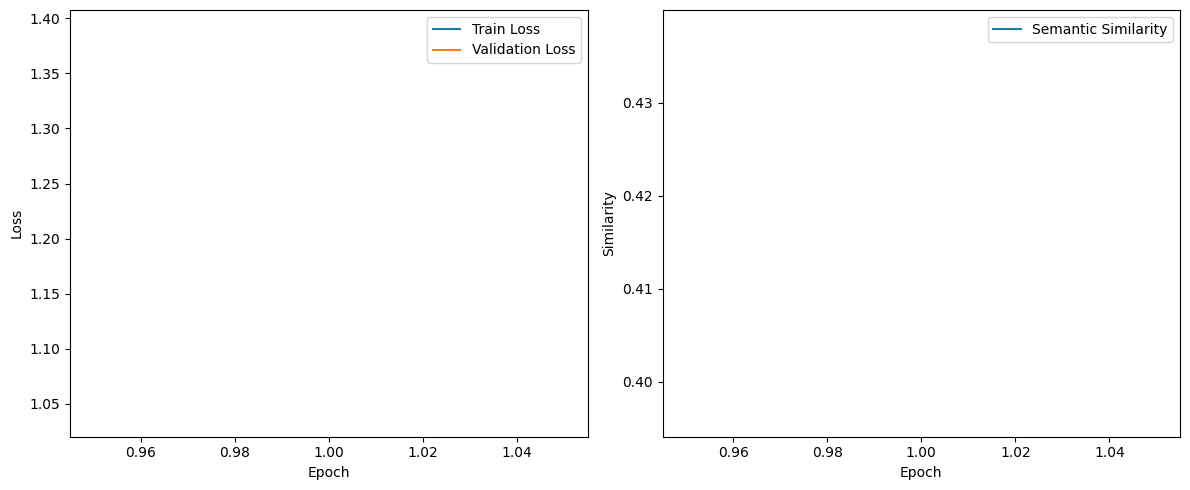

Evaluating:  98%|█████████▊| 59/60 [00:35<00:00,  1.65it/s]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]


========== TEST RESULTS ==========
Test Loss               : 0.9449
Test Semantic Similarity: 0.4267

--- Example 59 ---
Raw Report       : 
[ Finding ]_x000D_
Lt. calcaneous, fracture._x000D_
_x000D_
[ Conclusion ]_x000D_
Lt. calcaneous, fracture._x000D_
_x000D_
[ Recommend ]_x000D_

Cleaned Report   : 
Lt. calcaneous, fracture.
Generated Report : 
 no bony lesion. both feet, OA with subluxation of Rt 1st MTP joint -> gouty arthritis --> RA involvement in left calcaneal spur type II and foot soft tissue swelling around rheumatoid bone base area on radiographs since last study -- possible osteopenia degenerative change tophi suspicious erosion at Lt 5th MT head/foot tip > PIP site adjacent tendonitis receding plantar aspect fracture periarticular vascular bulging

--- Example 106 ---
Raw Report       : 
[ Finding ]_x000D_
no bony lesion._x000D_
[ Diagnosis ]_x000D_
no bony lesion._x000D_
[ Recommend ]_x000D_

Cleaned Report   : 
no bony lesion. no bony lesion.
Generated Report : 
 no 

In [7]:
import os
import re
import json
import unicodedata
import random
import logging
from collections import defaultdict, Counter

import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import timm
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt


# =============================================================================
# Logging configuration: write INFO+ logs only to training.log (no console output)
# =============================================================================
# 1) Remove any existing handlers (e.g. from prior imports or notebook runs)
for h in logging.root.handlers[:]:
    logging.root.removeHandler(h)

# 2) Configure file-only logging
logging.basicConfig(
    filename='training.log',      # will be created in your current working directory
    filemode='w',                 # overwrite on each run
    level=logging.INFO,
    format='%(asctime)s %(levelname)-8s %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# =============================================================================
# Utility functions
# =============================================================================

def count_labels(data, target_classes, cfg):
    class_counts = defaultdict(int)
    data_by_class = defaultdict(list)
    for entry in tqdm(data.values(), desc="Counting dataset"):
        lbl = entry.get('class_label', '').lower()
        if lbl in target_classes and os.path.exists(entry['file_path']):
            class_counts[lbl] += 1
            data_by_class[lbl].append(entry)
    return class_counts, data_by_class

def prepare_abnormal_normal_data(data, cfg):
    random.seed(42)
    abnormal = ['ra', 'oa', 'gout']
    normal = ['normal']
    class_counts, data_by_class = count_labels(data, abnormal + normal, cfg)
    combined = {
        'abnormal': sum((data_by_class[c] for c in abnormal), []),
        'normal': data_by_class['normal']
    }
    combined_counts = {
        'abnormal': sum(class_counts[c] for c in abnormal),
        'normal': class_counts['normal']
    }
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(combined.values(), []), combined_counts, combined_counts
    min_count = min(combined_counts.values())
    balanced = []
    final_counts = {}
    for lbl, items in combined.items():
        sampled = random.sample(items, min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    if cfg.DATASET.AUGMENT:
        balanced *= 2
    return balanced, combined_counts, final_counts

def prepare_data(data, target_classes, cfg, is_binary=False):
    random.seed(42)
    if len(target_classes) == 2 and 'abnormal' in target_classes and 'normal' in target_classes:
        logging.info("Using abnormal-vs-normal logic")
        return prepare_abnormal_normal_data(data, cfg)
    class_counts, data_by_class = count_labels(data, target_classes, cfg)
    logging.info(f"Original class distribution: {class_counts}")
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(data_by_class.values(), []), class_counts, class_counts
    min_count = min(class_counts.values())
    balanced, final_counts = [], {}
    for lbl in target_classes:
        sampled = random.sample(data_by_class[lbl], min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    logging.info(f"Balanced class distribution: {final_counts}")
    if cfg.DATASET.AUGMENT:
        balanced *= 2
    return balanced, class_counts, final_counts

# =============================================================================
# Transforms
# =============================================================================

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

patch_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

# =============================================================================
# Dataset
# =============================================================================

class FinalSamplesDataset(Dataset):
    def __init__(self, cfg, image_transform=train_transform, patch_transform=patch_transform):
        self.cfg = cfg
        self.image_transform = image_transform
        self.patch_transform = patch_transform

        self.target_classes = cfg.DATASET.TARGET_CLASSES
        if isinstance(self.target_classes, str):
            self.target_classes = self.target_classes.split(",")

        self.is_binary = len(self.target_classes) == 2
        self.abnormal_classify = self.is_binary and 'abnormal' in self.target_classes
        self.abnormal_mapping = (
            {'ra': 'abnormal', 'oa': 'abnormal', 'gout': 'abnormal', 'normal': 'normal'}
            if self.abnormal_classify else None
        )

        with open(cfg.DATASET.JSON, 'r') as f:
            raw_list = json.load(f)

        filtered = []
        for item in raw_list:
            merged = item.get('merged_image_path', '')
            fp = item.get('file_paths', [])
            if isinstance(fp, str):
                fp = [fp]
            paths = [merged] + fp
            if any(os.path.exists(p) for p in paths):
                filtered.append((merged, fp, item))

        self.data = {}
        for i, (merged, fp, item) in enumerate(filtered):
            cls = item.get('class', 'unknown').lower()
            if self.abnormal_mapping:
                cls = self.abnormal_mapping.get(cls, cls)
            self.data[i] = {
                'file_path': merged,
                'left_right_file_path': fp,
                'class_label': cls,
                'diagnosis': item.get('diagnosis', ''),
                'keypoints': item.get('keypoints', {})
            }

        if self.is_binary:
            balanced, _, _ = prepare_data(self.data, self.target_classes, cfg, True)
            self.data = {i: e for i, e in enumerate(balanced)}

        self.tokenizer = None
        self.eos_token = None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        e = self.data[idx]
        img = Image.open(e['file_path']).convert('RGB')
        img = self.image_transform(img)
        logging.info(f"[Dataset] full_img shape: {img.shape}")

        patches = self._gen_patches(e['left_right_file_path'], e['keypoints'])
        pt = [self.patch_transform(Image.fromarray(p)) for p in patches]
        patches_tensor = torch.stack(pt, 0) if pt else torch.zeros(34, 3, 112, 112)
        logging.info(f"[Dataset] patches_tensor shape: {patches_tensor.shape}")

        raw = e.get('diagnosis', '')
        clean = self._clean_report(raw)

        input_text = f"{self.tokenizer.bos_token} {clean}"
        tok = self.tokenizer(input_text, truncation=True, max_length=511, return_tensors='pt')

        if tok['input_ids'][0][-1] != self.tokenizer.eos_token_id:
            input_ids = torch.cat([tok['input_ids'], torch.tensor([[self.tokenizer.eos_token_id]])], dim=1)
            attention_mask = torch.cat([tok['attention_mask'], torch.tensor([[1]])], dim=1)
        else:
            input_ids = tok['input_ids']
            attention_mask = tok['attention_mask']

        input_ids = input_ids.squeeze(0)
        attention_mask = attention_mask.squeeze(0)
        logging.info(f"[Dataset] input_ids shape: {input_ids.shape}, attention_mask shape: {attention_mask.shape}")

        return {
            'full_img': img,
            'patches': patches_tensor,
            'raw_report': raw,
            'cleaned_report': clean,
            'input_ids': input_ids,
            'attention_mask': attention_mask
        }

    def _gen_patches(self, paths, kps_dict, crop_size=(200, 300), patch_size=(112, 112)):
        def extract(arr, side_kps):
            lst = []
            pts = side_kps[0]['keypoints']
            for i in range(17):
                x, y, s = int(pts[3*i]), int(pts[3*i+1]), pts[3*i+2]
                if s > 0:
                    x0 = max(x - crop_size[0]//2, 0)
                    y0 = max(y - crop_size[1]//2, 0)
                    x1 = min(x + crop_size[0]//2, arr.shape[1])
                    y1 = min(y + crop_size[1]//2, arr.shape[0])
                    c = arr[y0:y1, x0:x1]
                    if c.size:
                        lst.append(cv2.resize(c, patch_size))
            return lst

        def pad17(lst):
            black = np.zeros((patch_size[1], patch_size[0], 3), np.uint8)
            while len(lst) < 17:
                lst.append(black)
            return lst[:17]

        left, right = [], []
        if len(paths) == 1:
            pth = paths[0]
            if not pth or not os.path.exists(pth):
                return pad17([]) + pad17([])
            img_arr = cv2.imread(pth)
            if img_arr is None:
                return pad17([]) + pad17([])
            arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
            if kps_dict.get('left'): left = extract(arr, kps_dict['left'])
            if kps_dict.get('right'): right = extract(arr, kps_dict['right'])
        else:
            for side, pth in zip(['left', 'right'], paths):
                if pth and os.path.exists(pth):
                    img_arr = cv2.imread(pth)
                    if img_arr is not None:
                        arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
                        if kps_dict.get(side):
                            lst = extract(arr, kps_dict[side])
                            if side == 'left': left = lst
                            else: right = lst

        if left and not right:
            right = [cv2.flip(p, 1) for p in left]
        if right and not left:
            left = [cv2.flip(p, 1) for p in right]
        if not left and not right:
            return pad17([]) + pad17([])

        return pad17(left) + pad17(right)

    def _clean_report(self, text):
        text = unicodedata.normalize('NFKC', text or '')
        text = re.sub(r'(?m)^-+\s*$', '', text)
        text = re.sub(r'[^\x00-\x7F]+', ' ', text)
        text = re.sub(r'([.!?]){2,}', r'\1', text)
        text = re.sub(r'\[\s*finding\s*\]', '[FINDING]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*conclusion\s*\]', '[CONCLUSION]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*diagnosis\s*\]', '[DIAGNOSIS]', text, flags=re.IGNORECASE)
        parts = re.split(r'\[\s*recommend(?:ation)?\s*\]', text, flags=re.IGNORECASE)
        text = parts[0]
        fm = re.search(r'\[FINDING\](.*?)(?=\[|$)', text, flags=re.IGNORECASE | re.DOTALL)
        cm = re.search(r'\[CONCLUSION\](.*?)(?=\[|$)', text, flags=re.IGNORECASE | re.DOTALL)
        if fm and cm and fm.group(1).strip().lower() == cm.group(1).strip().lower():
            text = re.sub(r'\[CONCLUSION\].*?(?=\[|$)', '', text, flags=re.IGNORECASE | re.DOTALL)
        text = re.sub(r'\[\s*(FINDING|CONCLUSION|DIAGNOSIS)\s*\]', '', text, flags=re.IGNORECASE)
        text = text.replace('_x000D_', ' ')
        text = re.sub(r'\s+', ' ', text).strip()
        return text

# =============================================================================
# Collate function
# =============================================================================

def collate_fn(batch):
    imgs = torch.stack([b['full_img'] for b in batch])
    logging.info(f"[Collate] stacked full_imgs shape: {imgs.shape}")

    pts = [b['patches'] for b in batch]
    max_p = max(p.shape[0] for p in pts)
    pads = []
    for p in pts:
        if p.shape[0] < max_p:
            pad = torch.zeros((max_p - p.shape[0], *p.shape[1:]))
            p = torch.cat([p, pad], dim=0)
        pads.append(p)
    patches = torch.stack(pads, 0)
    logging.info(f"[Collate] stacked patches shape: {patches.shape}")

    ids = [b['input_ids'] for b in batch]
    masks = [b['attention_mask'] for b in batch]
    ids = nn.utils.rnn.pad_sequence(ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    masks = nn.utils.rnn.pad_sequence(masks, batch_first=True, padding_value=0)
    logging.info(f"[Collate] padded input_ids shape: {ids.shape}, padded attention_mask shape: {masks.shape}")

    return {
        'full_imgs': imgs,
        'patches': patches,
        'input_ids': ids,
        'attention_mask': masks,
        'raw_reports': [b['raw_report'] for b in batch],
        'cleaned_reports': [b['cleaned_report'] for b in batch]
    }

# =============================================================================
# Model
# =============================================================================

class MultiModalModel(nn.Module):
    def __init__(self, gpt2_model_name='gpt2'):
        super().__init__()
        self.global_encoder = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
        self.global_encoder.reset_classifier(0)
        self.global_proj = nn.Linear(self.global_encoder.num_features, 768)

        self.patch_encoder = timm.create_model('resnet50', pretrained=True)
        self.patch_encoder.fc = nn.Identity()
        self.patch_proj = nn.Linear(self.patch_encoder.num_features, 768)

        self.attn = nn.MultiheadAttention(embed_dim=768, num_heads=8, batch_first=True)
        self.norm = nn.LayerNorm(768)

        self.decoder = GPT2LMHeadModel.from_pretrained(gpt2_model_name, add_cross_attention=True)

    def _pool(self, feats):
        return feats.mean(dim=[2, 3]) if feats.ndim > 2 else feats

    def forward(self, imgs, patches, input_ids, attention_mask, decoder_labels=None):
        # Global image
        g_feats = self.global_encoder(imgs)
        logging.info(f"[Model] global_encoder output shape: {g_feats.shape}")
        g = self.global_proj(g_feats).unsqueeze(1)
        logging.info(f"[Model] global_proj + unsqueeze shape: {g.shape}")

        # Patch images
        B, N, C, H, W = patches.shape
        logging.info(f"[Model] patches input shape: {patches.shape}")
        p = patches.view(B * N, C, H, W)
        pf_feats = (self.patch_encoder.forward_features(p)
                    if hasattr(self.patch_encoder, 'forward_features')
                    else self.patch_encoder(p))
        logging.info(f"[Model] patch_encoder output shape: {pf_feats.shape}")
        pf_pooled = self._pool(pf_feats)
        pf = self.patch_proj(pf_pooled).view(B, N, 768)
        logging.info(f"[Model] patch_proj + reshape shape: {pf.shape}")

        # Combine
        cat = torch.cat([g, pf], dim=1)
        logging.info(f"[Model] concatenated features shape: {cat.shape}")
        comb, _ = self.attn(cat, cat, cat)
        comb = self.norm(comb)
        logging.info(f"[Model] after attention & norm shape: {comb.shape}")

        # Decoder
        out = self.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=comb,
            labels=decoder_labels
        )
        logging.info(f"[Model] decoder logits shape: {out.logits.shape}")
        return out

# =============================================================================
# Train / Eval helpers
# =============================================================================

def train_epoch(model, loader, optimizer, scaler, device):
    model.train()
    total_loss = 0.0
    for b in tqdm(loader, desc="Training", leave=False):
        imgs = b['full_imgs'].to(device)
        pts = b['patches'].to(device)
        ids = b['input_ids'].to(device)
        msk = b['attention_mask'].to(device)

        logging.info(f"[Train] batch full_imgs {imgs.shape}, patches {pts.shape}, input_ids {ids.shape}, mask {msk.shape}")

        optimizer.zero_grad()
        with torch.amp.autocast(device_type='cuda'):
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            loss = out.loss
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.0
    all_gen, all_gt = [], []
    for b in tqdm(loader, desc="Evaluating", leave=False):
        imgs = b['full_imgs'].to(device)
        pts = b['patches'].to(device)
        ids = b['input_ids'].to(device)
        msk = b['attention_mask'].to(device)

        logging.info(f"[Eval] batch full_imgs {imgs.shape}, patches {pts.shape}, input_ids {ids.shape}")

        with torch.no_grad():
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            total_loss += out.loss.item()

            bos_tokens = torch.tensor([[tokenizer.bos_token_id]] * imgs.size(0), device=device)
            logging.info(f"[Eval] bos_tokens shape: {bos_tokens.shape}")

            # Feature reuse
            g_feats = model.global_encoder(imgs)
            g = model.global_proj(g_feats).unsqueeze(1)
            B, N, C, H, W = pts.shape
            p = pts.view(B * N, C, H, W)
            pf_feats = model.patch_encoder(p)
            pf_pooled = model._pool(pf_feats)
            pf = model.patch_proj(pf_pooled).view(B, N, 768)
            cat = torch.cat([g, pf], dim=1)
            comb, _ = model.attn(cat, cat, cat)
            comb = model.norm(comb)

            gen_ids = model.decoder.generate(
                input_ids=bos_tokens,
                encoder_hidden_states=comb,
                early_stopping=True,
                attention_mask=torch.ones_like(bos_tokens),
                max_length=100,
                do_sample=True,
                top_k=40,
                top_p=0.9,
                temperature=0.7,
                repetition_penalty=1.3,
                no_repeat_ngram_size=2,
                eos_token_id=tokenizer.eos_token_id,
                pad_token_id=tokenizer.eos_token_id
            )
            logging.info(f"[Eval] gen_ids shape: {gen_ids.shape}")

            gen_txt = [tokenizer.decode(g_, skip_special_tokens=True) for g_ in gen_ids]
            gt_txt = [tokenizer.decode(i_, skip_special_tokens=True) for i_ in ids]
            all_gen.extend(gen_txt)
            all_gt.extend(gt_txt)

    return total_loss / len(loader), all_gen, all_gt

def compute_semantic_similarity(gen, gt):
    stm = SentenceTransformer('all-MiniLM-L6-v2')
    e1 = stm.encode(gen, convert_to_tensor=True)
    e2 = stm.encode(gt, convert_to_tensor=True)
    return nn.functional.cosine_similarity(e1, e2).mean().item()

def plot_metrics(train_losses, val_losses, sems):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, sems, label="Semantic Similarity")
    plt.xlabel("Epoch")
    plt.ylabel("Similarity")
    plt.legend()

    plt.tight_layout()
    plt.show()

# =============================================================================
# MAIN
# =============================================================================

class Cfg: pass
cfg = Cfg()
cfg.DATASET = Cfg()
cfg.DATASET.JSON = 'final_samples_both_only_v2.json'
cfg.DATASET.USE_RAW = True
cfg.DATASET.USE_PATCH = True
cfg.DATASET.REPORT = True
cfg.DATASET.TARGET_CLASSES = ['ra', 'oa', 'gout', 'normal', 'uncertain', 'ref.prev']
cfg.DATASET.BALANCE = False
cfg.DATASET.AUGMENT = False

# Initialize and configure tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = 'left'
tokenizer.pad_token = tokenizer.eos_token

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Using device: {device}")

# Prepare dataset
dataset = FinalSamplesDataset(cfg)
dataset.tokenizer = tokenizer
dataset.eos_token = tokenizer.eos_token

dist = Counter(e['class_label'] for e in dataset.data.values())
logging.info("Dataset class distribution:")
for cls, cnt in dist.items():
    logging.info(f"  {cls}: {cnt}")

# Split
n = len(dataset)
n_train = int(0.8 * n)
n_val = int(0.1 * n)
n_test = n - n_train - n_val
train_ds, val_ds, test_ds = random_split(dataset, [n_train, n_val, n_test])

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_ds, batch_size=4, shuffle=False, collate_fn=collate_fn)

# Model, optimizer, scheduler, scaler
model = MultiModalModel().to(device)
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
scaler = torch.amp.GradScaler()

# Training
num_epochs = 1
train_losses, val_losses, sems = [], [], []

for epoch in range(num_epochs):
    logging.info(f"\nEpoch {epoch + 1}/{num_epochs}")
    train_loss = train_epoch(model, train_loader, optimizer, scaler, device)
    val_loss, gen_txt, gt_txt = evaluate(model, val_loader, device)
    sem = compute_semantic_similarity(gen_txt, gt_txt)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    sems.append(sem)

    logging.info(f"  Train Loss          : {train_loss:.4f}")
    logging.info(f"  Validation Loss     : {val_loss:.4f}")
    logging.info(f"  Semantic Similarity : {sem:.4f}")

    print(f"  Train Loss          : {train_loss:.4f}")
    print(f"  Validation Loss     : {val_loss:.4f}")
    print(f"  Semantic Similarity : {sem:.4f}")
    scheduler.step()

# Plot metrics
plot_metrics(train_losses, val_losses, sems)

# Test evaluation
test_loss, test_gen, test_gt = evaluate(model, test_loader, device)
test_sem = compute_semantic_similarity(test_gen, test_gt)
logging.info("\n========== TEST RESULTS ==========")
logging.info(f"Test Loss               : {test_loss:.4f}")
logging.info(f"Test Semantic Similarity: {test_sem:.4f}")

print("\n========== TEST RESULTS ==========")
print(f"Test Loss               : {test_loss:.4f}")
print(f"Test Semantic Similarity: {test_sem:.4f}")

# Random test examples
logging.info("\n===== RANDOM TEST EXAMPLES =====")
for idx in random.sample(range(len(test_ds)), min(10, len(test_ds))):
    ex = test_ds[idx]
    raw = ex['raw_report']
    clean = ex['cleaned_report']
    fi = ex['full_img'].unsqueeze(0).to(device)
    pa = ex['patches'].unsqueeze(0).to(device)
    
    prompt = torch.tensor([[tokenizer.bos_token_id]], device=device)
    g_feats = model.global_encoder(fi)
    g = model.global_proj(g_feats).unsqueeze(1)
    B, N, C, H, W = pa.shape
    p = pa.view(B * N, C, H, W)
    pf_feats = model.patch_encoder(p)
    pf_pooled = model._pool(pf_feats)
    pf = model.patch_proj(pf_pooled).view(B, N, 768)
    cat = torch.cat([g, pf], dim=1)
    comb, _ = model.attn(cat, cat, cat)
    comb = model.norm(comb)

    gen_ids = model.decoder.generate(
        input_ids=prompt,
        encoder_hidden_states=comb,
        early_stopping=True,
        attention_mask=torch.ones_like(prompt),
        max_length=100,
        do_sample=True,
        top_k=40,
        top_p=0.9,
        temperature=0.7,
        repetition_penalty=1.3,
        no_repeat_ngram_size=2,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id
    )
    gen = tokenizer.decode(gen_ids[0], skip_special_tokens=True)

    logging.info(f"\n--- Example {idx} ---")
    logging.info(f"Raw Report       : \n{raw}")
    logging.info(f"Cleaned Report   : \n{clean}")
    logging.info(f"Generated Report : \n{gen}")

    print(f"\n--- Example {idx} ---")
    print(f"Raw Report       : \n{raw}")
    print(f"Cleaned Report   : \n{clean}")
    print(f"Generated Report : \n{gen}")
